In [1]:
# import torch
# import timm
# from torchvision import transforms
# import torch.nn as nn
# import torch.nn.functional as F
# import theseus as th
# import copy
# import os


# # State Encoder (ho)
# class StateEncoder(nn.Module):
#     def __init__(self):
#         super(StateEncoder, self).__init__()
#         self.obs_encoder = timm.create_model(
#             'resnet18.a1_in1k',
#             pretrained=True,
#             num_classes=0, 
#         )
#     def forward(self, nobs):
#         return self.obs_encoder(nobs)

# # Action Encoder (ha)
# class ActionEncoder(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(ActionEncoder, self).__init__()
#         self.network = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.ELU(),
#             nn.Linear(256, 256),
#             nn.ELU(),
#             nn.Linear(256, output_dim)
#         )

#     def forward(self, action):
#         return self.network(action)

# # Fusing Encoder (hl)
# class FusingEncoder(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(FusingEncoder, self).__init__()
#         self.network = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.ELU(),
#             nn.Linear(256, 256),
#             nn.ELU(),
#             nn.Linear(256, output_dim)
#         )

#     def forward(self, hs, ha):
#         h = torch.cat((hs, ha), dim=-1)
#         h = self.network(h)
#         mu, logvar = torch.split(h, int(0.5*h.shape[-1]), dim=-1)
#         return mu, logvar

# # Reward Decoder (r)
# class RewardDecoder(nn.Module):
#     def __init__(self, input_dim):
#         super(RewardDecoder, self).__init__()
#         self.network = nn.Sequential(
#             nn.Linear(input_dim, 512),
#             nn.ELU(),
#             nn.Linear(512, 512),
#             nn.ELU(),
#             nn.Linear(512, 1),
#             # nn.Tanh()
#         )

#     def forward(self, z):
#         return self.network(z)

# # Dynamics Function (d)
# class DynamicsFunction(nn.Module):
#     def __init__(self, latent_dim_state, latent_dim_action, posterior_dim):
#         super(DynamicsFunction, self).__init__()
#         self.network = nn.Sequential(
#             nn.Linear(latent_dim_state + latent_dim_action + posterior_dim, 512),
#             nn.ELU(),
#             nn.Linear(512, 512),
#             nn.ELU(),
#             nn.Linear(512, latent_dim_state + posterior_dim)
#         )
#         self.latent_dim_state = latent_dim_state

#     def forward(self, zs, za, z):
#         z_combined = torch.cat((zs, za, z), dim=-1)
#         z = self.network(z_combined)
#         return z[:, :self.latent_dim_state], z[:, self.latent_dim_state:]

# # Decoder for Action Reconstruction
# class ActionDecoder(nn.Module):
#     def __init__(self, posterior_dim, latent_dim_state, action_dim):
#         super(ActionDecoder, self).__init__()
#         self.network = nn.Sequential(
#             nn.Linear(posterior_dim + latent_dim_state, 256),
#             nn.ELU(),
#             nn.Linear(256, 256),
#             nn.ELU(),
#             nn.Linear(256, action_dim),
#             nn.Tanh()
#         )

#     def forward(self, z, zs):
#         z_combined = torch.cat((z, zs), dim=-1)
#         return self.network(z_combined)


# # Loss Function (ELBO)
# def compute_elbo_loss(predict_actions, na_target, mu, logvar):
#     # Reconstruction loss (MSE)
#     l2_loss = nn.MSELoss()(predict_actions, na_target)
#     # KL divergence
#     kl_loss = -10 * torch.mean(0.5 * torch.sum(1 + logvar - logvar.exp() - mu.pow(2), dim=1), dim=0)

#     return l2_loss, kl_loss

# class Normalizer(object):
#     """Normalizes observations and actions to zero mean and unit variance."""
#     def __init__(self,cfg):
#         self.obs_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).cuda()
#         self.obs_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).cuda()
#         self.action_mean = torch.zeros(cfg.a_dim).cuda()
#         self.action_std = 10*torch.ones(cfg.a_dim).cuda()

#     def normalize_obs(self, obs):
#         return (obs - self.obs_mean) / (self.obs_std + 1e-8)

#     def normalize_action(self, action):
#         return (action - self.action_mean) / (self.action_std + 1e-8)

#     def denormalize_obs(self, obs):
#         return obs * self.obs_std + self.obs_mean

#     def denormalize_action(self, action):
#         return action * self.action_std + self.action_mean



In [1]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F13
# import theseus as th
# # from cvae_utilities import *
# import os
# import wandb
# import matplotlib.pyplot as plt
# from copy import deepcopy

# class CVAEWithTrajectoryOptimization(nn.Module):
#     def __init__(self, cfg):
#         super(CVAEWithTrajectoryOptimization, self).__init__()
#         s_dim = cfg.s_dim
#         a_dim = cfg.a_dim
#         horizon = cfg.horizon
#         z_dim = cfg.z_dim
#         device = cfg.device
#         self.state_encoder = StateEncoder().to(device)
#         self.action_encoder = ActionEncoder(a_dim * horizon, a_dim * horizon).to(device)
#         self.fusing_encoder = FusingEncoder(s_dim + a_dim * horizon, z_dim*2).to(device)
#         self.reward_decoder = RewardDecoder(s_dim + a_dim * horizon + z_dim).to(device)
#         self.z_dim = z_dim
#         self.device = device
#         self.cfg = cfg
#         self.normalizer = Normalizer(cfg)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def plan_action(self,
#                 init_actions,
#                 z,
#                 batch_size,
#                 horizon,
#                 action_dim,
#                 damping,
#                 traj_opt_num,
#                 traj_opt_step,
#                 train_mode=True):
#             actions = init_actions.detach().reshape(1, -1)
#             init_actions = deepcopy(actions)
#             actions = th.Vector(tensor=actions, name="actions")
#             z = th.Variable(tensor=z, name="z")
#             def value_cost_fn(optim_vars, aux_vars):
#                 temp_actions = optim_vars[0].tensor.view(batch_size, horizon * action_dim)
#                 temp_actions = torch.clamp(temp_actions, -1, 1)
#                 temp_z = aux_vars[0].tensor.view(batch_size, -1)
#                 x = torch.cat([temp_z, temp_actions], dim=-1)
#                 reward = self.reward_decoder(x)
#                 err = -reward.nan_to_num_(0) + 1000
                
#                 err = err.mean(dim=0).view(1, 1)
#                 return err

#             cost_fn = th.AutoDiffCostFunction(
#                 [actions], value_cost_fn, 1, aux_vars=[z], name="value_cost_fn"
#             )

#             objective = th.Objective()
#             objective.to(device=self.device)
#             objective.add(cost_fn)

#             optimizer = th.LevenbergMarquardt(
#                 objective, th.CholeskyDenseSolver,
#                 max_iterations=traj_opt_num,
#                 step_size=traj_opt_step,
#             )

#             theseus_layer = th.TheseusLayer(optimizer).to(device=self.device)

#             theseus_inputs = {"actions": init_actions, "z": z.tensor}

#             if train_mode:
#                 updated_inputs, info = theseus_layer.forward(
#                     theseus_inputs,
#                     optimizer_kwargs={
#                         "track_best_solution": True,
#                         "damping": damping,
#                         "verbose": False,
#                         "backward_mode": "truncated",
#                         "backward_num_iterations": 5,
#                     },
#                 )
#             else:
#                 with torch.no_grad():
#                     updated_inputs, info = theseus_layer.forward(
#                         theseus_inputs,
#                         optimizer_kwargs={
#                             "track_best_solution": True,
#                             "damping": damping,
#                             "verbose": False,
#                             "backward_mode": "truncated",
#                             "backward_num_iterations": 5,
#                         },
#                     )
#             updated_actions = updated_inputs["actions"].view(batch_size, horizon, action_dim)
#             predict_actions = updated_actions#TODO: multi planing horizon
#             return predict_actions, info

    
#     def save_pretrained(self, save_directory):
#         """Save model weights and config to directory"""
#         os.makedirs(save_directory, exist_ok=True)
        
#         # Save model state dict
#         model_path = os.path.join(save_directory, "model.pt")
#         torch.save({
#             'state_encoder': self.state_encoder.state_dict(),
#             'action_encoder': self.action_encoder.state_dict(),
#             'fusing_encoder': self.fusing_encoder.state_dict(),
#             'dynamics_function': self.dynamics_function.state_dict(),
#             'action_decoder': self.action_decoder.state_dict(),
#             'reward_decoder': self.reward_decoder.state_dict(),
#             'cfg': self.cfg
#         }, model_path)

#     def load_pretrained(self, load_directory):
#         """Load model weights and config from directory"""
#         model_path = os.path.join(load_directory, "model.pt")
#         if not os.path.exists(model_path):
#             raise ValueError(f"Model file not found at {model_path}")
            
#         checkpoint = torch.load(model_path, map_location=self.device)
        
#         # Load model weights
#         self.state_encoder.load_state_dict(checkpoint['state_encoder'])
#         self.action_encoder.load_state_dict(checkpoint['action_encoder'])
#         self.fusing_encoder.load_state_dict(checkpoint['fusing_encoder'])
#         self.dynamics_function.load_state_dict(checkpoint['dynamics_function'])
#         self.action_decoder.load_state_dict(checkpoint['action_decoder'])
#         self.reward_decoder.load_state_dict(checkpoint['reward_decoder'])
        
#         # Load config
#         self.cfg = checkpoint['cfg']

#     def plan_with_theseus_update(self, obs, state, actions = None, train_mode=True):
#         """
#         Perform trajectory optimization using Theseus.
#         Args:
#             obs: Observation (raw state input).
#             horizon: Planning horizon.
#             gamma: Discount factor.
#             model: The CVAE model containing dynamics and state encoders.
#             cfg: Configuration object (for damping, step size, etc.).
#             eval_mode: Whether to evaluate without gradients.
#         """
#         # Prepare initial observation
#         batch_size = obs.shape[0]
#         obs = deepcopy(obs[:,0,...]) # [bs, 3, 96, 96]
#         nobs = self.normalizer.normalize_obs(obs)
#         cur_actions = deepcopy(state) # [bs, 1, 2]
#         # ncactions = self.normalizer.normalize_action(cur_actions)

#         #TODO: can use diff of action
#         if train_mode:
#             actions = deepcopy(actions) 
#             actions = (actions - torch.concat([cur_actions, actions[:,:-1,:]], dim=1))
#             na_target = self.normalizer.normalize_action(actions) # [bs, horizon, 2]
#             nactions = na_target.reshape(batch_size, -1) # [bs, horizon * 2]
#             hs = self.state_encoder(nobs) # [bs, s_dim]
#             ha = self.action_encoder(nactions) # [bs, a_dim * horizon]
#             mu, logvar = self.fusing_encoder(hs, ha) # [bs, z_dim]
#             z = self.reparameterize(mu, logvar) # [bs, z_dim]
            
#             z = torch.cat([hs, z], dim=-1) # [bs, s_dim + z_dim]
#             z = z.reshape(1,-1)
#             init_actions = nactions + torch.randn_like(nactions) * 0.1

#         else:
#             with torch.no_grad():
#                 obs_features = self.state_encoder(nobs)
#                 z = torch.randn(batch_size, self.z_dim).to(self.device)
#                 z = torch.cat([obs_features, z], dim=-1)
#                 z = z.reshape(1, -1)
#                 mu = torch.zeros(batch_size, self.z_dim).to(self.device)
#                 logvar = torch.zeros(batch_size, self.z_dim).to(self.device)
#                 na_target = torch.zeros(batch_size, self.cfg.horizon, self.cfg.a_dim).to(self.device)
#                 init_actions = torch.zeros(batch_size, self.cfg.horizon * self.cfg.a_dim).to(self.device)
#                 #TODO: multi planing horizon

#         predict_actions, info = self.plan_action(
#             init_actions,
#             z,
#             batch_size,
#             self.cfg.horizon,
#             self.cfg.a_dim,
#             self.cfg.damping,
#             self.cfg.traj_opt_num,
#             self.cfg.traj_opt_step,
#             train_mode=train_mode
#         )
#         l2_loss, kl_loss = compute_elbo_loss(
#             predict_actions, na_target, mu, logvar
#         )
#         output_dict = {
#             "best_actions": predict_actions,
#             "l2_loss": l2_loss,
#             "kl_loss": kl_loss,
#             "info": info
#         }

#         return output_dict


In [2]:
# # # Example Usage
# class Config:
#     def __init__(self):
#         self.horizon = 7
#         self.s_dim = 512
#         self.a_dim = 2
#         self.z_dim = 64
#         self.horizon = 7
#         self.traj_opt_num = 50
#         self.traj_opt_step = 1e-2
#         # Theseus optimization parameters
#         self.damping = 1e-3
#         self.min_std = 1e-4
#         self.discount = 0.99
#         self.state_dim = 512*3*3 + 2
#         self.batch_size = 16
#         self.posterior_dim = 64
#         self.device = torch.device("cuda")
#         self.beta = 1.0
# cfg = Config()
# device = cfg.device

# # Create CVAE model
# model = CVAEWithTrajectoryOptimization(cfg)

# # Example observation
# obs = torch.randn(cfg.batch_size,1,3,96,96).to(device)
# state = torch.randn(cfg.batch_size,1,2).to(device)
# action = torch.randn(cfg.batch_size,7,2).to(device)
# # obs = (obs, state)

# output_dict = model.plan_with_theseus_update(obs, state, action, train_mode=True)

# output_dict = model.plan_with_theseus_update(obs, state, train_mode=False)

In [4]:
# import matplotlib.pyplot as plt

# def visualize_obs(obs, state, actions):
#     # Convert observation tensor to numpy and rearrange dimensions for plotting
#     img = obs[0].cpu().numpy().transpose(1, 2, 0)  # Change from [C,H,W] to [H,W,C]
    
#     plt.figure(figsize=(8, 8))
#     # Plot the image
#     plt.imshow(img)
    
#     # Plot the state point (red dot)
#     state = state.cpu().numpy()
#     plt.plot(state[0], state[1], 'ro', markersize=10)

#     for action in actions:
#         action = action.cpu().numpy()
#         # Plot the action point (blue dot)
#         plt.plot(action[0], action[1], 'bo', markersize=5)
#     # Add a title and labels
#     plt.title('Observation with State Position')
#     plt.axis('on')
#     plt.grid(True)
    
#     plt.show()
# visualize = lambda i: visualize_obs(obs[i],state[i,0]/512*96, action[i]/512*96)
# visualize(14)

In [ ]:
# def evaluate(policy, eval_dataloader):
#     torch.cuda.empty_cache()  # Clear cache before evaluation
#     policy.eval()
#     total_loss = 0
#     num_batches = 0
#     with torch.no_grad():
#         for batch in tqdm.tqdm(eval_dataloader, desc="Evaluating"):
#             obs = batch['observation.image'].to(device, non_blocking=True)
#             state = batch['observation.state'].to(device, non_blocking=True)
#             action = batch['action'].to(device, non_blocking=True)
#             output_dict = policy.plan_with_theseus_update(obs, state, train_mode=False)
#             total_loss += output_dict["l2_loss"].item()
#             num_batches += 1
#             if num_batches >= 10: 
#                 break
#             del output_dict  
#             torch.cuda.empty_cache()
#     policy.train()
#     return total_loss / num_batches

# training

In [2]:
import torch, os, wandb
import tqdm, numpy as np
from torch import nn
from torch.utils.data import DataLoader
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.datasets.sampler import EpisodeAwareSampler
import gymnasium as gym
import gym_pusht
import collections
from cvae_utilities import *

In [4]:
# # Example Usage
class Config:
    def __init__(self):
        self.horizon = 7
        self.s_dim = 512
        self.a_dim = 2
        self.z_dim = 64
        self.horizon = 7
        self.traj_opt_num = 50
        self.traj_opt_step = 1e-2
        # Theseus optimization parameters
        self.damping = 1e-3
        self.min_std = 1e-4
        self.discount = 0.99
        self.state_dim = 512*3*3 + 2
        self.batch_size = 16
        self.posterior_dim = 64
        self.device = torch.device("cuda")
        self.beta = 1.0
cfg = Config()
device = cfg.device

# Create CVAE model
model = CVAEWithTrajectoryOptimization(cfg)

# Example observation
obs = torch.randn(cfg.batch_size,1,3,96,96).to(device)
state = torch.randn(cfg.batch_size,1,2).to(device)
action = torch.randn(cfg.batch_size,7,2).to(device)
# obs = (obs, state)

output_dict = model.plan_with_theseus_update(obs, state, action, train_mode=True)

output_dict = model.plan_with_theseus_update(obs, state, train_mode=False)

In [1]:
import torch, os, wandb
import tqdm, numpy as np
from torch import nn
from torch.utils.data import DataLoader
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.datasets.sampler import EpisodeAwareSampler
import gymnasium as gym
import gym_pusht
import collections
from cvae_utilities import *
# torch.cuda.set_per_process_memory_fraction(0.9)  
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

def evaluate(policy, eval_dataloader):
    torch.cuda.empty_cache()  # Clear cache before evaluation
    policy.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(eval_dataloader, desc="Evaluating"):
            obs = batch['observation.image'].to(device, non_blocking=True)
            state = batch['observation.state'].to(device, non_blocking=True)
            action = batch['action'].to(device, non_blocking=True)
            output_dict = policy.plan_with_theseus_update(obs, state, train_mode=False)
            total_loss += output_dict["l2_loss"].item()
            num_batches += 1
            if num_batches >= 10: 
                break
            del output_dict  
            torch.cuda.empty_cache()
    policy.train()
    return total_loss / num_batches

class Config:
    def __init__(self, config_dict):
        for k, v in config_dict.items():
            setattr(self, k, v)

config_dict = {
    "horizon": 7, "s_dim": 512, "a_dim": 2, "z_dim": 64,
    "traj_opt_num": 50, "traj_opt_step": 1e-2, "damping": 1e-3,
    "batch_size": 16, "device": torch.device("cuda"),
    "beta": 1.0, "learning_rate": 1e-4, "num_epochs": 1000,
    "gradient_accumulation_steps": 4, "log_freq": 10,
    "eval_freq": 50, "output_directory": "./output",
    "online_eval_episodes": 5,
}

config = Config(config_dict)

wandb.init(
    project="difftop-training",
    config=config_dict,
    # resume=True
)

device = torch.device("cuda")
policy = CVAEWithTrajectoryOptimization(config)

# Load previous checkpoint if exists
if os.path.exists(f"{wandb.config.output_directory}/best_model"):
    print("Loading previous checkpoint...")
    policy.load_pretrained(f"{wandb.config.output_directory}/best_model")

policy.train()
policy.to(device)

optimizer = torch.optim.Adam(policy.parameters(), lr=wandb.config.learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                        T_max=15000,
                                                        eta_min=1e-6)

# Set up the dataset
delta_timestamps = {
    "observation.image": [0.0],
    "observation.state": [0.0],
    "action": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
}

dataset = LeRobotDataset("lerobot/pusht_image", delta_timestamps=delta_timestamps)

episode_indices_to_use = np.arange(dataset.num_episodes)
test_episode_indices = np.random.choice(episode_indices_to_use, 10, replace=False)
train_episode_indices = np.setdiff1d(episode_indices_to_use, test_episode_indices)

train_sampler = EpisodeAwareSampler(dataset.episode_data_index, episode_indices_to_use=train_episode_indices, shuffle=True)
test_sampler = EpisodeAwareSampler(dataset.episode_data_index, episode_indices_to_use=test_episode_indices, shuffle=True)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=2,
    batch_size=wandb.config.batch_size,
    sampler=train_sampler,
    pin_memory=True,
    drop_last=True,
)

eval_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=2, 
    batch_size=wandb.config.batch_size,
    sampler=test_sampler,
    pin_memory=True,
    drop_last=True,
)

global_step = 0
for epoch in range(wandb.config.num_epochs):
    print(f"Epoch {epoch+1}/{wandb.config.num_epochs}")
    epoch_loss = 0
    num_batches = 0
    optimizer.zero_grad()

    for batch_idx, batch in enumerate(tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1}")):
        torch.cuda.empty_cache()  # Clear cache before each batch
        # batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        obs = batch['observation.image'].to(device, non_blocking=True)
        state = batch['observation.state'].to(device, non_blocking=True)
        action = batch['action'].to(device, non_blocking=True)
        output_dict = policy.plan_with_theseus_update(obs, state, action, train_mode=True)
        bc_loss = output_dict["l2_loss"] / wandb.config.gradient_accumulation_steps
        kl_loss = output_dict["kl_loss"] / wandb.config.gradient_accumulation_steps
        loss = bc_loss + kl_loss
        loss.backward()
        epoch_loss += loss.item() * wandb.config.gradient_accumulation_steps
        num_batches += 1

        # Log the min and max of the best actions
        best_actions = output_dict['best_actions'][0].reshape(7, 2)
        wandb.log({
            "train/min_best_action": best_actions.min(),
            "train/max_best_action": best_actions.max()
        })

        # Free memory
        del output_dict
        torch.cuda.empty_cache()

        if global_step % wandb.config.gradient_accumulation_steps == 0 and global_step > 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
        if global_step % wandb.config.log_freq == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.3f}, LR: {current_lr:.6f}")
            wandb.log({
                "train/batch_loss": loss.item(),
                "train/bc_loss":bc_loss.item(),
                "train/kl_loss":kl_loss.item(),
                "train/learning_rate": current_lr,
                "train/batch": batch_idx + 1,
                "train/global_step": global_step
            })

        # Evaluate every eval_freq steps
        if global_step % wandb.config.eval_freq == 0:
            # Offline evaluation
            eval_loss = evaluate(policy, eval_dataloader)
            print(f"Step {global_step} Eval Loss: {eval_loss:.3f}")
            
            # Online evaluation
            # mean_reward, mean_length = online_evaluate(policy, num_episodes=wandb.config.online_eval_episodes)
            # print(f"Online Eval - Mean Reward: {mean_reward:.3f}, Mean Episode Length: {mean_length:.1f}")
            
            wandb.log({
                "eval/loss": eval_loss,
                # "eval/online_reward": mean_reward,
                # "eval/episode_length": mean_length,
                "eval/global_step": global_step
            })

            #     # Save best model based on both metrics
            #     if eval_loss < best_eval_loss or mean_reward > best_online_reward:
            #         best_eval_loss = min(eval_loss, best_eval_loss)
            #         best_online_reward = max(mean_reward, best_online_reward)
            #         policy.save_pretrained(f"{wandb.config.output_directory}/best_model")
            #         wandb.log({
            #             "eval/best_loss": best_eval_loss,
            #             "eval/best_online_reward": best_online_reward,
            #             "eval/best_step": global_step
            #         })

        global_step += 1
        print(f"Global Step: {global_step}")

    # End of epoch
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.3f}")
    wandb.log({
        "train/epoch_loss": avg_epoch_loss,
        "train/epoch": epoch + 1
    })

c:\ProgramData\anaconda3\envs\lerobot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lawrence-rs-lin (lawrence-rs-lin-university-of-toronto) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/1000


Epoch 1:   0%|          | 0/1536 [00:00<?, ?it/s]

Epoch 1, Batch 1, Loss: 4.015, LR: 0.000100


Epoch 1:   0%|          | 1/1536 [00:42<18:07:55, 42.53s/it]

Step 0 Eval Loss: 18.294
Global Step: 1


Epoch 1:   0%|          | 3/1536 [00:42<4:07:13,  9.68s/it] 

Global Step: 2
Global Step: 3
Global Step: 4


Epoch 1:   0%|          | 5/1536 [00:43<1:48:47,  4.26s/it]

Global Step: 5
Global Step: 6


Epoch 1:   0%|          | 7/1536 [00:43<1:01:14,  2.40s/it]

Global Step: 7
Global Step: 8


Epoch 1:   1%|          | 10/1536 [00:43<30:58,  1.22s/it] 

Global Step: 9
Global Step: 10


Epoch 1:   1%|          | 12/1536 [00:44<19:17,  1.32it/s]

Epoch 1, Batch 11, Loss: 5.022, LR: 0.000100
Global Step: 11
Global Step: 12


Epoch 1:   1%|          | 14/1536 [00:44<12:49,  1.98it/s]

Global Step: 13
Global Step: 14


Epoch 1:   1%|          | 15/1536 [00:44<10:52,  2.33it/s]

Global Step: 15
Global Step: 16


Epoch 1:   1%|          | 18/1536 [00:45<06:38,  3.81it/s]

Global Step: 17
Global Step: 18


Epoch 1:   1%|          | 19/1536 [00:45<06:26,  3.93it/s]

Global Step: 19
Global Step: 20


Epoch 1:   1%|▏         | 22/1536 [00:45<04:55,  5.13it/s]

Epoch 1, Batch 21, Loss: 6.779, LR: 0.000100
Global Step: 21
Global Step: 22


Epoch 1:   2%|▏         | 24/1536 [00:46<04:31,  5.56it/s]

Global Step: 23
Global Step: 24


Epoch 1:   2%|▏         | 26/1536 [00:46<04:16,  5.89it/s]

Global Step: 25
Global Step: 26


Epoch 1:   2%|▏         | 28/1536 [00:47<04:12,  5.97it/s]

Global Step: 27
Global Step: 28


Epoch 1:   2%|▏         | 29/1536 [00:47<04:43,  5.31it/s]

Global Step: 29
Global Step: 30


Epoch 1:   2%|▏         | 32/1536 [00:47<04:13,  5.93it/s]

Epoch 1, Batch 31, Loss: 9.948, LR: 0.000100
Global Step: 31
Global Step: 32


Epoch 1:   2%|▏         | 34/1536 [00:48<04:25,  5.66it/s]

Global Step: 33
Global Step: 34


Epoch 1:   2%|▏         | 36/1536 [00:48<04:03,  6.15it/s]

Global Step: 35
Global Step: 36


Epoch 1:   2%|▏         | 38/1536 [00:48<04:06,  6.09it/s]

Global Step: 37
Global Step: 38


Epoch 1:   3%|▎         | 40/1536 [00:49<03:55,  6.36it/s]

Global Step: 39
Global Step: 40


Epoch 1:   3%|▎         | 41/1536 [00:49<04:20,  5.74it/s]

Epoch 1, Batch 41, Loss: 10.268, LR: 0.000100
Global Step: 41
Global Step: 42


Epoch 1:   3%|▎         | 44/1536 [00:49<03:48,  6.53it/s]

Global Step: 43
Global Step: 44


Epoch 1:   3%|▎         | 46/1536 [00:50<03:50,  6.46it/s]

Global Step: 45
Global Step: 46


Epoch 1:   3%|▎         | 48/1536 [00:50<03:53,  6.37it/s]

Global Step: 47
Global Step: 48


Epoch 1:   3%|▎         | 49/1536 [00:50<04:32,  5.47it/s]

Global Step: 49
Global Step: 50
Epoch 1, Batch 51, Loss: 14.741, LR: 0.000100


Epoch 1:   3%|▎         | 53/1536 [01:13<1:19:52,  3.23s/it]

Step 50 Eval Loss: 66.557
Global Step: 51
Global Step: 52
Global Step: 53


Epoch 1:   4%|▎         | 55/1536 [01:13<51:47,  2.10s/it]  

Global Step: 54
Global Step: 55


Epoch 1:   4%|▎         | 57/1536 [01:14<33:07,  1.34s/it]

Global Step: 56
Global Step: 57


Epoch 1:   4%|▍         | 58/1536 [01:14<27:03,  1.10s/it]

Global Step: 58
Global Step: 59


Epoch 1:   4%|▍         | 60/1536 [01:14<17:39,  1.39it/s]

Global Step: 60
Epoch 1, Batch 61, Loss: 15.125, LR: 0.000100
Global Step: 61


Epoch 1:   4%|▍         | 62/1536 [01:15<12:41,  1.93it/s]

Global Step: 62
Global Step: 63


Epoch 1:   4%|▍         | 64/1536 [01:15<09:46,  2.51it/s]

Global Step: 64
Global Step: 65


Epoch 1:   4%|▍         | 66/1536 [01:15<07:52,  3.11it/s]

Global Step: 66
Global Step: 67


Epoch 1:   4%|▍         | 68/1536 [01:16<06:39,  3.67it/s]

Global Step: 68
Global Step: 69


Epoch 1:   5%|▍         | 71/1536 [01:16<05:36,  4.36it/s]

Global Step: 70
Epoch 1, Batch 71, Loss: 17.372, LR: 0.000100
Global Step: 71


Epoch 1:   5%|▍         | 72/1536 [01:16<05:07,  4.76it/s]

Global Step: 72
Global Step: 73


Epoch 1:   5%|▍         | 74/1536 [01:17<04:43,  5.16it/s]

Global Step: 74
Global Step: 75


Epoch 1:   5%|▍         | 76/1536 [01:17<04:34,  5.32it/s]

Global Step: 76
Global Step: 77


Epoch 1:   5%|▌         | 78/1536 [01:17<04:25,  5.50it/s]

Global Step: 78
Global Step: 79


Epoch 1:   5%|▌         | 80/1536 [01:18<04:19,  5.60it/s]

Global Step: 80
Epoch 1, Batch 81, Loss: 15.797, LR: 0.000100
Global Step: 81


Epoch 1:   5%|▌         | 82/1536 [01:18<04:20,  5.58it/s]

Global Step: 82
Global Step: 83


Epoch 1:   5%|▌         | 84/1536 [01:18<04:17,  5.64it/s]

Global Step: 84
Global Step: 85


Epoch 1:   6%|▌         | 86/1536 [01:19<04:13,  5.73it/s]

Global Step: 86
Global Step: 87


Epoch 1:   6%|▌         | 89/1536 [01:19<03:57,  6.08it/s]

Global Step: 88
Global Step: 89


Epoch 1:   6%|▌         | 90/1536 [01:19<04:10,  5.78it/s]

Global Step: 90
Epoch 1, Batch 91, Loss: 19.674, LR: 0.000100
Global Step: 91


Epoch 1:   6%|▌         | 92/1536 [01:20<04:10,  5.77it/s]

Global Step: 92
Global Step: 93


Epoch 1:   6%|▌         | 94/1536 [01:20<04:04,  5.90it/s]

Global Step: 94
Global Step: 95


Epoch 1:   6%|▋         | 96/1536 [01:20<04:05,  5.85it/s]

Global Step: 96
Global Step: 97


Epoch 1:   6%|▋         | 98/1536 [01:21<04:03,  5.90it/s]

Global Step: 98
Global Step: 99


Epoch 1:   7%|▋         | 100/1536 [01:21<04:06,  5.83it/s]

Global Step: 100
Epoch 1, Batch 101, Loss: 18.428, LR: 0.000100


Epoch 1:   7%|▋         | 103/1536 [01:43<1:06:24,  2.78s/it]

Step 100 Eval Loss: 88.684
Global Step: 101
Global Step: 102
Global Step: 103


Epoch 1:   7%|▋         | 105/1536 [01:44<45:04,  1.89s/it]  

Global Step: 104
Global Step: 105


Epoch 1:   7%|▋         | 106/1536 [01:44<37:08,  1.56s/it]

Global Step: 106
Global Step: 107


Epoch 1:   7%|▋         | 108/1536 [01:44<25:32,  1.07s/it]

Global Step: 108
Global Step: 109


Epoch 1:   7%|▋         | 110/1536 [01:44<18:20,  1.30it/s]

Global Step: 110
Epoch 1, Batch 111, Loss: 20.899, LR: 0.000100
Global Step: 111


Epoch 1:   7%|▋         | 112/1536 [01:45<13:43,  1.73it/s]

Global Step: 112
Global Step: 113


Epoch 1:   7%|▋         | 114/1536 [01:45<10:40,  2.22it/s]

Global Step: 114
Global Step: 115


Epoch 1:   8%|▊         | 116/1536 [01:45<08:37,  2.75it/s]

Global Step: 116
Global Step: 117


Epoch 1:   8%|▊         | 118/1536 [01:46<07:29,  3.15it/s]

Global Step: 118
Global Step: 119


Epoch 1:   8%|▊         | 120/1536 [01:46<06:11,  3.81it/s]

Global Step: 120
Epoch 1, Batch 121, Loss: 21.110, LR: 0.000100
Global Step: 121


Epoch 1:   8%|▊         | 122/1536 [01:46<05:30,  4.27it/s]

Global Step: 122
Global Step: 123


Epoch 1:   8%|▊         | 124/1536 [01:47<05:07,  4.59it/s]

Global Step: 124
Global Step: 125


Epoch 1:   8%|▊         | 126/1536 [01:47<04:45,  4.95it/s]

Global Step: 126
Global Step: 127


Epoch 1:   8%|▊         | 128/1536 [01:48<04:33,  5.15it/s]

Global Step: 128
Global Step: 129


Epoch 1:   8%|▊         | 130/1536 [01:48<04:23,  5.35it/s]

Global Step: 130
Epoch 1, Batch 131, Loss: 17.347, LR: 0.000100
Global Step: 131


Epoch 1:   9%|▊         | 133/1536 [01:48<03:54,  5.98it/s]

Global Step: 132
Global Step: 133


Epoch 1:   9%|▉         | 135/1536 [01:49<04:01,  5.80it/s]

Global Step: 134
Global Step: 135


Epoch 1:   9%|▉         | 136/1536 [01:49<04:50,  4.82it/s]

Global Step: 136
Global Step: 137


Epoch 1:   9%|▉         | 138/1536 [01:49<04:30,  5.17it/s]

Global Step: 138
Global Step: 139


Epoch 1:   9%|▉         | 140/1536 [01:50<04:20,  5.36it/s]

Global Step: 140
Epoch 1, Batch 141, Loss: 20.628, LR: 0.000100
Global Step: 141


Epoch 1:   9%|▉         | 142/1536 [01:50<04:10,  5.57it/s]

Global Step: 142
Global Step: 143


Epoch 1:   9%|▉         | 144/1536 [01:50<04:03,  5.72it/s]

Global Step: 144
Global Step: 145


Epoch 1:  10%|▉         | 146/1536 [01:51<04:00,  5.79it/s]

Global Step: 146
Global Step: 147


Epoch 1:  10%|▉         | 148/1536 [01:51<03:59,  5.80it/s]

Global Step: 148
Global Step: 149


Epoch 1:  10%|▉         | 150/1536 [01:51<03:59,  5.78it/s]

Global Step: 150
Epoch 1, Batch 151, Loss: 22.503, LR: 0.000100


Epoch 1:  10%|▉         | 152/1536 [02:14<1:19:17,  3.44s/it]

Step 150 Eval Loss: 95.456
Global Step: 151
Global Step: 152


Epoch 1:  10%|█         | 154/1536 [02:14<49:57,  2.17s/it]  

Global Step: 153
Global Step: 154
Global Step: 155


Epoch 1:  10%|█         | 156/1536 [02:14<33:00,  1.44s/it]

Global Step: 156
Global Step: 157


Epoch 1:  10%|█         | 159/1536 [02:15<17:48,  1.29it/s]

Global Step: 158
Global Step: 159


Epoch 1:  10%|█         | 161/1536 [02:15<11:23,  2.01it/s]

Global Step: 160
Epoch 1, Batch 161, Loss: 21.802, LR: 0.000100
Global Step: 161


Epoch 1:  11%|█         | 163/1536 [02:15<07:43,  2.96it/s]

Global Step: 162
Global Step: 163


Epoch 1:  11%|█         | 164/1536 [02:15<06:55,  3.30it/s]

Global Step: 164
Global Step: 165


Epoch 1:  11%|█         | 167/1536 [02:16<04:38,  4.91it/s]

Global Step: 166
Global Step: 167


Epoch 1:  11%|█         | 169/1536 [02:16<04:16,  5.32it/s]

Global Step: 168
Global Step: 169


Epoch 1:  11%|█         | 171/1536 [02:17<04:02,  5.62it/s]

Global Step: 170
Epoch 1, Batch 171, Loss: 22.552, LR: 0.000100
Global Step: 171


Epoch 1:  11%|█▏        | 173/1536 [02:17<03:53,  5.84it/s]

Global Step: 172
Global Step: 173


Epoch 1:  11%|█▏        | 175/1536 [02:17<03:43,  6.08it/s]

Global Step: 174
Global Step: 175


Epoch 1:  12%|█▏        | 177/1536 [02:18<04:01,  5.64it/s]

Global Step: 176
Global Step: 177


Epoch 1:  12%|█▏        | 179/1536 [02:18<03:31,  6.42it/s]

Global Step: 178
Global Step: 179


Epoch 1:  12%|█▏        | 181/1536 [02:18<03:36,  6.25it/s]

Global Step: 180
Epoch 1, Batch 181, Loss: 21.199, LR: 0.000100
Global Step: 181


Epoch 1:  12%|█▏        | 182/1536 [02:19<04:09,  5.43it/s]

Global Step: 182
Global Step: 183


Epoch 1:  12%|█▏        | 184/1536 [02:19<03:58,  5.68it/s]

Global Step: 184
Global Step: 185


Epoch 1:  12%|█▏        | 186/1536 [02:19<03:55,  5.74it/s]

Global Step: 186
Global Step: 187


Epoch 1:  12%|█▏        | 188/1536 [02:20<03:54,  5.74it/s]

Global Step: 188


Epoch 1:  12%|█▏        | 190/1536 [02:20<04:00,  5.59it/s]

Global Step: 189
Global Step: 190


Epoch 1:  12%|█▏        | 191/1536 [02:20<04:18,  5.20it/s]

Epoch 1, Batch 191, Loss: 22.543, LR: 0.000100
Global Step: 191
Global Step: 192


Epoch 1:  13%|█▎        | 194/1536 [02:21<03:38,  6.15it/s]

Global Step: 193
Global Step: 194


Epoch 1:  13%|█▎        | 196/1536 [02:21<03:47,  5.88it/s]

Global Step: 195
Global Step: 196


Epoch 1:  13%|█▎        | 198/1536 [02:21<03:50,  5.80it/s]

Global Step: 197
Global Step: 198


Epoch 1:  13%|█▎        | 200/1536 [02:22<03:50,  5.80it/s]

Global Step: 199
Global Step: 200
Epoch 1, Batch 201, Loss: 22.770, LR: 0.000100


Epoch 1:  13%|█▎        | 203/1536 [02:44<1:21:39,  3.68s/it]

Step 200 Eval Loss: 101.250
Global Step: 201
Global Step: 202
Global Step: 203


Epoch 1:  13%|█▎        | 205/1536 [02:44<50:08,  2.26s/it]  

Global Step: 204
Global Step: 205


Epoch 1:  13%|█▎        | 206/1536 [02:45<39:54,  1.80s/it]

Global Step: 206
Global Step: 207


Epoch 1:  14%|█▎        | 208/1536 [02:45<25:57,  1.17s/it]

Global Step: 208
Global Step: 209


Epoch 1:  14%|█▎        | 210/1536 [02:45<18:04,  1.22it/s]

Global Step: 210
Epoch 1, Batch 211, Loss: 22.634, LR: 0.000100
Global Step: 211


Epoch 1:  14%|█▍        | 212/1536 [02:46<13:10,  1.67it/s]

Global Step: 212
Global Step: 213


Epoch 1:  14%|█▍        | 214/1536 [02:46<10:04,  2.19it/s]

Global Step: 214
Global Step: 215


Epoch 1:  14%|█▍        | 216/1536 [02:46<08:10,  2.69it/s]

Global Step: 216
Global Step: 217


Epoch 1:  14%|█▍        | 218/1536 [02:47<06:47,  3.23it/s]

Global Step: 218
Global Step: 219


Epoch 1:  14%|█▍        | 220/1536 [02:47<05:52,  3.73it/s]

Global Step: 220
Epoch 1, Batch 221, Loss: 22.786, LR: 0.000100
Global Step: 221


Epoch 1:  14%|█▍        | 222/1536 [02:47<05:06,  4.28it/s]

Global Step: 222
Global Step: 223


Epoch 1:  15%|█▍        | 224/1536 [02:48<04:36,  4.74it/s]

Global Step: 224
Global Step: 225


Epoch 1:  15%|█▍        | 226/1536 [02:48<04:17,  5.09it/s]

Global Step: 226
Global Step: 227


Epoch 1:  15%|█▍        | 228/1536 [02:48<04:07,  5.30it/s]

Global Step: 228
Global Step: 229


Epoch 1:  15%|█▍        | 230/1536 [02:49<03:58,  5.48it/s]

Global Step: 230
Epoch 1, Batch 231, Loss: 23.308, LR: 0.000100
Global Step: 231


Epoch 1:  15%|█▌        | 232/1536 [02:49<04:05,  5.31it/s]

Global Step: 232
Global Step: 233


Epoch 1:  15%|█▌        | 234/1536 [02:50<04:10,  5.21it/s]

Global Step: 234
Global Step: 235


Epoch 1:  15%|█▌        | 236/1536 [02:50<04:02,  5.37it/s]

Global Step: 236
Global Step: 237


Epoch 1:  15%|█▌        | 238/1536 [02:50<03:57,  5.46it/s]

Global Step: 238
Global Step: 239


Epoch 1:  16%|█▌        | 240/1536 [02:51<03:51,  5.60it/s]

Global Step: 240
Epoch 1, Batch 241, Loss: 22.665, LR: 0.000100
Global Step: 241


Epoch 1:  16%|█▌        | 242/1536 [02:51<03:46,  5.70it/s]

Global Step: 242
Global Step: 243


Epoch 1:  16%|█▌        | 244/1536 [02:51<03:45,  5.73it/s]

Global Step: 244
Global Step: 245


Epoch 1:  16%|█▌        | 246/1536 [02:52<03:44,  5.74it/s]

Global Step: 246
Global Step: 247


Epoch 1:  16%|█▌        | 248/1536 [02:52<03:54,  5.50it/s]

Global Step: 248
Global Step: 249


Epoch 1:  16%|█▋        | 250/1536 [02:52<03:38,  5.88it/s]

Global Step: 250
Epoch 1, Batch 251, Loss: 24.728, LR: 0.000100


Epoch 1:  16%|█▋        | 253/1536 [03:15<57:58,  2.71s/it]  

Step 250 Eval Loss: 102.944
Global Step: 251
Global Step: 252
Global Step: 253


Epoch 1:  17%|█▋        | 255/1536 [03:15<39:41,  1.86s/it]

Global Step: 254
Global Step: 255


Epoch 1:  17%|█▋        | 256/1536 [03:15<32:49,  1.54s/it]

Global Step: 256
Global Step: 257


Epoch 1:  17%|█▋        | 258/1536 [03:15<23:03,  1.08s/it]

Global Step: 258
Global Step: 259


Epoch 1:  17%|█▋        | 260/1536 [03:16<16:34,  1.28it/s]

Global Step: 260
Epoch 1, Batch 261, Loss: 22.839, LR: 0.000100
Global Step: 261


Epoch 1:  17%|█▋        | 263/1536 [03:16<10:33,  2.01it/s]

Global Step: 262
Global Step: 263


Epoch 1:  17%|█▋        | 264/1536 [03:16<09:41,  2.19it/s]

Global Step: 264
Global Step: 265


Epoch 1:  17%|█▋        | 266/1536 [03:17<07:02,  3.00it/s]

Global Step: 266
Global Step: 267


Epoch 1:  17%|█▋        | 268/1536 [03:17<05:49,  3.63it/s]

Global Step: 268
Global Step: 269


Epoch 1:  18%|█▊        | 270/1536 [03:17<05:07,  4.12it/s]

Global Step: 270
Epoch 1, Batch 271, Loss: 22.934, LR: 0.000100
Global Step: 271


Epoch 1:  18%|█▊        | 272/1536 [03:18<04:36,  4.57it/s]

Global Step: 272
Global Step: 273


Epoch 1:  18%|█▊        | 274/1536 [03:18<04:17,  4.89it/s]

Global Step: 274
Global Step: 275


Epoch 1:  18%|█▊        | 276/1536 [03:18<04:06,  5.12it/s]

Global Step: 276
Global Step: 277


Epoch 1:  18%|█▊        | 278/1536 [03:19<03:57,  5.29it/s]

Global Step: 278
Global Step: 279


Epoch 1:  18%|█▊        | 281/1536 [03:19<03:42,  5.64it/s]

Global Step: 280
Epoch 1, Batch 281, Loss: 23.560, LR: 0.000100
Global Step: 281


Epoch 1:  18%|█▊        | 282/1536 [03:20<03:44,  5.58it/s]

Global Step: 282
Global Step: 283


Epoch 1:  18%|█▊        | 284/1536 [03:20<03:39,  5.72it/s]

Global Step: 284
Global Step: 285


Epoch 1:  19%|█▊        | 286/1536 [03:20<03:39,  5.70it/s]

Global Step: 286
Global Step: 287


Epoch 1:  19%|█▉        | 288/1536 [03:21<03:39,  5.68it/s]

Global Step: 288
Global Step: 289


Epoch 1:  19%|█▉        | 290/1536 [03:21<03:37,  5.73it/s]

Global Step: 290
Epoch 1, Batch 291, Loss: 22.920, LR: 0.000100
Global Step: 291


Epoch 1:  19%|█▉        | 292/1536 [03:21<03:38,  5.70it/s]

Global Step: 292
Global Step: 293


Epoch 1:  19%|█▉        | 295/1536 [03:22<03:26,  6.00it/s]

Global Step: 294
Global Step: 295


Epoch 1:  19%|█▉        | 296/1536 [03:22<03:32,  5.84it/s]

Global Step: 296
Global Step: 297


Epoch 1:  19%|█▉        | 298/1536 [03:22<03:30,  5.87it/s]

Global Step: 298
Global Step: 299


Epoch 1:  20%|█▉        | 300/1536 [03:23<03:29,  5.90it/s]

Global Step: 300
Epoch 1, Batch 301, Loss: 24.543, LR: 0.000100


Epoch 1:  20%|█▉        | 303/1536 [03:45<59:52,  2.91s/it]  

Step 300 Eval Loss: 103.354
Global Step: 301
Global Step: 302
Global Step: 303


Epoch 1:  20%|█▉        | 305/1536 [03:45<39:57,  1.95s/it]

Global Step: 304
Global Step: 305


Epoch 1:  20%|█▉        | 306/1536 [03:45<32:43,  1.60s/it]

Global Step: 306
Global Step: 307


Epoch 1:  20%|██        | 308/1536 [03:46<22:14,  1.09s/it]

Global Step: 308
Global Step: 309


Epoch 1:  20%|██        | 310/1536 [03:46<15:53,  1.29it/s]

Global Step: 310
Epoch 1, Batch 311, Loss: 23.424, LR: 0.000100
Global Step: 311


Epoch 1:  20%|██        | 313/1536 [03:46<10:05,  2.02it/s]

Global Step: 312
Global Step: 313


Epoch 1:  20%|██        | 314/1536 [03:47<09:06,  2.24it/s]

Global Step: 314
Global Step: 315


Epoch 1:  21%|██        | 316/1536 [03:47<06:51,  2.96it/s]

Global Step: 316
Global Step: 317


Epoch 1:  21%|██        | 318/1536 [03:47<05:41,  3.57it/s]

Global Step: 318
Global Step: 319


Epoch 1:  21%|██        | 320/1536 [03:48<04:57,  4.09it/s]

Global Step: 320
Epoch 1, Batch 321, Loss: 24.423, LR: 0.000100
Global Step: 321


Epoch 1:  21%|██        | 322/1536 [03:48<04:27,  4.54it/s]

Global Step: 322
Global Step: 323


Epoch 1:  21%|██        | 324/1536 [03:48<04:09,  4.87it/s]

Global Step: 324
Global Step: 325


Epoch 1:  21%|██        | 326/1536 [03:49<03:57,  5.10it/s]

Global Step: 326
Global Step: 327


Epoch 1:  21%|██▏       | 328/1536 [03:49<03:48,  5.29it/s]

Global Step: 328
Global Step: 329


Epoch 1:  22%|██▏       | 331/1536 [03:50<03:48,  5.27it/s]

Global Step: 330
Epoch 1, Batch 331, Loss: 22.269, LR: 0.000100
Global Step: 331


Epoch 1:  22%|██▏       | 333/1536 [03:50<03:48,  5.26it/s]

Global Step: 332
Global Step: 333


Epoch 1:  22%|██▏       | 334/1536 [03:50<03:41,  5.42it/s]

Global Step: 334
Global Step: 335


Epoch 1:  22%|██▏       | 337/1536 [03:51<03:12,  6.21it/s]

Global Step: 336
Global Step: 337


Epoch 1:  22%|██▏       | 338/1536 [03:51<03:35,  5.56it/s]

Global Step: 338
Global Step: 339


Epoch 1:  22%|██▏       | 340/1536 [03:51<03:31,  5.65it/s]

Global Step: 340
Epoch 1, Batch 341, Loss: 23.871, LR: 0.000100
Global Step: 341


Epoch 1:  22%|██▏       | 342/1536 [03:52<03:34,  5.58it/s]

Global Step: 342
Global Step: 343


Epoch 1:  22%|██▏       | 344/1536 [03:52<03:29,  5.69it/s]

Global Step: 344
Global Step: 345


Epoch 1:  23%|██▎       | 346/1536 [03:52<03:31,  5.62it/s]

Global Step: 346
Global Step: 347


Epoch 1:  23%|██▎       | 348/1536 [03:53<03:30,  5.64it/s]

Global Step: 348
Global Step: 349


Epoch 1:  23%|██▎       | 350/1536 [03:53<03:32,  5.59it/s]

Global Step: 350
Epoch 1, Batch 351, Loss: 22.644, LR: 0.000100


Epoch 1:  23%|██▎       | 352/1536 [04:15<1:06:35,  3.37s/it]

Step 350 Eval Loss: 103.645
Global Step: 351
Global Step: 352


Epoch 1:  23%|██▎       | 355/1536 [04:16<31:54,  1.62s/it]  

Global Step: 353
Global Step: 354
Global Step: 355


Epoch 1:  23%|██▎       | 357/1536 [04:16<20:58,  1.07s/it]

Global Step: 356
Global Step: 357


Epoch 1:  23%|██▎       | 359/1536 [04:16<14:07,  1.39it/s]

Global Step: 358
Global Step: 359


Epoch 1:  24%|██▎       | 361/1536 [04:17<09:22,  2.09it/s]

Global Step: 360
Epoch 1, Batch 361, Loss: 22.670, LR: 0.000100
Global Step: 361


Epoch 1:  24%|██▎       | 363/1536 [04:17<06:25,  3.04it/s]

Global Step: 362
Global Step: 363


Epoch 1:  24%|██▍       | 365/1536 [04:17<04:51,  4.02it/s]

Global Step: 364
Global Step: 365


Epoch 1:  24%|██▍       | 367/1536 [04:18<04:00,  4.86it/s]

Global Step: 366
Global Step: 367


Epoch 1:  24%|██▍       | 369/1536 [04:18<03:39,  5.31it/s]

Global Step: 368
Global Step: 369


Epoch 1:  24%|██▍       | 370/1536 [04:18<04:09,  4.67it/s]

Global Step: 370


Epoch 1:  24%|██▍       | 371/1536 [04:18<04:12,  4.62it/s]

Epoch 1, Batch 371, Loss: 24.378, LR: 0.000100
Global Step: 371
Global Step: 372


Epoch 1:  24%|██▍       | 374/1536 [04:19<03:37,  5.35it/s]

Global Step: 373
Global Step: 374


Epoch 1:  24%|██▍       | 375/1536 [04:19<03:13,  6.01it/s]

Global Step: 375
Global Step: 376


Epoch 1:  25%|██▍       | 377/1536 [04:19<03:11,  6.04it/s]

Global Step: 377


Epoch 1:  25%|██▍       | 379/1536 [04:20<03:14,  5.94it/s]

Global Step: 378
Global Step: 379


Epoch 1:  25%|██▍       | 381/1536 [04:20<03:14,  5.94it/s]

Global Step: 380
Epoch 1, Batch 381, Loss: 24.246, LR: 0.000100
Global Step: 381


Epoch 1:  25%|██▍       | 383/1536 [04:20<03:17,  5.83it/s]

Global Step: 382
Global Step: 383


Epoch 1:  25%|██▌       | 384/1536 [04:21<03:29,  5.49it/s]

Global Step: 384
Global Step: 385


Epoch 1:  25%|██▌       | 387/1536 [04:21<03:08,  6.11it/s]

Global Step: 386
Global Step: 387


Epoch 1:  25%|██▌       | 389/1536 [04:21<03:09,  6.06it/s]

Global Step: 388
Global Step: 389


Epoch 1:  25%|██▌       | 391/1536 [04:22<03:05,  6.17it/s]

Global Step: 390
Epoch 1, Batch 391, Loss: 22.212, LR: 0.000100
Global Step: 391


Epoch 1:  26%|██▌       | 393/1536 [04:22<03:04,  6.21it/s]

Global Step: 392
Global Step: 393


Epoch 1:  26%|██▌       | 395/1536 [04:22<03:02,  6.24it/s]

Global Step: 394
Global Step: 395


Epoch 1:  26%|██▌       | 397/1536 [04:23<03:07,  6.07it/s]

Global Step: 396
Global Step: 397


Epoch 1:  26%|██▌       | 399/1536 [04:23<03:18,  5.73it/s]

Global Step: 398
Global Step: 399


Epoch 1:  26%|██▌       | 400/1536 [04:23<03:21,  5.64it/s]

Global Step: 400
Epoch 1, Batch 401, Loss: 23.742, LR: 0.000100


Epoch 1:  26%|██▌       | 403/1536 [04:46<1:09:48,  3.70s/it]

Step 400 Eval Loss: 103.722
Global Step: 401
Global Step: 402
Global Step: 403


Epoch 1:  26%|██▋       | 405/1536 [04:46<42:33,  2.26s/it]  

Global Step: 404
Global Step: 405


Epoch 1:  26%|██▋       | 406/1536 [04:46<33:43,  1.79s/it]

Global Step: 406
Global Step: 407


Epoch 1:  27%|██▋       | 408/1536 [04:46<21:54,  1.17s/it]

Global Step: 408
Global Step: 409


Epoch 1:  27%|██▋       | 410/1536 [04:47<15:13,  1.23it/s]

Global Step: 410
Epoch 1, Batch 411, Loss: 23.710, LR: 0.000100
Global Step: 411


Epoch 1:  27%|██▋       | 412/1536 [04:47<11:12,  1.67it/s]

Global Step: 412
Global Step: 413


Epoch 1:  27%|██▋       | 415/1536 [04:48<07:17,  2.56it/s]

Global Step: 414
Global Step: 415


Epoch 1:  27%|██▋       | 417/1536 [04:48<05:56,  3.14it/s]

Global Step: 416
Global Step: 417


Epoch 1:  27%|██▋       | 419/1536 [04:48<04:20,  4.29it/s]

Global Step: 418
Global Step: 419


Epoch 1:  27%|██▋       | 421/1536 [04:49<03:43,  4.99it/s]

Global Step: 420
Epoch 1, Batch 421, Loss: 24.754, LR: 0.000100
Global Step: 421


Epoch 1:  28%|██▊       | 423/1536 [04:49<03:20,  5.54it/s]

Global Step: 422
Global Step: 423


Epoch 1:  28%|██▊       | 425/1536 [04:49<03:17,  5.64it/s]

Global Step: 424
Global Step: 425


Epoch 1:  28%|██▊       | 427/1536 [04:50<03:10,  5.82it/s]

Global Step: 426
Global Step: 427


Epoch 1:  28%|██▊       | 429/1536 [04:50<03:19,  5.56it/s]

Global Step: 428
Global Step: 429


Epoch 1:  28%|██▊       | 431/1536 [04:51<03:25,  5.37it/s]

Global Step: 430
Epoch 1, Batch 431, Loss: 24.056, LR: 0.000100
Global Step: 431


Epoch 1:  28%|██▊       | 433/1536 [04:51<03:14,  5.66it/s]

Global Step: 432
Global Step: 433


Epoch 1:  28%|██▊       | 435/1536 [04:51<03:10,  5.77it/s]

Global Step: 434
Global Step: 435


Epoch 1:  28%|██▊       | 437/1536 [04:52<03:05,  5.93it/s]

Global Step: 436
Global Step: 437


Epoch 1:  29%|██▊       | 439/1536 [04:52<02:58,  6.13it/s]

Global Step: 438
Global Step: 439


Epoch 1:  29%|██▊       | 441/1536 [04:52<03:00,  6.08it/s]

Global Step: 440
Epoch 1, Batch 441, Loss: 24.785, LR: 0.000100
Global Step: 441


Epoch 1:  29%|██▉       | 443/1536 [04:53<03:02,  5.98it/s]

Global Step: 442
Global Step: 443


Epoch 1:  29%|██▉       | 445/1536 [04:53<03:00,  6.03it/s]

Global Step: 444
Global Step: 445


Epoch 1:  29%|██▉       | 447/1536 [04:53<03:10,  5.71it/s]

Global Step: 446
Global Step: 447


Epoch 1:  29%|██▉       | 448/1536 [04:54<03:39,  4.96it/s]

Global Step: 448
Global Step: 449


Epoch 1:  29%|██▉       | 450/1536 [04:54<02:57,  6.13it/s]

Global Step: 450
Epoch 1, Batch 451, Loss: 21.472, LR: 0.000100


Epoch 1:  29%|██▉       | 452/1536 [05:16<1:15:06,  4.16s/it]

Step 450 Eval Loss: 103.772
Global Step: 451
Global Step: 452


Epoch 1:  30%|██▉       | 454/1536 [05:16<40:14,  2.23s/it]  

Global Step: 453
Global Step: 454


Epoch 1:  30%|██▉       | 456/1536 [05:17<23:24,  1.30s/it]

Global Step: 455
Global Step: 456
Global Step: 457


Epoch 1:  30%|██▉       | 458/1536 [05:17<15:36,  1.15it/s]

Global Step: 458
Global Step: 459


Epoch 1:  30%|██▉       | 460/1536 [05:17<11:10,  1.60it/s]

Global Step: 460
Epoch 1, Batch 461, Loss: 21.712, LR: 0.000100
Global Step: 461


Epoch 1:  30%|███       | 462/1536 [05:18<08:24,  2.13it/s]

Global Step: 462
Global Step: 463


Epoch 1:  30%|███       | 465/1536 [05:18<05:49,  3.07it/s]

Global Step: 464
Global Step: 465


Epoch 1:  30%|███       | 466/1536 [05:18<05:26,  3.28it/s]

Global Step: 466
Global Step: 467


Epoch 1:  30%|███       | 468/1536 [05:19<04:31,  3.93it/s]

Global Step: 468
Global Step: 469


Epoch 1:  31%|███       | 470/1536 [05:19<04:01,  4.41it/s]

Global Step: 470
Epoch 1, Batch 471, Loss: 24.239, LR: 0.000100
Global Step: 471


Epoch 1:  31%|███       | 472/1536 [05:19<03:42,  4.78it/s]

Global Step: 472
Global Step: 473


Epoch 1:  31%|███       | 474/1536 [05:20<03:30,  5.03it/s]

Global Step: 474
Global Step: 475


Epoch 1:  31%|███       | 476/1536 [05:20<03:21,  5.25it/s]

Global Step: 476
Global Step: 477


Epoch 1:  31%|███       | 478/1536 [05:20<03:16,  5.39it/s]

Global Step: 478
Global Step: 479


Epoch 1:  31%|███▏      | 480/1536 [05:21<03:10,  5.53it/s]

Global Step: 480
Epoch 1, Batch 481, Loss: 24.432, LR: 0.000100
Global Step: 481


Epoch 1:  31%|███▏      | 482/1536 [05:21<03:07,  5.61it/s]

Global Step: 482
Global Step: 483


Epoch 1:  32%|███▏      | 484/1536 [05:21<03:09,  5.56it/s]

Global Step: 484
Global Step: 485


Epoch 1:  32%|███▏      | 487/1536 [05:22<03:13,  5.42it/s]

Global Step: 486
Global Step: 487


Epoch 1:  32%|███▏      | 488/1536 [05:22<03:15,  5.37it/s]

Global Step: 488
Global Step: 489


Epoch 1:  32%|███▏      | 490/1536 [05:23<03:13,  5.40it/s]

Global Step: 490
Epoch 1, Batch 491, Loss: 24.108, LR: 0.000100
Global Step: 491


Epoch 1:  32%|███▏      | 492/1536 [05:23<03:09,  5.51it/s]

Global Step: 492
Global Step: 493


Epoch 1:  32%|███▏      | 494/1536 [05:23<03:06,  5.58it/s]

Global Step: 494
Global Step: 495


Epoch 1:  32%|███▏      | 496/1536 [05:24<03:03,  5.68it/s]

Global Step: 496
Global Step: 497


Epoch 1:  32%|███▏      | 499/1536 [05:24<02:48,  6.17it/s]

Global Step: 498
Global Step: 499


Epoch 1:  33%|███▎      | 500/1536 [05:24<03:19,  5.20it/s]

Global Step: 500
Epoch 1, Batch 501, Loss: 22.900, LR: 0.000100


Epoch 1:  33%|███▎      | 502/1536 [05:47<1:08:24,  3.97s/it]

Step 500 Eval Loss: 103.844
Global Step: 501
Global Step: 502


Epoch 1:  33%|███▎      | 504/1536 [05:47<40:43,  2.37s/it]  

Global Step: 503
Global Step: 504
Global Step: 505


Epoch 1:  33%|███▎      | 507/1536 [05:47<21:10,  1.23s/it]

Global Step: 506
Global Step: 507


Epoch 1:  33%|███▎      | 509/1536 [05:48<13:38,  1.25it/s]

Global Step: 508
Global Step: 509


Epoch 1:  33%|███▎      | 511/1536 [05:48<08:41,  1.97it/s]

Global Step: 510
Epoch 1, Batch 511, Loss: 24.408, LR: 0.000100
Global Step: 511


Epoch 1:  33%|███▎      | 513/1536 [05:48<05:51,  2.91it/s]

Global Step: 512
Global Step: 513


Epoch 1:  33%|███▎      | 514/1536 [05:48<05:02,  3.38it/s]

Global Step: 514
Global Step: 515


Epoch 1:  34%|███▎      | 517/1536 [05:49<03:36,  4.70it/s]

Global Step: 516
Global Step: 517


Epoch 1:  34%|███▍      | 519/1536 [05:49<03:06,  5.45it/s]

Global Step: 518
Global Step: 519


Epoch 1:  34%|███▍      | 521/1536 [05:50<02:58,  5.70it/s]

Global Step: 520
Epoch 1, Batch 521, Loss: 24.063, LR: 0.000100
Global Step: 521


Epoch 1:  34%|███▍      | 523/1536 [05:50<02:55,  5.79it/s]

Global Step: 522
Global Step: 523


Epoch 1:  34%|███▍      | 525/1536 [05:50<02:52,  5.87it/s]

Global Step: 524
Global Step: 525


Epoch 1:  34%|███▍      | 527/1536 [05:51<02:47,  6.01it/s]

Global Step: 526
Global Step: 527


Epoch 1:  34%|███▍      | 529/1536 [05:51<03:02,  5.53it/s]

Global Step: 528
Global Step: 529


Epoch 1:  35%|███▍      | 531/1536 [05:51<02:39,  6.30it/s]

Global Step: 530
Epoch 1, Batch 531, Loss: 24.289, LR: 0.000100
Global Step: 531


Epoch 1:  35%|███▍      | 533/1536 [05:52<02:41,  6.23it/s]

Global Step: 532
Global Step: 533


Epoch 1:  35%|███▍      | 535/1536 [05:52<02:38,  6.30it/s]

Global Step: 534
Global Step: 535


Epoch 1:  35%|███▍      | 537/1536 [05:52<02:41,  6.18it/s]

Global Step: 536
Global Step: 537


Epoch 1:  35%|███▌      | 539/1536 [05:53<02:38,  6.28it/s]

Global Step: 538
Global Step: 539


Epoch 1:  35%|███▌      | 540/1536 [05:53<02:51,  5.81it/s]

Global Step: 540


Epoch 1:  35%|███▌      | 542/1536 [05:53<02:48,  5.90it/s]

Epoch 1, Batch 541, Loss: 23.937, LR: 0.000100
Global Step: 541
Global Step: 542


Epoch 1:  35%|███▌      | 543/1536 [05:53<02:32,  6.52it/s]

Global Step: 543


Epoch 1:  35%|███▌      | 545/1536 [05:54<02:35,  6.36it/s]

Global Step: 544
Global Step: 545


Epoch 1:  36%|███▌      | 547/1536 [05:54<02:38,  6.26it/s]

Global Step: 546
Global Step: 547


Epoch 1:  36%|███▌      | 549/1536 [05:54<02:40,  6.13it/s]

Global Step: 548
Global Step: 549


Epoch 1:  36%|███▌      | 550/1536 [05:55<02:50,  5.78it/s]

Global Step: 550
Epoch 1, Batch 551, Loss: 22.034, LR: 0.000100


Epoch 1:  36%|███▌      | 553/1536 [06:17<1:00:56,  3.72s/it]

Step 550 Eval Loss: 103.674
Global Step: 551
Global Step: 552
Global Step: 553


Epoch 1:  36%|███▌      | 555/1536 [06:17<37:08,  2.27s/it]  

Global Step: 554
Global Step: 555


Epoch 1:  36%|███▌      | 556/1536 [06:17<29:30,  1.81s/it]

Global Step: 556
Global Step: 557


Epoch 1:  36%|███▋      | 558/1536 [06:18<19:07,  1.17s/it]

Global Step: 558
Global Step: 559


Epoch 1:  37%|███▋      | 561/1536 [06:18<11:21,  1.43it/s]

Global Step: 560
Epoch 1, Batch 561, Loss: 24.928, LR: 0.000100
Global Step: 561


Epoch 1:  37%|███▋      | 563/1536 [06:19<07:40,  2.11it/s]

Global Step: 562
Global Step: 563


Epoch 1:  37%|███▋      | 564/1536 [06:19<06:56,  2.33it/s]

Global Step: 564
Global Step: 565


Epoch 1:  37%|███▋      | 566/1536 [06:19<05:21,  3.02it/s]

Global Step: 566
Global Step: 567


Epoch 1:  37%|███▋      | 568/1536 [06:19<04:28,  3.61it/s]

Global Step: 568
Global Step: 569


Epoch 1:  37%|███▋      | 570/1536 [06:20<03:52,  4.15it/s]

Global Step: 570
Epoch 1, Batch 571, Loss: 22.313, LR: 0.000100
Global Step: 571


Epoch 1:  37%|███▋      | 573/1536 [06:20<03:08,  5.10it/s]

Global Step: 572
Global Step: 573


Epoch 1:  37%|███▋      | 574/1536 [06:20<03:16,  4.91it/s]

Global Step: 574
Global Step: 575


Epoch 1:  38%|███▊      | 576/1536 [06:21<03:05,  5.19it/s]

Global Step: 576
Global Step: 577


Epoch 1:  38%|███▊      | 578/1536 [06:21<02:52,  5.54it/s]

Global Step: 578
Global Step: 579


Epoch 1:  38%|███▊      | 580/1536 [06:21<02:48,  5.66it/s]

Global Step: 580
Epoch 1, Batch 581, Loss: 22.928, LR: 0.000100
Global Step: 581


Epoch 1:  38%|███▊      | 582/1536 [06:22<02:46,  5.72it/s]

Global Step: 582
Global Step: 583


Epoch 1:  38%|███▊      | 585/1536 [06:22<02:32,  6.23it/s]

Global Step: 584
Global Step: 585


Epoch 1:  38%|███▊      | 587/1536 [06:23<02:35,  6.09it/s]

Global Step: 586
Global Step: 587


Epoch 1:  38%|███▊      | 589/1536 [06:23<02:36,  6.04it/s]

Global Step: 588
Global Step: 589


Epoch 1:  38%|███▊      | 590/1536 [06:23<02:42,  5.84it/s]

Global Step: 590
Epoch 1, Batch 591, Loss: 23.836, LR: 0.000100
Global Step: 591


Epoch 1:  39%|███▊      | 592/1536 [06:24<02:39,  5.90it/s]

Global Step: 592
Global Step: 593


Epoch 1:  39%|███▊      | 595/1536 [06:24<02:38,  5.93it/s]

Global Step: 594
Global Step: 595


Epoch 1:  39%|███▉      | 597/1536 [06:24<02:46,  5.65it/s]

Global Step: 596
Global Step: 597


Epoch 1:  39%|███▉      | 599/1536 [06:25<02:44,  5.70it/s]

Global Step: 598
Global Step: 599


Epoch 1:  39%|███▉      | 600/1536 [06:25<03:13,  4.83it/s]

Global Step: 600
Epoch 1, Batch 601, Loss: 24.467, LR: 0.000100


Epoch 1:  39%|███▉      | 602/1536 [06:48<1:14:28,  4.78s/it]

Step 600 Eval Loss: 103.625
Global Step: 601
Global Step: 602


Epoch 1:  39%|███▉      | 604/1536 [06:48<38:06,  2.45s/it]  

Global Step: 603
Global Step: 604


Epoch 1:  39%|███▉      | 606/1536 [06:49<19:37,  1.27s/it]

Global Step: 605
Global Step: 606


Epoch 1:  40%|███▉      | 607/1536 [06:49<14:15,  1.09it/s]

Global Step: 607


Epoch 1:  40%|███▉      | 609/1536 [06:49<08:13,  1.88it/s]

Global Step: 608
Global Step: 609


Epoch 1:  40%|███▉      | 611/1536 [06:49<05:22,  2.87it/s]

Global Step: 610
Epoch 1, Batch 611, Loss: 24.119, LR: 0.000100
Global Step: 611


Epoch 1:  40%|███▉      | 613/1536 [06:50<03:59,  3.86it/s]

Global Step: 612
Global Step: 613


Epoch 1:  40%|████      | 615/1536 [06:50<03:15,  4.72it/s]

Global Step: 614
Global Step: 615


Epoch 1:  40%|████      | 617/1536 [06:51<03:16,  4.67it/s]

Global Step: 616
Global Step: 617


Epoch 1:  40%|████      | 619/1536 [06:51<02:35,  5.89it/s]

Global Step: 618
Global Step: 619


Epoch 1:  40%|████      | 621/1536 [06:51<02:38,  5.78it/s]

Global Step: 620
Epoch 1, Batch 621, Loss: 24.827, LR: 0.000100
Global Step: 621


Epoch 1:  41%|████      | 623/1536 [06:52<02:36,  5.85it/s]

Global Step: 622
Global Step: 623


Epoch 1:  41%|████      | 625/1536 [06:52<02:29,  6.08it/s]

Global Step: 624
Global Step: 625


Epoch 1:  41%|████      | 627/1536 [06:52<02:24,  6.31it/s]

Global Step: 626
Global Step: 627


Epoch 1:  41%|████      | 629/1536 [06:53<02:28,  6.13it/s]

Global Step: 628
Global Step: 629


Epoch 1:  41%|████      | 630/1536 [06:53<02:45,  5.47it/s]

Global Step: 630
Epoch 1, Batch 631, Loss: 23.587, LR: 0.000100
Global Step: 631


Epoch 1:  41%|████      | 633/1536 [06:53<02:25,  6.19it/s]

Global Step: 632
Global Step: 633


Epoch 1:  41%|████▏     | 634/1536 [06:54<03:05,  4.86it/s]

Global Step: 634
Global Step: 635


Epoch 1:  41%|████▏     | 636/1536 [06:54<02:29,  6.02it/s]

Global Step: 636
Global Step: 637


Epoch 1:  42%|████▏     | 638/1536 [06:54<02:30,  5.97it/s]

Global Step: 638
Global Step: 639


Epoch 1:  42%|████▏     | 640/1536 [06:54<02:31,  5.90it/s]

Global Step: 640
Epoch 1, Batch 641, Loss: 24.041, LR: 0.000100
Global Step: 641


Epoch 1:  42%|████▏     | 642/1536 [06:55<02:32,  5.85it/s]

Global Step: 642
Global Step: 643


Epoch 1:  42%|████▏     | 644/1536 [06:55<02:31,  5.90it/s]

Global Step: 644
Global Step: 645


Epoch 1:  42%|████▏     | 646/1536 [06:55<02:33,  5.81it/s]

Global Step: 646
Global Step: 647


Epoch 1:  42%|████▏     | 649/1536 [06:56<02:27,  6.01it/s]

Global Step: 648
Global Step: 649


Epoch 1:  42%|████▏     | 650/1536 [06:56<02:28,  5.99it/s]

Global Step: 650
Epoch 1, Batch 651, Loss: 23.691, LR: 0.000100


Epoch 1:  42%|████▏     | 651/1536 [07:19<1:17:15,  5.24s/it]

Step 650 Eval Loss: 103.675
Global Step: 651


Epoch 1:  43%|████▎     | 653/1536 [07:19<44:14,  3.01s/it]  

Global Step: 652
Global Step: 653


Epoch 1:  43%|████▎     | 655/1536 [07:19<25:50,  1.76s/it]

Global Step: 654
Global Step: 655
Global Step: 656


Epoch 1:  43%|████▎     | 658/1536 [07:19<13:20,  1.10it/s]

Global Step: 657
Global Step: 658


Epoch 1:  43%|████▎     | 660/1536 [07:20<08:39,  1.69it/s]

Global Step: 659
Global Step: 660


Epoch 1:  43%|████▎     | 661/1536 [07:20<07:17,  2.00it/s]

Epoch 1, Batch 661, Loss: 23.339, LR: 0.000100
Global Step: 661
Global Step: 662


Epoch 1:  43%|████▎     | 663/1536 [07:20<05:13,  2.79it/s]

Global Step: 663
Global Step: 664


Epoch 1:  43%|████▎     | 666/1536 [07:21<03:35,  4.04it/s]

Global Step: 665
Global Step: 666


Epoch 1:  43%|████▎     | 668/1536 [07:21<03:01,  4.79it/s]

Global Step: 667
Global Step: 668


Epoch 1:  44%|████▎     | 669/1536 [07:21<03:09,  4.56it/s]

Global Step: 669
Global Step: 670


Epoch 1:  44%|████▎     | 671/1536 [07:22<02:50,  5.07it/s]

Epoch 1, Batch 671, Loss: 20.211, LR: 0.000100
Global Step: 671
Global Step: 672


Epoch 1:  44%|████▍     | 673/1536 [07:22<02:40,  5.38it/s]

Global Step: 673
Global Step: 674


Epoch 1:  44%|████▍     | 675/1536 [07:22<02:34,  5.56it/s]

Global Step: 675
Global Step: 676


Epoch 1:  44%|████▍     | 677/1536 [07:23<02:31,  5.67it/s]

Global Step: 677
Global Step: 678


Epoch 1:  44%|████▍     | 679/1536 [07:23<02:28,  5.76it/s]

Global Step: 679
Global Step: 680


Epoch 1:  44%|████▍     | 681/1536 [07:23<02:28,  5.77it/s]

Epoch 1, Batch 681, Loss: 24.006, LR: 0.000100
Global Step: 681
Global Step: 682


Epoch 1:  44%|████▍     | 683/1536 [07:24<02:24,  5.89it/s]

Global Step: 683
Global Step: 684


Epoch 1:  45%|████▍     | 685/1536 [07:24<02:24,  5.91it/s]

Global Step: 685
Global Step: 686


Epoch 1:  45%|████▍     | 687/1536 [07:24<02:27,  5.75it/s]

Global Step: 687
Global Step: 688


Epoch 1:  45%|████▍     | 690/1536 [07:25<02:24,  5.84it/s]

Global Step: 689
Global Step: 690


Epoch 1:  45%|████▍     | 691/1536 [07:25<02:25,  5.82it/s]

Epoch 1, Batch 691, Loss: 23.501, LR: 0.000100
Global Step: 691
Global Step: 692


Epoch 1:  45%|████▌     | 694/1536 [07:26<02:20,  5.98it/s]

Global Step: 693
Global Step: 694


Epoch 1:  45%|████▌     | 695/1536 [07:26<02:41,  5.20it/s]

Global Step: 695
Global Step: 696


Epoch 1:  45%|████▌     | 697/1536 [07:26<02:32,  5.52it/s]

Global Step: 697
Global Step: 698


Epoch 1:  46%|████▌     | 699/1536 [07:27<02:27,  5.67it/s]

Global Step: 699
Global Step: 700
Epoch 1, Batch 701, Loss: 24.282, LR: 0.000100


Epoch 1:  46%|████▌     | 703/1536 [07:49<36:46,  2.65s/it]

Step 700 Eval Loss: 103.854
Global Step: 701
Global Step: 702
Global Step: 703


Epoch 1:  46%|████▌     | 705/1536 [07:49<25:20,  1.83s/it]

Global Step: 704
Global Step: 705


Epoch 1:  46%|████▌     | 706/1536 [07:49<21:03,  1.52s/it]

Global Step: 706
Global Step: 707


Epoch 1:  46%|████▌     | 708/1536 [07:50<14:47,  1.07s/it]

Global Step: 708
Global Step: 709


Epoch 1:  46%|████▌     | 710/1536 [07:50<10:40,  1.29it/s]

Global Step: 710
Epoch 1, Batch 711, Loss: 24.086, LR: 0.000100
Global Step: 711


Epoch 1:  46%|████▋     | 712/1536 [07:50<07:58,  1.72it/s]

Global Step: 712
Global Step: 713


Epoch 1:  46%|████▋     | 714/1536 [07:51<06:10,  2.22it/s]

Global Step: 714
Global Step: 715


Epoch 1:  47%|████▋     | 716/1536 [07:51<04:56,  2.76it/s]

Global Step: 716
Global Step: 717


Epoch 1:  47%|████▋     | 719/1536 [07:52<03:50,  3.55it/s]

Global Step: 718
Global Step: 719


Epoch 1:  47%|████▋     | 720/1536 [07:52<03:24,  3.99it/s]

Global Step: 720
Epoch 1, Batch 721, Loss: 23.655, LR: 0.000100
Global Step: 721


Epoch 1:  47%|████▋     | 722/1536 [07:52<02:58,  4.56it/s]

Global Step: 722
Global Step: 723


Epoch 1:  47%|████▋     | 724/1536 [07:52<02:42,  4.98it/s]

Global Step: 724
Global Step: 725


Epoch 1:  47%|████▋     | 726/1536 [07:53<02:36,  5.19it/s]

Global Step: 726
Global Step: 727


Epoch 1:  47%|████▋     | 728/1536 [07:53<02:29,  5.40it/s]

Global Step: 728
Global Step: 729


Epoch 1:  48%|████▊     | 731/1536 [07:54<02:14,  5.98it/s]

Global Step: 730
Epoch 1, Batch 731, Loss: 23.500, LR: 0.000100
Global Step: 731


Epoch 1:  48%|████▊     | 732/1536 [07:54<02:37,  5.11it/s]

Global Step: 732
Global Step: 733


Epoch 1:  48%|████▊     | 734/1536 [07:54<02:24,  5.55it/s]

Global Step: 734
Global Step: 735


Epoch 1:  48%|████▊     | 736/1536 [07:55<02:19,  5.71it/s]

Global Step: 736
Global Step: 737


Epoch 1:  48%|████▊     | 738/1536 [07:55<02:18,  5.76it/s]

Global Step: 738
Global Step: 739


Epoch 1:  48%|████▊     | 740/1536 [07:55<02:16,  5.82it/s]

Global Step: 740
Epoch 1, Batch 741, Loss: 24.111, LR: 0.000100
Global Step: 741


Epoch 1:  48%|████▊     | 742/1536 [07:56<02:16,  5.84it/s]

Global Step: 742
Global Step: 743


Epoch 1:  49%|████▊     | 745/1536 [07:56<02:12,  5.99it/s]

Global Step: 744
Global Step: 745


Epoch 1:  49%|████▊     | 746/1536 [07:56<02:22,  5.53it/s]

Global Step: 746
Global Step: 747


Epoch 1:  49%|████▊     | 748/1536 [07:57<02:13,  5.92it/s]

Global Step: 748
Global Step: 749


Epoch 1:  49%|████▉     | 750/1536 [07:57<02:13,  5.90it/s]

Global Step: 750
Epoch 1, Batch 751, Loss: 23.401, LR: 0.000100


Epoch 1:  49%|████▉     | 753/1536 [08:19<37:45,  2.89s/it]

Step 750 Eval Loss: 103.724
Global Step: 751
Global Step: 752
Global Step: 753


Epoch 1:  49%|████▉     | 754/1536 [08:19<30:15,  2.32s/it]

Global Step: 754
Global Step: 755


Epoch 1:  49%|████▉     | 756/1536 [08:19<19:47,  1.52s/it]

Global Step: 756
Global Step: 757


Epoch 1:  49%|████▉     | 758/1536 [08:20<13:38,  1.05s/it]

Global Step: 758
Global Step: 759


Epoch 1:  50%|████▉     | 761/1536 [08:20<08:22,  1.54it/s]

Global Step: 760
Epoch 1, Batch 761, Loss: 23.737, LR: 0.000100
Global Step: 761


Epoch 1:  50%|████▉     | 762/1536 [08:20<07:01,  1.84it/s]

Global Step: 762
Global Step: 763


Epoch 1:  50%|████▉     | 764/1536 [08:21<05:09,  2.50it/s]

Global Step: 764
Global Step: 765


Epoch 1:  50%|████▉     | 766/1536 [08:21<04:04,  3.14it/s]

Global Step: 766
Global Step: 767


Epoch 1:  50%|█████     | 768/1536 [08:21<03:26,  3.72it/s]

Global Step: 768
Global Step: 769


Epoch 1:  50%|█████     | 770/1536 [08:22<03:01,  4.22it/s]

Global Step: 770
Epoch 1, Batch 771, Loss: 23.744, LR: 0.000100
Global Step: 771


Epoch 1:  50%|█████     | 772/1536 [08:22<02:45,  4.63it/s]

Global Step: 772
Global Step: 773


Epoch 1:  50%|█████     | 774/1536 [08:22<02:34,  4.93it/s]

Global Step: 774
Global Step: 775


Epoch 1:  51%|█████     | 777/1536 [08:23<02:24,  5.27it/s]

Global Step: 776
Global Step: 777


Epoch 1:  51%|█████     | 778/1536 [08:23<02:19,  5.44it/s]

Global Step: 778
Global Step: 779


Epoch 1:  51%|█████     | 780/1536 [08:24<02:14,  5.62it/s]

Global Step: 780
Epoch 1, Batch 781, Loss: 24.550, LR: 0.000100
Global Step: 781


Epoch 1:  51%|█████     | 782/1536 [08:24<02:11,  5.76it/s]

Global Step: 782
Global Step: 783


Epoch 1:  51%|█████     | 784/1536 [08:24<02:10,  5.75it/s]

Global Step: 784
Global Step: 785


Epoch 1:  51%|█████     | 786/1536 [08:25<02:15,  5.56it/s]

Global Step: 786
Global Step: 787


Epoch 1:  51%|█████▏    | 789/1536 [08:25<02:09,  5.75it/s]

Global Step: 788
Global Step: 789


Epoch 1:  51%|█████▏    | 790/1536 [08:25<02:13,  5.57it/s]

Global Step: 790
Epoch 1, Batch 791, Loss: 23.829, LR: 0.000100
Global Step: 791


Epoch 1:  52%|█████▏    | 792/1536 [08:26<02:09,  5.76it/s]

Global Step: 792
Global Step: 793


Epoch 1:  52%|█████▏    | 794/1536 [08:26<02:06,  5.86it/s]

Global Step: 794
Global Step: 795


Epoch 1:  52%|█████▏    | 796/1536 [08:26<02:06,  5.84it/s]

Global Step: 796
Global Step: 797


Epoch 1:  52%|█████▏    | 798/1536 [08:27<02:07,  5.79it/s]

Global Step: 798
Global Step: 799


Epoch 1:  52%|█████▏    | 800/1536 [08:27<02:10,  5.66it/s]

Global Step: 800
Epoch 1, Batch 801, Loss: 24.681, LR: 0.000100


Epoch 1:  52%|█████▏    | 803/1536 [08:49<33:58,  2.78s/it]

Step 800 Eval Loss: 103.805
Global Step: 801
Global Step: 802
Global Step: 803


Epoch 1:  52%|█████▏    | 805/1536 [08:49<23:01,  1.89s/it]

Global Step: 804
Global Step: 805


Epoch 1:  52%|█████▏    | 806/1536 [08:50<18:59,  1.56s/it]

Global Step: 806
Global Step: 807


Epoch 1:  53%|█████▎    | 808/1536 [08:50<13:01,  1.07s/it]

Global Step: 808
Global Step: 809


Epoch 1:  53%|█████▎    | 810/1536 [08:50<09:20,  1.29it/s]

Global Step: 810
Epoch 1, Batch 811, Loss: 23.604, LR: 0.000100
Global Step: 811


Epoch 1:  53%|█████▎    | 813/1536 [08:51<05:55,  2.03it/s]

Global Step: 812
Global Step: 813


Epoch 1:  53%|█████▎    | 815/1536 [08:51<04:37,  2.59it/s]

Global Step: 814
Global Step: 815


Epoch 1:  53%|█████▎    | 816/1536 [08:51<03:56,  3.05it/s]

Global Step: 816
Global Step: 817


Epoch 1:  53%|█████▎    | 818/1536 [08:52<03:08,  3.81it/s]

Global Step: 818
Global Step: 819


Epoch 1:  53%|█████▎    | 820/1536 [08:52<02:47,  4.28it/s]

Global Step: 820
Epoch 1, Batch 821, Loss: 23.243, LR: 0.000100
Global Step: 821


Epoch 1:  54%|█████▎    | 822/1536 [08:52<02:31,  4.70it/s]

Global Step: 822
Global Step: 823


Epoch 1:  54%|█████▎    | 824/1536 [08:53<02:21,  5.02it/s]

Global Step: 824
Global Step: 825


Epoch 1:  54%|█████▍    | 826/1536 [08:53<02:15,  5.25it/s]

Global Step: 826
Global Step: 827


Epoch 1:  54%|█████▍    | 829/1536 [08:54<02:07,  5.56it/s]

Global Step: 828
Global Step: 829


Epoch 1:  54%|█████▍    | 830/1536 [08:54<02:02,  5.77it/s]

Global Step: 830
Epoch 1, Batch 831, Loss: 23.533, LR: 0.000100
Global Step: 831


Epoch 1:  54%|█████▍    | 832/1536 [08:54<02:02,  5.76it/s]

Global Step: 832
Global Step: 833


Epoch 1:  54%|█████▍    | 834/1536 [08:55<02:02,  5.74it/s]

Global Step: 834
Global Step: 835


Epoch 1:  54%|█████▍    | 836/1536 [08:55<02:00,  5.79it/s]

Global Step: 836
Global Step: 837


Epoch 1:  55%|█████▍    | 838/1536 [08:55<01:59,  5.83it/s]

Global Step: 838
Global Step: 839


Epoch 1:  55%|█████▍    | 840/1536 [08:56<01:59,  5.82it/s]

Global Step: 840
Epoch 1, Batch 841, Loss: 24.678, LR: 0.000100
Global Step: 841


Epoch 1:  55%|█████▍    | 843/1536 [08:56<01:53,  6.08it/s]

Global Step: 842
Global Step: 843


Epoch 1:  55%|█████▍    | 844/1536 [08:56<01:54,  6.02it/s]

Global Step: 844
Global Step: 845


Epoch 1:  55%|█████▌    | 846/1536 [08:57<01:56,  5.91it/s]

Global Step: 846
Global Step: 847


Epoch 1:  55%|█████▌    | 848/1536 [08:57<01:57,  5.87it/s]

Global Step: 848
Global Step: 849


Epoch 1:  55%|█████▌    | 850/1536 [08:57<01:56,  5.91it/s]

Global Step: 850
Epoch 1, Batch 851, Loss: 24.283, LR: 0.000100


Epoch 1:  56%|█████▌    | 853/1536 [09:19<32:27,  2.85s/it]

Step 850 Eval Loss: 103.755
Global Step: 851
Global Step: 852
Global Step: 853


Epoch 1:  56%|█████▌    | 855/1536 [09:20<21:47,  1.92s/it]

Global Step: 854
Global Step: 855
Global Step: 856


Epoch 1:  56%|█████▌    | 856/1536 [09:20<17:49,  1.57s/it]

Global Step: 857


Epoch 1:  56%|█████▌    | 858/1536 [09:20<12:09,  1.08s/it]

Global Step: 858
Global Step: 859


Epoch 1:  56%|█████▌    | 860/1536 [09:20<08:41,  1.30it/s]

Global Step: 860
Epoch 1, Batch 861, Loss: 23.365, LR: 0.000100
Global Step: 861


Epoch 1:  56%|█████▌    | 862/1536 [09:21<06:28,  1.73it/s]

Global Step: 862
Global Step: 863


Epoch 1:  56%|█████▋    | 864/1536 [09:21<05:00,  2.23it/s]

Global Step: 864
Global Step: 865


Epoch 1:  56%|█████▋    | 866/1536 [09:22<04:03,  2.76it/s]

Global Step: 866
Global Step: 867


Epoch 1:  57%|█████▋    | 869/1536 [09:22<02:58,  3.74it/s]

Global Step: 868
Global Step: 869


Epoch 1:  57%|█████▋    | 871/1536 [09:22<02:30,  4.42it/s]

Global Step: 870
Epoch 1, Batch 871, Loss: 23.936, LR: 0.000100
Global Step: 871


Epoch 1:  57%|█████▋    | 873/1536 [09:23<02:13,  4.96it/s]

Global Step: 872
Global Step: 873


Epoch 1:  57%|█████▋    | 875/1536 [09:23<01:53,  5.82it/s]

Global Step: 874
Global Step: 875


Epoch 1:  57%|█████▋    | 876/1536 [09:23<02:06,  5.21it/s]

Global Step: 876
Global Step: 877


Epoch 1:  57%|█████▋    | 879/1536 [09:24<01:46,  6.16it/s]

Global Step: 878
Global Step: 879


Epoch 1:  57%|█████▋    | 880/1536 [09:24<02:00,  5.43it/s]

Global Step: 880
Epoch 1, Batch 881, Loss: 23.702, LR: 0.000100
Global Step: 881


Epoch 1:  57%|█████▋    | 883/1536 [09:24<01:46,  6.13it/s]

Global Step: 882
Global Step: 883


Epoch 1:  58%|█████▊    | 885/1536 [09:25<01:49,  5.92it/s]

Global Step: 884
Global Step: 885


Epoch 1:  58%|█████▊    | 887/1536 [09:25<01:44,  6.19it/s]

Global Step: 886
Global Step: 887


Epoch 1:  58%|█████▊    | 889/1536 [09:25<01:58,  5.48it/s]

Global Step: 888
Global Step: 889


Epoch 1:  58%|█████▊    | 890/1536 [09:26<02:12,  4.86it/s]

Global Step: 890
Epoch 1, Batch 891, Loss: 22.301, LR: 0.000100
Global Step: 891


Epoch 1:  58%|█████▊    | 892/1536 [09:26<02:02,  5.25it/s]

Global Step: 892
Global Step: 893


Epoch 1:  58%|█████▊    | 894/1536 [09:26<01:55,  5.54it/s]

Global Step: 894
Global Step: 895


Epoch 1:  58%|█████▊    | 897/1536 [09:27<01:48,  5.91it/s]

Global Step: 896
Global Step: 897


Epoch 1:  59%|█████▊    | 899/1536 [09:27<01:40,  6.37it/s]

Global Step: 898
Global Step: 899


Epoch 1:  59%|█████▊    | 900/1536 [09:27<01:51,  5.71it/s]

Global Step: 900
Epoch 1, Batch 901, Loss: 23.248, LR: 0.000100


Epoch 1:  59%|█████▊    | 901/1536 [09:50<1:04:37,  6.11s/it]

Step 900 Eval Loss: 103.625
Global Step: 901
Global Step: 902


Epoch 1:  59%|█████▉    | 904/1536 [09:50<26:32,  2.52s/it]  

Global Step: 903
Global Step: 904
Global Step: 905


Epoch 1:  59%|█████▉    | 906/1536 [09:50<16:34,  1.58s/it]

Global Step: 906
Global Step: 907


Epoch 1:  59%|█████▉    | 909/1536 [09:51<08:29,  1.23it/s]

Global Step: 908
Global Step: 909


Epoch 1:  59%|█████▉    | 911/1536 [09:51<05:19,  1.96it/s]

Global Step: 910
Epoch 1, Batch 911, Loss: 23.961, LR: 0.000100
Global Step: 911


Epoch 1:  59%|█████▉    | 913/1536 [09:51<03:32,  2.93it/s]

Global Step: 912
Global Step: 913


Epoch 1:  60%|█████▉    | 915/1536 [09:52<02:37,  3.95it/s]

Global Step: 914
Global Step: 915


Epoch 1:  60%|█████▉    | 917/1536 [09:52<02:14,  4.60it/s]

Global Step: 916
Global Step: 917


Epoch 1:  60%|█████▉    | 919/1536 [09:52<01:57,  5.26it/s]

Global Step: 918
Global Step: 919


Epoch 1:  60%|█████▉    | 921/1536 [09:53<01:53,  5.41it/s]

Global Step: 920
Epoch 1, Batch 921, Loss: 23.052, LR: 0.000100
Global Step: 921


Epoch 1:  60%|██████    | 923/1536 [09:53<01:47,  5.70it/s]

Global Step: 922
Global Step: 923


Epoch 1:  60%|██████    | 925/1536 [09:53<01:43,  5.91it/s]

Global Step: 924
Global Step: 925


Epoch 1:  60%|██████    | 927/1536 [09:54<01:45,  5.75it/s]

Global Step: 926
Global Step: 927


Epoch 1:  60%|██████    | 929/1536 [09:54<01:44,  5.79it/s]

Global Step: 928
Global Step: 929


Epoch 1:  61%|██████    | 930/1536 [09:54<01:44,  5.78it/s]

Global Step: 930


Epoch 1:  61%|██████    | 931/1536 [09:55<02:06,  4.78it/s]

Epoch 1, Batch 931, Loss: 22.062, LR: 0.000100
Global Step: 931
Global Step: 932
Global Step: 933


Epoch 1:  61%|██████    | 935/1536 [09:55<01:38,  6.12it/s]

Global Step: 934
Global Step: 935


Epoch 1:  61%|██████    | 937/1536 [09:56<01:37,  6.12it/s]

Global Step: 936
Global Step: 937


Epoch 1:  61%|██████    | 939/1536 [09:56<01:35,  6.22it/s]

Global Step: 938
Global Step: 939


Epoch 1:  61%|██████▏   | 941/1536 [09:56<01:36,  6.18it/s]

Global Step: 940
Epoch 1, Batch 941, Loss: 23.006, LR: 0.000100
Global Step: 941


Epoch 1:  61%|██████▏   | 943/1536 [09:57<01:36,  6.14it/s]

Global Step: 942
Global Step: 943


Epoch 1:  62%|██████▏   | 945/1536 [09:57<01:36,  6.09it/s]

Global Step: 944
Global Step: 945


Epoch 1:  62%|██████▏   | 947/1536 [09:57<01:37,  6.02it/s]

Global Step: 946
Global Step: 947


Epoch 1:  62%|██████▏   | 949/1536 [09:58<01:35,  6.12it/s]

Global Step: 948
Global Step: 949


Epoch 1:  62%|██████▏   | 950/1536 [09:58<01:46,  5.50it/s]

Global Step: 950
Epoch 1, Batch 951, Loss: 23.646, LR: 0.000100


Epoch 1:  62%|██████▏   | 953/1536 [10:20<36:08,  3.72s/it]  

Step 950 Eval Loss: 103.787
Global Step: 951
Global Step: 952
Global Step: 953


Epoch 1:  62%|██████▏   | 955/1536 [10:20<21:59,  2.27s/it]

Global Step: 954
Global Step: 955


Epoch 1:  62%|██████▏   | 956/1536 [10:21<17:23,  1.80s/it]

Global Step: 956
Global Step: 957


Epoch 1:  62%|██████▏   | 958/1536 [10:21<11:15,  1.17s/it]

Global Step: 958
Global Step: 959


Epoch 1:  63%|██████▎   | 961/1536 [10:21<06:24,  1.50it/s]

Global Step: 960
Epoch 1, Batch 961, Loss: 24.005, LR: 0.000100
Global Step: 961


Epoch 1:  63%|██████▎   | 962/1536 [10:22<05:27,  1.75it/s]

Global Step: 962
Global Step: 963


Epoch 1:  63%|██████▎   | 965/1536 [10:22<03:18,  2.88it/s]

Global Step: 964
Global Step: 965


Epoch 1:  63%|██████▎   | 967/1536 [10:22<02:31,  3.75it/s]

Global Step: 966
Global Step: 967


Epoch 1:  63%|██████▎   | 968/1536 [10:23<02:40,  3.54it/s]

Global Step: 968


Epoch 1:  63%|██████▎   | 970/1536 [10:23<02:05,  4.51it/s]

Global Step: 969
Global Step: 970


Epoch 1:  63%|██████▎   | 971/1536 [10:23<01:46,  5.29it/s]

Epoch 1, Batch 971, Loss: 23.522, LR: 0.000100
Global Step: 971


Epoch 1:  63%|██████▎   | 973/1536 [10:24<01:39,  5.64it/s]

Global Step: 972
Global Step: 973


Epoch 1:  63%|██████▎   | 975/1536 [10:24<01:32,  6.07it/s]

Global Step: 974
Global Step: 975


Epoch 1:  64%|██████▎   | 977/1536 [10:24<01:33,  6.00it/s]

Global Step: 976
Global Step: 977


Epoch 1:  64%|██████▎   | 978/1536 [10:24<01:51,  5.00it/s]

Global Step: 978
Global Step: 979


Epoch 1:  64%|██████▍   | 980/1536 [10:25<01:47,  5.18it/s]

Global Step: 980
Epoch 1, Batch 981, Loss: 23.639, LR: 0.000100
Global Step: 981


Epoch 1:  64%|██████▍   | 983/1536 [10:25<01:33,  5.92it/s]

Global Step: 982
Global Step: 983


Epoch 1:  64%|██████▍   | 985/1536 [10:26<01:30,  6.06it/s]

Global Step: 984
Global Step: 985


Epoch 1:  64%|██████▍   | 987/1536 [10:26<01:30,  6.04it/s]

Global Step: 986
Global Step: 987


Epoch 1:  64%|██████▍   | 989/1536 [10:26<01:30,  6.08it/s]

Global Step: 988
Global Step: 989


Epoch 1:  65%|██████▍   | 991/1536 [10:27<01:30,  6.02it/s]

Global Step: 990
Epoch 1, Batch 991, Loss: 21.386, LR: 0.000100
Global Step: 991


Epoch 1:  65%|██████▍   | 993/1536 [10:27<01:29,  6.08it/s]

Global Step: 992
Global Step: 993


Epoch 1:  65%|██████▍   | 995/1536 [10:27<01:29,  6.07it/s]

Global Step: 994
Global Step: 995


Epoch 1:  65%|██████▍   | 997/1536 [10:28<01:27,  6.17it/s]

Global Step: 996
Global Step: 997


Epoch 1:  65%|██████▌   | 999/1536 [10:28<01:25,  6.28it/s]

Global Step: 998
Global Step: 999


Epoch 1:  65%|██████▌   | 1000/1536 [10:28<01:34,  5.70it/s]

Global Step: 1000
Epoch 1, Batch 1001, Loss: 24.016, LR: 0.000100


Epoch 1:  65%|██████▌   | 1003/1536 [10:51<32:41,  3.68s/it]  

Step 1000 Eval Loss: 103.722
Global Step: 1001
Global Step: 1002
Global Step: 1003


Epoch 1:  65%|██████▌   | 1005/1536 [10:51<19:53,  2.25s/it]

Global Step: 1004
Global Step: 1005
Global Step: 1006


Epoch 1:  65%|██████▌   | 1006/1536 [10:51<15:43,  1.78s/it]

Global Step: 1007


Epoch 1:  66%|██████▌   | 1008/1536 [10:51<10:13,  1.16s/it]

Global Step: 1008
Global Step: 1009


Epoch 1:  66%|██████▌   | 1010/1536 [10:52<07:04,  1.24it/s]

Global Step: 1010
Epoch 1, Batch 1011, Loss: 24.829, LR: 0.000100
Global Step: 1011


Epoch 1:  66%|██████▌   | 1012/1536 [10:52<05:09,  1.69it/s]

Global Step: 1012
Global Step: 1013


Epoch 1:  66%|██████▌   | 1014/1536 [10:52<03:57,  2.20it/s]

Global Step: 1014
Global Step: 1015


Epoch 1:  66%|██████▌   | 1017/1536 [10:53<02:43,  3.17it/s]

Global Step: 1016
Global Step: 1017


Epoch 1:  66%|██████▋   | 1019/1536 [10:53<02:12,  3.91it/s]

Global Step: 1018
Global Step: 1019


Epoch 1:  66%|██████▋   | 1021/1536 [10:53<01:51,  4.61it/s]

Global Step: 1020
Epoch 1, Batch 1021, Loss: 22.478, LR: 0.000100
Global Step: 1021


Epoch 1:  67%|██████▋   | 1023/1536 [10:54<01:45,  4.87it/s]

Global Step: 1022
Global Step: 1023


Epoch 1:  67%|██████▋   | 1025/1536 [10:54<01:23,  6.10it/s]

Global Step: 1024
Global Step: 1025


Epoch 1:  67%|██████▋   | 1027/1536 [10:54<01:23,  6.13it/s]

Global Step: 1026
Global Step: 1027


Epoch 1:  67%|██████▋   | 1029/1536 [10:55<01:21,  6.23it/s]

Global Step: 1028
Global Step: 1029


Epoch 1:  67%|██████▋   | 1031/1536 [10:55<01:21,  6.17it/s]

Global Step: 1030
Epoch 1, Batch 1031, Loss: 22.948, LR: 0.000100
Global Step: 1031


Epoch 1:  67%|██████▋   | 1033/1536 [10:55<01:30,  5.59it/s]

Global Step: 1032
Global Step: 1033


Epoch 1:  67%|██████▋   | 1035/1536 [10:56<01:47,  4.66it/s]

Global Step: 1034
Global Step: 1035


Epoch 1:  68%|██████▊   | 1037/1536 [10:56<01:18,  6.39it/s]

Global Step: 1036
Global Step: 1037


Epoch 1:  68%|██████▊   | 1039/1536 [10:57<01:18,  6.34it/s]

Global Step: 1038
Global Step: 1039


Epoch 1:  68%|██████▊   | 1041/1536 [10:57<01:19,  6.19it/s]

Global Step: 1040
Epoch 1, Batch 1041, Loss: 23.928, LR: 0.000100
Global Step: 1041


Epoch 1:  68%|██████▊   | 1043/1536 [10:57<01:19,  6.23it/s]

Global Step: 1042
Global Step: 1043


Epoch 1:  68%|██████▊   | 1045/1536 [10:58<01:19,  6.14it/s]

Global Step: 1044
Global Step: 1045


Epoch 1:  68%|██████▊   | 1047/1536 [10:58<01:21,  6.00it/s]

Global Step: 1046
Global Step: 1047


Epoch 1:  68%|██████▊   | 1049/1536 [10:58<01:21,  5.99it/s]

Global Step: 1048
Global Step: 1049


Epoch 1:  68%|██████▊   | 1050/1536 [10:59<01:43,  4.72it/s]

Global Step: 1050
Epoch 1, Batch 1051, Loss: 23.049, LR: 0.000100


Epoch 1:  68%|██████▊   | 1052/1536 [11:21<38:16,  4.75s/it]

Step 1050 Eval Loss: 103.790
Global Step: 1051
Global Step: 1052


Epoch 1:  69%|██████▊   | 1055/1536 [11:21<14:48,  1.85s/it]

Global Step: 1053
Global Step: 1054
Global Step: 1055


Epoch 1:  69%|██████▉   | 1057/1536 [11:21<09:09,  1.15s/it]

Global Step: 1056
Global Step: 1057


Epoch 1:  69%|██████▉   | 1059/1536 [11:22<06:01,  1.32it/s]

Global Step: 1058
Global Step: 1059


Epoch 1:  69%|██████▉   | 1061/1536 [11:22<03:49,  2.07it/s]

Global Step: 1060
Epoch 1, Batch 1061, Loss: 23.280, LR: 0.000100
Global Step: 1061


Epoch 1:  69%|██████▉   | 1062/1536 [11:22<03:16,  2.42it/s]

Global Step: 1062
Global Step: 1063


Epoch 1:  69%|██████▉   | 1064/1536 [11:22<02:24,  3.26it/s]

Global Step: 1064
Global Step: 1065


Epoch 1:  69%|██████▉   | 1067/1536 [11:23<01:48,  4.34it/s]

Global Step: 1066
Global Step: 1067


Epoch 1:  70%|██████▉   | 1069/1536 [11:23<01:31,  5.10it/s]

Global Step: 1068
Global Step: 1069


Epoch 1:  70%|██████▉   | 1071/1536 [11:24<01:23,  5.55it/s]

Global Step: 1070
Epoch 1, Batch 1071, Loss: 23.638, LR: 0.000100
Global Step: 1071


Epoch 1:  70%|██████▉   | 1073/1536 [11:24<01:14,  6.20it/s]

Global Step: 1072
Global Step: 1073


Epoch 1:  70%|██████▉   | 1075/1536 [11:24<01:16,  6.02it/s]

Global Step: 1074
Global Step: 1075


Epoch 1:  70%|███████   | 1077/1536 [11:25<01:20,  5.73it/s]

Global Step: 1076
Global Step: 1077


Epoch 1:  70%|███████   | 1078/1536 [11:25<01:29,  5.10it/s]

Global Step: 1078
Global Step: 1079


Epoch 1:  70%|███████   | 1081/1536 [11:25<01:14,  6.14it/s]

Global Step: 1080
Epoch 1, Batch 1081, Loss: 23.832, LR: 0.000100
Global Step: 1081


Epoch 1:  70%|███████   | 1082/1536 [11:26<01:26,  5.25it/s]

Global Step: 1082
Global Step: 1083


Epoch 1:  71%|███████   | 1085/1536 [11:26<01:11,  6.28it/s]

Global Step: 1084
Global Step: 1085


Epoch 1:  71%|███████   | 1087/1536 [11:26<01:10,  6.34it/s]

Global Step: 1086
Global Step: 1087


Epoch 1:  71%|███████   | 1089/1536 [11:27<01:10,  6.32it/s]

Global Step: 1088
Global Step: 1089


Epoch 1:  71%|███████   | 1091/1536 [11:27<01:14,  5.94it/s]

Global Step: 1090
Epoch 1, Batch 1091, Loss: 23.699, LR: 0.000100
Global Step: 1091


Epoch 1:  71%|███████   | 1093/1536 [11:27<01:13,  6.04it/s]

Global Step: 1092
Global Step: 1093


Epoch 1:  71%|███████▏  | 1095/1536 [11:28<01:09,  6.31it/s]

Global Step: 1094
Global Step: 1095


Epoch 1:  71%|███████▏  | 1097/1536 [11:28<01:09,  6.34it/s]

Global Step: 1096
Global Step: 1097


Epoch 1:  71%|███████▏  | 1098/1536 [11:28<01:20,  5.44it/s]

Global Step: 1098
Global Step: 1099


Epoch 1:  72%|███████▏  | 1100/1536 [11:29<01:12,  5.98it/s]

Global Step: 1100
Epoch 1, Batch 1101, Loss: 22.191, LR: 0.000100


Epoch 1:  72%|███████▏  | 1101/1536 [11:51<40:26,  5.58s/it]

Step 1100 Eval Loss: 103.798
Global Step: 1101


Epoch 1:  72%|███████▏  | 1104/1536 [11:51<17:30,  2.43s/it]

Global Step: 1102
Global Step: 1103
Global Step: 1104


Epoch 1:  72%|███████▏  | 1106/1536 [11:51<11:01,  1.54s/it]

Global Step: 1105
Global Step: 1106
Global Step: 1107


Epoch 1:  72%|███████▏  | 1108/1536 [11:51<06:56,  1.03it/s]

Global Step: 1108


Epoch 1:  72%|███████▏  | 1109/1536 [11:52<05:39,  1.26it/s]

Global Step: 1109
Global Step: 1110


Epoch 1:  72%|███████▏  | 1111/1536 [11:52<03:46,  1.88it/s]

Epoch 1, Batch 1111, Loss: 23.854, LR: 0.000100
Global Step: 1111
Global Step: 1112


Epoch 1:  72%|███████▏  | 1113/1536 [11:52<02:48,  2.51it/s]

Global Step: 1113
Global Step: 1114


Epoch 1:  73%|███████▎  | 1116/1536 [11:53<01:56,  3.60it/s]

Global Step: 1115
Global Step: 1116


Epoch 1:  73%|███████▎  | 1117/1536 [11:53<01:50,  3.79it/s]

Global Step: 1117
Global Step: 1118


Epoch 1:  73%|███████▎  | 1119/1536 [11:53<01:34,  4.40it/s]

Global Step: 1119
Global Step: 1120


Epoch 1:  73%|███████▎  | 1121/1536 [11:54<01:25,  4.83it/s]

Epoch 1, Batch 1121, Loss: 23.862, LR: 0.000100
Global Step: 1121
Global Step: 1122


Epoch 1:  73%|███████▎  | 1124/1536 [11:54<01:12,  5.70it/s]

Global Step: 1123
Global Step: 1124


Epoch 1:  73%|███████▎  | 1125/1536 [11:54<01:18,  5.24it/s]

Global Step: 1125
Global Step: 1126


Epoch 1:  73%|███████▎  | 1127/1536 [11:55<01:15,  5.39it/s]

Global Step: 1127
Global Step: 1128


Epoch 1:  74%|███████▎  | 1129/1536 [11:55<01:10,  5.74it/s]

Global Step: 1129


Epoch 1:  74%|███████▎  | 1130/1536 [11:55<01:14,  5.47it/s]

Global Step: 1130


Epoch 1:  74%|███████▎  | 1132/1536 [11:56<01:21,  4.96it/s]

Epoch 1, Batch 1131, Loss: 24.218, LR: 0.000100
Global Step: 1131
Global Step: 1132


Epoch 1:  74%|███████▍  | 1134/1536 [11:56<01:12,  5.57it/s]

Global Step: 1133
Global Step: 1134


Epoch 1:  74%|███████▍  | 1136/1536 [11:56<01:03,  6.28it/s]

Global Step: 1135
Global Step: 1136


Epoch 1:  74%|███████▍  | 1137/1536 [11:57<01:13,  5.41it/s]

Global Step: 1137
Global Step: 1138


Epoch 1:  74%|███████▍  | 1139/1536 [11:57<01:09,  5.70it/s]

Global Step: 1139
Global Step: 1140


Epoch 1:  74%|███████▍  | 1141/1536 [11:57<01:09,  5.71it/s]

Epoch 1, Batch 1141, Loss: 23.955, LR: 0.000100
Global Step: 1141
Global Step: 1142


Epoch 1:  74%|███████▍  | 1143/1536 [11:58<01:08,  5.70it/s]

Global Step: 1143
Global Step: 1144


Epoch 1:  75%|███████▍  | 1146/1536 [11:58<01:05,  5.92it/s]

Global Step: 1145
Global Step: 1146


Epoch 1:  75%|███████▍  | 1148/1536 [11:59<01:02,  6.23it/s]

Global Step: 1147
Global Step: 1148


Epoch 1:  75%|███████▍  | 1149/1536 [11:59<01:08,  5.68it/s]

Global Step: 1149
Global Step: 1150
Epoch 1, Batch 1151, Loss: 23.978, LR: 0.000100


Epoch 1:  75%|███████▌  | 1152/1536 [12:21<23:39,  3.70s/it]

Step 1150 Eval Loss: 103.823
Global Step: 1151
Global Step: 1152


Epoch 1:  75%|███████▌  | 1155/1536 [12:21<10:38,  1.68s/it]

Global Step: 1153
Global Step: 1154
Global Step: 1155


Epoch 1:  75%|███████▌  | 1157/1536 [12:22<06:53,  1.09s/it]

Global Step: 1156
Global Step: 1157


Epoch 1:  75%|███████▌  | 1159/1536 [12:22<04:37,  1.36it/s]

Global Step: 1158
Global Step: 1159


Epoch 1:  76%|███████▌  | 1161/1536 [12:22<03:01,  2.07it/s]

Global Step: 1160
Epoch 1, Batch 1161, Loss: 24.265, LR: 0.000100
Global Step: 1161


Epoch 1:  76%|███████▌  | 1163/1536 [12:23<02:02,  3.06it/s]

Global Step: 1162
Global Step: 1163


Epoch 1:  76%|███████▌  | 1165/1536 [12:23<01:31,  4.04it/s]

Global Step: 1164
Global Step: 1165


Epoch 1:  76%|███████▌  | 1167/1536 [12:23<01:18,  4.73it/s]

Global Step: 1166
Global Step: 1167


Epoch 1:  76%|███████▌  | 1169/1536 [12:24<01:08,  5.38it/s]

Global Step: 1168
Global Step: 1169


Epoch 1:  76%|███████▌  | 1171/1536 [12:24<01:03,  5.76it/s]

Global Step: 1170
Epoch 1, Batch 1171, Loss: 24.107, LR: 0.000100
Global Step: 1171


Epoch 1:  76%|███████▋  | 1172/1536 [12:24<01:05,  5.52it/s]

Global Step: 1172
Global Step: 1173


Epoch 1:  76%|███████▋  | 1175/1536 [12:25<01:07,  5.37it/s]

Global Step: 1174
Global Step: 1175


Epoch 1:  77%|███████▋  | 1177/1536 [12:25<01:01,  5.83it/s]

Global Step: 1176
Global Step: 1177


Epoch 1:  77%|███████▋  | 1179/1536 [12:25<01:01,  5.79it/s]

Global Step: 1178
Global Step: 1179


Epoch 1:  77%|███████▋  | 1181/1536 [12:26<00:59,  5.95it/s]

Global Step: 1180
Epoch 1, Batch 1181, Loss: 23.596, LR: 0.000100
Global Step: 1181


Epoch 1:  77%|███████▋  | 1183/1536 [12:26<00:57,  6.10it/s]

Global Step: 1182
Global Step: 1183


Epoch 1:  77%|███████▋  | 1185/1536 [12:26<00:58,  6.03it/s]

Global Step: 1184
Global Step: 1185


Epoch 1:  77%|███████▋  | 1187/1536 [12:27<00:59,  5.90it/s]

Global Step: 1186
Global Step: 1187


Epoch 1:  77%|███████▋  | 1189/1536 [12:27<00:56,  6.09it/s]

Global Step: 1188
Global Step: 1189


Epoch 1:  78%|███████▊  | 1191/1536 [12:28<00:56,  6.09it/s]

Global Step: 1190
Epoch 1, Batch 1191, Loss: 24.009, LR: 0.000100
Global Step: 1191


Epoch 1:  78%|███████▊  | 1193/1536 [12:28<00:55,  6.16it/s]

Global Step: 1192
Global Step: 1193


Epoch 1:  78%|███████▊  | 1195/1536 [12:28<00:51,  6.60it/s]

Global Step: 1194
Global Step: 1195


Epoch 1:  78%|███████▊  | 1197/1536 [12:28<00:53,  6.38it/s]

Global Step: 1196
Global Step: 1197


Epoch 1:  78%|███████▊  | 1198/1536 [12:29<01:01,  5.51it/s]

Global Step: 1198
Global Step: 1199


Epoch 1:  78%|███████▊  | 1200/1536 [12:29<00:58,  5.73it/s]

Global Step: 1200
Epoch 1, Batch 1201, Loss: 22.985, LR: 0.000100


Epoch 1:  78%|███████▊  | 1201/1536 [12:51<31:17,  5.60s/it]

Step 1200 Eval Loss: 103.701
Global Step: 1201


Epoch 1:  78%|███████▊  | 1203/1536 [12:51<17:09,  3.09s/it]

Global Step: 1202
Global Step: 1203


Epoch 1:  78%|███████▊  | 1205/1536 [12:52<09:46,  1.77s/it]

Global Step: 1204
Global Step: 1205
Global Step: 1206


Epoch 1:  79%|███████▊  | 1208/1536 [12:52<04:58,  1.10it/s]

Global Step: 1207
Global Step: 1208


Epoch 1:  79%|███████▉  | 1210/1536 [12:52<03:13,  1.69it/s]

Global Step: 1209
Global Step: 1210


Epoch 1:  79%|███████▉  | 1212/1536 [12:53<02:07,  2.54it/s]

Epoch 1, Batch 1211, Loss: 23.364, LR: 0.000100
Global Step: 1211
Global Step: 1212


Epoch 1:  79%|███████▉  | 1214/1536 [12:53<01:30,  3.55it/s]

Global Step: 1213
Global Step: 1214


Epoch 1:  79%|███████▉  | 1216/1536 [12:53<01:11,  4.46it/s]

Global Step: 1215
Global Step: 1216


Epoch 1:  79%|███████▉  | 1218/1536 [12:54<01:02,  5.11it/s]

Global Step: 1217
Global Step: 1218


Epoch 1:  79%|███████▉  | 1220/1536 [12:54<00:57,  5.52it/s]

Global Step: 1219
Global Step: 1220


Epoch 1:  80%|███████▉  | 1222/1536 [12:54<00:57,  5.49it/s]

Epoch 1, Batch 1221, Loss: 23.184, LR: 0.000100
Global Step: 1221
Global Step: 1222


Epoch 1:  80%|███████▉  | 1224/1536 [12:55<00:55,  5.66it/s]

Global Step: 1223
Global Step: 1224


Epoch 1:  80%|███████▉  | 1226/1536 [12:55<00:53,  5.80it/s]

Global Step: 1225
Global Step: 1226


Epoch 1:  80%|███████▉  | 1228/1536 [12:55<00:52,  5.83it/s]

Global Step: 1227
Global Step: 1228


Epoch 1:  80%|████████  | 1230/1536 [12:56<00:52,  5.86it/s]

Global Step: 1229
Global Step: 1230


Epoch 1:  80%|████████  | 1231/1536 [12:56<00:49,  6.10it/s]

Epoch 1, Batch 1231, Loss: 22.312, LR: 0.000100
Global Step: 1231


Epoch 1:  80%|████████  | 1232/1536 [12:56<00:54,  5.57it/s]

Global Step: 1232
Global Step: 1233


Epoch 1:  80%|████████  | 1235/1536 [12:57<00:54,  5.57it/s]

Global Step: 1234
Global Step: 1235


Epoch 1:  81%|████████  | 1237/1536 [12:57<00:52,  5.74it/s]

Global Step: 1236
Global Step: 1237


Epoch 1:  81%|████████  | 1239/1536 [12:57<00:51,  5.82it/s]

Global Step: 1238
Global Step: 1239


Epoch 1:  81%|████████  | 1240/1536 [12:57<00:50,  5.84it/s]

Global Step: 1240


Epoch 1:  81%|████████  | 1242/1536 [12:58<00:51,  5.70it/s]

Epoch 1, Batch 1241, Loss: 23.753, LR: 0.000100
Global Step: 1241
Global Step: 1242


Epoch 1:  81%|████████  | 1243/1536 [12:58<00:50,  5.82it/s]

Global Step: 1243
Global Step: 1244


Epoch 1:  81%|████████  | 1245/1536 [12:58<00:49,  5.86it/s]

Global Step: 1245
Global Step: 1246


Epoch 1:  81%|████████▏ | 1248/1536 [12:59<00:49,  5.80it/s]

Global Step: 1247
Global Step: 1248


Epoch 1:  81%|████████▏ | 1250/1536 [12:59<00:46,  6.09it/s]

Global Step: 1249
Global Step: 1250
Epoch 1, Batch 1251, Loss: 23.322, LR: 0.000100


Epoch 1:  82%|████████▏ | 1252/1536 [13:22<22:52,  4.83s/it]

Step 1250 Eval Loss: 103.757
Global Step: 1251
Global Step: 1252


Epoch 1:  82%|████████▏ | 1255/1536 [13:22<08:46,  1.87s/it]

Global Step: 1253
Global Step: 1254
Global Step: 1255


Epoch 1:  82%|████████▏ | 1257/1536 [13:22<05:24,  1.16s/it]

Global Step: 1256
Global Step: 1257


Epoch 1:  82%|████████▏ | 1259/1536 [13:23<03:28,  1.33it/s]

Global Step: 1258
Global Step: 1259


Epoch 1:  82%|████████▏ | 1261/1536 [13:23<02:14,  2.04it/s]

Global Step: 1260
Epoch 1, Batch 1261, Loss: 23.499, LR: 0.000100
Global Step: 1261


Epoch 1:  82%|████████▏ | 1263/1536 [13:23<01:31,  2.98it/s]

Global Step: 1262
Global Step: 1263


Epoch 1:  82%|████████▏ | 1265/1536 [13:24<01:09,  3.92it/s]

Global Step: 1264
Global Step: 1265


Epoch 1:  82%|████████▏ | 1267/1536 [13:24<00:56,  4.74it/s]

Global Step: 1266
Global Step: 1267


Epoch 1:  83%|████████▎ | 1268/1536 [13:24<00:53,  4.98it/s]

Global Step: 1268
Global Step: 1269


Epoch 1:  83%|████████▎ | 1270/1536 [13:24<00:50,  5.25it/s]

Global Step: 1270
Epoch 1, Batch 1271, Loss: 24.465, LR: 0.000100
Global Step: 1271


Epoch 1:  83%|████████▎ | 1272/1536 [13:25<00:47,  5.55it/s]

Global Step: 1272
Global Step: 1273


Epoch 1:  83%|████████▎ | 1274/1536 [13:25<00:45,  5.75it/s]

Global Step: 1274


Epoch 1:  83%|████████▎ | 1276/1536 [13:25<00:44,  5.83it/s]

Global Step: 1275
Global Step: 1276


Epoch 1:  83%|████████▎ | 1278/1536 [13:26<00:45,  5.67it/s]

Global Step: 1277
Global Step: 1278


Epoch 1:  83%|████████▎ | 1280/1536 [13:26<00:42,  5.98it/s]

Global Step: 1279
Global Step: 1280


Epoch 1:  83%|████████▎ | 1281/1536 [13:26<00:47,  5.32it/s]

Epoch 1, Batch 1281, Loss: 21.776, LR: 0.000100
Global Step: 1281
Global Step: 1282


Epoch 1:  84%|████████▎ | 1284/1536 [13:27<00:45,  5.57it/s]

Global Step: 1283
Global Step: 1284


Epoch 1:  84%|████████▎ | 1285/1536 [13:27<00:50,  4.99it/s]

Global Step: 1285
Global Step: 1286


Epoch 1:  84%|████████▍ | 1288/1536 [13:28<00:40,  6.09it/s]

Global Step: 1287
Global Step: 1288


Epoch 1:  84%|████████▍ | 1290/1536 [13:28<00:41,  5.96it/s]

Global Step: 1289
Global Step: 1290


Epoch 1:  84%|████████▍ | 1292/1536 [13:28<00:40,  6.06it/s]

Epoch 1, Batch 1291, Loss: 24.234, LR: 0.000100
Global Step: 1291
Global Step: 1292


Epoch 1:  84%|████████▍ | 1294/1536 [13:29<00:38,  6.27it/s]

Global Step: 1293
Global Step: 1294


Epoch 1:  84%|████████▍ | 1296/1536 [13:29<00:39,  6.05it/s]

Global Step: 1295
Global Step: 1296


Epoch 1:  85%|████████▍ | 1298/1536 [13:29<00:40,  5.92it/s]

Global Step: 1297
Global Step: 1298


Epoch 1:  85%|████████▍ | 1300/1536 [13:30<00:39,  6.04it/s]

Global Step: 1299
Global Step: 1300
Epoch 1, Batch 1301, Loss: 24.297, LR: 0.000100


Epoch 1:  85%|████████▍ | 1302/1536 [13:52<18:31,  4.75s/it]

Step 1300 Eval Loss: 103.752
Global Step: 1301
Global Step: 1302


Epoch 1:  85%|████████▍ | 1304/1536 [13:52<09:15,  2.39s/it]

Global Step: 1303
Global Step: 1304


Epoch 1:  85%|████████▌ | 1306/1536 [13:52<04:43,  1.23s/it]

Global Step: 1305
Global Step: 1306


Epoch 1:  85%|████████▌ | 1308/1536 [13:53<02:35,  1.47it/s]

Global Step: 1307
Global Step: 1308


Epoch 1:  85%|████████▌ | 1309/1536 [13:53<01:55,  1.96it/s]

Global Step: 1309


Epoch 1:  85%|████████▌ | 1311/1536 [13:53<01:14,  3.02it/s]

Global Step: 1310
Epoch 1, Batch 1311, Loss: 24.853, LR: 0.000100
Global Step: 1311


Epoch 1:  85%|████████▌ | 1313/1536 [13:53<00:53,  4.14it/s]

Global Step: 1312
Global Step: 1313


Epoch 1:  86%|████████▌ | 1315/1536 [13:54<00:43,  5.04it/s]

Global Step: 1314
Global Step: 1315


Epoch 1:  86%|████████▌ | 1317/1536 [13:54<00:40,  5.35it/s]

Global Step: 1316
Global Step: 1317


Epoch 1:  86%|████████▌ | 1319/1536 [13:55<00:38,  5.67it/s]

Global Step: 1318
Global Step: 1319


Epoch 1:  86%|████████▌ | 1321/1536 [13:55<00:38,  5.66it/s]

Global Step: 1320
Epoch 1, Batch 1321, Loss: 24.112, LR: 0.000100
Global Step: 1321


Epoch 1:  86%|████████▌ | 1323/1536 [13:55<00:33,  6.40it/s]

Global Step: 1322
Global Step: 1323


Epoch 1:  86%|████████▋ | 1325/1536 [13:56<00:33,  6.38it/s]

Global Step: 1324
Global Step: 1325


Epoch 1:  86%|████████▋ | 1327/1536 [13:56<00:32,  6.39it/s]

Global Step: 1326
Global Step: 1327


Epoch 1:  87%|████████▋ | 1329/1536 [13:56<00:32,  6.31it/s]

Global Step: 1328
Global Step: 1329


Epoch 1:  87%|████████▋ | 1330/1536 [13:56<00:37,  5.49it/s]

Global Step: 1330
Epoch 1, Batch 1331, Loss: 24.670, LR: 0.000100
Global Step: 1331


Epoch 1:  87%|████████▋ | 1333/1536 [13:57<00:32,  6.29it/s]

Global Step: 1332
Global Step: 1333


Epoch 1:  87%|████████▋ | 1335/1536 [13:57<00:32,  6.18it/s]

Global Step: 1334
Global Step: 1335


Epoch 1:  87%|████████▋ | 1337/1536 [13:58<00:31,  6.23it/s]

Global Step: 1336
Global Step: 1337


Epoch 1:  87%|████████▋ | 1339/1536 [13:58<00:32,  6.15it/s]

Global Step: 1338
Global Step: 1339


Epoch 1:  87%|████████▋ | 1341/1536 [13:58<00:31,  6.19it/s]

Global Step: 1340
Epoch 1, Batch 1341, Loss: 23.666, LR: 0.000100
Global Step: 1341


Epoch 1:  87%|████████▋ | 1343/1536 [13:59<00:31,  6.06it/s]

Global Step: 1342
Global Step: 1343


Epoch 1:  88%|████████▊ | 1345/1536 [13:59<00:31,  6.11it/s]

Global Step: 1344
Global Step: 1345


Epoch 1:  88%|████████▊ | 1347/1536 [13:59<00:29,  6.41it/s]

Global Step: 1346
Global Step: 1347


Epoch 1:  88%|████████▊ | 1349/1536 [14:00<00:29,  6.29it/s]

Global Step: 1348
Global Step: 1349


Epoch 1:  88%|████████▊ | 1350/1536 [14:00<00:33,  5.58it/s]

Global Step: 1350
Epoch 1, Batch 1351, Loss: 24.145, LR: 0.000100


Epoch 1:  88%|████████▊ | 1352/1536 [14:22<14:31,  4.74s/it]

Step 1350 Eval Loss: 103.798
Global Step: 1351
Global Step: 1352


Epoch 1:  88%|████████▊ | 1354/1536 [14:22<07:15,  2.39s/it]

Global Step: 1353
Global Step: 1354


Epoch 1:  88%|████████▊ | 1356/1536 [14:22<03:58,  1.33s/it]

Global Step: 1355
Global Step: 1356
Global Step: 1357


Epoch 1:  88%|████████▊ | 1359/1536 [14:23<02:01,  1.46it/s]

Global Step: 1358
Global Step: 1359


Epoch 1:  89%|████████▊ | 1361/1536 [14:23<01:20,  2.17it/s]

Global Step: 1360
Epoch 1, Batch 1361, Loss: 23.742, LR: 0.000100
Global Step: 1361


Epoch 1:  89%|████████▊ | 1363/1536 [14:23<00:54,  3.16it/s]

Global Step: 1362
Global Step: 1363


Epoch 1:  89%|████████▉ | 1365/1536 [14:24<00:42,  4.06it/s]

Global Step: 1364
Global Step: 1365


Epoch 1:  89%|████████▉ | 1366/1536 [14:24<00:41,  4.11it/s]

Global Step: 1366


Epoch 1:  89%|████████▉ | 1367/1536 [14:24<00:40,  4.18it/s]

Global Step: 1367
Global Step: 1368


Epoch 1:  89%|████████▉ | 1369/1536 [14:25<00:35,  4.67it/s]

Global Step: 1369
Global Step: 1370


Epoch 1:  89%|████████▉ | 1372/1536 [14:25<00:30,  5.37it/s]

Epoch 1, Batch 1371, Loss: 22.871, LR: 0.000100
Global Step: 1371
Global Step: 1372


Epoch 1:  89%|████████▉ | 1373/1536 [14:25<00:29,  5.53it/s]

Global Step: 1373
Global Step: 1374


Epoch 1:  90%|████████▉ | 1375/1536 [14:26<00:28,  5.57it/s]

Global Step: 1375


Epoch 1:  90%|████████▉ | 1377/1536 [14:26<00:28,  5.63it/s]

Global Step: 1376
Global Step: 1377


Epoch 1:  90%|████████▉ | 1379/1536 [14:26<00:26,  5.89it/s]

Global Step: 1378
Global Step: 1379


Epoch 1:  90%|████████▉ | 1380/1536 [14:27<00:26,  5.91it/s]

Global Step: 1380
Epoch 1, Batch 1381, Loss: 23.349, LR: 0.000100
Global Step: 1381


Epoch 1:  90%|█████████ | 1383/1536 [14:27<00:24,  6.30it/s]

Global Step: 1382
Global Step: 1383


Epoch 1:  90%|█████████ | 1385/1536 [14:27<00:24,  6.07it/s]

Global Step: 1384
Global Step: 1385


Epoch 1:  90%|█████████ | 1387/1536 [14:28<00:24,  6.04it/s]

Global Step: 1386
Global Step: 1387


Epoch 1:  90%|█████████ | 1388/1536 [14:28<00:24,  6.04it/s]

Global Step: 1388
Global Step: 1389


Epoch 1:  91%|█████████ | 1391/1536 [14:28<00:24,  5.90it/s]

Global Step: 1390
Epoch 1, Batch 1391, Loss: 24.909, LR: 0.000100
Global Step: 1391


Epoch 1:  91%|█████████ | 1392/1536 [14:29<00:24,  5.98it/s]

Global Step: 1392


Epoch 1:  91%|█████████ | 1393/1536 [14:29<00:25,  5.61it/s]

Global Step: 1393
Global Step: 1394


Epoch 1:  91%|█████████ | 1396/1536 [14:29<00:23,  5.85it/s]

Global Step: 1395
Global Step: 1396


Epoch 1:  91%|█████████ | 1398/1536 [14:30<00:23,  5.90it/s]

Global Step: 1397
Global Step: 1398


Epoch 1:  91%|█████████ | 1400/1536 [14:30<00:23,  5.88it/s]

Global Step: 1399
Global Step: 1400
Epoch 1, Batch 1401, Loss: 23.655, LR: 0.000100


Epoch 1:  91%|█████████ | 1401/1536 [14:52<15:07,  6.72s/it]

Step 1400 Eval Loss: 103.689
Global Step: 1401


Epoch 1:  91%|█████████▏| 1403/1536 [14:52<07:28,  3.37s/it]

Global Step: 1402
Global Step: 1403
Global Step: 1404


Epoch 1:  91%|█████████▏| 1405/1536 [14:52<04:02,  1.85s/it]

Global Step: 1405
Global Step: 1406


Epoch 1:  92%|█████████▏| 1407/1536 [14:53<02:29,  1.16s/it]

Global Step: 1407
Global Step: 1408


Epoch 1:  92%|█████████▏| 1409/1536 [14:53<01:35,  1.33it/s]

Global Step: 1409
Global Step: 1410


Epoch 1:  92%|█████████▏| 1411/1536 [14:53<01:00,  2.07it/s]

Epoch 1, Batch 1411, Loss: 23.908, LR: 0.000100
Global Step: 1411


Epoch 1:  92%|█████████▏| 1413/1536 [14:54<00:40,  3.05it/s]

Global Step: 1412
Global Step: 1413


Epoch 1:  92%|█████████▏| 1415/1536 [14:54<00:30,  3.95it/s]

Global Step: 1414
Global Step: 1415


Epoch 1:  92%|█████████▏| 1417/1536 [14:54<00:25,  4.71it/s]

Global Step: 1416
Global Step: 1417


Epoch 1:  92%|█████████▏| 1419/1536 [14:55<00:21,  5.37it/s]

Global Step: 1418
Global Step: 1419


Epoch 1:  93%|█████████▎| 1421/1536 [14:55<00:21,  5.41it/s]

Global Step: 1420
Epoch 1, Batch 1421, Loss: 24.323, LR: 0.000100
Global Step: 1421


Epoch 1:  93%|█████████▎| 1423/1536 [14:55<00:18,  6.12it/s]

Global Step: 1422
Global Step: 1423


Epoch 1:  93%|█████████▎| 1425/1536 [14:56<00:18,  6.09it/s]

Global Step: 1424
Global Step: 1425


Epoch 1:  93%|█████████▎| 1427/1536 [14:56<00:17,  6.10it/s]

Global Step: 1426
Global Step: 1427


Epoch 1:  93%|█████████▎| 1429/1536 [14:56<00:17,  6.18it/s]

Global Step: 1428
Global Step: 1429


Epoch 1:  93%|█████████▎| 1431/1536 [14:57<00:16,  6.24it/s]

Global Step: 1430
Epoch 1, Batch 1431, Loss: 24.603, LR: 0.000100
Global Step: 1431


Epoch 1:  93%|█████████▎| 1433/1536 [14:57<00:17,  6.03it/s]

Global Step: 1432
Global Step: 1433


Epoch 1:  93%|█████████▎| 1435/1536 [14:57<00:16,  6.24it/s]

Global Step: 1434
Global Step: 1435


Epoch 1:  94%|█████████▎| 1437/1536 [14:58<00:15,  6.52it/s]

Global Step: 1436
Global Step: 1437


Epoch 1:  94%|█████████▎| 1438/1536 [14:58<00:20,  4.81it/s]

Global Step: 1438
Global Step: 1439


Epoch 1:  94%|█████████▍| 1441/1536 [14:58<00:15,  5.95it/s]

Global Step: 1440
Epoch 1, Batch 1441, Loss: 23.026, LR: 0.000100
Global Step: 1441


Epoch 1:  94%|█████████▍| 1442/1536 [14:59<00:17,  5.39it/s]

Global Step: 1442
Global Step: 1443


Epoch 1:  94%|█████████▍| 1444/1536 [14:59<00:16,  5.51it/s]

Global Step: 1444
Global Step: 1445


Epoch 1:  94%|█████████▍| 1446/1536 [14:59<00:15,  5.65it/s]

Global Step: 1446
Global Step: 1447


Epoch 1:  94%|█████████▍| 1449/1536 [15:00<00:14,  5.97it/s]

Global Step: 1448
Global Step: 1449


Epoch 1:  94%|█████████▍| 1450/1536 [15:00<00:15,  5.65it/s]

Global Step: 1450
Epoch 1, Batch 1451, Loss: 23.254, LR: 0.000100


Epoch 1:  94%|█████████▍| 1451/1536 [15:22<07:39,  5.41s/it]

Step 1450 Eval Loss: 103.698
Global Step: 1451


Epoch 1:  95%|█████████▍| 1453/1536 [15:22<04:10,  3.02s/it]

Global Step: 1452
Global Step: 1453
Global Step: 1454


Epoch 1:  95%|█████████▍| 1455/1536 [15:22<02:20,  1.74s/it]

Global Step: 1455
Global Step: 1456


Epoch 1:  95%|█████████▍| 1457/1536 [15:23<01:28,  1.12s/it]

Global Step: 1457
Global Step: 1458


Epoch 1:  95%|█████████▌| 1460/1536 [15:23<00:45,  1.69it/s]

Global Step: 1459
Global Step: 1460


Epoch 1:  95%|█████████▌| 1462/1536 [15:23<00:28,  2.56it/s]

Epoch 1, Batch 1461, Loss: 23.516, LR: 0.000100
Global Step: 1461
Global Step: 1462


Epoch 1:  95%|█████████▌| 1464/1536 [15:24<00:20,  3.53it/s]

Global Step: 1463
Global Step: 1464


Epoch 1:  95%|█████████▌| 1466/1536 [15:24<00:15,  4.38it/s]

Global Step: 1465
Global Step: 1466


Epoch 1:  96%|█████████▌| 1468/1536 [15:25<00:13,  5.11it/s]

Global Step: 1467
Global Step: 1468


Epoch 1:  96%|█████████▌| 1469/1536 [15:25<00:14,  4.71it/s]

Global Step: 1469
Global Step: 1470


Epoch 1:  96%|█████████▌| 1471/1536 [15:25<00:12,  5.15it/s]

Epoch 1, Batch 1471, Loss: 23.194, LR: 0.000100
Global Step: 1471
Global Step: 1472


Epoch 1:  96%|█████████▌| 1473/1536 [15:26<00:12,  5.24it/s]

Global Step: 1473
Global Step: 1474


Epoch 1:  96%|█████████▌| 1475/1536 [15:26<00:11,  5.54it/s]

Global Step: 1475
Global Step: 1476


Epoch 1:  96%|█████████▌| 1478/1536 [15:26<00:09,  5.82it/s]

Global Step: 1477
Global Step: 1478


Epoch 1:  96%|█████████▋| 1480/1536 [15:27<00:09,  6.17it/s]

Global Step: 1479
Global Step: 1480


Epoch 1:  96%|█████████▋| 1482/1536 [15:27<00:08,  6.47it/s]

Epoch 1, Batch 1481, Loss: 22.804, LR: 0.000100
Global Step: 1481
Global Step: 1482


Epoch 1:  97%|█████████▋| 1484/1536 [15:27<00:08,  6.41it/s]

Global Step: 1483
Global Step: 1484


Epoch 1:  97%|█████████▋| 1485/1536 [15:28<00:09,  5.58it/s]

Global Step: 1485
Global Step: 1486


Epoch 1:  97%|█████████▋| 1487/1536 [15:28<00:08,  5.72it/s]

Global Step: 1487
Global Step: 1488


Epoch 1:  97%|█████████▋| 1489/1536 [15:28<00:08,  5.72it/s]

Global Step: 1489
Global Step: 1490


Epoch 1:  97%|█████████▋| 1492/1536 [15:29<00:07,  6.09it/s]

Epoch 1, Batch 1491, Loss: 22.238, LR: 0.000100
Global Step: 1491
Global Step: 1492


Epoch 1:  97%|█████████▋| 1494/1536 [15:29<00:07,  5.91it/s]

Global Step: 1493
Global Step: 1494


Epoch 1:  97%|█████████▋| 1495/1536 [15:29<00:07,  5.84it/s]

Global Step: 1495
Global Step: 1496


Epoch 1:  98%|█████████▊| 1498/1536 [15:30<00:05,  6.53it/s]

Global Step: 1497
Global Step: 1498


Epoch 1:  98%|█████████▊| 1500/1536 [15:30<00:05,  6.49it/s]

Global Step: 1499
Global Step: 1500
Epoch 1, Batch 1501, Loss: 24.007, LR: 0.000100


Epoch 1:  98%|█████████▊| 1502/1536 [15:52<02:32,  4.49s/it]

Step 1500 Eval Loss: 103.622
Global Step: 1501
Global Step: 1502


Epoch 1:  98%|█████████▊| 1505/1536 [15:53<00:56,  1.82s/it]

Global Step: 1503
Global Step: 1504
Global Step: 1505


Epoch 1:  98%|█████████▊| 1507/1536 [15:53<00:32,  1.14s/it]

Global Step: 1506
Global Step: 1507


Epoch 1:  98%|█████████▊| 1509/1536 [15:53<00:21,  1.27it/s]

Global Step: 1508
Global Step: 1509


Epoch 1:  98%|█████████▊| 1511/1536 [15:54<00:13,  1.81it/s]

Global Step: 1510
Epoch 1, Batch 1511, Loss: 24.097, LR: 0.000100
Global Step: 1511


Epoch 1:  99%|█████████▊| 1513/1536 [15:54<00:08,  2.62it/s]

Global Step: 1512
Global Step: 1513


Epoch 1:  99%|█████████▊| 1515/1536 [15:54<00:05,  3.54it/s]

Global Step: 1514
Global Step: 1515


Epoch 1:  99%|█████████▉| 1517/1536 [15:55<00:04,  4.33it/s]

Global Step: 1516
Global Step: 1517


Epoch 1:  99%|█████████▉| 1519/1536 [15:55<00:03,  5.06it/s]

Global Step: 1518
Global Step: 1519


Epoch 1:  99%|█████████▉| 1520/1536 [15:55<00:03,  5.12it/s]

Global Step: 1520
Epoch 1, Batch 1521, Loss: 23.613, LR: 0.000100
Global Step: 1521


Epoch 1:  99%|█████████▉| 1523/1536 [15:56<00:02,  5.91it/s]

Global Step: 1522
Global Step: 1523


Epoch 1:  99%|█████████▉| 1525/1536 [15:56<00:01,  5.85it/s]

Global Step: 1524
Global Step: 1525


Epoch 1:  99%|█████████▉| 1526/1536 [15:56<00:01,  5.86it/s]

Global Step: 1526


Epoch 1:  99%|█████████▉| 1527/1536 [15:56<00:01,  5.47it/s]

Global Step: 1527


Epoch 1: 100%|█████████▉| 1529/1536 [15:57<00:01,  5.56it/s]

Global Step: 1528
Global Step: 1529


Epoch 1: 100%|█████████▉| 1531/1536 [15:57<00:00,  5.94it/s]

Global Step: 1530
Epoch 1, Batch 1531, Loss: 24.624, LR: 0.000100
Global Step: 1531


Epoch 1: 100%|█████████▉| 1533/1536 [15:57<00:00,  5.58it/s]

Global Step: 1532
Global Step: 1533


Epoch 1: 100%|█████████▉| 1535/1536 [15:58<00:00,  5.95it/s]

Global Step: 1534
Global Step: 1535


Epoch 1: 100%|██████████| 1536/1536 [15:58<00:00,  5.66it/s]

Global Step: 1536


Epoch 1: 100%|██████████| 1536/1536 [15:59<00:00,  1.60it/s]


Epoch 1 Average Loss: 90.877
Epoch 2/1000


Epoch 2:   0%|          | 3/1536 [00:19<2:12:09,  5.17s/it]

Global Step: 1537
Global Step: 1538
Global Step: 1539
Global Step: 1540


Epoch 2:   0%|          | 5/1536 [00:20<1:06:20,  2.60s/it]

Epoch 2, Batch 5, Loss: 24.251, LR: 0.000100
Global Step: 1541
Global Step: 1542


Epoch 2:   0%|          | 7/1536 [00:20<39:58,  1.57s/it]  

Global Step: 1543
Global Step: 1544


Epoch 2:   1%|          | 9/1536 [00:20<26:30,  1.04s/it]

Global Step: 1545
Global Step: 1546


Epoch 2:   1%|          | 11/1536 [00:21<18:38,  1.36it/s]

Global Step: 1547
Global Step: 1548


Epoch 2:   1%|          | 13/1536 [00:21<13:51,  1.83it/s]

Global Step: 1549
Global Step: 1550
Epoch 2, Batch 15, Loss: 23.524, LR: 0.000100


Epoch 2:   1%|          | 16/1536 [00:43<1:21:51,  3.23s/it]

Step 1550 Eval Loss: 103.714
Global Step: 1551
Global Step: 1552


Epoch 2:   1%|          | 19/1536 [00:44<41:46,  1.65s/it]  

Global Step: 1553
Global Step: 1554
Global Step: 1555


Epoch 2:   1%|▏         | 21/1536 [00:44<27:56,  1.11s/it]

Global Step: 1556
Global Step: 1557


Epoch 2:   1%|▏         | 23/1536 [00:44<18:50,  1.34it/s]

Global Step: 1558
Global Step: 1559


Epoch 2:   2%|▏         | 25/1536 [00:45<12:25,  2.03it/s]

Global Step: 1560
Epoch 2, Batch 25, Loss: 23.796, LR: 0.000100
Global Step: 1561


Epoch 2:   2%|▏         | 27/1536 [00:45<08:25,  2.99it/s]

Global Step: 1562
Global Step: 1563


Epoch 2:   2%|▏         | 29/1536 [00:45<06:14,  4.02it/s]

Global Step: 1564
Global Step: 1565


Epoch 2:   2%|▏         | 31/1536 [00:46<05:11,  4.84it/s]

Global Step: 1566
Global Step: 1567


Epoch 2:   2%|▏         | 33/1536 [00:46<04:36,  5.43it/s]

Global Step: 1568
Global Step: 1569


Epoch 2:   2%|▏         | 35/1536 [00:46<04:21,  5.73it/s]

Global Step: 1570
Epoch 2, Batch 35, Loss: 23.341, LR: 0.000100
Global Step: 1571


Epoch 2:   2%|▏         | 37/1536 [00:47<04:13,  5.92it/s]

Global Step: 1572
Global Step: 1573


Epoch 2:   3%|▎         | 39/1536 [00:47<04:15,  5.86it/s]

Global Step: 1574
Global Step: 1575


Epoch 2:   3%|▎         | 41/1536 [00:47<04:08,  6.02it/s]

Global Step: 1576
Global Step: 1577


Epoch 2:   3%|▎         | 43/1536 [00:48<03:51,  6.45it/s]

Global Step: 1578
Global Step: 1579


Epoch 2:   3%|▎         | 45/1536 [00:48<03:59,  6.22it/s]

Global Step: 1580
Epoch 2, Batch 45, Loss: 23.992, LR: 0.000100
Global Step: 1581


Epoch 2:   3%|▎         | 47/1536 [00:48<03:53,  6.37it/s]

Global Step: 1582
Global Step: 1583


Epoch 2:   3%|▎         | 49/1536 [00:49<03:56,  6.28it/s]

Global Step: 1584
Global Step: 1585


Epoch 2:   3%|▎         | 51/1536 [00:49<03:57,  6.26it/s]

Global Step: 1586
Global Step: 1587


Epoch 2:   3%|▎         | 52/1536 [00:49<04:10,  5.91it/s]

Global Step: 1588
Global Step: 1589


Epoch 2:   4%|▎         | 55/1536 [00:50<04:03,  6.07it/s]

Global Step: 1590
Epoch 2, Batch 55, Loss: 22.680, LR: 0.000100
Global Step: 1591


Epoch 2:   4%|▎         | 57/1536 [00:50<04:11,  5.87it/s]

Global Step: 1592
Global Step: 1593


Epoch 2:   4%|▍         | 59/1536 [00:50<03:58,  6.20it/s]

Global Step: 1594
Global Step: 1595


Epoch 2:   4%|▍         | 60/1536 [00:51<04:05,  6.01it/s]

Global Step: 1596
Global Step: 1597


Epoch 2:   4%|▍         | 63/1536 [00:51<04:04,  6.03it/s]

Global Step: 1598
Global Step: 1599


Epoch 2:   4%|▍         | 64/1536 [00:51<04:13,  5.80it/s]

Global Step: 1600
Epoch 2, Batch 65, Loss: 25.104, LR: 0.000100


Epoch 2:   4%|▍         | 66/1536 [01:13<1:56:27,  4.75s/it]

Step 1600 Eval Loss: 103.780
Global Step: 1601
Global Step: 1602


Epoch 2:   4%|▍         | 68/1536 [01:14<58:35,  2.39s/it]  

Global Step: 1603
Global Step: 1604
Global Step: 1605


Epoch 2:   5%|▍         | 70/1536 [01:14<32:24,  1.33s/it]

Global Step: 1606
Global Step: 1607


Epoch 2:   5%|▍         | 73/1536 [01:14<16:48,  1.45it/s]

Global Step: 1608
Global Step: 1609


Epoch 2:   5%|▍         | 75/1536 [01:15<11:11,  2.17it/s]

Global Step: 1610
Epoch 2, Batch 75, Loss: 24.092, LR: 0.000100
Global Step: 1611


Epoch 2:   5%|▌         | 77/1536 [01:15<07:45,  3.13it/s]

Global Step: 1612
Global Step: 1613


Epoch 2:   5%|▌         | 79/1536 [01:15<05:50,  4.16it/s]

Global Step: 1614
Global Step: 1615


Epoch 2:   5%|▌         | 81/1536 [01:16<04:56,  4.91it/s]

Global Step: 1616
Global Step: 1617


Epoch 2:   5%|▌         | 83/1536 [01:16<04:28,  5.42it/s]

Global Step: 1618
Global Step: 1619


Epoch 2:   6%|▌         | 85/1536 [01:16<04:23,  5.51it/s]

Global Step: 1620
Epoch 2, Batch 85, Loss: 23.597, LR: 0.000100
Global Step: 1621


Epoch 2:   6%|▌         | 86/1536 [01:16<04:25,  5.46it/s]

Global Step: 1622
Global Step: 1623


Epoch 2:   6%|▌         | 89/1536 [01:17<04:15,  5.67it/s]

Global Step: 1624
Global Step: 1625


Epoch 2:   6%|▌         | 90/1536 [01:17<04:50,  4.98it/s]

Global Step: 1626
Global Step: 1627


Epoch 2:   6%|▌         | 93/1536 [01:18<03:57,  6.07it/s]

Global Step: 1628
Global Step: 1629


Epoch 2:   6%|▌         | 94/1536 [01:18<04:24,  5.46it/s]

Global Step: 1630
Epoch 2, Batch 95, Loss: 23.604, LR: 0.000100
Global Step: 1631


Epoch 2:   6%|▋         | 97/1536 [01:18<03:57,  6.05it/s]

Global Step: 1632
Global Step: 1633


Epoch 2:   6%|▋         | 99/1536 [01:19<03:51,  6.20it/s]

Global Step: 1634
Global Step: 1635


Epoch 2:   7%|▋         | 101/1536 [01:19<03:40,  6.52it/s]

Global Step: 1636
Global Step: 1637


Epoch 2:   7%|▋         | 102/1536 [01:19<04:17,  5.58it/s]

Global Step: 1638
Global Step: 1639


Epoch 2:   7%|▋         | 105/1536 [01:20<03:41,  6.45it/s]

Global Step: 1640
Epoch 2, Batch 105, Loss: 22.634, LR: 0.000100
Global Step: 1641


Epoch 2:   7%|▋         | 106/1536 [01:20<04:11,  5.69it/s]

Global Step: 1642
Global Step: 1643


Epoch 2:   7%|▋         | 109/1536 [01:20<03:44,  6.36it/s]

Global Step: 1644
Global Step: 1645


Epoch 2:   7%|▋         | 110/1536 [01:21<04:15,  5.57it/s]

Global Step: 1646
Global Step: 1647


Epoch 2:   7%|▋         | 113/1536 [01:21<03:43,  6.36it/s]

Global Step: 1648
Global Step: 1649


Epoch 2:   7%|▋         | 114/1536 [01:21<04:10,  5.69it/s]

Global Step: 1650
Epoch 2, Batch 115, Loss: 22.730, LR: 0.000100


Epoch 2:   8%|▊         | 116/1536 [01:43<1:42:09,  4.32s/it]

Step 1650 Eval Loss: 103.726
Global Step: 1651
Global Step: 1652


Epoch 2:   8%|▊         | 119/1536 [01:44<42:17,  1.79s/it]  

Global Step: 1653
Global Step: 1654
Global Step: 1655


Epoch 2:   8%|▊         | 121/1536 [01:44<26:32,  1.13s/it]

Global Step: 1656
Global Step: 1657


Epoch 2:   8%|▊         | 122/1536 [01:44<22:02,  1.07it/s]

Global Step: 1658
Global Step: 1659


Epoch 2:   8%|▊         | 124/1536 [01:45<15:07,  1.56it/s]

Global Step: 1660
Epoch 2, Batch 125, Loss: 23.043, LR: 0.000100
Global Step: 1661


Epoch 2:   8%|▊         | 126/1536 [01:45<11:10,  2.10it/s]

Global Step: 1662
Global Step: 1663


Epoch 2:   8%|▊         | 128/1536 [01:45<08:42,  2.69it/s]

Global Step: 1664
Global Step: 1665


Epoch 2:   9%|▊         | 131/1536 [01:46<06:23,  3.66it/s]

Global Step: 1666
Global Step: 1667


Epoch 2:   9%|▊         | 133/1536 [01:46<05:19,  4.39it/s]

Global Step: 1668
Global Step: 1669


Epoch 2:   9%|▊         | 134/1536 [01:46<05:09,  4.53it/s]

Global Step: 1670
Epoch 2, Batch 135, Loss: 22.751, LR: 0.000100
Global Step: 1671


Epoch 2:   9%|▉         | 136/1536 [01:47<04:37,  5.04it/s]

Global Step: 1672
Global Step: 1673


Epoch 2:   9%|▉         | 138/1536 [01:47<04:21,  5.35it/s]

Global Step: 1674
Global Step: 1675


Epoch 2:   9%|▉         | 140/1536 [01:47<04:18,  5.39it/s]

Global Step: 1676
Global Step: 1677


Epoch 2:   9%|▉         | 142/1536 [01:48<04:11,  5.54it/s]

Global Step: 1678
Global Step: 1679


Epoch 2:   9%|▉         | 144/1536 [01:48<04:09,  5.57it/s]

Global Step: 1680
Epoch 2, Batch 145, Loss: 23.489, LR: 0.000100
Global Step: 1681


Epoch 2:  10%|▉         | 146/1536 [01:48<04:04,  5.67it/s]

Global Step: 1682
Global Step: 1683


Epoch 2:  10%|▉         | 149/1536 [01:49<03:51,  5.99it/s]

Global Step: 1684
Global Step: 1685


Epoch 2:  10%|▉         | 150/1536 [01:49<04:32,  5.09it/s]

Global Step: 1686
Global Step: 1687


Epoch 2:  10%|▉         | 153/1536 [01:50<03:57,  5.82it/s]

Global Step: 1688
Global Step: 1689


Epoch 2:  10%|█         | 155/1536 [01:50<03:56,  5.83it/s]

Global Step: 1690
Epoch 2, Batch 155, Loss: 24.514, LR: 0.000100
Global Step: 1691


Epoch 2:  10%|█         | 157/1536 [01:50<03:42,  6.19it/s]

Global Step: 1692
Global Step: 1693


Epoch 2:  10%|█         | 158/1536 [01:50<04:00,  5.74it/s]

Global Step: 1694
Global Step: 1695


Epoch 2:  10%|█         | 160/1536 [01:51<03:55,  5.85it/s]

Global Step: 1696
Global Step: 1697


Epoch 2:  11%|█         | 162/1536 [01:51<03:56,  5.82it/s]

Global Step: 1698
Global Step: 1699


Epoch 2:  11%|█         | 164/1536 [01:51<03:55,  5.83it/s]

Global Step: 1700
Epoch 2, Batch 165, Loss: 24.412, LR: 0.000100


Epoch 2:  11%|█         | 165/1536 [02:13<1:44:29,  4.57s/it]

Step 1700 Eval Loss: 103.696
Global Step: 1701


Epoch 2:  11%|█         | 168/1536 [02:14<50:41,  2.22s/it]  

Global Step: 1702
Global Step: 1703
Global Step: 1704


Epoch 2:  11%|█         | 170/1536 [02:14<33:13,  1.46s/it]

Global Step: 1705
Global Step: 1706


Epoch 2:  11%|█         | 172/1536 [02:14<21:57,  1.04it/s]

Global Step: 1707
Global Step: 1708


Epoch 2:  11%|█▏        | 173/1536 [02:15<17:59,  1.26it/s]

Global Step: 1709
Global Step: 1710


Epoch 2:  11%|█▏        | 175/1536 [02:15<12:09,  1.87it/s]

Epoch 2, Batch 175, Loss: 23.674, LR: 0.000100
Global Step: 1711
Global Step: 1712


Epoch 2:  12%|█▏        | 177/1536 [02:15<09:03,  2.50it/s]

Global Step: 1713
Global Step: 1714


Epoch 2:  12%|█▏        | 179/1536 [02:16<07:13,  3.13it/s]

Global Step: 1715
Global Step: 1716


Epoch 2:  12%|█▏        | 181/1536 [02:16<06:03,  3.73it/s]

Global Step: 1717
Global Step: 1718


Epoch 2:  12%|█▏        | 183/1536 [02:16<05:18,  4.25it/s]

Global Step: 1719
Global Step: 1720


Epoch 2:  12%|█▏        | 185/1536 [02:17<04:52,  4.62it/s]

Epoch 2, Batch 185, Loss: 23.117, LR: 0.000100
Global Step: 1721
Global Step: 1722


Epoch 2:  12%|█▏        | 188/1536 [02:17<04:11,  5.37it/s]

Global Step: 1723
Global Step: 1724


Epoch 2:  12%|█▏        | 190/1536 [02:17<04:00,  5.60it/s]

Global Step: 1725
Global Step: 1726


Epoch 2:  12%|█▏        | 191/1536 [02:18<04:03,  5.51it/s]

Global Step: 1727
Global Step: 1728


Epoch 2:  13%|█▎        | 193/1536 [02:18<03:56,  5.68it/s]

Global Step: 1729
Global Step: 1730


Epoch 2:  13%|█▎        | 195/1536 [02:18<03:53,  5.75it/s]

Epoch 2, Batch 195, Loss: 24.383, LR: 0.000100
Global Step: 1731
Global Step: 1732


Epoch 2:  13%|█▎        | 197/1536 [02:19<03:48,  5.86it/s]

Global Step: 1733
Global Step: 1734


Epoch 2:  13%|█▎        | 199/1536 [02:19<04:25,  5.04it/s]

Global Step: 1735
Global Step: 1736


Epoch 2:  13%|█▎        | 202/1536 [02:20<03:59,  5.58it/s]

Global Step: 1737
Global Step: 1738


Epoch 2:  13%|█▎        | 203/1536 [02:20<03:59,  5.57it/s]

Global Step: 1739
Global Step: 1740


Epoch 2:  13%|█▎        | 205/1536 [02:20<03:54,  5.68it/s]

Epoch 2, Batch 205, Loss: 21.192, LR: 0.000100
Global Step: 1741
Global Step: 1742


Epoch 2:  13%|█▎        | 207/1536 [02:20<03:47,  5.85it/s]

Global Step: 1743
Global Step: 1744


Epoch 2:  14%|█▎        | 209/1536 [02:21<03:44,  5.91it/s]

Global Step: 1745
Global Step: 1746


Epoch 2:  14%|█▎        | 211/1536 [02:21<03:43,  5.92it/s]

Global Step: 1747
Global Step: 1748


Epoch 2:  14%|█▍        | 214/1536 [02:22<03:34,  6.16it/s]

Global Step: 1749
Global Step: 1750
Epoch 2, Batch 215, Loss: 23.785, LR: 0.000100


Epoch 2:  14%|█▍        | 216/1536 [02:44<1:22:35,  3.75s/it]

Step 1750 Eval Loss: 103.689
Global Step: 1751
Global Step: 1752


Epoch 2:  14%|█▍        | 219/1536 [02:44<37:34,  1.71s/it]  

Global Step: 1753
Global Step: 1754
Global Step: 1755


Epoch 2:  14%|█▍        | 221/1536 [02:45<24:08,  1.10s/it]

Global Step: 1756
Global Step: 1757


Epoch 2:  15%|█▍        | 223/1536 [02:45<16:46,  1.31it/s]

Global Step: 1758
Global Step: 1759


Epoch 2:  15%|█▍        | 225/1536 [02:45<11:51,  1.84it/s]

Global Step: 1760
Epoch 2, Batch 225, Loss: 24.655, LR: 0.000100
Global Step: 1761


Epoch 2:  15%|█▍        | 227/1536 [02:45<08:08,  2.68it/s]

Global Step: 1762
Global Step: 1763


Epoch 2:  15%|█▍        | 229/1536 [02:46<06:04,  3.59it/s]

Global Step: 1764
Global Step: 1765


Epoch 2:  15%|█▌        | 231/1536 [02:46<04:59,  4.35it/s]

Global Step: 1766
Global Step: 1767


Epoch 2:  15%|█▌        | 233/1536 [02:47<04:12,  5.17it/s]

Global Step: 1768
Global Step: 1769


Epoch 2:  15%|█▌        | 235/1536 [02:47<03:50,  5.65it/s]

Global Step: 1770
Epoch 2, Batch 235, Loss: 25.146, LR: 0.000100
Global Step: 1771


Epoch 2:  15%|█▌        | 237/1536 [02:47<03:48,  5.68it/s]

Global Step: 1772
Global Step: 1773


Epoch 2:  16%|█▌        | 239/1536 [02:48<03:54,  5.54it/s]

Global Step: 1774
Global Step: 1775


Epoch 2:  16%|█▌        | 241/1536 [02:48<03:42,  5.83it/s]

Global Step: 1776
Global Step: 1777


Epoch 2:  16%|█▌        | 242/1536 [02:48<04:05,  5.27it/s]

Global Step: 1778
Global Step: 1779


Epoch 2:  16%|█▌        | 245/1536 [02:49<03:26,  6.24it/s]

Global Step: 1780
Epoch 2, Batch 245, Loss: 22.949, LR: 0.000100
Global Step: 1781


Epoch 2:  16%|█▌        | 246/1536 [02:49<03:53,  5.53it/s]

Global Step: 1782
Global Step: 1783


Epoch 2:  16%|█▌        | 249/1536 [02:49<03:32,  6.06it/s]

Global Step: 1784
Global Step: 1785


Epoch 2:  16%|█▋        | 251/1536 [02:50<03:26,  6.22it/s]

Global Step: 1786
Global Step: 1787


Epoch 2:  16%|█▋        | 253/1536 [02:50<03:30,  6.10it/s]

Global Step: 1788
Global Step: 1789


Epoch 2:  17%|█▋        | 254/1536 [02:50<03:39,  5.84it/s]

Global Step: 1790
Epoch 2, Batch 255, Loss: 23.601, LR: 0.000100
Global Step: 1791


Epoch 2:  17%|█▋        | 257/1536 [02:51<03:14,  6.59it/s]

Global Step: 1792
Global Step: 1793


Epoch 2:  17%|█▋        | 258/1536 [02:51<03:47,  5.61it/s]

Global Step: 1794
Global Step: 1795


Epoch 2:  17%|█▋        | 260/1536 [02:51<03:41,  5.77it/s]

Global Step: 1796
Global Step: 1797


Epoch 2:  17%|█▋        | 262/1536 [02:52<03:38,  5.84it/s]

Global Step: 1798
Global Step: 1799


Epoch 2:  17%|█▋        | 264/1536 [02:52<03:43,  5.69it/s]

Global Step: 1800
Epoch 2, Batch 265, Loss: 23.133, LR: 0.000100


Epoch 2:  17%|█▋        | 265/1536 [03:14<1:37:45,  4.61s/it]

Step 1800 Eval Loss: 103.732
Global Step: 1801


Epoch 2:  17%|█▋        | 268/1536 [03:15<47:43,  2.26s/it]  

Global Step: 1802
Global Step: 1803
Global Step: 1804
Global Step: 1805


Epoch 2:  18%|█▊        | 271/1536 [03:15<25:29,  1.21s/it]

Global Step: 1806
Global Step: 1807
Global Step: 1808


Epoch 2:  18%|█▊        | 273/1536 [03:15<17:26,  1.21it/s]

Global Step: 1809
Global Step: 1810


Epoch 2:  18%|█▊        | 275/1536 [03:16<12:42,  1.65it/s]

Epoch 2, Batch 275, Loss: 23.255, LR: 0.000100
Global Step: 1811
Global Step: 1812


Epoch 2:  18%|█▊        | 277/1536 [03:16<09:38,  2.18it/s]

Global Step: 1813
Global Step: 1814


Epoch 2:  18%|█▊        | 279/1536 [03:16<07:41,  2.73it/s]

Global Step: 1815
Global Step: 1816


Epoch 2:  18%|█▊        | 282/1536 [03:17<05:50,  3.58it/s]

Global Step: 1817
Global Step: 1818


Epoch 2:  18%|█▊        | 284/1536 [03:17<04:42,  4.43it/s]

Global Step: 1819
Global Step: 1820


Epoch 2:  19%|█▊        | 286/1536 [03:18<04:04,  5.12it/s]

Epoch 2, Batch 285, Loss: 22.925, LR: 0.000100
Global Step: 1821
Global Step: 1822


Epoch 2:  19%|█▉        | 288/1536 [03:18<03:37,  5.74it/s]

Global Step: 1823
Global Step: 1824


Epoch 2:  19%|█▉        | 290/1536 [03:18<03:32,  5.86it/s]

Global Step: 1825
Global Step: 1826


Epoch 2:  19%|█▉        | 292/1536 [03:19<03:56,  5.26it/s]

Global Step: 1827
Global Step: 1828


Epoch 2:  19%|█▉        | 293/1536 [03:19<04:20,  4.77it/s]

Global Step: 1829
Global Step: 1830


Epoch 2:  19%|█▉        | 295/1536 [03:19<03:54,  5.29it/s]

Epoch 2, Batch 295, Loss: 23.524, LR: 0.000100
Global Step: 1831
Global Step: 1832


Epoch 2:  19%|█▉        | 298/1536 [03:20<03:38,  5.68it/s]

Global Step: 1833
Global Step: 1834


Epoch 2:  20%|█▉        | 300/1536 [03:20<03:22,  6.10it/s]

Global Step: 1835
Global Step: 1836


Epoch 2:  20%|█▉        | 302/1536 [03:20<03:25,  5.99it/s]

Global Step: 1837
Global Step: 1838


Epoch 2:  20%|█▉        | 304/1536 [03:21<03:17,  6.23it/s]

Global Step: 1839
Global Step: 1840


Epoch 2:  20%|█▉        | 306/1536 [03:21<03:16,  6.25it/s]

Epoch 2, Batch 305, Loss: 23.468, LR: 0.000100
Global Step: 1841
Global Step: 1842


Epoch 2:  20%|██        | 308/1536 [03:21<03:14,  6.31it/s]

Global Step: 1843
Global Step: 1844


Epoch 2:  20%|██        | 310/1536 [03:22<03:35,  5.69it/s]

Global Step: 1845
Global Step: 1846


Epoch 2:  20%|██        | 312/1536 [03:22<03:21,  6.07it/s]

Global Step: 1847
Global Step: 1848


Epoch 2:  20%|██        | 314/1536 [03:22<03:12,  6.36it/s]

Global Step: 1849
Global Step: 1850
Epoch 2, Batch 315, Loss: 24.476, LR: 0.000100


Epoch 2:  21%|██        | 315/1536 [03:45<2:18:13,  6.79s/it]

Step 1850 Eval Loss: 103.652
Global Step: 1851


Epoch 2:  21%|██        | 318/1536 [03:45<53:40,  2.64s/it]  

Global Step: 1852
Global Step: 1853
Global Step: 1854
Global Step: 1855


Epoch 2:  21%|██        | 320/1536 [03:45<32:51,  1.62s/it]

Global Step: 1856
Global Step: 1857


Epoch 2:  21%|██        | 322/1536 [03:46<21:47,  1.08s/it]

Global Step: 1858


Epoch 2:  21%|██        | 323/1536 [03:46<18:22,  1.10it/s]

Global Step: 1859
Global Step: 1860


Epoch 2:  21%|██        | 325/1536 [03:46<12:50,  1.57it/s]

Epoch 2, Batch 325, Loss: 23.052, LR: 0.000100
Global Step: 1861
Global Step: 1862


Epoch 2:  21%|██▏       | 327/1536 [03:47<09:33,  2.11it/s]

Global Step: 1863
Global Step: 1864


Epoch 2:  21%|██▏       | 329/1536 [03:47<07:33,  2.66it/s]

Global Step: 1865
Global Step: 1866


Epoch 2:  22%|██▏       | 331/1536 [03:47<06:12,  3.24it/s]

Global Step: 1867
Global Step: 1868


Epoch 2:  22%|██▏       | 333/1536 [03:48<05:17,  3.79it/s]

Global Step: 1869
Global Step: 1870


Epoch 2:  22%|██▏       | 335/1536 [03:48<04:43,  4.24it/s]

Epoch 2, Batch 335, Loss: 23.586, LR: 0.000100
Global Step: 1871
Global Step: 1872


Epoch 2:  22%|██▏       | 338/1536 [03:48<04:06,  4.87it/s]

Global Step: 1873
Global Step: 1874


Epoch 2:  22%|██▏       | 340/1536 [03:49<03:45,  5.31it/s]

Global Step: 1875
Global Step: 1876


Epoch 2:  22%|██▏       | 342/1536 [03:49<03:39,  5.43it/s]

Global Step: 1877
Global Step: 1878


Epoch 2:  22%|██▏       | 344/1536 [03:49<03:29,  5.70it/s]

Global Step: 1879
Global Step: 1880


Epoch 2:  23%|██▎       | 346/1536 [03:50<03:19,  5.97it/s]

Epoch 2, Batch 345, Loss: 23.296, LR: 0.000100
Global Step: 1881
Global Step: 1882


Epoch 2:  23%|██▎       | 348/1536 [03:50<03:09,  6.26it/s]

Global Step: 1883
Global Step: 1884


Epoch 2:  23%|██▎       | 350/1536 [03:50<03:13,  6.13it/s]

Global Step: 1885
Global Step: 1886


Epoch 2:  23%|██▎       | 352/1536 [03:51<03:14,  6.07it/s]

Global Step: 1887
Global Step: 1888


Epoch 2:  23%|██▎       | 354/1536 [03:51<03:20,  5.89it/s]

Global Step: 1889
Global Step: 1890


Epoch 2:  23%|██▎       | 356/1536 [03:52<03:21,  5.86it/s]

Epoch 2, Batch 355, Loss: 23.033, LR: 0.000100
Global Step: 1891
Global Step: 1892


Epoch 2:  23%|██▎       | 357/1536 [03:52<03:17,  5.96it/s]

Global Step: 1893
Global Step: 1894


Epoch 2:  23%|██▎       | 360/1536 [03:52<03:25,  5.73it/s]

Global Step: 1895
Global Step: 1896


Epoch 2:  24%|██▎       | 362/1536 [03:53<03:19,  5.88it/s]

Global Step: 1897
Global Step: 1898


Epoch 2:  24%|██▎       | 364/1536 [03:53<03:16,  5.96it/s]

Global Step: 1899
Global Step: 1900
Epoch 2, Batch 365, Loss: 23.531, LR: 0.000100


Epoch 2:  24%|██▍       | 365/1536 [04:15<2:11:44,  6.75s/it]

Step 1900 Eval Loss: 103.689
Global Step: 1901


Epoch 2:  24%|██▍       | 368/1536 [04:16<51:21,  2.64s/it]  

Global Step: 1902
Global Step: 1903
Global Step: 1904
Global Step: 1905


Epoch 2:  24%|██▍       | 371/1536 [04:16<25:05,  1.29s/it]

Global Step: 1906
Global Step: 1907
Global Step: 1908


Epoch 2:  24%|██▍       | 373/1536 [04:16<16:41,  1.16it/s]

Global Step: 1909
Global Step: 1910


Epoch 2:  24%|██▍       | 375/1536 [04:16<11:52,  1.63it/s]

Epoch 2, Batch 375, Loss: 23.987, LR: 0.000100
Global Step: 1911
Global Step: 1912


Epoch 2:  25%|██▍       | 377/1536 [04:17<08:58,  2.15it/s]

Global Step: 1913
Global Step: 1914


Epoch 2:  25%|██▍       | 380/1536 [04:17<06:12,  3.11it/s]

Global Step: 1915
Global Step: 1916


Epoch 2:  25%|██▍       | 382/1536 [04:18<05:01,  3.83it/s]

Global Step: 1917
Global Step: 1918


Epoch 2:  25%|██▍       | 383/1536 [04:18<04:53,  3.93it/s]

Global Step: 1919
Global Step: 1920


Epoch 2:  25%|██▌       | 385/1536 [04:18<04:07,  4.65it/s]

Epoch 2, Batch 385, Loss: 25.036, LR: 0.000100
Global Step: 1921
Global Step: 1922


Epoch 2:  25%|██▌       | 387/1536 [04:19<03:46,  5.07it/s]

Global Step: 1923
Global Step: 1924


Epoch 2:  25%|██▌       | 389/1536 [04:19<03:42,  5.16it/s]

Global Step: 1925
Global Step: 1926


Epoch 2:  25%|██▌       | 391/1536 [04:19<03:35,  5.31it/s]

Global Step: 1927
Global Step: 1928


Epoch 2:  26%|██▌       | 393/1536 [04:20<03:29,  5.46it/s]

Global Step: 1929
Global Step: 1930


Epoch 2:  26%|██▌       | 396/1536 [04:20<03:12,  5.91it/s]

Epoch 2, Batch 395, Loss: 22.935, LR: 0.000100
Global Step: 1931
Global Step: 1932


Epoch 2:  26%|██▌       | 398/1536 [04:20<03:14,  5.86it/s]

Global Step: 1933
Global Step: 1934


Epoch 2:  26%|██▌       | 400/1536 [04:21<03:03,  6.20it/s]

Global Step: 1935
Global Step: 1936


Epoch 2:  26%|██▌       | 401/1536 [04:21<03:47,  4.99it/s]

Global Step: 1937
Global Step: 1938


Epoch 2:  26%|██▌       | 403/1536 [04:21<03:35,  5.27it/s]

Global Step: 1939
Global Step: 1940


Epoch 2:  26%|██▋       | 405/1536 [04:22<03:23,  5.57it/s]

Epoch 2, Batch 405, Loss: 22.891, LR: 0.000100
Global Step: 1941
Global Step: 1942


Epoch 2:  26%|██▋       | 407/1536 [04:22<03:17,  5.71it/s]

Global Step: 1943
Global Step: 1944


Epoch 2:  27%|██▋       | 409/1536 [04:22<03:16,  5.72it/s]

Global Step: 1945
Global Step: 1946


Epoch 2:  27%|██▋       | 412/1536 [04:23<03:08,  5.97it/s]

Global Step: 1947
Global Step: 1948


Epoch 2:  27%|██▋       | 414/1536 [04:23<03:05,  6.06it/s]

Global Step: 1949
Global Step: 1950
Epoch 2, Batch 415, Loss: 23.438, LR: 0.000100


Epoch 2:  27%|██▋       | 416/1536 [04:46<1:18:16,  4.19s/it]

Step 1950 Eval Loss: 103.734
Global Step: 1951
Global Step: 1952


Epoch 2:  27%|██▋       | 418/1536 [04:46<42:05,  2.26s/it]  

Global Step: 1953
Global Step: 1954


Epoch 2:  27%|██▋       | 420/1536 [04:46<24:04,  1.29s/it]

Global Step: 1955
Global Step: 1956
Global Step: 1957


Epoch 2:  28%|██▊       | 423/1536 [04:46<12:57,  1.43it/s]

Global Step: 1958
Global Step: 1959


Epoch 2:  28%|██▊       | 425/1536 [04:47<08:41,  2.13it/s]

Global Step: 1960
Epoch 2, Batch 425, Loss: 22.099, LR: 0.000100
Global Step: 1961


Epoch 2:  28%|██▊       | 427/1536 [04:47<06:02,  3.06it/s]

Global Step: 1962
Global Step: 1963


Epoch 2:  28%|██▊       | 429/1536 [04:47<04:37,  4.00it/s]

Global Step: 1964
Global Step: 1965


Epoch 2:  28%|██▊       | 431/1536 [04:48<03:56,  4.68it/s]

Global Step: 1966
Global Step: 1967


Epoch 2:  28%|██▊       | 433/1536 [04:48<03:26,  5.33it/s]

Global Step: 1968
Global Step: 1969


Epoch 2:  28%|██▊       | 435/1536 [04:49<03:08,  5.84it/s]

Global Step: 1970
Epoch 2, Batch 435, Loss: 24.813, LR: 0.000100
Global Step: 1971


Epoch 2:  28%|██▊       | 437/1536 [04:49<03:06,  5.89it/s]

Global Step: 1972
Global Step: 1973


Epoch 2:  29%|██▊       | 439/1536 [04:49<03:06,  5.89it/s]

Global Step: 1974
Global Step: 1975


Epoch 2:  29%|██▊       | 441/1536 [04:50<03:04,  5.93it/s]

Global Step: 1976
Global Step: 1977


Epoch 2:  29%|██▉       | 443/1536 [04:50<03:03,  5.95it/s]

Global Step: 1978
Global Step: 1979


Epoch 2:  29%|██▉       | 445/1536 [04:50<03:18,  5.50it/s]

Global Step: 1980
Epoch 2, Batch 445, Loss: 23.119, LR: 0.000100
Global Step: 1981


Epoch 2:  29%|██▉       | 447/1536 [04:51<02:59,  6.08it/s]

Global Step: 1982
Global Step: 1983


Epoch 2:  29%|██▉       | 449/1536 [04:51<02:57,  6.11it/s]

Global Step: 1984
Global Step: 1985


Epoch 2:  29%|██▉       | 451/1536 [04:51<02:53,  6.26it/s]

Global Step: 1986
Global Step: 1987


Epoch 2:  29%|██▉       | 453/1536 [04:52<02:45,  6.56it/s]

Global Step: 1988
Global Step: 1989


Epoch 2:  30%|██▉       | 455/1536 [04:52<02:50,  6.35it/s]

Global Step: 1990
Epoch 2, Batch 455, Loss: 24.837, LR: 0.000100
Global Step: 1991


Epoch 2:  30%|██▉       | 457/1536 [04:52<02:51,  6.30it/s]

Global Step: 1992
Global Step: 1993


Epoch 2:  30%|██▉       | 459/1536 [04:53<02:51,  6.28it/s]

Global Step: 1994
Global Step: 1995


Epoch 2:  30%|███       | 461/1536 [04:53<02:54,  6.15it/s]

Global Step: 1996
Global Step: 1997


Epoch 2:  30%|███       | 463/1536 [04:53<02:59,  5.96it/s]

Global Step: 1998
Global Step: 1999


Epoch 2:  30%|███       | 464/1536 [04:54<03:14,  5.51it/s]

Global Step: 2000
Epoch 2, Batch 465, Loss: 23.130, LR: 0.000100


Epoch 2:  30%|███       | 466/1536 [05:16<1:25:29,  4.79s/it]

Step 2000 Eval Loss: 103.721
Global Step: 2001
Global Step: 2002


Epoch 2:  30%|███       | 468/1536 [05:16<43:00,  2.42s/it]  

Global Step: 2003
Global Step: 2004


Epoch 2:  31%|███       | 470/1536 [05:16<22:02,  1.24s/it]

Global Step: 2005
Global Step: 2006
Global Step: 2007


Epoch 2:  31%|███       | 473/1536 [05:17<10:15,  1.73it/s]

Global Step: 2008
Global Step: 2009


Epoch 2:  31%|███       | 475/1536 [05:17<06:59,  2.53it/s]

Global Step: 2010
Epoch 2, Batch 475, Loss: 23.969, LR: 0.000100
Global Step: 2011


Epoch 2:  31%|███       | 477/1536 [05:17<04:58,  3.54it/s]

Global Step: 2012
Global Step: 2013


Epoch 2:  31%|███       | 479/1536 [05:18<03:55,  4.50it/s]

Global Step: 2014
Global Step: 2015


Epoch 2:  31%|███▏      | 481/1536 [05:18<03:24,  5.17it/s]

Global Step: 2016
Global Step: 2017


Epoch 2:  31%|███▏      | 483/1536 [05:18<03:10,  5.53it/s]

Global Step: 2018
Global Step: 2019


Epoch 2:  32%|███▏      | 485/1536 [05:19<03:17,  5.31it/s]

Global Step: 2020
Epoch 2, Batch 485, Loss: 24.345, LR: 0.000100
Global Step: 2021


Epoch 2:  32%|███▏      | 487/1536 [05:19<02:57,  5.91it/s]

Global Step: 2022
Global Step: 2023


Epoch 2:  32%|███▏      | 489/1536 [05:20<02:56,  5.93it/s]

Global Step: 2024
Global Step: 2025


Epoch 2:  32%|███▏      | 491/1536 [05:20<02:46,  6.27it/s]

Global Step: 2026
Global Step: 2027


Epoch 2:  32%|███▏      | 493/1536 [05:20<02:47,  6.23it/s]

Global Step: 2028
Global Step: 2029


Epoch 2:  32%|███▏      | 495/1536 [05:21<02:47,  6.22it/s]

Global Step: 2030
Epoch 2, Batch 495, Loss: 23.942, LR: 0.000100
Global Step: 2031


Epoch 2:  32%|███▏      | 497/1536 [05:21<02:52,  6.01it/s]

Global Step: 2032
Global Step: 2033


Epoch 2:  32%|███▏      | 499/1536 [05:21<02:44,  6.29it/s]

Global Step: 2034
Global Step: 2035


Epoch 2:  33%|███▎      | 501/1536 [05:22<02:57,  5.83it/s]

Global Step: 2036
Global Step: 2037


Epoch 2:  33%|███▎      | 503/1536 [05:22<02:43,  6.31it/s]

Global Step: 2038
Global Step: 2039


Epoch 2:  33%|███▎      | 505/1536 [05:22<02:50,  6.04it/s]

Global Step: 2040
Epoch 2, Batch 505, Loss: 23.964, LR: 0.000100
Global Step: 2041


Epoch 2:  33%|███▎      | 507/1536 [05:23<02:43,  6.31it/s]

Global Step: 2042
Global Step: 2043


Epoch 2:  33%|███▎      | 509/1536 [05:23<02:38,  6.49it/s]

Global Step: 2044
Global Step: 2045


Epoch 2:  33%|███▎      | 511/1536 [05:23<02:43,  6.29it/s]

Global Step: 2046
Global Step: 2047


Epoch 2:  33%|███▎      | 513/1536 [05:24<02:42,  6.28it/s]

Global Step: 2048
Global Step: 2049


Epoch 2:  33%|███▎      | 514/1536 [05:24<03:00,  5.67it/s]

Global Step: 2050
Epoch 2, Batch 515, Loss: 23.333, LR: 0.000100


Epoch 2:  34%|███▎      | 517/1536 [05:46<1:02:40,  3.69s/it]

Step 2050 Eval Loss: 103.835
Global Step: 2051
Global Step: 2052
Global Step: 2053


Epoch 2:  34%|███▍      | 519/1536 [05:46<38:11,  2.25s/it]  

Global Step: 2054
Global Step: 2055


Epoch 2:  34%|███▍      | 520/1536 [05:46<30:17,  1.79s/it]

Global Step: 2056
Global Step: 2057


Epoch 2:  34%|███▍      | 523/1536 [05:47<16:12,  1.04it/s]

Global Step: 2058
Global Step: 2059


Epoch 2:  34%|███▍      | 524/1536 [05:47<13:21,  1.26it/s]

Global Step: 2060
Epoch 2, Batch 525, Loss: 23.382, LR: 0.000100
Global Step: 2061


Epoch 2:  34%|███▍      | 526/1536 [05:48<09:06,  1.85it/s]

Global Step: 2062
Global Step: 2063


Epoch 2:  34%|███▍      | 528/1536 [05:48<06:47,  2.47it/s]

Global Step: 2064
Global Step: 2065


Epoch 2:  35%|███▍      | 530/1536 [05:48<05:26,  3.08it/s]

Global Step: 2066
Global Step: 2067


Epoch 2:  35%|███▍      | 532/1536 [05:49<04:39,  3.59it/s]

Global Step: 2068
Global Step: 2069


Epoch 2:  35%|███▍      | 535/1536 [05:49<03:42,  4.50it/s]

Global Step: 2070
Epoch 2, Batch 535, Loss: 22.979, LR: 0.000100
Global Step: 2071


Epoch 2:  35%|███▍      | 537/1536 [05:49<03:15,  5.10it/s]

Global Step: 2072
Global Step: 2073


Epoch 2:  35%|███▌      | 539/1536 [05:50<02:55,  5.67it/s]

Global Step: 2074
Global Step: 2075


Epoch 2:  35%|███▌      | 541/1536 [05:50<02:48,  5.92it/s]

Global Step: 2076
Global Step: 2077


Epoch 2:  35%|███▌      | 542/1536 [05:50<03:10,  5.23it/s]

Global Step: 2078
Global Step: 2079


Epoch 2:  35%|███▌      | 544/1536 [05:51<02:52,  5.75it/s]

Global Step: 2080
Epoch 2, Batch 545, Loss: 24.111, LR: 0.000100
Global Step: 2081


Epoch 2:  36%|███▌      | 546/1536 [05:51<02:51,  5.78it/s]

Global Step: 2082
Global Step: 2083


Epoch 2:  36%|███▌      | 548/1536 [05:51<02:49,  5.83it/s]

Global Step: 2084
Global Step: 2085


Epoch 2:  36%|███▌      | 550/1536 [05:52<02:47,  5.87it/s]

Global Step: 2086
Global Step: 2087


Epoch 2:  36%|███▌      | 552/1536 [05:52<02:46,  5.91it/s]

Global Step: 2088
Global Step: 2089


Epoch 2:  36%|███▌      | 554/1536 [05:52<02:49,  5.79it/s]

Global Step: 2090
Epoch 2, Batch 555, Loss: 24.162, LR: 0.000100
Global Step: 2091


Epoch 2:  36%|███▌      | 556/1536 [05:53<02:49,  5.77it/s]

Global Step: 2092
Global Step: 2093


Epoch 2:  36%|███▋      | 559/1536 [05:53<02:41,  6.05it/s]

Global Step: 2094
Global Step: 2095


Epoch 2:  37%|███▋      | 561/1536 [05:54<02:34,  6.32it/s]

Global Step: 2096
Global Step: 2097


Epoch 2:  37%|███▋      | 562/1536 [05:54<02:54,  5.57it/s]

Global Step: 2098
Global Step: 2099


Epoch 2:  37%|███▋      | 564/1536 [05:54<02:40,  6.05it/s]

Global Step: 2100
Epoch 2, Batch 565, Loss: 23.636, LR: 0.000100


Epoch 2:  37%|███▋      | 567/1536 [06:16<50:50,  3.15s/it]  

Step 2100 Eval Loss: 103.828
Global Step: 2101
Global Step: 2102
Global Step: 2103


Epoch 2:  37%|███▋      | 569/1536 [06:16<32:53,  2.04s/it]

Global Step: 2104
Global Step: 2105


Epoch 2:  37%|███▋      | 571/1536 [06:17<22:17,  1.39s/it]

Global Step: 2106
Global Step: 2107


Epoch 2:  37%|███▋      | 572/1536 [06:17<18:47,  1.17s/it]

Global Step: 2108
Global Step: 2109


Epoch 2:  37%|███▋      | 574/1536 [06:17<13:04,  1.23it/s]

Global Step: 2110
Epoch 2, Batch 575, Loss: 23.919, LR: 0.000100
Global Step: 2111


Epoch 2:  38%|███▊      | 576/1536 [06:18<09:35,  1.67it/s]

Global Step: 2112
Global Step: 2113


Epoch 2:  38%|███▊      | 579/1536 [06:18<06:20,  2.52it/s]

Global Step: 2114
Global Step: 2115


Epoch 2:  38%|███▊      | 581/1536 [06:19<04:51,  3.28it/s]

Global Step: 2116
Global Step: 2117


Epoch 2:  38%|███▊      | 582/1536 [06:19<04:29,  3.54it/s]

Global Step: 2118
Global Step: 2119


Epoch 2:  38%|███▊      | 584/1536 [06:19<03:47,  4.18it/s]

Global Step: 2120
Epoch 2, Batch 585, Loss: 23.583, LR: 0.000100
Global Step: 2121


Epoch 2:  38%|███▊      | 586/1536 [06:20<03:43,  4.25it/s]

Global Step: 2122
Global Step: 2123


Epoch 2:  38%|███▊      | 588/1536 [06:20<03:23,  4.65it/s]

Global Step: 2124
Global Step: 2125


Epoch 2:  38%|███▊      | 590/1536 [06:20<03:10,  4.96it/s]

Global Step: 2126
Global Step: 2127


Epoch 2:  39%|███▊      | 593/1536 [06:21<02:52,  5.46it/s]

Global Step: 2128
Global Step: 2129


Epoch 2:  39%|███▊      | 594/1536 [06:21<02:53,  5.44it/s]

Global Step: 2130
Epoch 2, Batch 595, Loss: 22.792, LR: 0.000100
Global Step: 2131


Epoch 2:  39%|███▉      | 596/1536 [06:21<02:52,  5.46it/s]

Global Step: 2132
Global Step: 2133


Epoch 2:  39%|███▉      | 598/1536 [06:22<02:50,  5.49it/s]

Global Step: 2134
Global Step: 2135


Epoch 2:  39%|███▉      | 600/1536 [06:22<02:46,  5.63it/s]

Global Step: 2136
Global Step: 2137


Epoch 2:  39%|███▉      | 602/1536 [06:22<02:43,  5.70it/s]

Global Step: 2138
Global Step: 2139


Epoch 2:  39%|███▉      | 604/1536 [06:23<02:42,  5.73it/s]

Global Step: 2140
Epoch 2, Batch 605, Loss: 24.088, LR: 0.000100
Global Step: 2141


Epoch 2:  39%|███▉      | 606/1536 [06:23<02:40,  5.79it/s]

Global Step: 2142
Global Step: 2143


Epoch 2:  40%|███▉      | 609/1536 [06:23<02:28,  6.26it/s]

Global Step: 2144
Global Step: 2145


Epoch 2:  40%|███▉      | 611/1536 [06:24<02:33,  6.03it/s]

Global Step: 2146
Global Step: 2147


Epoch 2:  40%|███▉      | 613/1536 [06:24<02:41,  5.72it/s]

Global Step: 2148
Global Step: 2149


Epoch 2:  40%|███▉      | 614/1536 [06:25<03:10,  4.85it/s]

Global Step: 2150
Epoch 2, Batch 615, Loss: 23.880, LR: 0.000100


Epoch 2:  40%|████      | 616/1536 [06:47<1:10:06,  4.57s/it]

Step 2150 Eval Loss: 103.733
Global Step: 2151
Global Step: 2152


Epoch 2:  40%|████      | 619/1536 [06:47<28:09,  1.84s/it]  

Global Step: 2153
Global Step: 2154
Global Step: 2155


Epoch 2:  40%|████      | 621/1536 [06:47<17:37,  1.16s/it]

Global Step: 2156
Global Step: 2157


Epoch 2:  40%|████      | 622/1536 [06:48<14:41,  1.04it/s]

Global Step: 2158
Global Step: 2159


Epoch 2:  41%|████      | 625/1536 [06:48<08:12,  1.85it/s]

Global Step: 2160
Epoch 2, Batch 625, Loss: 24.886, LR: 0.000100
Global Step: 2161


Epoch 2:  41%|████      | 627/1536 [06:48<05:42,  2.65it/s]

Global Step: 2162
Global Step: 2163


Epoch 2:  41%|████      | 629/1536 [06:49<04:09,  3.64it/s]

Global Step: 2164
Global Step: 2165


Epoch 2:  41%|████      | 630/1536 [06:49<04:00,  3.76it/s]

Global Step: 2166
Global Step: 2167


Epoch 2:  41%|████      | 633/1536 [06:50<03:04,  4.89it/s]

Global Step: 2168
Global Step: 2169


Epoch 2:  41%|████▏     | 635/1536 [06:50<02:46,  5.41it/s]

Global Step: 2170
Epoch 2, Batch 635, Loss: 23.327, LR: 0.000100
Global Step: 2171


Epoch 2:  41%|████▏     | 636/1536 [06:50<02:46,  5.39it/s]

Global Step: 2172
Global Step: 2173


Epoch 2:  42%|████▏     | 638/1536 [06:50<02:42,  5.53it/s]

Global Step: 2174
Global Step: 2175


Epoch 2:  42%|████▏     | 640/1536 [06:51<02:37,  5.68it/s]

Global Step: 2176
Global Step: 2177


Epoch 2:  42%|████▏     | 642/1536 [06:51<02:34,  5.77it/s]

Global Step: 2178
Global Step: 2179


Epoch 2:  42%|████▏     | 644/1536 [06:51<02:32,  5.84it/s]

Global Step: 2180
Epoch 2, Batch 645, Loss: 23.825, LR: 0.000100
Global Step: 2181


Epoch 2:  42%|████▏     | 647/1536 [06:52<02:26,  6.08it/s]

Global Step: 2182
Global Step: 2183


Epoch 2:  42%|████▏     | 649/1536 [06:52<02:21,  6.28it/s]

Global Step: 2184
Global Step: 2185


Epoch 2:  42%|████▏     | 650/1536 [06:52<02:32,  5.80it/s]

Global Step: 2186
Global Step: 2187


Epoch 2:  42%|████▏     | 652/1536 [06:53<02:33,  5.76it/s]

Global Step: 2188
Global Step: 2189


Epoch 2:  43%|████▎     | 654/1536 [06:53<02:32,  5.79it/s]

Global Step: 2190
Epoch 2, Batch 655, Loss: 23.701, LR: 0.000100
Global Step: 2191


Epoch 2:  43%|████▎     | 656/1536 [06:53<02:30,  5.85it/s]

Global Step: 2192
Global Step: 2193


Epoch 2:  43%|████▎     | 658/1536 [06:54<02:30,  5.84it/s]

Global Step: 2194
Global Step: 2195


Epoch 2:  43%|████▎     | 661/1536 [06:54<02:23,  6.11it/s]

Global Step: 2196
Global Step: 2197


Epoch 2:  43%|████▎     | 662/1536 [06:55<02:30,  5.82it/s]

Global Step: 2198
Global Step: 2199


Epoch 2:  43%|████▎     | 664/1536 [06:55<02:29,  5.85it/s]

Global Step: 2200
Epoch 2, Batch 665, Loss: 25.226, LR: 0.000100


Epoch 2:  43%|████▎     | 666/1536 [07:17<54:21,  3.75s/it]  

Step 2200 Eval Loss: 103.731
Global Step: 2201
Global Step: 2202


Epoch 2:  44%|████▎     | 669/1536 [07:18<24:32,  1.70s/it]

Global Step: 2203
Global Step: 2204
Global Step: 2205


Epoch 2:  44%|████▎     | 671/1536 [07:18<15:50,  1.10s/it]

Global Step: 2206
Global Step: 2207


Epoch 2:  44%|████▍     | 673/1536 [07:18<10:49,  1.33it/s]

Global Step: 2208
Global Step: 2209


Epoch 2:  44%|████▍     | 675/1536 [07:19<07:02,  2.04it/s]

Global Step: 2210
Epoch 2, Batch 675, Loss: 22.656, LR: 0.000100
Global Step: 2211


Epoch 2:  44%|████▍     | 677/1536 [07:19<04:49,  2.96it/s]

Global Step: 2212
Global Step: 2213


Epoch 2:  44%|████▍     | 679/1536 [07:19<03:36,  3.96it/s]

Global Step: 2214
Global Step: 2215


Epoch 2:  44%|████▍     | 680/1536 [07:19<03:25,  4.17it/s]

Global Step: 2216
Global Step: 2217


Epoch 2:  44%|████▍     | 683/1536 [07:20<02:48,  5.05it/s]

Global Step: 2218
Global Step: 2219


Epoch 2:  45%|████▍     | 684/1536 [07:20<02:39,  5.34it/s]

Global Step: 2220


Epoch 2:  45%|████▍     | 686/1536 [07:20<02:26,  5.79it/s]

Epoch 2, Batch 685, Loss: 23.443, LR: 0.000100
Global Step: 2221
Global Step: 2222


Epoch 2:  45%|████▍     | 688/1536 [07:21<02:23,  5.91it/s]

Global Step: 2223
Global Step: 2224


Epoch 2:  45%|████▍     | 690/1536 [07:21<02:21,  5.97it/s]

Global Step: 2225
Global Step: 2226


Epoch 2:  45%|████▌     | 692/1536 [07:21<02:20,  5.99it/s]

Global Step: 2227
Global Step: 2228


Epoch 2:  45%|████▌     | 694/1536 [07:22<02:22,  5.91it/s]

Global Step: 2229
Global Step: 2230


Epoch 2:  45%|████▌     | 695/1536 [07:22<02:24,  5.83it/s]

Epoch 2, Batch 695, Loss: 23.520, LR: 0.000100
Global Step: 2231
Global Step: 2232


Epoch 2:  45%|████▌     | 698/1536 [07:22<02:30,  5.56it/s]

Global Step: 2233
Global Step: 2234


Epoch 2:  46%|████▌     | 700/1536 [07:23<02:26,  5.73it/s]

Global Step: 2235
Global Step: 2236


Epoch 2:  46%|████▌     | 702/1536 [07:23<02:15,  6.18it/s]

Global Step: 2237
Global Step: 2238


Epoch 2:  46%|████▌     | 703/1536 [07:23<02:12,  6.30it/s]

Global Step: 2239
Global Step: 2240


Epoch 2:  46%|████▌     | 706/1536 [07:24<02:16,  6.09it/s]

Epoch 2, Batch 705, Loss: 22.539, LR: 0.000100
Global Step: 2241
Global Step: 2242


Epoch 2:  46%|████▌     | 707/1536 [07:24<02:16,  6.09it/s]

Global Step: 2243
Global Step: 2244


Epoch 2:  46%|████▌     | 710/1536 [07:24<02:20,  5.89it/s]

Global Step: 2245
Global Step: 2246


Epoch 2:  46%|████▋     | 712/1536 [07:25<02:20,  5.86it/s]

Global Step: 2247
Global Step: 2248


Epoch 2:  46%|████▋     | 714/1536 [07:25<02:31,  5.41it/s]

Global Step: 2249
Global Step: 2250
Epoch 2, Batch 715, Loss: 24.411, LR: 0.000100


Epoch 2:  47%|████▋     | 717/1536 [07:48<50:26,  3.70s/it]  

Step 2250 Eval Loss: 103.733
Global Step: 2251
Global Step: 2252
Global Step: 2253


Epoch 2:  47%|████▋     | 719/1536 [07:48<30:43,  2.26s/it]

Global Step: 2254
Global Step: 2255


Epoch 2:  47%|████▋     | 720/1536 [07:48<24:24,  1.79s/it]

Global Step: 2256
Global Step: 2257


Epoch 2:  47%|████▋     | 722/1536 [07:48<15:48,  1.17s/it]

Global Step: 2258
Global Step: 2259


Epoch 2:  47%|████▋     | 724/1536 [07:49<10:58,  1.23it/s]

Global Step: 2260
Epoch 2, Batch 725, Loss: 22.650, LR: 0.000100
Global Step: 2261


Epoch 2:  47%|████▋     | 727/1536 [07:49<06:50,  1.97it/s]

Global Step: 2262
Global Step: 2263


Epoch 2:  47%|████▋     | 728/1536 [07:49<06:07,  2.20it/s]

Global Step: 2264
Global Step: 2265


Epoch 2:  48%|████▊     | 730/1536 [07:50<04:46,  2.81it/s]

Global Step: 2266
Global Step: 2267


Epoch 2:  48%|████▊     | 732/1536 [07:50<03:50,  3.48it/s]

Global Step: 2268
Global Step: 2269


Epoch 2:  48%|████▊     | 734/1536 [07:50<03:19,  4.01it/s]

Global Step: 2270
Epoch 2, Batch 735, Loss: 24.795, LR: 0.000100
Global Step: 2271


Epoch 2:  48%|████▊     | 736/1536 [07:51<02:57,  4.51it/s]

Global Step: 2272
Global Step: 2273


Epoch 2:  48%|████▊     | 739/1536 [07:51<02:35,  5.12it/s]

Global Step: 2274
Global Step: 2275


Epoch 2:  48%|████▊     | 741/1536 [07:52<02:21,  5.63it/s]

Global Step: 2276
Global Step: 2277


Epoch 2:  48%|████▊     | 743/1536 [07:52<02:13,  5.92it/s]

Global Step: 2278
Global Step: 2279


Epoch 2:  48%|████▊     | 744/1536 [07:52<02:23,  5.54it/s]

Global Step: 2280
Epoch 2, Batch 745, Loss: 23.198, LR: 0.000100
Global Step: 2281


Epoch 2:  49%|████▊     | 746/1536 [07:52<02:18,  5.70it/s]

Global Step: 2282
Global Step: 2283


Epoch 2:  49%|████▊     | 748/1536 [07:53<02:16,  5.76it/s]

Global Step: 2284
Global Step: 2285


Epoch 2:  49%|████▉     | 750/1536 [07:53<02:16,  5.76it/s]

Global Step: 2286
Global Step: 2287


Epoch 2:  49%|████▉     | 752/1536 [07:53<02:14,  5.85it/s]

Global Step: 2288
Global Step: 2289


Epoch 2:  49%|████▉     | 755/1536 [07:54<02:08,  6.09it/s]

Global Step: 2290
Epoch 2, Batch 755, Loss: 21.616, LR: 0.000100
Global Step: 2291


Epoch 2:  49%|████▉     | 757/1536 [07:54<02:04,  6.26it/s]

Global Step: 2292
Global Step: 2293


Epoch 2:  49%|████▉     | 758/1536 [07:54<02:13,  5.81it/s]

Global Step: 2294
Global Step: 2295


Epoch 2:  49%|████▉     | 760/1536 [07:55<02:13,  5.83it/s]

Global Step: 2296
Global Step: 2297


Epoch 2:  50%|████▉     | 762/1536 [07:55<02:13,  5.79it/s]

Global Step: 2298
Global Step: 2299


Epoch 2:  50%|████▉     | 764/1536 [07:56<02:12,  5.84it/s]

Global Step: 2300
Epoch 2, Batch 765, Loss: 25.018, LR: 0.000100


Epoch 2:  50%|████▉     | 765/1536 [08:18<58:21,  4.54s/it]

Step 2300 Eval Loss: 103.710
Global Step: 2301


Epoch 2:  50%|█████     | 768/1536 [08:18<28:40,  2.24s/it]

Global Step: 2302
Global Step: 2303
Global Step: 2304
Global Step: 2305


Epoch 2:  50%|█████     | 771/1536 [08:18<15:21,  1.20s/it]

Global Step: 2306
Global Step: 2307
Global Step: 2308


Epoch 2:  50%|█████     | 773/1536 [08:19<10:29,  1.21it/s]

Global Step: 2309
Global Step: 2310


Epoch 2:  50%|█████     | 775/1536 [08:19<07:33,  1.68it/s]

Epoch 2, Batch 775, Loss: 23.841, LR: 0.000100
Global Step: 2311
Global Step: 2312


Epoch 2:  51%|█████     | 777/1536 [08:20<05:53,  2.15it/s]

Global Step: 2313
Global Step: 2314


Epoch 2:  51%|█████     | 779/1536 [08:20<04:48,  2.62it/s]

Global Step: 2315
Global Step: 2316


Epoch 2:  51%|█████     | 781/1536 [08:20<03:56,  3.19it/s]

Global Step: 2317
Global Step: 2318


Epoch 2:  51%|█████     | 783/1536 [08:21<03:23,  3.71it/s]

Global Step: 2319
Global Step: 2320


Epoch 2:  51%|█████     | 786/1536 [08:21<02:43,  4.57it/s]

Epoch 2, Batch 785, Loss: 23.976, LR: 0.000100
Global Step: 2321
Global Step: 2322


Epoch 2:  51%|█████▏    | 788/1536 [08:21<02:29,  5.00it/s]

Global Step: 2323
Global Step: 2324


Epoch 2:  51%|█████▏    | 790/1536 [08:22<02:15,  5.50it/s]

Global Step: 2325
Global Step: 2326


Epoch 2:  51%|█████▏    | 791/1536 [08:22<02:13,  5.57it/s]

Global Step: 2327
Global Step: 2328


Epoch 2:  52%|█████▏    | 793/1536 [08:22<02:12,  5.60it/s]

Global Step: 2329
Global Step: 2330


Epoch 2:  52%|█████▏    | 795/1536 [08:23<02:11,  5.65it/s]

Epoch 2, Batch 795, Loss: 23.103, LR: 0.000100
Global Step: 2331
Global Step: 2332


Epoch 2:  52%|█████▏    | 797/1536 [08:23<02:10,  5.67it/s]

Global Step: 2333
Global Step: 2334


Epoch 2:  52%|█████▏    | 799/1536 [08:23<02:07,  5.79it/s]

Global Step: 2335
Global Step: 2336


Epoch 2:  52%|█████▏    | 802/1536 [08:24<02:03,  5.92it/s]

Global Step: 2337
Global Step: 2338


Epoch 2:  52%|█████▏    | 803/1536 [08:24<02:05,  5.84it/s]

Global Step: 2339
Global Step: 2340


Epoch 2:  52%|█████▏    | 805/1536 [08:24<02:03,  5.93it/s]

Epoch 2, Batch 805, Loss: 23.697, LR: 0.000100
Global Step: 2341
Global Step: 2342


Epoch 2:  53%|█████▎    | 807/1536 [08:25<02:03,  5.90it/s]

Global Step: 2343
Global Step: 2344


Epoch 2:  53%|█████▎    | 809/1536 [08:25<02:03,  5.87it/s]

Global Step: 2345
Global Step: 2346


Epoch 2:  53%|█████▎    | 811/1536 [08:25<02:02,  5.94it/s]

Global Step: 2347
Global Step: 2348


Epoch 2:  53%|█████▎    | 814/1536 [08:26<01:58,  6.08it/s]

Global Step: 2349
Global Step: 2350
Epoch 2, Batch 815, Loss: 23.875, LR: 0.000100


Epoch 2:  53%|█████▎    | 816/1536 [08:48<44:13,  3.69s/it]

Step 2350 Eval Loss: 103.690
Global Step: 2351
Global Step: 2352


Epoch 2:  53%|█████▎    | 819/1536 [08:48<20:05,  1.68s/it]

Global Step: 2353
Global Step: 2354
Global Step: 2355


Epoch 2:  53%|█████▎    | 821/1536 [08:49<12:55,  1.08s/it]

Global Step: 2356
Global Step: 2357
Global Step: 2358
Global Step: 2359


Epoch 2:  54%|█████▎    | 825/1536 [08:49<06:32,  1.81it/s]

Global Step: 2360
Epoch 2, Batch 825, Loss: 23.301, LR: 0.000100
Global Step: 2361


Epoch 2:  54%|█████▍    | 827/1536 [08:50<04:30,  2.62it/s]

Global Step: 2362
Global Step: 2363


Epoch 2:  54%|█████▍    | 829/1536 [08:50<03:15,  3.61it/s]

Global Step: 2364
Global Step: 2365


Epoch 2:  54%|█████▍    | 831/1536 [08:50<02:35,  4.53it/s]

Global Step: 2366
Global Step: 2367


Epoch 2:  54%|█████▍    | 833/1536 [08:51<02:19,  5.06it/s]

Global Step: 2368
Global Step: 2369


Epoch 2:  54%|█████▍    | 835/1536 [08:51<02:07,  5.51it/s]

Global Step: 2370
Epoch 2, Batch 835, Loss: 24.133, LR: 0.000100
Global Step: 2371


Epoch 2:  54%|█████▍    | 837/1536 [08:51<01:58,  5.89it/s]

Global Step: 2372
Global Step: 2373


Epoch 2:  55%|█████▍    | 838/1536 [08:52<02:06,  5.50it/s]

Global Step: 2374
Global Step: 2375


Epoch 2:  55%|█████▍    | 840/1536 [08:52<02:04,  5.61it/s]

Global Step: 2376
Global Step: 2377


Epoch 2:  55%|█████▍    | 842/1536 [08:52<02:00,  5.74it/s]

Global Step: 2378
Global Step: 2379


Epoch 2:  55%|█████▌    | 845/1536 [08:53<01:49,  6.33it/s]

Global Step: 2380
Epoch 2, Batch 845, Loss: 22.892, LR: 0.000100
Global Step: 2381


Epoch 2:  55%|█████▌    | 846/1536 [08:53<02:01,  5.67it/s]

Global Step: 2382
Global Step: 2383


Epoch 2:  55%|█████▌    | 849/1536 [08:54<01:53,  6.04it/s]

Global Step: 2384
Global Step: 2385


Epoch 2:  55%|█████▌    | 850/1536 [08:54<02:01,  5.66it/s]

Global Step: 2386
Global Step: 2387


Epoch 2:  55%|█████▌    | 852/1536 [08:54<01:58,  5.77it/s]

Global Step: 2388
Global Step: 2389


Epoch 2:  56%|█████▌    | 854/1536 [08:54<01:57,  5.78it/s]

Global Step: 2390
Epoch 2, Batch 855, Loss: 23.630, LR: 0.000100
Global Step: 2391


Epoch 2:  56%|█████▌    | 856/1536 [08:55<01:55,  5.87it/s]

Global Step: 2392
Global Step: 2393


Epoch 2:  56%|█████▌    | 858/1536 [08:55<01:55,  5.87it/s]

Global Step: 2394
Global Step: 2395


Epoch 2:  56%|█████▌    | 860/1536 [08:55<01:55,  5.85it/s]

Global Step: 2396
Global Step: 2397


Epoch 2:  56%|█████▌    | 863/1536 [08:56<01:51,  6.05it/s]

Global Step: 2398
Global Step: 2399


Epoch 2:  56%|█████▋    | 864/1536 [08:56<01:58,  5.69it/s]

Global Step: 2400
Epoch 2, Batch 865, Loss: 24.548, LR: 0.000100


Epoch 2:  56%|█████▋    | 865/1536 [09:18<58:03,  5.19s/it]

Step 2400 Eval Loss: 103.705
Global Step: 2401


Epoch 2:  56%|█████▋    | 867/1536 [09:19<33:12,  2.98s/it]

Global Step: 2402
Global Step: 2403


Epoch 2:  57%|█████▋    | 869/1536 [09:19<19:19,  1.74s/it]

Global Step: 2404
Global Step: 2405
Global Step: 2406


Epoch 2:  57%|█████▋    | 872/1536 [09:19<09:59,  1.11it/s]

Global Step: 2407
Global Step: 2408


Epoch 2:  57%|█████▋    | 874/1536 [09:20<06:43,  1.64it/s]

Global Step: 2409
Global Step: 2410


Epoch 2:  57%|█████▋    | 876/1536 [09:20<04:23,  2.50it/s]

Epoch 2, Batch 875, Loss: 24.434, LR: 0.000100
Global Step: 2411
Global Step: 2412


Epoch 2:  57%|█████▋    | 878/1536 [09:20<03:08,  3.48it/s]

Global Step: 2413
Global Step: 2414


Epoch 2:  57%|█████▋    | 880/1536 [09:21<02:30,  4.35it/s]

Global Step: 2415
Global Step: 2416


Epoch 2:  57%|█████▋    | 882/1536 [09:21<02:08,  5.09it/s]

Global Step: 2417
Global Step: 2418


Epoch 2:  58%|█████▊    | 884/1536 [09:21<02:00,  5.40it/s]

Global Step: 2419
Global Step: 2420


Epoch 2:  58%|█████▊    | 886/1536 [09:22<01:54,  5.69it/s]

Epoch 2, Batch 885, Loss: 23.839, LR: 0.000100
Global Step: 2421
Global Step: 2422


Epoch 2:  58%|█████▊    | 888/1536 [09:22<01:47,  6.01it/s]

Global Step: 2423
Global Step: 2424


Epoch 2:  58%|█████▊    | 890/1536 [09:22<01:45,  6.11it/s]

Global Step: 2425
Global Step: 2426


Epoch 2:  58%|█████▊    | 892/1536 [09:23<01:44,  6.17it/s]

Global Step: 2427
Global Step: 2428


Epoch 2:  58%|█████▊    | 893/1536 [09:23<02:04,  5.16it/s]

Global Step: 2429
Global Step: 2430


Epoch 2:  58%|█████▊    | 896/1536 [09:24<01:55,  5.52it/s]

Epoch 2, Batch 895, Loss: 22.810, LR: 0.000100
Global Step: 2431
Global Step: 2432


Epoch 2:  58%|█████▊    | 898/1536 [09:24<01:59,  5.35it/s]

Global Step: 2433
Global Step: 2434


Epoch 2:  59%|█████▊    | 899/1536 [09:24<01:59,  5.34it/s]

Global Step: 2435
Global Step: 2436


Epoch 2:  59%|█████▊    | 902/1536 [09:25<01:51,  5.68it/s]

Global Step: 2437
Global Step: 2438


Epoch 2:  59%|█████▉    | 904/1536 [09:25<01:49,  5.80it/s]

Global Step: 2439
Global Step: 2440


Epoch 2:  59%|█████▉    | 906/1536 [09:25<01:46,  5.92it/s]

Epoch 2, Batch 905, Loss: 23.665, LR: 0.000100
Global Step: 2441
Global Step: 2442


Epoch 2:  59%|█████▉    | 908/1536 [09:26<01:43,  6.06it/s]

Global Step: 2443
Global Step: 2444


Epoch 2:  59%|█████▉    | 910/1536 [09:26<01:44,  5.96it/s]

Global Step: 2445
Global Step: 2446


Epoch 2:  59%|█████▉    | 911/1536 [09:26<01:42,  6.09it/s]

Global Step: 2447
Global Step: 2448


Epoch 2:  59%|█████▉    | 913/1536 [09:26<01:42,  6.10it/s]

Global Step: 2449
Global Step: 2450


Epoch 2:  60%|█████▉    | 914/1536 [09:27<01:46,  5.82it/s]

Epoch 2, Batch 915, Loss: 23.103, LR: 0.000100


Epoch 2:  60%|█████▉    | 917/1536 [09:49<37:59,  3.68s/it]  

Step 2450 Eval Loss: 103.845
Global Step: 2451
Global Step: 2452
Global Step: 2453


Epoch 2:  60%|█████▉    | 919/1536 [09:49<23:07,  2.25s/it]

Global Step: 2454
Global Step: 2455


Epoch 2:  60%|█████▉    | 920/1536 [09:49<18:20,  1.79s/it]

Global Step: 2456
Global Step: 2457


Epoch 2:  60%|██████    | 922/1536 [09:50<11:53,  1.16s/it]

Global Step: 2458
Global Step: 2459


Epoch 2:  60%|██████    | 924/1536 [09:50<08:16,  1.23it/s]

Global Step: 2460
Epoch 2, Batch 925, Loss: 22.124, LR: 0.000100
Global Step: 2461


Epoch 2:  60%|██████    | 927/1536 [09:50<05:08,  1.97it/s]

Global Step: 2462
Global Step: 2463


Epoch 2:  60%|██████    | 928/1536 [09:51<04:29,  2.26it/s]

Global Step: 2464
Global Step: 2465


Epoch 2:  61%|██████    | 931/1536 [09:51<02:53,  3.48it/s]

Global Step: 2466
Global Step: 2467


Epoch 2:  61%|██████    | 932/1536 [09:51<02:46,  3.63it/s]

Global Step: 2468
Global Step: 2469


Epoch 2:  61%|██████    | 934/1536 [09:52<02:23,  4.19it/s]

Global Step: 2470
Epoch 2, Batch 935, Loss: 24.026, LR: 0.000100
Global Step: 2471


Epoch 2:  61%|██████    | 936/1536 [09:52<02:17,  4.36it/s]

Global Step: 2472
Global Step: 2473


Epoch 2:  61%|██████    | 938/1536 [09:52<02:04,  4.80it/s]

Global Step: 2474
Global Step: 2475


Epoch 2:  61%|██████    | 940/1536 [09:53<01:56,  5.10it/s]

Global Step: 2476
Global Step: 2477


Epoch 2:  61%|██████▏   | 943/1536 [09:53<01:46,  5.54it/s]

Global Step: 2478
Global Step: 2479


Epoch 2:  61%|██████▏   | 944/1536 [09:54<01:47,  5.51it/s]

Global Step: 2480
Epoch 2, Batch 945, Loss: 23.061, LR: 0.000100
Global Step: 2481


Epoch 2:  62%|██████▏   | 946/1536 [09:54<01:43,  5.67it/s]

Global Step: 2482
Global Step: 2483


Epoch 2:  62%|██████▏   | 948/1536 [09:54<01:42,  5.72it/s]

Global Step: 2484
Global Step: 2485


Epoch 2:  62%|██████▏   | 950/1536 [09:55<01:40,  5.81it/s]

Global Step: 2486
Global Step: 2487


Epoch 2:  62%|██████▏   | 952/1536 [09:55<01:41,  5.74it/s]

Global Step: 2488
Global Step: 2489


Epoch 2:  62%|██████▏   | 955/1536 [09:55<01:37,  5.95it/s]

Global Step: 2490
Epoch 2, Batch 955, Loss: 23.618, LR: 0.000100
Global Step: 2491


Epoch 2:  62%|██████▏   | 957/1536 [09:56<01:33,  6.21it/s]

Global Step: 2492
Global Step: 2493


Epoch 2:  62%|██████▏   | 958/1536 [09:56<01:39,  5.82it/s]

Global Step: 2494
Global Step: 2495


Epoch 2:  62%|██████▎   | 960/1536 [09:56<01:37,  5.93it/s]

Global Step: 2496
Global Step: 2497


Epoch 2:  63%|██████▎   | 962/1536 [09:57<01:37,  5.88it/s]

Global Step: 2498
Global Step: 2499


Epoch 2:  63%|██████▎   | 964/1536 [09:57<01:36,  5.91it/s]

Global Step: 2500
Epoch 2, Batch 965, Loss: 23.725, LR: 0.000100


Epoch 2:  63%|██████▎   | 965/1536 [10:19<43:07,  4.53s/it]

Step 2500 Eval Loss: 103.673
Global Step: 2501


Epoch 2:  63%|██████▎   | 968/1536 [10:19<21:01,  2.22s/it]

Global Step: 2502
Global Step: 2503
Global Step: 2504
Global Step: 2505


Epoch 2:  63%|██████▎   | 971/1536 [10:20<11:13,  1.19s/it]

Global Step: 2506
Global Step: 2507


Epoch 2:  63%|██████▎   | 972/1536 [10:20<08:55,  1.05it/s]

Global Step: 2508


Epoch 2:  63%|██████▎   | 974/1536 [10:20<05:38,  1.66it/s]

Global Step: 2509
Global Step: 2510


Epoch 2:  63%|██████▎   | 975/1536 [10:20<04:44,  1.97it/s]

Epoch 2, Batch 975, Loss: 23.854, LR: 0.000100
Global Step: 2511
Global Step: 2512


Epoch 2:  64%|██████▎   | 978/1536 [10:21<02:47,  3.33it/s]

Global Step: 2513
Global Step: 2514


Epoch 2:  64%|██████▍   | 980/1536 [10:21<02:13,  4.17it/s]

Global Step: 2515
Global Step: 2516


Epoch 2:  64%|██████▍   | 982/1536 [10:22<02:03,  4.49it/s]

Global Step: 2517
Global Step: 2518


Epoch 2:  64%|██████▍   | 984/1536 [10:22<01:52,  4.91it/s]

Global Step: 2519
Global Step: 2520


Epoch 2:  64%|██████▍   | 985/1536 [10:22<01:57,  4.70it/s]

Epoch 2, Batch 985, Loss: 24.492, LR: 0.000100
Global Step: 2521
Global Step: 2522


Epoch 2:  64%|██████▍   | 988/1536 [10:23<01:30,  6.06it/s]

Global Step: 2523
Global Step: 2524


Epoch 2:  64%|██████▍   | 990/1536 [10:23<01:28,  6.20it/s]

Global Step: 2525
Global Step: 2526


Epoch 2:  65%|██████▍   | 992/1536 [10:23<01:25,  6.33it/s]

Global Step: 2527
Global Step: 2528


Epoch 2:  65%|██████▍   | 994/1536 [10:24<01:26,  6.27it/s]

Global Step: 2529
Global Step: 2530


Epoch 2:  65%|██████▍   | 995/1536 [10:24<01:37,  5.54it/s]

Epoch 2, Batch 995, Loss: 24.783, LR: 0.000100
Global Step: 2531
Global Step: 2532


Epoch 2:  65%|██████▍   | 998/1536 [10:24<01:31,  5.91it/s]

Global Step: 2533
Global Step: 2534


Epoch 2:  65%|██████▌   | 999/1536 [10:25<01:31,  5.86it/s]

Global Step: 2535
Global Step: 2536


Epoch 2:  65%|██████▌   | 1002/1536 [10:25<01:23,  6.43it/s]

Global Step: 2537
Global Step: 2538


Epoch 2:  65%|██████▌   | 1004/1536 [10:25<01:23,  6.39it/s]

Global Step: 2539
Global Step: 2540


Epoch 2:  65%|██████▌   | 1005/1536 [10:26<01:37,  5.46it/s]

Epoch 2, Batch 1005, Loss: 23.208, LR: 0.000100
Global Step: 2541
Global Step: 2542


Epoch 2:  66%|██████▌   | 1008/1536 [10:26<01:25,  6.16it/s]

Global Step: 2543
Global Step: 2544


Epoch 2:  66%|██████▌   | 1010/1536 [10:26<01:28,  5.91it/s]

Global Step: 2545
Global Step: 2546


Epoch 2:  66%|██████▌   | 1012/1536 [10:27<01:22,  6.38it/s]

Global Step: 2547
Global Step: 2548


Epoch 2:  66%|██████▌   | 1014/1536 [10:27<01:22,  6.29it/s]

Global Step: 2549
Global Step: 2550
Epoch 2, Batch 1015, Loss: 24.277, LR: 0.000100


Epoch 2:  66%|██████▌   | 1017/1536 [10:49<31:21,  3.62s/it]

Step 2550 Eval Loss: 103.721
Global Step: 2551
Global Step: 2552
Global Step: 2553
Global Step: 2554


Epoch 2:  66%|██████▋   | 1019/1536 [10:49<19:08,  2.22s/it]

Global Step: 2555
Global Step: 2556


Epoch 2:  66%|██████▋   | 1021/1536 [10:50<12:33,  1.46s/it]

Global Step: 2557


Epoch 2:  67%|██████▋   | 1022/1536 [10:50<10:29,  1.22s/it]

Global Step: 2558
Global Step: 2559


Epoch 2:  67%|██████▋   | 1024/1536 [10:50<07:09,  1.19it/s]

Global Step: 2560
Epoch 2, Batch 1025, Loss: 24.443, LR: 0.000100
Global Step: 2561


Epoch 2:  67%|██████▋   | 1026/1536 [10:51<05:10,  1.64it/s]

Global Step: 2562
Global Step: 2563


Epoch 2:  67%|██████▋   | 1029/1536 [10:51<03:23,  2.49it/s]

Global Step: 2564
Global Step: 2565


Epoch 2:  67%|██████▋   | 1031/1536 [10:52<02:33,  3.28it/s]

Global Step: 2566
Global Step: 2567


Epoch 2:  67%|██████▋   | 1033/1536 [10:52<01:59,  4.21it/s]

Global Step: 2568
Global Step: 2569


Epoch 2:  67%|██████▋   | 1034/1536 [10:52<02:08,  3.92it/s]

Global Step: 2570
Epoch 2, Batch 1035, Loss: 24.474, LR: 0.000100
Global Step: 2571


Epoch 2:  67%|██████▋   | 1036/1536 [10:53<01:50,  4.53it/s]

Global Step: 2572
Global Step: 2573


Epoch 2:  68%|██████▊   | 1038/1536 [10:53<01:40,  4.94it/s]

Global Step: 2574
Global Step: 2575


Epoch 2:  68%|██████▊   | 1040/1536 [10:53<01:34,  5.23it/s]

Global Step: 2576
Global Step: 2577


Epoch 2:  68%|██████▊   | 1042/1536 [10:54<01:31,  5.40it/s]

Global Step: 2578
Global Step: 2579


Epoch 2:  68%|██████▊   | 1045/1536 [10:54<01:26,  5.67it/s]

Global Step: 2580
Epoch 2, Batch 1045, Loss: 23.303, LR: 0.000100
Global Step: 2581


Epoch 2:  68%|██████▊   | 1046/1536 [10:54<01:25,  5.72it/s]

Global Step: 2582
Global Step: 2583


Epoch 2:  68%|██████▊   | 1048/1536 [10:55<01:25,  5.72it/s]

Global Step: 2584
Global Step: 2585


Epoch 2:  68%|██████▊   | 1050/1536 [10:55<01:23,  5.79it/s]

Global Step: 2586
Global Step: 2587


Epoch 2:  68%|██████▊   | 1052/1536 [10:55<01:22,  5.89it/s]

Global Step: 2588
Global Step: 2589


Epoch 2:  69%|██████▊   | 1054/1536 [10:56<01:22,  5.82it/s]

Global Step: 2590
Epoch 2, Batch 1055, Loss: 24.884, LR: 0.000100
Global Step: 2591


Epoch 2:  69%|██████▉   | 1057/1536 [10:56<01:18,  6.12it/s]

Global Step: 2592
Global Step: 2593


Epoch 2:  69%|██████▉   | 1058/1536 [10:56<01:22,  5.82it/s]

Global Step: 2594
Global Step: 2595


Epoch 2:  69%|██████▉   | 1060/1536 [10:57<01:21,  5.86it/s]

Global Step: 2596
Global Step: 2597


Epoch 2:  69%|██████▉   | 1062/1536 [10:57<01:20,  5.86it/s]

Global Step: 2598
Global Step: 2599


Epoch 2:  69%|██████▉   | 1064/1536 [10:57<01:21,  5.81it/s]

Global Step: 2600
Epoch 2, Batch 1065, Loss: 23.376, LR: 0.000100


Epoch 2:  69%|██████▉   | 1065/1536 [11:19<34:14,  4.36s/it]

Step 2600 Eval Loss: 103.628
Global Step: 2601


Epoch 2:  70%|██████▉   | 1068/1536 [11:20<17:01,  2.18s/it]

Global Step: 2602
Global Step: 2603
Global Step: 2604


Epoch 2:  70%|██████▉   | 1070/1536 [11:20<11:11,  1.44s/it]

Global Step: 2605
Global Step: 2606


Epoch 2:  70%|██████▉   | 1072/1536 [11:20<07:15,  1.06it/s]

Global Step: 2607
Global Step: 2608


Epoch 2:  70%|██████▉   | 1074/1536 [11:20<04:37,  1.67it/s]

Global Step: 2609
Global Step: 2610


Epoch 2:  70%|███████   | 1076/1536 [11:21<02:59,  2.56it/s]

Epoch 2, Batch 1075, Loss: 24.027, LR: 0.000100
Global Step: 2611
Global Step: 2612


Epoch 2:  70%|███████   | 1077/1536 [11:21<02:40,  2.86it/s]

Global Step: 2613
Global Step: 2614


Epoch 2:  70%|███████   | 1080/1536 [11:22<01:45,  4.34it/s]

Global Step: 2615
Global Step: 2616


Epoch 2:  70%|███████   | 1082/1536 [11:22<01:30,  5.00it/s]

Global Step: 2617
Global Step: 2618


Epoch 2:  71%|███████   | 1084/1536 [11:22<01:21,  5.53it/s]

Global Step: 2619
Global Step: 2620


Epoch 2:  71%|███████   | 1086/1536 [11:23<01:16,  5.89it/s]

Epoch 2, Batch 1085, Loss: 24.415, LR: 0.000100
Global Step: 2621
Global Step: 2622


Epoch 2:  71%|███████   | 1088/1536 [11:23<01:26,  5.16it/s]

Global Step: 2623
Global Step: 2624


Epoch 2:  71%|███████   | 1090/1536 [11:23<01:22,  5.38it/s]

Global Step: 2625
Global Step: 2626


Epoch 2:  71%|███████   | 1091/1536 [11:24<01:22,  5.38it/s]

Global Step: 2627
Global Step: 2628


Epoch 2:  71%|███████   | 1093/1536 [11:24<01:20,  5.52it/s]

Global Step: 2629
Global Step: 2630


Epoch 2:  71%|███████▏  | 1096/1536 [11:24<01:10,  6.20it/s]

Epoch 2, Batch 1095, Loss: 24.375, LR: 0.000100
Global Step: 2631
Global Step: 2632


Epoch 2:  71%|███████▏  | 1098/1536 [11:25<01:10,  6.19it/s]

Global Step: 2633
Global Step: 2634


Epoch 2:  72%|███████▏  | 1100/1536 [11:25<01:11,  6.07it/s]

Global Step: 2635
Global Step: 2636


Epoch 2:  72%|███████▏  | 1102/1536 [11:25<01:14,  5.79it/s]

Global Step: 2637
Global Step: 2638


Epoch 2:  72%|███████▏  | 1104/1536 [11:26<01:11,  6.04it/s]

Global Step: 2639
Global Step: 2640


Epoch 2:  72%|███████▏  | 1106/1536 [11:26<01:11,  6.03it/s]

Epoch 2, Batch 1105, Loss: 24.588, LR: 0.000100
Global Step: 2641
Global Step: 2642


Epoch 2:  72%|███████▏  | 1108/1536 [11:26<01:09,  6.12it/s]

Global Step: 2643
Global Step: 2644


Epoch 2:  72%|███████▏  | 1110/1536 [11:27<01:09,  6.14it/s]

Global Step: 2645
Global Step: 2646


Epoch 2:  72%|███████▏  | 1112/1536 [11:27<01:06,  6.38it/s]

Global Step: 2647
Global Step: 2648


Epoch 2:  73%|███████▎  | 1114/1536 [11:27<01:08,  6.20it/s]

Global Step: 2649
Global Step: 2650
Epoch 2, Batch 1115, Loss: 21.924, LR: 0.000100


Epoch 2:  73%|███████▎  | 1116/1536 [11:50<33:27,  4.78s/it]

Step 2650 Eval Loss: 103.775
Global Step: 2651
Global Step: 2652


Epoch 2:  73%|███████▎  | 1118/1536 [11:50<16:49,  2.42s/it]

Global Step: 2653
Global Step: 2654


Epoch 2:  73%|███████▎  | 1120/1536 [11:50<09:15,  1.34s/it]

Global Step: 2655
Global Step: 2656
Global Step: 2657


Epoch 2:  73%|███████▎  | 1123/1536 [11:51<04:45,  1.45it/s]

Global Step: 2658
Global Step: 2659


Epoch 2:  73%|███████▎  | 1125/1536 [11:51<03:09,  2.17it/s]

Global Step: 2660
Epoch 2, Batch 1125, Loss: 24.404, LR: 0.000100
Global Step: 2661


Epoch 2:  73%|███████▎  | 1126/1536 [11:51<02:44,  2.49it/s]

Global Step: 2662
Global Step: 2663


Epoch 2:  73%|███████▎  | 1128/1536 [11:52<02:02,  3.34it/s]

Global Step: 2664
Global Step: 2665


Epoch 2:  74%|███████▎  | 1131/1536 [11:52<01:29,  4.55it/s]

Global Step: 2666
Global Step: 2667


Epoch 2:  74%|███████▍  | 1133/1536 [11:52<01:25,  4.69it/s]

Global Step: 2668
Global Step: 2669


Epoch 2:  74%|███████▍  | 1134/1536 [11:53<01:48,  3.71it/s]

Global Step: 2670
Epoch 2, Batch 1135, Loss: 24.521, LR: 0.000100
Global Step: 2671


Epoch 2:  74%|███████▍  | 1136/1536 [11:53<01:28,  4.54it/s]

Global Step: 2672
Global Step: 2673


Epoch 2:  74%|███████▍  | 1138/1536 [11:53<01:19,  4.98it/s]

Global Step: 2674
Global Step: 2675


Epoch 2:  74%|███████▍  | 1140/1536 [11:54<01:15,  5.24it/s]

Global Step: 2676
Global Step: 2677


Epoch 2:  74%|███████▍  | 1142/1536 [11:54<01:12,  5.46it/s]

Global Step: 2678
Global Step: 2679


Epoch 2:  74%|███████▍  | 1144/1536 [11:54<01:09,  5.60it/s]

Global Step: 2680
Epoch 2, Batch 1145, Loss: 22.931, LR: 0.000100
Global Step: 2681


Epoch 2:  75%|███████▍  | 1147/1536 [11:55<01:05,  5.91it/s]

Global Step: 2682
Global Step: 2683


Epoch 2:  75%|███████▍  | 1149/1536 [11:55<01:02,  6.15it/s]

Global Step: 2684
Global Step: 2685


Epoch 2:  75%|███████▍  | 1150/1536 [11:56<01:06,  5.78it/s]

Global Step: 2686
Global Step: 2687


Epoch 2:  75%|███████▌  | 1152/1536 [11:56<01:05,  5.83it/s]

Global Step: 2688
Global Step: 2689


Epoch 2:  75%|███████▌  | 1154/1536 [11:56<01:06,  5.77it/s]

Global Step: 2690
Epoch 2, Batch 1155, Loss: 23.689, LR: 0.000100
Global Step: 2691


Epoch 2:  75%|███████▌  | 1156/1536 [11:57<01:04,  5.92it/s]

Global Step: 2692
Global Step: 2693


Epoch 2:  75%|███████▌  | 1158/1536 [11:57<01:04,  5.90it/s]

Global Step: 2694
Global Step: 2695


Epoch 2:  76%|███████▌  | 1161/1536 [11:57<01:00,  6.20it/s]

Global Step: 2696
Global Step: 2697


Epoch 2:  76%|███████▌  | 1162/1536 [11:58<01:03,  5.91it/s]

Global Step: 2698
Global Step: 2699


Epoch 2:  76%|███████▌  | 1164/1536 [11:58<01:03,  5.86it/s]

Global Step: 2700
Epoch 2, Batch 1165, Loss: 24.612, LR: 0.000100


Epoch 2:  76%|███████▌  | 1167/1536 [12:20<18:35,  3.02s/it]

Step 2700 Eval Loss: 103.688
Global Step: 2701
Global Step: 2702
Global Step: 2703


Epoch 2:  76%|███████▌  | 1169/1536 [12:20<12:10,  1.99s/it]

Global Step: 2704
Global Step: 2705


Epoch 2:  76%|███████▌  | 1171/1536 [12:20<08:19,  1.37s/it]

Global Step: 2706
Global Step: 2707


Epoch 2:  76%|███████▋  | 1173/1536 [12:21<05:38,  1.07it/s]

Global Step: 2708
Global Step: 2709


Epoch 2:  76%|███████▋  | 1175/1536 [12:21<03:40,  1.64it/s]

Global Step: 2710
Epoch 2, Batch 1175, Loss: 24.887, LR: 0.000100
Global Step: 2711


Epoch 2:  77%|███████▋  | 1177/1536 [12:22<02:24,  2.48it/s]

Global Step: 2712
Global Step: 2713


Epoch 2:  77%|███████▋  | 1179/1536 [12:22<01:43,  3.46it/s]

Global Step: 2714
Global Step: 2715


Epoch 2:  77%|███████▋  | 1180/1536 [12:22<01:47,  3.32it/s]

Global Step: 2716
Global Step: 2717


Epoch 2:  77%|███████▋  | 1182/1536 [12:23<01:26,  4.09it/s]

Global Step: 2718
Global Step: 2719


Epoch 2:  77%|███████▋  | 1184/1536 [12:23<01:15,  4.65it/s]

Global Step: 2720
Epoch 2, Batch 1185, Loss: 24.619, LR: 0.000099
Global Step: 2721


Epoch 2:  77%|███████▋  | 1186/1536 [12:23<01:09,  5.05it/s]

Global Step: 2722
Global Step: 2723


Epoch 2:  77%|███████▋  | 1188/1536 [12:24<01:06,  5.25it/s]

Global Step: 2724
Global Step: 2725


Epoch 2:  78%|███████▊  | 1191/1536 [12:24<01:01,  5.63it/s]

Global Step: 2726
Global Step: 2727


Epoch 2:  78%|███████▊  | 1193/1536 [12:25<00:57,  5.92it/s]

Global Step: 2728
Global Step: 2729


Epoch 2:  78%|███████▊  | 1194/1536 [12:25<00:59,  5.71it/s]

Global Step: 2730
Epoch 2, Batch 1195, Loss: 23.953, LR: 0.000099
Global Step: 2731


Epoch 2:  78%|███████▊  | 1196/1536 [12:25<01:00,  5.65it/s]

Global Step: 2732
Global Step: 2733


Epoch 2:  78%|███████▊  | 1198/1536 [12:25<00:59,  5.71it/s]

Global Step: 2734
Global Step: 2735


Epoch 2:  78%|███████▊  | 1200/1536 [12:26<00:58,  5.77it/s]

Global Step: 2736
Global Step: 2737


Epoch 2:  78%|███████▊  | 1202/1536 [12:26<00:57,  5.81it/s]

Global Step: 2738
Global Step: 2739


Epoch 2:  78%|███████▊  | 1205/1536 [12:27<00:54,  6.05it/s]

Global Step: 2740
Epoch 2, Batch 1205, Loss: 23.310, LR: 0.000099
Global Step: 2741


Epoch 2:  79%|███████▊  | 1206/1536 [12:27<00:57,  5.74it/s]

Global Step: 2742
Global Step: 2743


Epoch 2:  79%|███████▊  | 1208/1536 [12:27<00:56,  5.80it/s]

Global Step: 2744
Global Step: 2745


Epoch 2:  79%|███████▉  | 1210/1536 [12:28<00:56,  5.79it/s]

Global Step: 2746
Global Step: 2747


Epoch 2:  79%|███████▉  | 1212/1536 [12:28<01:01,  5.28it/s]

Global Step: 2748
Global Step: 2749


Epoch 2:  79%|███████▉  | 1214/1536 [12:28<00:58,  5.52it/s]

Global Step: 2750
Epoch 2, Batch 1215, Loss: 23.997, LR: 0.000099


Epoch 2:  79%|███████▉  | 1217/1536 [12:51<14:57,  2.81s/it]

Step 2750 Eval Loss: 103.685
Global Step: 2751
Global Step: 2752
Global Step: 2753


Epoch 2:  79%|███████▉  | 1219/1536 [12:51<10:03,  1.90s/it]

Global Step: 2754
Global Step: 2755


Epoch 2:  79%|███████▉  | 1220/1536 [12:51<08:14,  1.57s/it]

Global Step: 2756
Global Step: 2757


Epoch 2:  80%|███████▉  | 1223/1536 [12:51<04:39,  1.12it/s]

Global Step: 2758
Global Step: 2759


Epoch 2:  80%|███████▉  | 1225/1536 [12:52<03:04,  1.69it/s]

Global Step: 2760
Epoch 2, Batch 1225, Loss: 23.445, LR: 0.000099
Global Step: 2761


Epoch 2:  80%|███████▉  | 1226/1536 [12:52<02:38,  1.96it/s]

Global Step: 2762
Global Step: 2763


Epoch 2:  80%|████████  | 1229/1536 [12:52<01:32,  3.32it/s]

Global Step: 2764
Global Step: 2765


Epoch 2:  80%|████████  | 1230/1536 [12:53<01:26,  3.52it/s]

Global Step: 2766
Global Step: 2767


Epoch 2:  80%|████████  | 1232/1536 [12:53<01:12,  4.20it/s]

Global Step: 2768
Global Step: 2769


Epoch 2:  80%|████████  | 1234/1536 [12:53<01:04,  4.70it/s]

Global Step: 2770
Epoch 2, Batch 1235, Loss: 23.989, LR: 0.000099
Global Step: 2771


Epoch 2:  80%|████████  | 1236/1536 [12:54<01:00,  4.98it/s]

Global Step: 2772
Global Step: 2773


Epoch 2:  81%|████████  | 1239/1536 [12:54<00:53,  5.56it/s]

Global Step: 2774
Global Step: 2775


Epoch 2:  81%|████████  | 1241/1536 [12:54<00:50,  5.84it/s]

Global Step: 2776
Global Step: 2777


Epoch 2:  81%|████████  | 1242/1536 [12:55<00:52,  5.55it/s]

Global Step: 2778
Global Step: 2779


Epoch 2:  81%|████████  | 1244/1536 [12:55<00:51,  5.68it/s]

Global Step: 2780
Epoch 2, Batch 1245, Loss: 23.174, LR: 0.000099
Global Step: 2781


Epoch 2:  81%|████████  | 1246/1536 [12:55<00:50,  5.75it/s]

Global Step: 2782
Global Step: 2783


Epoch 2:  81%|████████▏ | 1248/1536 [12:56<00:50,  5.72it/s]

Global Step: 2784
Global Step: 2785


Epoch 2:  81%|████████▏ | 1250/1536 [12:56<00:49,  5.83it/s]

Global Step: 2786
Global Step: 2787


Epoch 2:  82%|████████▏ | 1253/1536 [12:57<00:46,  6.05it/s]

Global Step: 2788
Global Step: 2789


Epoch 2:  82%|████████▏ | 1255/1536 [12:57<00:45,  6.14it/s]

Global Step: 2790
Epoch 2, Batch 1255, Loss: 23.568, LR: 0.000099
Global Step: 2791


Epoch 2:  82%|████████▏ | 1256/1536 [12:57<00:48,  5.81it/s]

Global Step: 2792
Global Step: 2793


Epoch 2:  82%|████████▏ | 1258/1536 [12:57<00:48,  5.79it/s]

Global Step: 2794
Global Step: 2795


Epoch 2:  82%|████████▏ | 1260/1536 [12:58<00:47,  5.83it/s]

Global Step: 2796
Global Step: 2797


Epoch 2:  82%|████████▏ | 1262/1536 [12:58<00:46,  5.86it/s]

Global Step: 2798
Global Step: 2799


Epoch 2:  82%|████████▏ | 1264/1536 [12:58<00:47,  5.71it/s]

Global Step: 2800
Epoch 2, Batch 1265, Loss: 22.572, LR: 0.000099


Epoch 2:  82%|████████▏ | 1267/1536 [13:21<12:51,  2.87s/it]

Step 2800 Eval Loss: 103.746
Global Step: 2801
Global Step: 2802
Global Step: 2803


Epoch 2:  83%|████████▎ | 1269/1536 [13:21<08:35,  1.93s/it]

Global Step: 2804
Global Step: 2805


Epoch 2:  83%|████████▎ | 1270/1536 [13:21<07:02,  1.59s/it]

Global Step: 2806
Global Step: 2807


Epoch 2:  83%|████████▎ | 1272/1536 [13:22<04:47,  1.09s/it]

Global Step: 2808
Global Step: 2809


Epoch 2:  83%|████████▎ | 1275/1536 [13:22<02:50,  1.53it/s]

Global Step: 2810
Epoch 2, Batch 1275, Loss: 23.258, LR: 0.000099
Global Step: 2811


Epoch 2:  83%|████████▎ | 1277/1536 [13:22<01:58,  2.19it/s]

Global Step: 2812
Global Step: 2813


Epoch 2:  83%|████████▎ | 1278/1536 [13:23<01:41,  2.54it/s]

Global Step: 2814
Global Step: 2815


Epoch 2:  83%|████████▎ | 1280/1536 [13:23<01:17,  3.32it/s]

Global Step: 2816
Global Step: 2817


Epoch 2:  83%|████████▎ | 1282/1536 [13:23<01:04,  3.93it/s]

Global Step: 2818
Global Step: 2819


Epoch 2:  84%|████████▎ | 1284/1536 [13:24<00:56,  4.47it/s]

Global Step: 2820
Epoch 2, Batch 1285, Loss: 23.121, LR: 0.000099
Global Step: 2821


Epoch 2:  84%|████████▎ | 1286/1536 [13:24<00:51,  4.86it/s]

Global Step: 2822
Global Step: 2823


Epoch 2:  84%|████████▍ | 1289/1536 [13:25<00:49,  4.97it/s]

Global Step: 2824
Global Step: 2825


Epoch 2:  84%|████████▍ | 1290/1536 [13:25<00:48,  5.04it/s]

Global Step: 2826
Global Step: 2827


Epoch 2:  84%|████████▍ | 1292/1536 [13:25<00:46,  5.21it/s]

Global Step: 2828
Global Step: 2829


Epoch 2:  84%|████████▍ | 1294/1536 [13:25<00:44,  5.40it/s]

Global Step: 2830
Epoch 2, Batch 1295, Loss: 23.829, LR: 0.000099
Global Step: 2831


Epoch 2:  84%|████████▍ | 1296/1536 [13:26<00:43,  5.53it/s]

Global Step: 2832
Global Step: 2833


Epoch 2:  85%|████████▍ | 1298/1536 [13:26<00:42,  5.58it/s]

Global Step: 2834
Global Step: 2835


Epoch 2:  85%|████████▍ | 1301/1536 [13:27<00:39,  5.88it/s]

Global Step: 2836
Global Step: 2837


Epoch 2:  85%|████████▍ | 1302/1536 [13:27<00:41,  5.60it/s]

Global Step: 2838
Global Step: 2839


Epoch 2:  85%|████████▍ | 1305/1536 [13:27<00:38,  5.94it/s]

Global Step: 2840
Epoch 2, Batch 1305, Loss: 23.866, LR: 0.000099
Global Step: 2841


Epoch 2:  85%|████████▌ | 1306/1536 [13:28<00:39,  5.80it/s]

Global Step: 2842
Global Step: 2843


Epoch 2:  85%|████████▌ | 1308/1536 [13:28<00:39,  5.82it/s]

Global Step: 2844
Global Step: 2845


Epoch 2:  85%|████████▌ | 1310/1536 [13:28<00:38,  5.85it/s]

Global Step: 2846
Global Step: 2847


Epoch 2:  85%|████████▌ | 1312/1536 [13:29<00:38,  5.89it/s]

Global Step: 2848
Global Step: 2849


Epoch 2:  86%|████████▌ | 1314/1536 [13:29<00:37,  5.90it/s]

Global Step: 2850
Epoch 2, Batch 1315, Loss: 21.566, LR: 0.000099


Epoch 2:  86%|████████▌ | 1316/1536 [13:51<12:34,  3.43s/it]

Step 2850 Eval Loss: 103.707
Global Step: 2851
Global Step: 2852


Epoch 2:  86%|████████▌ | 1318/1536 [13:51<07:21,  2.03s/it]

Global Step: 2853
Global Step: 2854
Global Step: 2855


Epoch 2:  86%|████████▌ | 1320/1536 [13:51<04:21,  1.21s/it]

Global Step: 2856
Global Step: 2857


Epoch 2:  86%|████████▌ | 1323/1536 [13:52<02:21,  1.50it/s]

Global Step: 2858
Global Step: 2859


Epoch 2:  86%|████████▋ | 1325/1536 [13:52<01:35,  2.22it/s]

Global Step: 2860
Epoch 2, Batch 1325, Loss: 23.297, LR: 0.000099
Global Step: 2861


Epoch 2:  86%|████████▋ | 1327/1536 [13:53<01:05,  3.17it/s]

Global Step: 2862
Global Step: 2863


Epoch 2:  87%|████████▋ | 1329/1536 [13:53<00:49,  4.17it/s]

Global Step: 2864
Global Step: 2865


Epoch 2:  87%|████████▋ | 1331/1536 [13:53<00:42,  4.84it/s]

Global Step: 2866
Global Step: 2867


Epoch 2:  87%|████████▋ | 1332/1536 [13:53<00:42,  4.82it/s]

Global Step: 2868
Global Step: 2869


Epoch 2:  87%|████████▋ | 1335/1536 [13:54<00:34,  5.79it/s]

Global Step: 2870
Epoch 2, Batch 1335, Loss: 24.059, LR: 0.000099
Global Step: 2871


Epoch 2:  87%|████████▋ | 1336/1536 [13:54<00:42,  4.69it/s]

Global Step: 2872
Global Step: 2873


Epoch 2:  87%|████████▋ | 1338/1536 [13:55<00:38,  5.10it/s]

Global Step: 2874
Global Step: 2875


Epoch 2:  87%|████████▋ | 1340/1536 [13:55<00:36,  5.34it/s]

Global Step: 2876
Global Step: 2877


Epoch 2:  87%|████████▋ | 1342/1536 [13:55<00:36,  5.30it/s]

Global Step: 2878
Global Step: 2879


Epoch 2:  88%|████████▊ | 1344/1536 [13:56<00:34,  5.51it/s]

Global Step: 2880
Epoch 2, Batch 1345, Loss: 23.245, LR: 0.000099
Global Step: 2881


Epoch 2:  88%|████████▊ | 1346/1536 [13:56<00:33,  5.65it/s]

Global Step: 2882
Global Step: 2883


Epoch 2:  88%|████████▊ | 1348/1536 [13:56<00:32,  5.70it/s]

Global Step: 2884
Global Step: 2885


Epoch 2:  88%|████████▊ | 1351/1536 [13:57<00:30,  6.07it/s]

Global Step: 2886
Global Step: 2887


Epoch 2:  88%|████████▊ | 1353/1536 [13:57<00:31,  5.90it/s]

Global Step: 2888
Global Step: 2889


Epoch 2:  88%|████████▊ | 1355/1536 [13:58<00:29,  6.18it/s]

Global Step: 2890
Epoch 2, Batch 1355, Loss: 23.242, LR: 0.000099
Global Step: 2891


Epoch 2:  88%|████████▊ | 1356/1536 [13:58<00:31,  5.79it/s]

Global Step: 2892
Global Step: 2893


Epoch 2:  88%|████████▊ | 1358/1536 [13:58<00:30,  5.78it/s]

Global Step: 2894
Global Step: 2895


Epoch 2:  89%|████████▊ | 1360/1536 [13:58<00:30,  5.84it/s]

Global Step: 2896
Global Step: 2897


Epoch 2:  89%|████████▊ | 1362/1536 [13:59<00:30,  5.76it/s]

Global Step: 2898
Global Step: 2899


Epoch 2:  89%|████████▉ | 1364/1536 [13:59<00:29,  5.84it/s]

Global Step: 2900
Epoch 2, Batch 1365, Loss: 24.383, LR: 0.000099


Epoch 2:  89%|████████▉ | 1366/1536 [14:21<09:53,  3.49s/it]

Step 2900 Eval Loss: 103.636
Global Step: 2901
Global Step: 2902


Epoch 2:  89%|████████▉ | 1368/1536 [14:22<05:43,  2.04s/it]

Global Step: 2903
Global Step: 2904
Global Step: 2905


Epoch 2:  89%|████████▉ | 1370/1536 [14:22<03:22,  1.22s/it]

Global Step: 2906
Global Step: 2907


Epoch 2:  89%|████████▉ | 1373/1536 [14:22<01:48,  1.50it/s]

Global Step: 2908
Global Step: 2909


Epoch 2:  90%|████████▉ | 1375/1536 [14:22<01:12,  2.21it/s]

Global Step: 2910
Epoch 2, Batch 1375, Loss: 23.222, LR: 0.000099
Global Step: 2911


Epoch 2:  90%|████████▉ | 1377/1536 [14:23<00:50,  3.14it/s]

Global Step: 2912
Global Step: 2913


Epoch 2:  90%|████████▉ | 1379/1536 [14:23<00:37,  4.14it/s]

Global Step: 2914
Global Step: 2915


Epoch 2:  90%|████████▉ | 1381/1536 [14:24<00:33,  4.65it/s]

Global Step: 2916
Global Step: 2917


Epoch 2:  90%|█████████ | 1383/1536 [14:24<00:28,  5.34it/s]

Global Step: 2918
Global Step: 2919


Epoch 2:  90%|█████████ | 1385/1536 [14:24<00:29,  5.07it/s]

Global Step: 2920
Epoch 2, Batch 1385, Loss: 23.581, LR: 0.000099
Global Step: 2921


Epoch 2:  90%|█████████ | 1386/1536 [14:25<00:31,  4.82it/s]

Global Step: 2922
Global Step: 2923


Epoch 2:  90%|█████████ | 1388/1536 [14:25<00:27,  5.46it/s]

Global Step: 2924
Global Step: 2925


Epoch 2:  90%|█████████ | 1390/1536 [14:25<00:27,  5.34it/s]

Global Step: 2926
Global Step: 2927


Epoch 2:  91%|█████████ | 1392/1536 [14:26<00:25,  5.55it/s]

Global Step: 2928
Global Step: 2929


Epoch 2:  91%|█████████ | 1394/1536 [14:26<00:25,  5.67it/s]

Global Step: 2930
Epoch 2, Batch 1395, Loss: 22.761, LR: 0.000099
Global Step: 2931


Epoch 2:  91%|█████████ | 1396/1536 [14:26<00:24,  5.69it/s]

Global Step: 2932
Global Step: 2933


Epoch 2:  91%|█████████ | 1399/1536 [14:27<00:23,  5.95it/s]

Global Step: 2934
Global Step: 2935


Epoch 2:  91%|█████████ | 1401/1536 [14:27<00:22,  6.06it/s]

Global Step: 2936
Global Step: 2937


Epoch 2:  91%|█████████▏| 1403/1536 [14:27<00:21,  6.19it/s]

Global Step: 2938
Global Step: 2939


Epoch 2:  91%|█████████▏| 1404/1536 [14:28<00:22,  5.77it/s]

Global Step: 2940
Epoch 2, Batch 1405, Loss: 22.970, LR: 0.000099
Global Step: 2941


Epoch 2:  92%|█████████▏| 1406/1536 [14:28<00:22,  5.85it/s]

Global Step: 2942
Global Step: 2943


Epoch 2:  92%|█████████▏| 1409/1536 [14:28<00:19,  6.43it/s]

Global Step: 2944
Global Step: 2945


Epoch 2:  92%|█████████▏| 1411/1536 [14:29<00:19,  6.52it/s]

Global Step: 2946
Global Step: 2947


Epoch 2:  92%|█████████▏| 1413/1536 [14:29<00:19,  6.37it/s]

Global Step: 2948
Global Step: 2949


Epoch 2:  92%|█████████▏| 1414/1536 [14:29<00:22,  5.43it/s]

Global Step: 2950
Epoch 2, Batch 1415, Loss: 24.267, LR: 0.000099


Epoch 2:  92%|█████████▏| 1417/1536 [14:52<07:07,  3.59s/it]

Step 2950 Eval Loss: 103.771
Global Step: 2951
Global Step: 2952
Global Step: 2953


Epoch 2:  92%|█████████▏| 1419/1536 [14:52<04:19,  2.22s/it]

Global Step: 2954
Global Step: 2955
Global Step: 2956


Epoch 2:  92%|█████████▏| 1420/1536 [14:52<03:24,  1.76s/it]

Global Step: 2957


Epoch 2:  93%|█████████▎| 1422/1536 [14:52<02:11,  1.15s/it]

Global Step: 2958
Global Step: 2959


Epoch 2:  93%|█████████▎| 1424/1536 [14:53<01:30,  1.24it/s]

Global Step: 2960
Epoch 2, Batch 1425, Loss: 22.547, LR: 0.000099
Global Step: 2961


Epoch 2:  93%|█████████▎| 1427/1536 [14:53<00:54,  1.99it/s]

Global Step: 2962
Global Step: 2963


Epoch 2:  93%|█████████▎| 1428/1536 [14:53<00:47,  2.29it/s]

Global Step: 2964
Global Step: 2965


Epoch 2:  93%|█████████▎| 1430/1536 [14:54<00:35,  2.96it/s]

Global Step: 2966
Global Step: 2967


Epoch 2:  93%|█████████▎| 1432/1536 [14:54<00:28,  3.62it/s]

Global Step: 2968
Global Step: 2969


Epoch 2:  93%|█████████▎| 1434/1536 [14:54<00:24,  4.15it/s]

Global Step: 2970
Epoch 2, Batch 1435, Loss: 24.866, LR: 0.000099
Global Step: 2971


Epoch 2:  93%|█████████▎| 1436/1536 [14:55<00:21,  4.60it/s]

Global Step: 2972
Global Step: 2973


Epoch 2:  94%|█████████▎| 1439/1536 [14:55<00:18,  5.15it/s]

Global Step: 2974
Global Step: 2975


Epoch 2:  94%|█████████▍| 1440/1536 [14:55<00:20,  4.70it/s]

Global Step: 2976
Global Step: 2977


Epoch 2:  94%|█████████▍| 1443/1536 [14:56<00:17,  5.44it/s]

Global Step: 2978
Global Step: 2979


Epoch 2:  94%|█████████▍| 1445/1536 [14:56<00:15,  5.70it/s]

Global Step: 2980
Epoch 2, Batch 1445, Loss: 22.575, LR: 0.000099
Global Step: 2981


Epoch 2:  94%|█████████▍| 1447/1536 [14:57<00:14,  6.11it/s]

Global Step: 2982
Global Step: 2983


Epoch 2:  94%|█████████▍| 1449/1536 [14:57<00:14,  5.97it/s]

Global Step: 2984
Global Step: 2985


Epoch 2:  94%|█████████▍| 1451/1536 [14:57<00:13,  6.42it/s]

Global Step: 2986
Global Step: 2987


Epoch 2:  95%|█████████▍| 1453/1536 [14:58<00:13,  6.22it/s]

Global Step: 2988
Global Step: 2989


Epoch 2:  95%|█████████▍| 1455/1536 [14:58<00:12,  6.35it/s]

Global Step: 2990
Epoch 2, Batch 1455, Loss: 21.059, LR: 0.000099
Global Step: 2991


Epoch 2:  95%|█████████▍| 1456/1536 [14:58<00:14,  5.54it/s]

Global Step: 2992
Global Step: 2993


Epoch 2:  95%|█████████▍| 1458/1536 [14:59<00:14,  5.54it/s]

Global Step: 2994
Global Step: 2995


Epoch 2:  95%|█████████▌| 1461/1536 [14:59<00:12,  6.23it/s]

Global Step: 2996
Global Step: 2997


Epoch 2:  95%|█████████▌| 1462/1536 [14:59<00:13,  5.54it/s]

Global Step: 2998
Global Step: 2999


Epoch 2:  95%|█████████▌| 1464/1536 [15:00<00:12,  5.63it/s]

Global Step: 3000
Epoch 2, Batch 1465, Loss: 24.075, LR: 0.000099


Epoch 2:  96%|█████████▌| 1467/1536 [15:22<03:37,  3.15s/it]

Step 3000 Eval Loss: 103.669
Global Step: 3001
Global Step: 3002
Global Step: 3003


Epoch 2:  96%|█████████▌| 1469/1536 [15:22<02:16,  2.04s/it]

Global Step: 3004
Global Step: 3005


Epoch 2:  96%|█████████▌| 1471/1536 [15:22<01:30,  1.39s/it]

Global Step: 3006
Global Step: 3007


Epoch 2:  96%|█████████▌| 1472/1536 [15:22<01:14,  1.17s/it]

Global Step: 3008
Global Step: 3009


Epoch 2:  96%|█████████▌| 1475/1536 [15:23<00:41,  1.48it/s]

Global Step: 3010
Epoch 2, Batch 1475, Loss: 24.383, LR: 0.000099
Global Step: 3011


Epoch 2:  96%|█████████▌| 1476/1536 [15:23<00:34,  1.73it/s]

Global Step: 3012
Global Step: 3013


Epoch 2:  96%|█████████▋| 1479/1536 [15:24<00:20,  2.75it/s]

Global Step: 3014
Global Step: 3015


Epoch 2:  96%|█████████▋| 1480/1536 [15:24<00:20,  2.78it/s]

Global Step: 3016
Global Step: 3017


Epoch 2:  96%|█████████▋| 1482/1536 [15:24<00:15,  3.52it/s]

Global Step: 3018
Global Step: 3019


Epoch 2:  97%|█████████▋| 1485/1536 [15:25<00:11,  4.50it/s]

Global Step: 3020
Epoch 2, Batch 1485, Loss: 23.455, LR: 0.000099
Global Step: 3021


Epoch 2:  97%|█████████▋| 1487/1536 [15:25<00:09,  4.97it/s]

Global Step: 3022
Global Step: 3023


Epoch 2:  97%|█████████▋| 1489/1536 [15:26<00:08,  5.47it/s]

Global Step: 3024
Global Step: 3025


Epoch 2:  97%|█████████▋| 1491/1536 [15:26<00:07,  5.73it/s]

Global Step: 3026
Global Step: 3027


Epoch 2:  97%|█████████▋| 1492/1536 [15:26<00:08,  5.31it/s]

Global Step: 3028
Global Step: 3029


Epoch 2:  97%|█████████▋| 1494/1536 [15:27<00:07,  5.57it/s]

Global Step: 3030
Epoch 2, Batch 1495, Loss: 22.210, LR: 0.000099
Global Step: 3031


Epoch 2:  97%|█████████▋| 1496/1536 [15:27<00:06,  5.72it/s]

Global Step: 3032
Global Step: 3033


Epoch 2:  98%|█████████▊| 1498/1536 [15:27<00:06,  5.78it/s]

Global Step: 3034
Global Step: 3035


Epoch 2:  98%|█████████▊| 1500/1536 [15:28<00:06,  5.73it/s]

Global Step: 3036
Global Step: 3037


Epoch 2:  98%|█████████▊| 1503/1536 [15:28<00:05,  5.94it/s]

Global Step: 3038
Global Step: 3039


Epoch 2:  98%|█████████▊| 1505/1536 [15:28<00:05,  5.96it/s]

Global Step: 3040
Epoch 2, Batch 1505, Loss: 23.314, LR: 0.000099
Global Step: 3041


Epoch 2:  98%|█████████▊| 1506/1536 [15:29<00:05,  5.91it/s]

Global Step: 3042
Global Step: 3043


Epoch 2:  98%|█████████▊| 1508/1536 [15:29<00:04,  5.98it/s]

Global Step: 3044
Global Step: 3045


Epoch 2:  98%|█████████▊| 1510/1536 [15:29<00:04,  5.91it/s]

Global Step: 3046
Global Step: 3047


Epoch 2:  98%|█████████▊| 1512/1536 [15:30<00:04,  5.87it/s]

Global Step: 3048
Global Step: 3049


Epoch 2:  99%|█████████▊| 1514/1536 [15:30<00:03,  5.86it/s]

Global Step: 3050
Epoch 2, Batch 1515, Loss: 24.541, LR: 0.000099


Epoch 2:  99%|█████████▊| 1515/1536 [15:52<01:31,  4.37s/it]

Step 3050 Eval Loss: 103.655
Global Step: 3051


Epoch 2:  99%|█████████▉| 1518/1536 [15:52<00:39,  2.19s/it]

Global Step: 3052
Global Step: 3053
Global Step: 3054


Epoch 2:  99%|█████████▉| 1520/1536 [15:53<00:23,  1.44s/it]

Global Step: 3055
Global Step: 3056


Epoch 2:  99%|█████████▉| 1521/1536 [15:53<00:17,  1.19s/it]

Global Step: 3057
Global Step: 3058


Epoch 2:  99%|█████████▉| 1523/1536 [15:53<00:10,  1.22it/s]

Global Step: 3059
Global Step: 3060


Epoch 2:  99%|█████████▉| 1526/1536 [15:54<00:05,  1.99it/s]

Epoch 2, Batch 1525, Loss: 23.690, LR: 0.000099
Global Step: 3061
Global Step: 3062


Epoch 2:  99%|█████████▉| 1527/1536 [15:54<00:04,  2.16it/s]

Global Step: 3063
Global Step: 3064


Epoch 2: 100%|█████████▉| 1529/1536 [15:54<00:02,  2.85it/s]

Global Step: 3065
Global Step: 3066


Epoch 2: 100%|█████████▉| 1531/1536 [15:55<00:01,  3.50it/s]

Global Step: 3067
Global Step: 3068


Epoch 2: 100%|█████████▉| 1533/1536 [15:55<00:00,  4.00it/s]

Global Step: 3069
Global Step: 3070


Epoch 2: 100%|█████████▉| 1535/1536 [15:55<00:00,  4.51it/s]

Epoch 2, Batch 1535, Loss: 23.057, LR: 0.000099
Global Step: 3071
Global Step: 3072


Epoch 2: 100%|██████████| 1536/1536 [15:56<00:00,  1.61it/s]


Epoch 2 Average Loss: 94.399
Epoch 3/1000


Epoch 3:   0%|          | 3/1536 [00:19<2:11:12,  5.14s/it]

Global Step: 3073
Global Step: 3074
Global Step: 3075
Global Step: 3076


Epoch 3:   0%|          | 5/1536 [00:20<1:05:55,  2.58s/it]

Global Step: 3077
Global Step: 3078


Epoch 3:   0%|          | 7/1536 [00:20<39:43,  1.56s/it]  

Global Step: 3079
Global Step: 3080


Epoch 3:   1%|          | 9/1536 [00:20<26:20,  1.03s/it]

Epoch 3, Batch 9, Loss: 23.712, LR: 0.000099
Global Step: 3081
Global Step: 3082


Epoch 3:   1%|          | 11/1536 [00:21<18:47,  1.35it/s]

Global Step: 3083
Global Step: 3084


Epoch 3:   1%|          | 13/1536 [00:21<14:18,  1.77it/s]

Global Step: 3085
Global Step: 3086


Epoch 3:   1%|          | 16/1536 [00:22<09:40,  2.62it/s]

Global Step: 3087
Global Step: 3088


Epoch 3:   1%|          | 18/1536 [00:22<07:26,  3.40it/s]

Global Step: 3089
Global Step: 3090


Epoch 3:   1%|          | 19/1536 [00:22<06:52,  3.68it/s]

Epoch 3, Batch 19, Loss: 23.300, LR: 0.000099
Global Step: 3091
Global Step: 3092


Epoch 3:   1%|▏         | 21/1536 [00:22<05:49,  4.33it/s]

Global Step: 3093
Global Step: 3094


Epoch 3:   1%|▏         | 23/1536 [00:23<05:13,  4.83it/s]

Global Step: 3095
Global Step: 3096


Epoch 3:   2%|▏         | 25/1536 [00:23<04:59,  5.05it/s]

Global Step: 3097
Global Step: 3098


Epoch 3:   2%|▏         | 27/1536 [00:23<04:40,  5.37it/s]

Global Step: 3099
Global Step: 3100
Epoch 3, Batch 29, Loss: 23.401, LR: 0.000099


Epoch 3:   2%|▏         | 30/1536 [00:46<1:16:43,  3.06s/it]

Step 3100 Eval Loss: 103.628
Global Step: 3101
Global Step: 3102


Epoch 3:   2%|▏         | 32/1536 [00:46<47:57,  1.91s/it]  

Global Step: 3103
Global Step: 3104


Epoch 3:   2%|▏         | 34/1536 [00:47<28:03,  1.12s/it]

Global Step: 3105
Global Step: 3106


Epoch 3:   2%|▏         | 36/1536 [00:47<17:01,  1.47it/s]

Global Step: 3107
Global Step: 3108
Global Step: 3109


Epoch 3:   2%|▏         | 38/1536 [00:47<12:12,  2.05it/s]

Global Step: 3110
Epoch 3, Batch 39, Loss: 23.299, LR: 0.000099
Global Step: 3111


Epoch 3:   3%|▎         | 40/1536 [00:47<09:23,  2.66it/s]

Global Step: 3112
Global Step: 3113


Epoch 3:   3%|▎         | 42/1536 [00:48<07:36,  3.27it/s]

Global Step: 3114
Global Step: 3115


Epoch 3:   3%|▎         | 45/1536 [00:48<05:49,  4.27it/s]

Global Step: 3116
Global Step: 3117


Epoch 3:   3%|▎         | 47/1536 [00:49<05:05,  4.88it/s]

Global Step: 3118
Global Step: 3119


Epoch 3:   3%|▎         | 49/1536 [00:49<04:41,  5.28it/s]

Global Step: 3120
Epoch 3, Batch 49, Loss: 21.715, LR: 0.000099
Global Step: 3121


Epoch 3:   3%|▎         | 51/1536 [00:49<04:35,  5.39it/s]

Global Step: 3122
Global Step: 3123


Epoch 3:   3%|▎         | 53/1536 [00:50<04:15,  5.81it/s]

Global Step: 3124
Global Step: 3125


Epoch 3:   4%|▎         | 55/1536 [00:50<04:13,  5.84it/s]

Global Step: 3126
Global Step: 3127


Epoch 3:   4%|▎         | 57/1536 [00:50<04:08,  5.96it/s]

Global Step: 3128
Global Step: 3129


Epoch 3:   4%|▍         | 58/1536 [00:51<04:18,  5.73it/s]

Global Step: 3130
Epoch 3, Batch 59, Loss: 24.623, LR: 0.000099
Global Step: 3131


Epoch 3:   4%|▍         | 60/1536 [00:51<04:45,  5.17it/s]

Global Step: 3132
Global Step: 3133


Epoch 3:   4%|▍         | 62/1536 [00:51<04:30,  5.46it/s]

Global Step: 3134
Global Step: 3135


Epoch 3:   4%|▍         | 64/1536 [00:52<04:24,  5.56it/s]

Global Step: 3136
Global Step: 3137


Epoch 3:   4%|▍         | 66/1536 [00:52<04:24,  5.57it/s]

Global Step: 3138
Global Step: 3139


Epoch 3:   4%|▍         | 69/1536 [00:53<04:12,  5.82it/s]

Global Step: 3140
Epoch 3, Batch 69, Loss: 23.941, LR: 0.000099
Global Step: 3141


Epoch 3:   5%|▍         | 70/1536 [00:53<04:12,  5.80it/s]

Global Step: 3142
Global Step: 3143


Epoch 3:   5%|▍         | 72/1536 [00:53<04:10,  5.83it/s]

Global Step: 3144
Global Step: 3145


Epoch 3:   5%|▍         | 74/1536 [00:53<04:09,  5.86it/s]

Global Step: 3146
Global Step: 3147


Epoch 3:   5%|▍         | 76/1536 [00:54<04:09,  5.85it/s]

Global Step: 3148
Global Step: 3149


Epoch 3:   5%|▌         | 78/1536 [00:54<04:07,  5.89it/s]

Global Step: 3150
Epoch 3, Batch 79, Loss: 23.509, LR: 0.000099


Epoch 3:   5%|▌         | 79/1536 [01:16<1:43:10,  4.25s/it]

Step 3150 Eval Loss: 103.672
Global Step: 3151
Global Step: 3152


Epoch 3:   5%|▌         | 82/1536 [01:16<54:54,  2.27s/it]  

Global Step: 3153
Global Step: 3154
Global Step: 3155


Epoch 3:   5%|▌         | 84/1536 [01:17<33:53,  1.40s/it]

Global Step: 3156
Global Step: 3157


Epoch 3:   6%|▌         | 86/1536 [01:17<21:49,  1.11it/s]

Global Step: 3158
Global Step: 3159


Epoch 3:   6%|▌         | 89/1536 [01:17<12:49,  1.88it/s]

Global Step: 3160
Epoch 3, Batch 89, Loss: 24.037, LR: 0.000099
Global Step: 3161


Epoch 3:   6%|▌         | 90/1536 [01:18<10:58,  2.20it/s]

Global Step: 3162
Global Step: 3163


Epoch 3:   6%|▌         | 92/1536 [01:18<08:12,  2.93it/s]

Global Step: 3164
Global Step: 3165


Epoch 3:   6%|▌         | 94/1536 [01:18<06:42,  3.58it/s]

Global Step: 3166
Global Step: 3167


Epoch 3:   6%|▋         | 96/1536 [01:19<05:48,  4.13it/s]

Global Step: 3168
Global Step: 3169


Epoch 3:   6%|▋         | 98/1536 [01:19<05:14,  4.57it/s]

Global Step: 3170
Epoch 3, Batch 99, Loss: 24.352, LR: 0.000099
Global Step: 3171


Epoch 3:   7%|▋         | 101/1536 [01:20<04:33,  5.25it/s]

Global Step: 3172
Global Step: 3173


Epoch 3:   7%|▋         | 103/1536 [01:20<04:16,  5.59it/s]

Global Step: 3174
Global Step: 3175


Epoch 3:   7%|▋         | 104/1536 [01:20<04:31,  5.28it/s]

Global Step: 3176
Global Step: 3177


Epoch 3:   7%|▋         | 106/1536 [01:20<04:19,  5.51it/s]

Global Step: 3178
Global Step: 3179


Epoch 3:   7%|▋         | 108/1536 [01:21<04:42,  5.05it/s]

Global Step: 3180
Epoch 3, Batch 109, Loss: 24.004, LR: 0.000099
Global Step: 3181


Epoch 3:   7%|▋         | 110/1536 [01:21<04:34,  5.20it/s]

Global Step: 3182
Global Step: 3183


Epoch 3:   7%|▋         | 112/1536 [01:22<04:25,  5.37it/s]

Global Step: 3184
Global Step: 3185


Epoch 3:   7%|▋         | 115/1536 [01:22<04:02,  5.87it/s]

Global Step: 3186
Global Step: 3187


Epoch 3:   8%|▊         | 117/1536 [01:22<03:53,  6.07it/s]

Global Step: 3188
Global Step: 3189


Epoch 3:   8%|▊         | 119/1536 [01:23<03:51,  6.12it/s]

Global Step: 3190
Epoch 3, Batch 119, Loss: 23.598, LR: 0.000099
Global Step: 3191


Epoch 3:   8%|▊         | 121/1536 [01:23<03:48,  6.19it/s]

Global Step: 3192
Global Step: 3193


Epoch 3:   8%|▊         | 122/1536 [01:23<04:00,  5.87it/s]

Global Step: 3194
Global Step: 3195


Epoch 3:   8%|▊         | 124/1536 [01:24<04:02,  5.83it/s]

Global Step: 3196
Global Step: 3197


Epoch 3:   8%|▊         | 126/1536 [01:24<04:06,  5.73it/s]

Global Step: 3198
Global Step: 3199


Epoch 3:   8%|▊         | 128/1536 [01:24<04:00,  5.84it/s]

Global Step: 3200
Epoch 3, Batch 129, Loss: 23.983, LR: 0.000099


Epoch 3:   8%|▊         | 130/1536 [01:46<1:24:50,  3.62s/it]

Step 3200 Eval Loss: 103.876
Global Step: 3201
Global Step: 3202


Epoch 3:   9%|▊         | 132/1536 [01:47<48:54,  2.09s/it]  

Global Step: 3203
Global Step: 3204


Epoch 3:   9%|▊         | 134/1536 [01:47<26:57,  1.15s/it]

Global Step: 3205
Global Step: 3206
Global Step: 3207


Epoch 3:   9%|▉         | 137/1536 [01:47<13:05,  1.78it/s]

Global Step: 3208
Global Step: 3209


Epoch 3:   9%|▉         | 139/1536 [01:48<08:48,  2.64it/s]

Global Step: 3210
Epoch 3, Batch 139, Loss: 22.461, LR: 0.000099
Global Step: 3211


Epoch 3:   9%|▉         | 141/1536 [01:48<06:23,  3.64it/s]

Global Step: 3212
Global Step: 3213


Epoch 3:   9%|▉         | 143/1536 [01:48<05:03,  4.58it/s]

Global Step: 3214
Global Step: 3215


Epoch 3:   9%|▉         | 145/1536 [01:49<04:26,  5.22it/s]

Global Step: 3216
Global Step: 3217


Epoch 3:  10%|▉         | 147/1536 [01:49<04:08,  5.60it/s]

Global Step: 3218
Global Step: 3219


Epoch 3:  10%|▉         | 149/1536 [01:49<03:53,  5.95it/s]

Global Step: 3220
Epoch 3, Batch 149, Loss: 23.982, LR: 0.000099
Global Step: 3221


Epoch 3:  10%|▉         | 151/1536 [01:50<03:49,  6.02it/s]

Global Step: 3222
Global Step: 3223


Epoch 3:  10%|▉         | 153/1536 [01:50<03:50,  5.99it/s]

Global Step: 3224
Global Step: 3225


Epoch 3:  10%|█         | 155/1536 [01:51<03:46,  6.09it/s]

Global Step: 3226
Global Step: 3227


Epoch 3:  10%|█         | 157/1536 [01:51<03:45,  6.11it/s]

Global Step: 3228
Global Step: 3229


Epoch 3:  10%|█         | 159/1536 [01:51<03:58,  5.77it/s]

Global Step: 3230
Epoch 3, Batch 159, Loss: 24.570, LR: 0.000099
Global Step: 3231


Epoch 3:  10%|█         | 161/1536 [01:52<03:58,  5.77it/s]

Global Step: 3232
Global Step: 3233


Epoch 3:  11%|█         | 163/1536 [01:52<03:51,  5.94it/s]

Global Step: 3234
Global Step: 3235


Epoch 3:  11%|█         | 165/1536 [01:52<03:45,  6.08it/s]

Global Step: 3236
Global Step: 3237


Epoch 3:  11%|█         | 167/1536 [01:53<03:41,  6.19it/s]

Global Step: 3238
Global Step: 3239


Epoch 3:  11%|█         | 169/1536 [01:53<03:50,  5.92it/s]

Global Step: 3240
Epoch 3, Batch 169, Loss: 24.029, LR: 0.000099
Global Step: 3241


Epoch 3:  11%|█         | 171/1536 [01:53<03:56,  5.77it/s]

Global Step: 3242
Global Step: 3243


Epoch 3:  11%|█▏        | 173/1536 [01:54<03:57,  5.73it/s]

Global Step: 3244
Global Step: 3245


Epoch 3:  11%|█▏        | 175/1536 [01:54<03:46,  6.02it/s]

Global Step: 3246
Global Step: 3247


Epoch 3:  11%|█▏        | 176/1536 [01:54<04:20,  5.22it/s]

Global Step: 3248
Global Step: 3249


Epoch 3:  12%|█▏        | 178/1536 [01:55<04:03,  5.58it/s]

Global Step: 3250
Epoch 3, Batch 179, Loss: 24.455, LR: 0.000099


Epoch 3:  12%|█▏        | 180/1536 [02:17<1:35:05,  4.21s/it]

Step 3250 Eval Loss: 103.661
Global Step: 3251
Global Step: 3252


Epoch 3:  12%|█▏        | 183/1536 [02:17<40:31,  1.80s/it]  

Global Step: 3253
Global Step: 3254
Global Step: 3255


Epoch 3:  12%|█▏        | 185/1536 [02:18<25:44,  1.14s/it]

Global Step: 3256
Global Step: 3257


Epoch 3:  12%|█▏        | 187/1536 [02:18<17:03,  1.32it/s]

Global Step: 3258
Global Step: 3259


Epoch 3:  12%|█▏        | 189/1536 [02:18<11:02,  2.03it/s]

Global Step: 3260
Epoch 3, Batch 189, Loss: 23.313, LR: 0.000099
Global Step: 3261


Epoch 3:  12%|█▏        | 191/1536 [02:19<07:31,  2.98it/s]

Global Step: 3262
Global Step: 3263


Epoch 3:  13%|█▎        | 193/1536 [02:19<05:38,  3.97it/s]

Global Step: 3264
Global Step: 3265


Epoch 3:  13%|█▎        | 195/1536 [02:19<04:43,  4.74it/s]

Global Step: 3266
Global Step: 3267


Epoch 3:  13%|█▎        | 197/1536 [02:20<04:10,  5.35it/s]

Global Step: 3268
Global Step: 3269


Epoch 3:  13%|█▎        | 198/1536 [02:20<04:30,  4.94it/s]

Global Step: 3270


Epoch 3:  13%|█▎        | 199/1536 [02:20<04:47,  4.65it/s]

Epoch 3, Batch 199, Loss: 23.980, LR: 0.000099
Global Step: 3271
Global Step: 3272


Epoch 3:  13%|█▎        | 202/1536 [02:21<03:49,  5.82it/s]

Global Step: 3273
Global Step: 3274


Epoch 3:  13%|█▎        | 204/1536 [02:21<03:38,  6.10it/s]

Global Step: 3275
Global Step: 3276


Epoch 3:  13%|█▎        | 205/1536 [02:21<04:06,  5.39it/s]

Global Step: 3277
Global Step: 3278


Epoch 3:  13%|█▎        | 207/1536 [02:22<03:56,  5.61it/s]

Global Step: 3279
Global Step: 3280


Epoch 3:  14%|█▎        | 209/1536 [02:22<04:05,  5.40it/s]

Epoch 3, Batch 209, Loss: 23.794, LR: 0.000099
Global Step: 3281
Global Step: 3282


Epoch 3:  14%|█▎        | 211/1536 [02:22<03:52,  5.69it/s]

Global Step: 3283


Epoch 3:  14%|█▍        | 213/1536 [02:23<03:44,  5.88it/s]

Global Step: 3284
Global Step: 3285


Epoch 3:  14%|█▍        | 215/1536 [02:23<03:27,  6.36it/s]

Global Step: 3286
Global Step: 3287


Epoch 3:  14%|█▍        | 217/1536 [02:23<03:32,  6.22it/s]

Global Step: 3288
Global Step: 3289


Epoch 3:  14%|█▍        | 219/1536 [02:24<03:35,  6.11it/s]

Global Step: 3290
Epoch 3, Batch 219, Loss: 24.509, LR: 0.000099
Global Step: 3291


Epoch 3:  14%|█▍        | 221/1536 [02:24<03:38,  6.03it/s]

Global Step: 3292
Global Step: 3293


Epoch 3:  15%|█▍        | 223/1536 [02:24<03:37,  6.05it/s]

Global Step: 3294
Global Step: 3295


Epoch 3:  15%|█▍        | 225/1536 [02:25<03:48,  5.73it/s]

Global Step: 3296
Global Step: 3297


Epoch 3:  15%|█▍        | 227/1536 [02:25<03:38,  5.98it/s]

Global Step: 3298
Global Step: 3299


Epoch 3:  15%|█▍        | 228/1536 [02:25<03:55,  5.56it/s]

Global Step: 3300
Epoch 3, Batch 229, Loss: 24.506, LR: 0.000099


Epoch 3:  15%|█▍        | 229/1536 [02:48<2:28:58,  6.84s/it]

Step 3300 Eval Loss: 103.620
Global Step: 3301


Epoch 3:  15%|█▌        | 231/1536 [02:48<1:14:42,  3.43s/it]

Global Step: 3302
Global Step: 3303


Epoch 3:  15%|█▌        | 234/1536 [02:48<31:20,  1.44s/it]  

Global Step: 3304
Global Step: 3305
Global Step: 3306
Global Step: 3307


Epoch 3:  15%|█▌        | 236/1536 [02:49<19:43,  1.10it/s]

Global Step: 3308
Global Step: 3309


Epoch 3:  16%|█▌        | 239/1536 [02:49<10:39,  2.03it/s]

Global Step: 3310
Epoch 3, Batch 239, Loss: 22.698, LR: 0.000099
Global Step: 3311


Epoch 3:  16%|█▌        | 240/1536 [02:49<08:44,  2.47it/s]

Global Step: 3312
Global Step: 3313


Epoch 3:  16%|█▌        | 242/1536 [02:50<06:09,  3.50it/s]

Global Step: 3314
Global Step: 3315


Epoch 3:  16%|█▌        | 244/1536 [02:50<05:15,  4.10it/s]

Global Step: 3316
Global Step: 3317


Epoch 3:  16%|█▌        | 247/1536 [02:51<04:11,  5.13it/s]

Global Step: 3318
Global Step: 3319


Epoch 3:  16%|█▌        | 248/1536 [02:51<03:57,  5.43it/s]

Global Step: 3320


Epoch 3:  16%|█▋        | 250/1536 [02:51<03:40,  5.83it/s]

Epoch 3, Batch 249, Loss: 24.125, LR: 0.000099
Global Step: 3321
Global Step: 3322


Epoch 3:  16%|█▋        | 252/1536 [02:51<03:34,  5.98it/s]

Global Step: 3323
Global Step: 3324


Epoch 3:  17%|█▋        | 254/1536 [02:52<03:35,  5.94it/s]

Global Step: 3325
Global Step: 3326


Epoch 3:  17%|█▋        | 256/1536 [02:52<03:33,  5.99it/s]

Global Step: 3327
Global Step: 3328


Epoch 3:  17%|█▋        | 258/1536 [02:52<03:32,  6.01it/s]

Global Step: 3329
Global Step: 3330


Epoch 3:  17%|█▋        | 260/1536 [02:53<03:31,  6.03it/s]

Epoch 3, Batch 259, Loss: 24.483, LR: 0.000099
Global Step: 3331
Global Step: 3332


Epoch 3:  17%|█▋        | 261/1536 [02:53<03:43,  5.69it/s]

Global Step: 3333
Global Step: 3334


Epoch 3:  17%|█▋        | 264/1536 [02:53<03:34,  5.92it/s]

Global Step: 3335
Global Step: 3336


Epoch 3:  17%|█▋        | 266/1536 [02:54<03:34,  5.93it/s]

Global Step: 3337
Global Step: 3338


Epoch 3:  17%|█▋        | 268/1536 [02:54<03:29,  6.04it/s]

Global Step: 3339
Global Step: 3340


Epoch 3:  18%|█▊        | 270/1536 [02:54<03:20,  6.31it/s]

Epoch 3, Batch 269, Loss: 23.123, LR: 0.000099
Global Step: 3341
Global Step: 3342


Epoch 3:  18%|█▊        | 272/1536 [02:55<03:28,  6.07it/s]

Global Step: 3343
Global Step: 3344


Epoch 3:  18%|█▊        | 274/1536 [02:55<03:26,  6.11it/s]

Global Step: 3345
Global Step: 3346


Epoch 3:  18%|█▊        | 276/1536 [02:55<03:40,  5.72it/s]

Global Step: 3347
Global Step: 3348


Epoch 3:  18%|█▊        | 278/1536 [02:56<03:51,  5.43it/s]

Global Step: 3349
Global Step: 3350
Epoch 3, Batch 279, Loss: 23.938, LR: 0.000099


Epoch 3:  18%|█▊        | 281/1536 [03:18<1:17:22,  3.70s/it]

Step 3350 Eval Loss: 103.673
Global Step: 3351
Global Step: 3352
Global Step: 3353


Epoch 3:  18%|█▊        | 283/1536 [03:18<47:11,  2.26s/it]  

Global Step: 3354
Global Step: 3355


Epoch 3:  18%|█▊        | 284/1536 [03:19<37:23,  1.79s/it]

Global Step: 3356
Global Step: 3357


Epoch 3:  19%|█▊        | 286/1536 [03:19<24:44,  1.19s/it]

Global Step: 3358
Global Step: 3359


Epoch 3:  19%|█▉        | 289/1536 [03:20<14:19,  1.45it/s]

Global Step: 3360
Epoch 3, Batch 289, Loss: 25.176, LR: 0.000099
Global Step: 3361


Epoch 3:  19%|█▉        | 291/1536 [03:20<09:32,  2.17it/s]

Global Step: 3362
Global Step: 3363


Epoch 3:  19%|█▉        | 293/1536 [03:20<06:49,  3.04it/s]

Global Step: 3364
Global Step: 3365


Epoch 3:  19%|█▉        | 295/1536 [03:21<05:08,  4.02it/s]

Global Step: 3366
Global Step: 3367


Epoch 3:  19%|█▉        | 297/1536 [03:21<04:14,  4.88it/s]

Global Step: 3368
Global Step: 3369


Epoch 3:  19%|█▉        | 299/1536 [03:21<03:44,  5.51it/s]

Global Step: 3370
Epoch 3, Batch 299, Loss: 23.911, LR: 0.000099
Global Step: 3371


Epoch 3:  20%|█▉        | 301/1536 [03:22<03:45,  5.49it/s]

Global Step: 3372
Global Step: 3373


Epoch 3:  20%|█▉        | 302/1536 [03:22<03:56,  5.22it/s]

Global Step: 3374
Global Step: 3375


Epoch 3:  20%|█▉        | 305/1536 [03:22<03:21,  6.12it/s]

Global Step: 3376
Global Step: 3377


Epoch 3:  20%|█▉        | 306/1536 [03:23<03:47,  5.40it/s]

Global Step: 3378
Global Step: 3379


Epoch 3:  20%|██        | 308/1536 [03:23<03:31,  5.80it/s]

Global Step: 3380
Epoch 3, Batch 309, Loss: 23.968, LR: 0.000099
Global Step: 3381


Epoch 3:  20%|██        | 310/1536 [03:23<03:34,  5.71it/s]

Global Step: 3382
Global Step: 3383


Epoch 3:  20%|██        | 312/1536 [03:24<03:35,  5.68it/s]

Global Step: 3384
Global Step: 3385


Epoch 3:  20%|██        | 314/1536 [03:24<03:38,  5.59it/s]

Global Step: 3386
Global Step: 3387


Epoch 3:  21%|██        | 316/1536 [03:24<03:33,  5.70it/s]

Global Step: 3388
Global Step: 3389


Epoch 3:  21%|██        | 319/1536 [03:25<03:23,  5.99it/s]

Global Step: 3390
Epoch 3, Batch 319, Loss: 24.030, LR: 0.000099
Global Step: 3391


Epoch 3:  21%|██        | 321/1536 [03:25<03:18,  6.11it/s]

Global Step: 3392
Global Step: 3393


Epoch 3:  21%|██        | 322/1536 [03:25<03:41,  5.49it/s]

Global Step: 3394
Global Step: 3395


Epoch 3:  21%|██        | 325/1536 [03:26<03:18,  6.11it/s]

Global Step: 3396
Global Step: 3397


Epoch 3:  21%|██        | 326/1536 [03:26<03:28,  5.81it/s]

Global Step: 3398
Global Step: 3399


Epoch 3:  21%|██▏       | 328/1536 [03:26<03:33,  5.66it/s]

Global Step: 3400
Epoch 3, Batch 329, Loss: 23.324, LR: 0.000099


Epoch 3:  21%|██▏       | 330/1536 [03:49<1:19:43,  3.97s/it]

Step 3400 Eval Loss: 103.671
Global Step: 3401
Global Step: 3402


Epoch 3:  22%|██▏       | 333/1536 [03:49<35:00,  1.75s/it]  

Global Step: 3403
Global Step: 3404
Global Step: 3405


Epoch 3:  22%|██▏       | 335/1536 [03:49<22:17,  1.11s/it]

Global Step: 3406
Global Step: 3407


Epoch 3:  22%|██▏       | 336/1536 [03:49<18:19,  1.09it/s]

Global Step: 3408


Epoch 3:  22%|██▏       | 337/1536 [03:50<15:12,  1.31it/s]

Global Step: 3409
Global Step: 3410


Epoch 3:  22%|██▏       | 339/1536 [03:50<09:51,  2.02it/s]

Epoch 3, Batch 339, Loss: 23.352, LR: 0.000099
Global Step: 3411
Global Step: 3412


Epoch 3:  22%|██▏       | 341/1536 [03:50<06:44,  2.96it/s]

Global Step: 3413
Global Step: 3414


Epoch 3:  22%|██▏       | 343/1536 [03:51<05:02,  3.94it/s]

Global Step: 3415


Epoch 3:  22%|██▏       | 345/1536 [03:51<04:20,  4.57it/s]

Global Step: 3416
Global Step: 3417


Epoch 3:  23%|██▎       | 347/1536 [03:51<03:47,  5.23it/s]

Global Step: 3418
Global Step: 3419


Epoch 3:  23%|██▎       | 348/1536 [03:52<03:42,  5.34it/s]

Global Step: 3420
Epoch 3, Batch 349, Loss: 23.572, LR: 0.000099
Global Step: 3421


Epoch 3:  23%|██▎       | 351/1536 [03:52<03:11,  6.18it/s]

Global Step: 3422
Global Step: 3423


Epoch 3:  23%|██▎       | 353/1536 [03:52<03:18,  5.97it/s]

Global Step: 3424
Global Step: 3425


Epoch 3:  23%|██▎       | 355/1536 [03:53<03:12,  6.12it/s]

Global Step: 3426
Global Step: 3427


Epoch 3:  23%|██▎       | 357/1536 [03:53<03:14,  6.06it/s]

Global Step: 3428
Global Step: 3429


Epoch 3:  23%|██▎       | 359/1536 [03:53<03:12,  6.10it/s]

Global Step: 3430
Epoch 3, Batch 359, Loss: 24.576, LR: 0.000099
Global Step: 3431


Epoch 3:  24%|██▎       | 361/1536 [03:54<03:27,  5.67it/s]

Global Step: 3432
Global Step: 3433


Epoch 3:  24%|██▎       | 363/1536 [03:54<03:15,  5.99it/s]

Global Step: 3434
Global Step: 3435


Epoch 3:  24%|██▍       | 365/1536 [03:54<03:15,  5.98it/s]

Global Step: 3436
Global Step: 3437


Epoch 3:  24%|██▍       | 367/1536 [03:55<03:06,  6.26it/s]

Global Step: 3438
Global Step: 3439


Epoch 3:  24%|██▍       | 369/1536 [03:55<03:12,  6.06it/s]

Global Step: 3440
Epoch 3, Batch 369, Loss: 24.788, LR: 0.000099
Global Step: 3441


Epoch 3:  24%|██▍       | 371/1536 [03:55<03:14,  6.00it/s]

Global Step: 3442
Global Step: 3443


Epoch 3:  24%|██▍       | 373/1536 [03:56<03:13,  6.02it/s]

Global Step: 3444
Global Step: 3445


Epoch 3:  24%|██▍       | 374/1536 [03:56<03:25,  5.67it/s]

Global Step: 3446


Epoch 3:  24%|██▍       | 375/1536 [03:56<03:45,  5.14it/s]

Global Step: 3447


Epoch 3:  25%|██▍       | 377/1536 [03:57<03:44,  5.16it/s]

Global Step: 3448
Global Step: 3449


Epoch 3:  25%|██▍       | 378/1536 [03:57<03:40,  5.24it/s]

Global Step: 3450
Epoch 3, Batch 379, Loss: 23.867, LR: 0.000099


Epoch 3:  25%|██▍       | 381/1536 [04:19<1:11:06,  3.69s/it]

Step 3450 Eval Loss: 103.715
Global Step: 3451
Global Step: 3452
Global Step: 3453


Epoch 3:  25%|██▍       | 383/1536 [04:19<43:19,  2.25s/it]  

Global Step: 3454
Global Step: 3455


Epoch 3:  25%|██▌       | 385/1536 [04:20<26:44,  1.39s/it]

Global Step: 3456
Global Step: 3457


Epoch 3:  25%|██▌       | 386/1536 [04:20<21:30,  1.12s/it]

Global Step: 3458
Global Step: 3459


Epoch 3:  25%|██▌       | 389/1536 [04:20<11:20,  1.69it/s]

Global Step: 3460
Epoch 3, Batch 389, Loss: 24.224, LR: 0.000099
Global Step: 3461


Epoch 3:  25%|██▌       | 391/1536 [04:21<07:24,  2.58it/s]

Global Step: 3462
Global Step: 3463


Epoch 3:  26%|██▌       | 392/1536 [04:21<06:28,  2.94it/s]

Global Step: 3464
Global Step: 3465


Epoch 3:  26%|██▌       | 394/1536 [04:21<05:05,  3.74it/s]

Global Step: 3466
Global Step: 3467


Epoch 3:  26%|██▌       | 396/1536 [04:22<04:20,  4.38it/s]

Global Step: 3468
Global Step: 3469


Epoch 3:  26%|██▌       | 398/1536 [04:22<03:58,  4.78it/s]

Global Step: 3470
Epoch 3, Batch 399, Loss: 24.136, LR: 0.000099
Global Step: 3471


Epoch 3:  26%|██▌       | 400/1536 [04:22<03:40,  5.14it/s]

Global Step: 3472
Global Step: 3473


Epoch 3:  26%|██▌       | 403/1536 [04:23<03:24,  5.54it/s]

Global Step: 3474
Global Step: 3475


Epoch 3:  26%|██▋       | 405/1536 [04:23<03:14,  5.81it/s]

Global Step: 3476
Global Step: 3477


Epoch 3:  26%|██▋       | 407/1536 [04:24<03:11,  5.90it/s]

Global Step: 3478
Global Step: 3479


Epoch 3:  27%|██▋       | 408/1536 [04:24<03:18,  5.70it/s]

Global Step: 3480
Epoch 3, Batch 409, Loss: 23.949, LR: 0.000099
Global Step: 3481


Epoch 3:  27%|██▋       | 410/1536 [04:24<03:11,  5.87it/s]

Global Step: 3482
Global Step: 3483


Epoch 3:  27%|██▋       | 412/1536 [04:24<03:10,  5.89it/s]

Global Step: 3484
Global Step: 3485


Epoch 3:  27%|██▋       | 414/1536 [04:25<03:10,  5.89it/s]

Global Step: 3486
Global Step: 3487


Epoch 3:  27%|██▋       | 416/1536 [04:25<03:08,  5.95it/s]

Global Step: 3488
Global Step: 3489


Epoch 3:  27%|██▋       | 418/1536 [04:25<03:10,  5.86it/s]

Global Step: 3490
Epoch 3, Batch 419, Loss: 22.783, LR: 0.000099
Global Step: 3491


Epoch 3:  27%|██▋       | 420/1536 [04:26<03:11,  5.83it/s]

Global Step: 3492
Global Step: 3493


Epoch 3:  27%|██▋       | 422/1536 [04:26<03:09,  5.87it/s]

Global Step: 3494
Global Step: 3495


Epoch 3:  28%|██▊       | 424/1536 [04:27<03:27,  5.35it/s]

Global Step: 3496
Global Step: 3497


Epoch 3:  28%|██▊       | 427/1536 [04:27<03:15,  5.68it/s]

Global Step: 3498
Global Step: 3499


Epoch 3:  28%|██▊       | 428/1536 [04:27<03:17,  5.61it/s]

Global Step: 3500
Epoch 3, Batch 429, Loss: 23.970, LR: 0.000099


Epoch 3:  28%|██▊       | 431/1536 [04:49<57:50,  3.14s/it]  

Step 3500 Eval Loss: 103.728
Global Step: 3501
Global Step: 3502
Global Step: 3503


Epoch 3:  28%|██▊       | 433/1536 [04:50<37:32,  2.04s/it]

Global Step: 3504
Global Step: 3505


Epoch 3:  28%|██▊       | 434/1536 [04:50<30:26,  1.66s/it]

Global Step: 3506
Global Step: 3507


Epoch 3:  28%|██▊       | 437/1536 [04:50<16:41,  1.10it/s]

Global Step: 3508
Global Step: 3509


Epoch 3:  29%|██▊       | 439/1536 [04:51<11:14,  1.63it/s]

Global Step: 3510
Epoch 3, Batch 439, Loss: 23.510, LR: 0.000099
Global Step: 3511


Epoch 3:  29%|██▊       | 441/1536 [04:51<07:21,  2.48it/s]

Global Step: 3512
Global Step: 3513


Epoch 3:  29%|██▉       | 443/1536 [04:51<05:14,  3.47it/s]

Global Step: 3514
Global Step: 3515


Epoch 3:  29%|██▉       | 444/1536 [04:52<04:44,  3.83it/s]

Global Step: 3516
Global Step: 3517


Epoch 3:  29%|██▉       | 446/1536 [04:52<03:57,  4.59it/s]

Global Step: 3518
Global Step: 3519


Epoch 3:  29%|██▉       | 448/1536 [04:52<03:39,  4.95it/s]

Global Step: 3520
Epoch 3, Batch 449, Loss: 25.151, LR: 0.000099
Global Step: 3521


Epoch 3:  29%|██▉       | 450/1536 [04:53<03:27,  5.24it/s]

Global Step: 3522
Global Step: 3523


Epoch 3:  29%|██▉       | 452/1536 [04:53<03:18,  5.45it/s]

Global Step: 3524
Global Step: 3525


Epoch 3:  30%|██▉       | 454/1536 [04:53<03:23,  5.32it/s]

Global Step: 3526
Global Step: 3527


Epoch 3:  30%|██▉       | 457/1536 [04:54<02:57,  6.08it/s]

Global Step: 3528
Global Step: 3529


Epoch 3:  30%|██▉       | 458/1536 [04:54<03:07,  5.73it/s]

Global Step: 3530
Epoch 3, Batch 459, Loss: 23.324, LR: 0.000099
Global Step: 3531


Epoch 3:  30%|██▉       | 460/1536 [04:54<03:08,  5.72it/s]

Global Step: 3532
Global Step: 3533


Epoch 3:  30%|███       | 462/1536 [04:55<03:11,  5.60it/s]

Global Step: 3534
Global Step: 3535


Epoch 3:  30%|███       | 464/1536 [04:55<03:08,  5.70it/s]

Global Step: 3536
Global Step: 3537


Epoch 3:  30%|███       | 466/1536 [04:55<03:08,  5.68it/s]

Global Step: 3538
Global Step: 3539


Epoch 3:  30%|███       | 468/1536 [04:56<03:06,  5.73it/s]

Global Step: 3540
Epoch 3, Batch 469, Loss: 24.283, LR: 0.000099
Global Step: 3541


Epoch 3:  31%|███       | 470/1536 [04:56<03:06,  5.72it/s]

Global Step: 3542
Global Step: 3543


Epoch 3:  31%|███       | 473/1536 [04:57<02:56,  6.03it/s]

Global Step: 3544
Global Step: 3545


Epoch 3:  31%|███       | 474/1536 [04:57<03:10,  5.58it/s]

Global Step: 3546
Global Step: 3547


Epoch 3:  31%|███       | 476/1536 [04:57<03:04,  5.74it/s]

Global Step: 3548
Global Step: 3549


Epoch 3:  31%|███       | 478/1536 [04:58<02:57,  5.95it/s]

Global Step: 3550
Epoch 3, Batch 479, Loss: 23.180, LR: 0.000099


Epoch 3:  31%|███▏      | 480/1536 [05:20<1:02:27,  3.55s/it]

Step 3550 Eval Loss: 103.578
Global Step: 3551
Global Step: 3552


Epoch 3:  31%|███▏      | 483/1536 [05:20<29:05,  1.66s/it]  

Global Step: 3553
Global Step: 3554
Global Step: 3555


Epoch 3:  32%|███▏      | 485/1536 [05:20<18:51,  1.08s/it]

Global Step: 3556
Global Step: 3557


Epoch 3:  32%|███▏      | 487/1536 [05:21<12:29,  1.40it/s]

Global Step: 3558
Global Step: 3559


Epoch 3:  32%|███▏      | 488/1536 [05:21<10:29,  1.67it/s]

Global Step: 3560
Epoch 3, Batch 489, Loss: 22.307, LR: 0.000099
Global Step: 3561


Epoch 3:  32%|███▏      | 490/1536 [05:21<07:23,  2.36it/s]

Global Step: 3562
Global Step: 3563


Epoch 3:  32%|███▏      | 492/1536 [05:22<05:46,  3.01it/s]

Global Step: 3564
Global Step: 3565


Epoch 3:  32%|███▏      | 495/1536 [05:22<04:20,  4.00it/s]

Global Step: 3566
Global Step: 3567


Epoch 3:  32%|███▏      | 497/1536 [05:22<03:39,  4.72it/s]

Global Step: 3568
Global Step: 3569


Epoch 3:  32%|███▏      | 499/1536 [05:23<03:20,  5.17it/s]

Global Step: 3570
Epoch 3, Batch 499, Loss: 24.799, LR: 0.000099
Global Step: 3571


Epoch 3:  33%|███▎      | 500/1536 [05:23<03:50,  4.50it/s]

Global Step: 3572
Global Step: 3573


Epoch 3:  33%|███▎      | 502/1536 [05:23<03:29,  4.93it/s]

Global Step: 3574
Global Step: 3575


Epoch 3:  33%|███▎      | 504/1536 [05:24<03:14,  5.29it/s]

Global Step: 3576
Global Step: 3577


Epoch 3:  33%|███▎      | 506/1536 [05:24<03:08,  5.45it/s]

Global Step: 3578
Global Step: 3579


Epoch 3:  33%|███▎      | 509/1536 [05:25<03:06,  5.50it/s]

Global Step: 3580
Epoch 3, Batch 509, Loss: 24.656, LR: 0.000099
Global Step: 3581


Epoch 3:  33%|███▎      | 510/1536 [05:25<02:58,  5.75it/s]

Global Step: 3582
Global Step: 3583


Epoch 3:  33%|███▎      | 512/1536 [05:25<02:56,  5.82it/s]

Global Step: 3584
Global Step: 3585


Epoch 3:  33%|███▎      | 514/1536 [05:25<02:56,  5.80it/s]

Global Step: 3586
Global Step: 3587


Epoch 3:  34%|███▎      | 516/1536 [05:26<02:56,  5.78it/s]

Global Step: 3588
Global Step: 3589


Epoch 3:  34%|███▎      | 518/1536 [05:26<02:56,  5.77it/s]

Global Step: 3590
Epoch 3, Batch 519, Loss: 23.312, LR: 0.000099
Global Step: 3591


Epoch 3:  34%|███▍      | 521/1536 [05:27<02:50,  5.94it/s]

Global Step: 3592
Global Step: 3593


Epoch 3:  34%|███▍      | 523/1536 [05:27<02:45,  6.11it/s]

Global Step: 3594
Global Step: 3595


Epoch 3:  34%|███▍      | 524/1536 [05:27<02:53,  5.83it/s]

Global Step: 3596
Global Step: 3597


Epoch 3:  34%|███▍      | 526/1536 [05:27<02:52,  5.85it/s]

Global Step: 3598
Global Step: 3599


Epoch 3:  34%|███▍      | 528/1536 [05:28<02:52,  5.86it/s]

Global Step: 3600
Epoch 3, Batch 529, Loss: 24.128, LR: 0.000099


Epoch 3:  35%|███▍      | 531/1536 [05:50<50:50,  3.04s/it]  

Step 3600 Eval Loss: 103.676
Global Step: 3601
Global Step: 3602
Global Step: 3603


Epoch 3:  35%|███▍      | 533/1536 [05:50<33:28,  2.00s/it]

Global Step: 3604
Global Step: 3605


Epoch 3:  35%|███▍      | 534/1536 [05:51<27:16,  1.63s/it]

Global Step: 3606
Global Step: 3607


Epoch 3:  35%|███▍      | 536/1536 [05:51<18:22,  1.10s/it]

Global Step: 3608
Global Step: 3609


Epoch 3:  35%|███▌      | 539/1536 [05:51<10:55,  1.52it/s]

Global Step: 3610
Epoch 3, Batch 539, Loss: 23.658, LR: 0.000099
Global Step: 3611


Epoch 3:  35%|███▌      | 541/1536 [05:52<07:33,  2.20it/s]

Global Step: 3612
Global Step: 3613


Epoch 3:  35%|███▌      | 542/1536 [05:52<06:38,  2.49it/s]

Global Step: 3614
Global Step: 3615


Epoch 3:  35%|███▌      | 544/1536 [05:52<04:51,  3.40it/s]

Global Step: 3616
Global Step: 3617


Epoch 3:  36%|███▌      | 546/1536 [05:53<04:04,  4.05it/s]

Global Step: 3618
Global Step: 3619


Epoch 3:  36%|███▌      | 548/1536 [05:53<03:57,  4.16it/s]

Global Step: 3620
Epoch 3, Batch 549, Loss: 23.929, LR: 0.000099
Global Step: 3621


Epoch 3:  36%|███▌      | 550/1536 [05:53<03:33,  4.62it/s]

Global Step: 3622
Global Step: 3623


Epoch 3:  36%|███▌      | 552/1536 [05:54<03:19,  4.93it/s]

Global Step: 3624
Global Step: 3625


Epoch 3:  36%|███▌      | 555/1536 [05:54<02:59,  5.46it/s]

Global Step: 3626
Global Step: 3627


Epoch 3:  36%|███▋      | 557/1536 [05:55<02:49,  5.78it/s]

Global Step: 3628
Global Step: 3629


Epoch 3:  36%|███▋      | 559/1536 [05:55<02:40,  6.10it/s]

Global Step: 3630
Epoch 3, Batch 559, Loss: 23.204, LR: 0.000099
Global Step: 3631


Epoch 3:  36%|███▋      | 560/1536 [05:55<02:55,  5.57it/s]

Global Step: 3632
Global Step: 3633


Epoch 3:  37%|███▋      | 562/1536 [05:55<02:51,  5.67it/s]

Global Step: 3634
Global Step: 3635


Epoch 3:  37%|███▋      | 564/1536 [05:56<02:50,  5.71it/s]

Global Step: 3636
Global Step: 3637


Epoch 3:  37%|███▋      | 566/1536 [05:56<02:48,  5.76it/s]

Global Step: 3638
Global Step: 3639


Epoch 3:  37%|███▋      | 568/1536 [05:57<02:46,  5.81it/s]

Global Step: 3640
Epoch 3, Batch 569, Loss: 24.044, LR: 0.000099
Global Step: 3641


Epoch 3:  37%|███▋      | 571/1536 [05:57<02:39,  6.04it/s]

Global Step: 3642
Global Step: 3643


Epoch 3:  37%|███▋      | 573/1536 [05:57<02:38,  6.07it/s]

Global Step: 3644
Global Step: 3645


Epoch 3:  37%|███▋      | 575/1536 [05:58<02:36,  6.13it/s]

Global Step: 3646
Global Step: 3647


Epoch 3:  38%|███▊      | 576/1536 [05:58<02:46,  5.78it/s]

Global Step: 3648
Global Step: 3649


Epoch 3:  38%|███▊      | 578/1536 [05:58<02:45,  5.78it/s]

Global Step: 3650
Epoch 3, Batch 579, Loss: 22.449, LR: 0.000099


Epoch 3:  38%|███▊      | 579/1536 [06:20<1:26:08,  5.40s/it]

Step 3650 Eval Loss: 103.728
Global Step: 3651


Epoch 3:  38%|███▊      | 582/1536 [06:21<38:08,  2.40s/it]  

Global Step: 3652
Global Step: 3653
Global Step: 3654


Epoch 3:  38%|███▊      | 584/1536 [06:21<24:13,  1.53s/it]

Global Step: 3655
Global Step: 3656


Epoch 3:  38%|███▊      | 586/1536 [06:21<15:30,  1.02it/s]

Global Step: 3657
Global Step: 3658


Epoch 3:  38%|███▊      | 588/1536 [06:22<09:46,  1.62it/s]

Global Step: 3659
Global Step: 3660


Epoch 3:  38%|███▊      | 590/1536 [06:22<06:21,  2.48it/s]

Epoch 3, Batch 589, Loss: 23.696, LR: 0.000099
Global Step: 3661
Global Step: 3662


Epoch 3:  39%|███▊      | 592/1536 [06:22<04:32,  3.47it/s]

Global Step: 3663
Global Step: 3664


Epoch 3:  39%|███▊      | 593/1536 [06:22<04:03,  3.88it/s]

Global Step: 3665
Global Step: 3666


Epoch 3:  39%|███▉      | 596/1536 [06:23<03:09,  4.95it/s]

Global Step: 3667
Global Step: 3668


Epoch 3:  39%|███▉      | 598/1536 [06:23<02:51,  5.47it/s]

Global Step: 3669
Global Step: 3670


Epoch 3:  39%|███▉      | 600/1536 [06:24<02:59,  5.22it/s]

Epoch 3, Batch 599, Loss: 22.365, LR: 0.000099
Global Step: 3671
Global Step: 3672


Epoch 3:  39%|███▉      | 602/1536 [06:24<02:47,  5.56it/s]

Global Step: 3673
Global Step: 3674


Epoch 3:  39%|███▉      | 604/1536 [06:24<02:44,  5.65it/s]

Global Step: 3675
Global Step: 3676


Epoch 3:  39%|███▉      | 606/1536 [06:25<02:39,  5.82it/s]

Global Step: 3677
Global Step: 3678


Epoch 3:  40%|███▉      | 607/1536 [06:25<02:41,  5.77it/s]

Global Step: 3679
Global Step: 3680


Epoch 3:  40%|███▉      | 610/1536 [06:25<02:41,  5.74it/s]

Epoch 3, Batch 609, Loss: 23.786, LR: 0.000099
Global Step: 3681
Global Step: 3682


Epoch 3:  40%|███▉      | 612/1536 [06:26<02:28,  6.23it/s]

Global Step: 3683
Global Step: 3684


Epoch 3:  40%|███▉      | 614/1536 [06:26<02:32,  6.03it/s]

Global Step: 3685
Global Step: 3686


Epoch 3:  40%|████      | 615/1536 [06:26<02:30,  6.13it/s]

Global Step: 3687


Epoch 3:  40%|████      | 617/1536 [06:27<02:30,  6.11it/s]

Global Step: 3688
Global Step: 3689


Epoch 3:  40%|████      | 619/1536 [06:27<02:29,  6.15it/s]

Global Step: 3690
Epoch 3, Batch 619, Loss: 22.827, LR: 0.000099
Global Step: 3691


Epoch 3:  40%|████      | 621/1536 [06:27<02:30,  6.08it/s]

Global Step: 3692
Global Step: 3693


Epoch 3:  41%|████      | 623/1536 [06:28<02:39,  5.73it/s]

Global Step: 3694
Global Step: 3695


Epoch 3:  41%|████      | 625/1536 [06:28<02:35,  5.87it/s]

Global Step: 3696
Global Step: 3697


Epoch 3:  41%|████      | 627/1536 [06:28<02:32,  5.95it/s]

Global Step: 3698
Global Step: 3699


Epoch 3:  41%|████      | 628/1536 [06:28<02:37,  5.76it/s]

Global Step: 3700
Epoch 3, Batch 629, Loss: 23.105, LR: 0.000099


Epoch 3:  41%|████      | 629/1536 [06:51<1:42:55,  6.81s/it]

Step 3700 Eval Loss: 103.678
Global Step: 3701


Epoch 3:  41%|████      | 632/1536 [06:51<40:00,  2.66s/it]  

Global Step: 3702
Global Step: 3703
Global Step: 3704


Epoch 3:  41%|████▏     | 634/1536 [06:51<24:29,  1.63s/it]

Global Step: 3705
Global Step: 3706


Epoch 3:  41%|████▏     | 635/1536 [06:52<19:34,  1.30s/it]

Global Step: 3707
Global Step: 3708


Epoch 3:  41%|████▏     | 637/1536 [06:52<12:59,  1.15it/s]

Global Step: 3709
Global Step: 3710


Epoch 3:  42%|████▏     | 639/1536 [06:52<09:33,  1.56it/s]

Epoch 3, Batch 639, Loss: 23.858, LR: 0.000099
Global Step: 3711
Global Step: 3712


Epoch 3:  42%|████▏     | 641/1536 [06:53<07:13,  2.06it/s]

Global Step: 3713
Global Step: 3714


Epoch 3:  42%|████▏     | 643/1536 [06:53<05:39,  2.63it/s]

Global Step: 3715
Global Step: 3716


Epoch 3:  42%|████▏     | 646/1536 [06:54<04:08,  3.58it/s]

Global Step: 3717
Global Step: 3718


Epoch 3:  42%|████▏     | 648/1536 [06:54<03:31,  4.21it/s]

Global Step: 3719
Global Step: 3720


Epoch 3:  42%|████▏     | 650/1536 [06:54<03:00,  4.92it/s]

Epoch 3, Batch 649, Loss: 24.856, LR: 0.000099
Global Step: 3721
Global Step: 3722


Epoch 3:  42%|████▏     | 651/1536 [06:54<02:55,  5.05it/s]

Global Step: 3723
Global Step: 3724


Epoch 3:  43%|████▎     | 653/1536 [06:55<02:42,  5.42it/s]

Global Step: 3725
Global Step: 3726


Epoch 3:  43%|████▎     | 655/1536 [06:55<02:38,  5.55it/s]

Global Step: 3727
Global Step: 3728


Epoch 3:  43%|████▎     | 657/1536 [06:55<02:34,  5.70it/s]

Global Step: 3729
Global Step: 3730


Epoch 3:  43%|████▎     | 659/1536 [06:56<02:32,  5.74it/s]

Epoch 3, Batch 659, Loss: 24.349, LR: 0.000099
Global Step: 3731
Global Step: 3732


Epoch 3:  43%|████▎     | 662/1536 [06:56<02:25,  5.99it/s]

Global Step: 3733
Global Step: 3734


Epoch 3:  43%|████▎     | 663/1536 [06:56<02:30,  5.78it/s]

Global Step: 3735
Global Step: 3736


Epoch 3:  43%|████▎     | 665/1536 [06:57<02:29,  5.82it/s]

Global Step: 3737
Global Step: 3738


Epoch 3:  43%|████▎     | 667/1536 [06:57<02:29,  5.83it/s]

Global Step: 3739
Global Step: 3740


Epoch 3:  44%|████▎     | 669/1536 [06:58<02:28,  5.83it/s]

Epoch 3, Batch 669, Loss: 23.689, LR: 0.000099
Global Step: 3741
Global Step: 3742


Epoch 3:  44%|████▎     | 671/1536 [06:58<02:29,  5.79it/s]

Global Step: 3743
Global Step: 3744


Epoch 3:  44%|████▍     | 674/1536 [06:58<02:29,  5.78it/s]

Global Step: 3745
Global Step: 3746


Epoch 3:  44%|████▍     | 675/1536 [06:59<02:43,  5.28it/s]

Global Step: 3747
Global Step: 3748


Epoch 3:  44%|████▍     | 677/1536 [06:59<02:35,  5.51it/s]

Global Step: 3749
Global Step: 3750
Epoch 3, Batch 679, Loss: 23.899, LR: 0.000099


Epoch 3:  44%|████▍     | 680/1536 [07:21<46:01,  3.23s/it]

Step 3750 Eval Loss: 103.683
Global Step: 3751
Global Step: 3752


Epoch 3:  44%|████▍     | 681/1536 [07:22<36:41,  2.57s/it]

Global Step: 3753
Global Step: 3754
Global Step: 3755


Epoch 3:  45%|████▍     | 685/1536 [07:22<15:05,  1.06s/it]

Global Step: 3756
Global Step: 3757


Epoch 3:  45%|████▍     | 687/1536 [07:22<10:03,  1.41it/s]

Global Step: 3758
Global Step: 3759


Epoch 3:  45%|████▍     | 689/1536 [07:23<06:43,  2.10it/s]

Global Step: 3760
Epoch 3, Batch 689, Loss: 24.456, LR: 0.000099
Global Step: 3761


Epoch 3:  45%|████▍     | 691/1536 [07:23<04:35,  3.06it/s]

Global Step: 3762
Global Step: 3763


Epoch 3:  45%|████▌     | 693/1536 [07:23<03:26,  4.09it/s]

Global Step: 3764
Global Step: 3765


Epoch 3:  45%|████▌     | 695/1536 [07:24<02:57,  4.73it/s]

Global Step: 3766
Global Step: 3767


Epoch 3:  45%|████▌     | 697/1536 [07:24<02:39,  5.24it/s]

Global Step: 3768
Global Step: 3769


Epoch 3:  45%|████▌     | 698/1536 [07:24<02:37,  5.33it/s]

Global Step: 3770
Epoch 3, Batch 699, Loss: 24.062, LR: 0.000099
Global Step: 3771


Epoch 3:  46%|████▌     | 701/1536 [07:25<02:14,  6.22it/s]

Global Step: 3772
Global Step: 3773


Epoch 3:  46%|████▌     | 703/1536 [07:25<02:14,  6.19it/s]

Global Step: 3774
Global Step: 3775


Epoch 3:  46%|████▌     | 705/1536 [07:25<02:14,  6.18it/s]

Global Step: 3776
Global Step: 3777


Epoch 3:  46%|████▌     | 706/1536 [07:26<02:31,  5.46it/s]

Global Step: 3778
Global Step: 3779


Epoch 3:  46%|████▌     | 709/1536 [07:26<02:24,  5.72it/s]

Global Step: 3780
Epoch 3, Batch 709, Loss: 22.963, LR: 0.000099
Global Step: 3781


Epoch 3:  46%|████▌     | 710/1536 [07:26<02:21,  5.84it/s]

Global Step: 3782
Global Step: 3783


Epoch 3:  46%|████▋     | 712/1536 [07:27<02:21,  5.84it/s]

Global Step: 3784
Global Step: 3785


Epoch 3:  46%|████▋     | 714/1536 [07:27<02:23,  5.75it/s]

Global Step: 3786
Global Step: 3787


Epoch 3:  47%|████▋     | 716/1536 [07:27<02:21,  5.80it/s]

Global Step: 3788
Global Step: 3789


Epoch 3:  47%|████▋     | 718/1536 [07:28<02:19,  5.87it/s]

Global Step: 3790
Epoch 3, Batch 719, Loss: 23.867, LR: 0.000099
Global Step: 3791


Epoch 3:  47%|████▋     | 720/1536 [07:28<02:26,  5.58it/s]

Global Step: 3792
Global Step: 3793


Epoch 3:  47%|████▋     | 723/1536 [07:29<02:25,  5.61it/s]

Global Step: 3794
Global Step: 3795


Epoch 3:  47%|████▋     | 725/1536 [07:29<02:20,  5.77it/s]

Global Step: 3796
Global Step: 3797


Epoch 3:  47%|████▋     | 727/1536 [07:29<02:12,  6.08it/s]

Global Step: 3798
Global Step: 3799


Epoch 3:  47%|████▋     | 728/1536 [07:30<02:25,  5.56it/s]

Global Step: 3800
Epoch 3, Batch 729, Loss: 22.300, LR: 0.000099


Epoch 3:  47%|████▋     | 729/1536 [07:52<1:27:49,  6.53s/it]

Step 3800 Eval Loss: 103.640
Global Step: 3801


Epoch 3:  48%|████▊     | 732/1536 [07:52<34:41,  2.59s/it]  

Global Step: 3802
Global Step: 3803
Global Step: 3804


Epoch 3:  48%|████▊     | 734/1536 [07:52<21:26,  1.60s/it]

Global Step: 3805
Global Step: 3806


Epoch 3:  48%|████▊     | 736/1536 [07:53<13:41,  1.03s/it]

Global Step: 3807
Global Step: 3808


Epoch 3:  48%|████▊     | 737/1536 [07:53<11:03,  1.20it/s]

Global Step: 3809
Global Step: 3810


Epoch 3:  48%|████▊     | 739/1536 [07:53<07:20,  1.81it/s]

Epoch 3, Batch 739, Loss: 24.225, LR: 0.000099
Global Step: 3811
Global Step: 3812


Epoch 3:  48%|████▊     | 741/1536 [07:54<05:24,  2.45it/s]

Global Step: 3813
Global Step: 3814


Epoch 3:  48%|████▊     | 744/1536 [07:54<03:49,  3.46it/s]

Global Step: 3815
Global Step: 3816


Epoch 3:  49%|████▊     | 746/1536 [07:54<03:09,  4.16it/s]

Global Step: 3817
Global Step: 3818


Epoch 3:  49%|████▊     | 748/1536 [07:55<02:38,  4.98it/s]

Global Step: 3819
Global Step: 3820


Epoch 3:  49%|████▉     | 749/1536 [07:55<02:54,  4.50it/s]

Epoch 3, Batch 749, Loss: 23.019, LR: 0.000099
Global Step: 3821
Global Step: 3822


Epoch 3:  49%|████▉     | 751/1536 [07:55<02:24,  5.45it/s]

Global Step: 3823
Global Step: 3824


Epoch 3:  49%|████▉     | 753/1536 [07:56<02:20,  5.58it/s]

Global Step: 3825
Global Step: 3826


Epoch 3:  49%|████▉     | 755/1536 [07:56<02:17,  5.66it/s]

Global Step: 3827
Global Step: 3828


Epoch 3:  49%|████▉     | 757/1536 [07:56<02:15,  5.77it/s]

Global Step: 3829
Global Step: 3830


Epoch 3:  49%|████▉     | 759/1536 [07:57<02:14,  5.78it/s]

Epoch 3, Batch 759, Loss: 23.091, LR: 0.000099
Global Step: 3831
Global Step: 3832


Epoch 3:  50%|████▉     | 762/1536 [07:57<02:08,  6.03it/s]

Global Step: 3833
Global Step: 3834


Epoch 3:  50%|████▉     | 763/1536 [07:57<02:13,  5.79it/s]

Global Step: 3835
Global Step: 3836


Epoch 3:  50%|████▉     | 765/1536 [07:58<02:13,  5.77it/s]

Global Step: 3837
Global Step: 3838


Epoch 3:  50%|████▉     | 767/1536 [07:58<02:11,  5.84it/s]

Global Step: 3839
Global Step: 3840


Epoch 3:  50%|█████     | 769/1536 [07:58<02:11,  5.82it/s]

Epoch 3, Batch 769, Loss: 24.482, LR: 0.000099
Global Step: 3841
Global Step: 3842


Epoch 3:  50%|█████     | 771/1536 [07:59<02:10,  5.86it/s]

Global Step: 3843
Global Step: 3844


Epoch 3:  50%|█████     | 774/1536 [07:59<02:10,  5.84it/s]

Global Step: 3845
Global Step: 3846


Epoch 3:  51%|█████     | 776/1536 [08:00<02:04,  6.10it/s]

Global Step: 3847
Global Step: 3848


Epoch 3:  51%|█████     | 778/1536 [08:00<02:03,  6.15it/s]

Global Step: 3849
Global Step: 3850
Epoch 3, Batch 779, Loss: 24.523, LR: 0.000099


Epoch 3:  51%|█████     | 780/1536 [08:22<56:14,  4.46s/it]  

Step 3850 Eval Loss: 103.676
Global Step: 3851
Global Step: 3852


Epoch 3:  51%|█████     | 782/1536 [08:23<29:14,  2.33s/it]

Global Step: 3853
Global Step: 3854
Global Step: 3855


Epoch 3:  51%|█████     | 784/1536 [08:23<16:23,  1.31s/it]

Global Step: 3856
Global Step: 3857


Epoch 3:  51%|█████     | 787/1536 [08:23<08:37,  1.45it/s]

Global Step: 3858
Global Step: 3859


Epoch 3:  51%|█████▏    | 789/1536 [08:23<05:46,  2.16it/s]

Global Step: 3860
Epoch 3, Batch 789, Loss: 24.185, LR: 0.000099
Global Step: 3861


Epoch 3:  51%|█████▏    | 790/1536 [08:24<04:59,  2.49it/s]

Global Step: 3862
Global Step: 3863


Epoch 3:  52%|█████▏    | 792/1536 [08:24<03:43,  3.33it/s]

Global Step: 3864
Global Step: 3865


Epoch 3:  52%|█████▏    | 795/1536 [08:25<02:58,  4.14it/s]

Global Step: 3866
Global Step: 3867


Epoch 3:  52%|█████▏    | 797/1536 [08:25<02:38,  4.65it/s]

Global Step: 3868
Global Step: 3869


Epoch 3:  52%|█████▏    | 799/1536 [08:25<02:20,  5.25it/s]

Global Step: 3870
Epoch 3, Batch 799, Loss: 24.383, LR: 0.000099
Global Step: 3871


Epoch 3:  52%|█████▏    | 801/1536 [08:26<02:08,  5.70it/s]

Global Step: 3872
Global Step: 3873


Epoch 3:  52%|█████▏    | 802/1536 [08:26<02:15,  5.40it/s]

Global Step: 3874
Global Step: 3875


Epoch 3:  52%|█████▏    | 804/1536 [08:26<02:10,  5.60it/s]

Global Step: 3876
Global Step: 3877


Epoch 3:  52%|█████▏    | 806/1536 [08:27<02:07,  5.72it/s]

Global Step: 3878
Global Step: 3879


Epoch 3:  53%|█████▎    | 808/1536 [08:27<02:05,  5.79it/s]

Global Step: 3880
Epoch 3, Batch 809, Loss: 22.225, LR: 0.000099
Global Step: 3881


Epoch 3:  53%|█████▎    | 810/1536 [08:27<02:04,  5.82it/s]

Global Step: 3882
Global Step: 3883


Epoch 3:  53%|█████▎    | 813/1536 [08:28<02:00,  6.00it/s]

Global Step: 3884
Global Step: 3885


Epoch 3:  53%|█████▎    | 815/1536 [08:28<01:57,  6.14it/s]

Global Step: 3886
Global Step: 3887


Epoch 3:  53%|█████▎    | 816/1536 [08:28<02:04,  5.79it/s]

Global Step: 3888
Global Step: 3889


Epoch 3:  53%|█████▎    | 818/1536 [08:29<02:04,  5.77it/s]

Global Step: 3890
Epoch 3, Batch 819, Loss: 24.072, LR: 0.000099
Global Step: 3891


Epoch 3:  53%|█████▎    | 820/1536 [08:29<02:04,  5.73it/s]

Global Step: 3892
Global Step: 3893


Epoch 3:  54%|█████▎    | 822/1536 [08:29<02:04,  5.73it/s]

Global Step: 3894
Global Step: 3895


Epoch 3:  54%|█████▎    | 824/1536 [08:30<02:07,  5.60it/s]

Global Step: 3896
Global Step: 3897


Epoch 3:  54%|█████▍    | 827/1536 [08:30<02:02,  5.79it/s]

Global Step: 3898
Global Step: 3899


Epoch 3:  54%|█████▍    | 828/1536 [08:30<02:11,  5.37it/s]

Global Step: 3900
Epoch 3, Batch 829, Loss: 23.895, LR: 0.000099


Epoch 3:  54%|█████▍    | 830/1536 [08:53<47:08,  4.01s/it]  

Step 3900 Eval Loss: 103.649
Global Step: 3901
Global Step: 3902


Epoch 3:  54%|█████▍    | 833/1536 [08:53<20:28,  1.75s/it]

Global Step: 3903
Global Step: 3904
Global Step: 3905


Epoch 3:  54%|█████▍    | 835/1536 [08:53<13:01,  1.12s/it]

Global Step: 3906
Global Step: 3907


Epoch 3:  54%|█████▍    | 836/1536 [08:54<10:54,  1.07it/s]

Global Step: 3908
Global Step: 3909


Epoch 3:  55%|█████▍    | 839/1536 [08:54<05:43,  2.03it/s]

Global Step: 3910
Epoch 3, Batch 839, Loss: 24.920, LR: 0.000099
Global Step: 3911


Epoch 3:  55%|█████▍    | 841/1536 [08:54<03:54,  2.96it/s]

Global Step: 3912
Global Step: 3913


Epoch 3:  55%|█████▍    | 843/1536 [08:55<02:56,  3.94it/s]

Global Step: 3914
Global Step: 3915


Epoch 3:  55%|█████▌    | 845/1536 [08:55<02:30,  4.59it/s]

Global Step: 3916
Global Step: 3917


Epoch 3:  55%|█████▌    | 847/1536 [08:55<02:10,  5.27it/s]

Global Step: 3918
Global Step: 3919


Epoch 3:  55%|█████▌    | 848/1536 [08:56<02:09,  5.30it/s]

Global Step: 3920
Epoch 3, Batch 849, Loss: 23.891, LR: 0.000099
Global Step: 3921


Epoch 3:  55%|█████▌    | 851/1536 [08:56<01:53,  6.02it/s]

Global Step: 3922
Global Step: 3923


Epoch 3:  56%|█████▌    | 853/1536 [08:56<01:55,  5.90it/s]

Global Step: 3924
Global Step: 3925


Epoch 3:  56%|█████▌    | 855/1536 [08:57<01:50,  6.18it/s]

Global Step: 3926
Global Step: 3927


Epoch 3:  56%|█████▌    | 857/1536 [08:57<01:49,  6.18it/s]

Global Step: 3928
Global Step: 3929


Epoch 3:  56%|█████▌    | 859/1536 [08:57<01:48,  6.26it/s]

Global Step: 3930
Epoch 3, Batch 859, Loss: 22.426, LR: 0.000099
Global Step: 3931


Epoch 3:  56%|█████▌    | 861/1536 [08:58<01:51,  6.04it/s]

Global Step: 3932
Global Step: 3933


Epoch 3:  56%|█████▌    | 863/1536 [08:58<01:52,  5.98it/s]

Global Step: 3934
Global Step: 3935


Epoch 3:  56%|█████▋    | 865/1536 [08:59<01:46,  6.28it/s]

Global Step: 3936
Global Step: 3937


Epoch 3:  56%|█████▋    | 867/1536 [08:59<01:45,  6.37it/s]

Global Step: 3938
Global Step: 3939


Epoch 3:  57%|█████▋    | 869/1536 [08:59<01:45,  6.32it/s]

Global Step: 3940
Epoch 3, Batch 869, Loss: 23.126, LR: 0.000099
Global Step: 3941


Epoch 3:  57%|█████▋    | 871/1536 [09:00<01:46,  6.24it/s]

Global Step: 3942
Global Step: 3943


Epoch 3:  57%|█████▋    | 873/1536 [09:00<01:45,  6.27it/s]

Global Step: 3944
Global Step: 3945


Epoch 3:  57%|█████▋    | 875/1536 [09:00<01:45,  6.25it/s]

Global Step: 3946
Global Step: 3947


Epoch 3:  57%|█████▋    | 877/1536 [09:01<01:52,  5.88it/s]

Global Step: 3948
Global Step: 3949


Epoch 3:  57%|█████▋    | 878/1536 [09:01<01:58,  5.57it/s]

Global Step: 3950
Epoch 3, Batch 879, Loss: 22.428, LR: 0.000099


Epoch 3:  57%|█████▋    | 879/1536 [09:23<1:13:35,  6.72s/it]

Step 3950 Eval Loss: 103.606
Global Step: 3951


Epoch 3:  57%|█████▋    | 882/1536 [09:23<28:26,  2.61s/it]  

Global Step: 3952
Global Step: 3953
Global Step: 3954


Epoch 3:  58%|█████▊    | 884/1536 [09:23<17:24,  1.60s/it]

Global Step: 3955
Global Step: 3956


Epoch 3:  58%|█████▊    | 886/1536 [09:24<10:49,  1.00it/s]

Global Step: 3957
Global Step: 3958


Epoch 3:  58%|█████▊    | 888/1536 [09:24<06:40,  1.62it/s]

Global Step: 3959
Global Step: 3960


Epoch 3:  58%|█████▊    | 890/1536 [09:24<04:15,  2.53it/s]

Epoch 3, Batch 889, Loss: 24.238, LR: 0.000099
Global Step: 3961
Global Step: 3962


Epoch 3:  58%|█████▊    | 892/1536 [09:25<02:58,  3.60it/s]

Global Step: 3963
Global Step: 3964


Epoch 3:  58%|█████▊    | 894/1536 [09:25<02:21,  4.53it/s]

Global Step: 3965
Global Step: 3966


Epoch 3:  58%|█████▊    | 896/1536 [09:25<02:00,  5.29it/s]

Global Step: 3967
Global Step: 3968


Epoch 3:  58%|█████▊    | 898/1536 [09:26<02:09,  4.94it/s]

Global Step: 3969
Global Step: 3970


Epoch 3:  59%|█████▊    | 900/1536 [09:26<02:03,  5.15it/s]

Epoch 3, Batch 899, Loss: 22.401, LR: 0.000099
Global Step: 3971
Global Step: 3972


Epoch 3:  59%|█████▊    | 902/1536 [09:27<02:01,  5.24it/s]

Global Step: 3973
Global Step: 3974


Epoch 3:  59%|█████▉    | 904/1536 [09:27<01:46,  5.95it/s]

Global Step: 3975
Global Step: 3976


Epoch 3:  59%|█████▉    | 906/1536 [09:27<01:39,  6.33it/s]

Global Step: 3977
Global Step: 3978


Epoch 3:  59%|█████▉    | 907/1536 [09:27<01:55,  5.43it/s]

Global Step: 3979
Global Step: 3980


Epoch 3:  59%|█████▉    | 910/1536 [09:28<01:40,  6.22it/s]

Epoch 3, Batch 909, Loss: 24.062, LR: 0.000099
Global Step: 3981
Global Step: 3982


Epoch 3:  59%|█████▉    | 912/1536 [09:28<01:39,  6.27it/s]

Global Step: 3983
Global Step: 3984


Epoch 3:  60%|█████▉    | 914/1536 [09:29<01:40,  6.18it/s]

Global Step: 3985
Global Step: 3986


Epoch 3:  60%|█████▉    | 916/1536 [09:29<01:46,  5.81it/s]

Global Step: 3987
Global Step: 3988


Epoch 3:  60%|█████▉    | 918/1536 [09:29<01:41,  6.08it/s]

Global Step: 3989
Global Step: 3990


Epoch 3:  60%|█████▉    | 920/1536 [09:30<01:34,  6.52it/s]

Epoch 3, Batch 919, Loss: 24.343, LR: 0.000099
Global Step: 3991
Global Step: 3992


Epoch 3:  60%|██████    | 922/1536 [09:30<01:35,  6.46it/s]

Global Step: 3993
Global Step: 3994


Epoch 3:  60%|██████    | 924/1536 [09:30<01:36,  6.35it/s]

Global Step: 3995
Global Step: 3996


Epoch 3:  60%|██████    | 926/1536 [09:31<01:35,  6.37it/s]

Global Step: 3997
Global Step: 3998


Epoch 3:  60%|██████    | 928/1536 [09:31<01:36,  6.31it/s]

Global Step: 3999
Global Step: 4000
Epoch 3, Batch 929, Loss: 22.896, LR: 0.000099


Epoch 3:  61%|██████    | 930/1536 [09:53<48:22,  4.79s/it]  

Step 4000 Eval Loss: 103.587
Global Step: 4001
Global Step: 4002


Epoch 3:  61%|██████    | 932/1536 [09:54<24:15,  2.41s/it]

Global Step: 4003
Global Step: 4004


Epoch 3:  61%|██████    | 934/1536 [09:54<12:23,  1.23s/it]

Global Step: 4005
Global Step: 4006
Global Step: 4007


Epoch 3:  61%|██████    | 936/1536 [09:54<07:20,  1.36it/s]

Global Step: 4008
Global Step: 4009


Epoch 3:  61%|██████    | 939/1536 [09:55<03:57,  2.52it/s]

Global Step: 4010
Epoch 3, Batch 939, Loss: 23.750, LR: 0.000099
Global Step: 4011


Epoch 3:  61%|██████▏   | 941/1536 [09:55<02:47,  3.54it/s]

Global Step: 4012
Global Step: 4013


Epoch 3:  61%|██████▏   | 943/1536 [09:55<02:10,  4.53it/s]

Global Step: 4014
Global Step: 4015


Epoch 3:  62%|██████▏   | 945/1536 [09:56<01:59,  4.93it/s]

Global Step: 4016
Global Step: 4017


Epoch 3:  62%|██████▏   | 947/1536 [09:56<01:46,  5.52it/s]

Global Step: 4018
Global Step: 4019


Epoch 3:  62%|██████▏   | 949/1536 [09:56<01:43,  5.68it/s]

Global Step: 4020
Epoch 3, Batch 949, Loss: 23.417, LR: 0.000099
Global Step: 4021


Epoch 3:  62%|██████▏   | 951/1536 [09:57<01:32,  6.36it/s]

Global Step: 4022
Global Step: 4023


Epoch 3:  62%|██████▏   | 953/1536 [09:57<01:32,  6.28it/s]

Global Step: 4024
Global Step: 4025


Epoch 3:  62%|██████▏   | 954/1536 [09:57<01:47,  5.42it/s]

Global Step: 4026
Global Step: 4027


Epoch 3:  62%|██████▏   | 957/1536 [09:58<01:34,  6.12it/s]

Global Step: 4028
Global Step: 4029


Epoch 3:  62%|██████▏   | 959/1536 [09:58<01:31,  6.29it/s]

Global Step: 4030
Epoch 3, Batch 959, Loss: 23.057, LR: 0.000099
Global Step: 4031


Epoch 3:  63%|██████▎   | 961/1536 [09:58<01:35,  5.99it/s]

Global Step: 4032
Global Step: 4033


Epoch 3:  63%|██████▎   | 963/1536 [09:59<01:34,  6.04it/s]

Global Step: 4034
Global Step: 4035


Epoch 3:  63%|██████▎   | 965/1536 [09:59<01:30,  6.33it/s]

Global Step: 4036
Global Step: 4037


Epoch 3:  63%|██████▎   | 966/1536 [09:59<01:45,  5.43it/s]

Global Step: 4038
Global Step: 4039


Epoch 3:  63%|██████▎   | 968/1536 [10:00<01:42,  5.57it/s]

Global Step: 4040
Epoch 3, Batch 969, Loss: 23.627, LR: 0.000099
Global Step: 4041


Epoch 3:  63%|██████▎   | 970/1536 [10:00<01:50,  5.13it/s]

Global Step: 4042
Global Step: 4043


Epoch 3:  63%|██████▎   | 973/1536 [10:01<01:35,  5.90it/s]

Global Step: 4044
Global Step: 4045


Epoch 3:  63%|██████▎   | 975/1536 [10:01<01:37,  5.76it/s]

Global Step: 4046
Global Step: 4047


Epoch 3:  64%|██████▎   | 976/1536 [10:01<01:41,  5.49it/s]

Global Step: 4048
Global Step: 4049


Epoch 3:  64%|██████▎   | 978/1536 [10:02<01:42,  5.44it/s]

Global Step: 4050
Epoch 3, Batch 979, Loss: 24.222, LR: 0.000099


Epoch 3:  64%|██████▍   | 980/1536 [10:24<37:04,  4.00s/it]

Step 4050 Eval Loss: 103.681
Global Step: 4051
Global Step: 4052


Epoch 3:  64%|██████▍   | 982/1536 [10:24<20:21,  2.21s/it]

Global Step: 4053
Global Step: 4054


Epoch 3:  64%|██████▍   | 984/1536 [10:24<11:43,  1.27s/it]

Global Step: 4055
Global Step: 4056
Global Step: 4057


Epoch 3:  64%|██████▍   | 987/1536 [10:25<05:45,  1.59it/s]

Global Step: 4058
Global Step: 4059


Epoch 3:  64%|██████▍   | 989/1536 [10:25<03:43,  2.44it/s]

Global Step: 4060
Epoch 3, Batch 989, Loss: 23.489, LR: 0.000099
Global Step: 4061


Epoch 3:  65%|██████▍   | 991/1536 [10:25<02:38,  3.44it/s]

Global Step: 4062
Global Step: 4063


Epoch 3:  65%|██████▍   | 993/1536 [10:26<02:06,  4.29it/s]

Global Step: 4064
Global Step: 4065


Epoch 3:  65%|██████▍   | 995/1536 [10:26<01:49,  4.95it/s]

Global Step: 4066
Global Step: 4067


Epoch 3:  65%|██████▍   | 997/1536 [10:26<01:45,  5.12it/s]

Global Step: 4068
Global Step: 4069


Epoch 3:  65%|██████▌   | 999/1536 [10:27<01:37,  5.50it/s]

Global Step: 4070
Epoch 3, Batch 999, Loss: 23.380, LR: 0.000099
Global Step: 4071


Epoch 3:  65%|██████▌   | 1001/1536 [10:27<01:33,  5.73it/s]

Global Step: 4072
Global Step: 4073


Epoch 3:  65%|██████▌   | 1003/1536 [10:27<01:28,  6.03it/s]

Global Step: 4074
Global Step: 4075


Epoch 3:  65%|██████▌   | 1005/1536 [10:28<01:29,  5.93it/s]

Global Step: 4076
Global Step: 4077


Epoch 3:  66%|██████▌   | 1007/1536 [10:28<01:29,  5.92it/s]

Global Step: 4078
Global Step: 4079


Epoch 3:  66%|██████▌   | 1009/1536 [10:29<01:30,  5.80it/s]

Global Step: 4080
Epoch 3, Batch 1009, Loss: 23.431, LR: 0.000099
Global Step: 4081


Epoch 3:  66%|██████▌   | 1011/1536 [10:29<01:30,  5.80it/s]

Global Step: 4082
Global Step: 4083


Epoch 3:  66%|██████▌   | 1012/1536 [10:29<01:30,  5.82it/s]

Global Step: 4084
Global Step: 4085


Epoch 3:  66%|██████▌   | 1015/1536 [10:30<01:31,  5.66it/s]

Global Step: 4086
Global Step: 4087


Epoch 3:  66%|██████▌   | 1017/1536 [10:30<01:34,  5.50it/s]

Global Step: 4088
Global Step: 4089


Epoch 3:  66%|██████▋   | 1019/1536 [10:30<01:29,  5.79it/s]

Global Step: 4090
Epoch 3, Batch 1019, Loss: 23.609, LR: 0.000099
Global Step: 4091


Epoch 3:  66%|██████▋   | 1021/1536 [10:31<01:26,  5.98it/s]

Global Step: 4092
Global Step: 4093


Epoch 3:  67%|██████▋   | 1023/1536 [10:31<01:27,  5.86it/s]

Global Step: 4094
Global Step: 4095


Epoch 3:  67%|██████▋   | 1025/1536 [10:31<01:27,  5.85it/s]

Global Step: 4096
Global Step: 4097


Epoch 3:  67%|██████▋   | 1027/1536 [10:32<01:24,  6.01it/s]

Global Step: 4098
Global Step: 4099


Epoch 3:  67%|██████▋   | 1028/1536 [10:32<01:23,  6.08it/s]

Global Step: 4100
Epoch 3, Batch 1029, Loss: 22.727, LR: 0.000099


Epoch 3:  67%|██████▋   | 1031/1536 [10:54<31:01,  3.69s/it]

Step 4100 Eval Loss: 103.695
Global Step: 4101
Global Step: 4102
Global Step: 4103


Epoch 3:  67%|██████▋   | 1033/1536 [10:54<18:53,  2.25s/it]

Global Step: 4104
Global Step: 4105


Epoch 3:  67%|██████▋   | 1034/1536 [10:55<14:56,  1.78s/it]

Global Step: 4106
Global Step: 4107


Epoch 3:  67%|██████▋   | 1036/1536 [10:55<09:39,  1.16s/it]

Global Step: 4108
Global Step: 4109


Epoch 3:  68%|██████▊   | 1039/1536 [10:55<05:29,  1.51it/s]

Global Step: 4110
Epoch 3, Batch 1039, Loss: 23.017, LR: 0.000099
Global Step: 4111


Epoch 3:  68%|██████▊   | 1041/1536 [10:56<03:58,  2.07it/s]

Global Step: 4112
Global Step: 4113


Epoch 3:  68%|██████▊   | 1042/1536 [10:56<03:38,  2.26it/s]

Global Step: 4114
Global Step: 4115


Epoch 3:  68%|██████▊   | 1044/1536 [10:56<02:37,  3.12it/s]

Global Step: 4116
Global Step: 4117


Epoch 3:  68%|██████▊   | 1046/1536 [10:57<02:08,  3.81it/s]

Global Step: 4118
Global Step: 4119


Epoch 3:  68%|██████▊   | 1048/1536 [10:57<01:51,  4.36it/s]

Global Step: 4120
Epoch 3, Batch 1049, Loss: 24.689, LR: 0.000099
Global Step: 4121


Epoch 3:  68%|██████▊   | 1050/1536 [10:57<01:42,  4.74it/s]

Global Step: 4122
Global Step: 4123


Epoch 3:  68%|██████▊   | 1052/1536 [10:58<01:35,  5.05it/s]

Global Step: 4124
Global Step: 4125


Epoch 3:  69%|██████▊   | 1055/1536 [10:58<01:26,  5.55it/s]

Global Step: 4126
Global Step: 4127


Epoch 3:  69%|██████▉   | 1057/1536 [10:59<01:23,  5.73it/s]

Global Step: 4128
Global Step: 4129


Epoch 3:  69%|██████▉   | 1058/1536 [10:59<01:31,  5.21it/s]

Global Step: 4130
Epoch 3, Batch 1059, Loss: 23.058, LR: 0.000099
Global Step: 4131


Epoch 3:  69%|██████▉   | 1060/1536 [10:59<01:22,  5.76it/s]

Global Step: 4132
Global Step: 4133


Epoch 3:  69%|██████▉   | 1062/1536 [11:00<01:22,  5.71it/s]

Global Step: 4134
Global Step: 4135


Epoch 3:  69%|██████▉   | 1064/1536 [11:00<01:22,  5.72it/s]

Global Step: 4136
Global Step: 4137


Epoch 3:  69%|██████▉   | 1066/1536 [11:00<01:22,  5.73it/s]

Global Step: 4138
Global Step: 4139


Epoch 3:  70%|██████▉   | 1068/1536 [11:01<01:22,  5.65it/s]

Global Step: 4140
Epoch 3, Batch 1069, Loss: 23.317, LR: 0.000099
Global Step: 4141


Epoch 3:  70%|██████▉   | 1071/1536 [11:01<01:18,  5.91it/s]

Global Step: 4142
Global Step: 4143


Epoch 3:  70%|██████▉   | 1073/1536 [11:01<01:16,  6.02it/s]

Global Step: 4144
Global Step: 4145


Epoch 3:  70%|██████▉   | 1074/1536 [11:02<01:31,  5.05it/s]

Global Step: 4146
Global Step: 4147


Epoch 3:  70%|███████   | 1076/1536 [11:02<01:26,  5.29it/s]

Global Step: 4148
Global Step: 4149


Epoch 3:  70%|███████   | 1078/1536 [11:02<01:23,  5.49it/s]

Global Step: 4150
Epoch 3, Batch 1079, Loss: 24.048, LR: 0.000099


Epoch 3:  70%|███████   | 1080/1536 [11:25<28:11,  3.71s/it]

Step 4150 Eval Loss: 103.718
Global Step: 4151
Global Step: 4152


Epoch 3:  71%|███████   | 1083/1536 [11:25<12:41,  1.68s/it]

Global Step: 4153
Global Step: 4154
Global Step: 4155


Epoch 3:  71%|███████   | 1085/1536 [11:25<08:14,  1.10s/it]

Global Step: 4156
Global Step: 4157


Epoch 3:  71%|███████   | 1086/1536 [11:25<06:51,  1.09it/s]

Global Step: 4158
Global Step: 4159


Epoch 3:  71%|███████   | 1088/1536 [11:26<04:28,  1.67it/s]

Global Step: 4160
Epoch 3, Batch 1089, Loss: 23.842, LR: 0.000099
Global Step: 4161


Epoch 3:  71%|███████   | 1091/1536 [11:26<02:31,  2.94it/s]

Global Step: 4162
Global Step: 4163


Epoch 3:  71%|███████   | 1092/1536 [11:26<02:06,  3.51it/s]

Global Step: 4164


Epoch 3:  71%|███████   | 1094/1536 [11:27<01:43,  4.28it/s]

Global Step: 4165
Global Step: 4166


Epoch 3:  71%|███████▏  | 1096/1536 [11:27<01:26,  5.10it/s]

Global Step: 4167
Global Step: 4168


Epoch 3:  71%|███████▏  | 1098/1536 [11:27<01:19,  5.48it/s]

Global Step: 4169
Global Step: 4170


Epoch 3:  72%|███████▏  | 1100/1536 [11:28<01:17,  5.63it/s]

Epoch 3, Batch 1099, Loss: 23.860, LR: 0.000099
Global Step: 4171
Global Step: 4172


Epoch 3:  72%|███████▏  | 1102/1536 [11:28<01:13,  5.87it/s]

Global Step: 4173
Global Step: 4174


Epoch 3:  72%|███████▏  | 1104/1536 [11:28<01:13,  5.89it/s]

Global Step: 4175
Global Step: 4176


Epoch 3:  72%|███████▏  | 1106/1536 [11:29<01:13,  5.88it/s]

Global Step: 4177
Global Step: 4178


Epoch 3:  72%|███████▏  | 1108/1536 [11:29<01:11,  6.01it/s]

Global Step: 4179
Global Step: 4180


Epoch 3:  72%|███████▏  | 1110/1536 [11:29<01:11,  5.98it/s]

Epoch 3, Batch 1109, Loss: 23.548, LR: 0.000099
Global Step: 4181
Global Step: 4182


Epoch 3:  72%|███████▏  | 1112/1536 [11:30<01:12,  5.85it/s]

Global Step: 4183
Global Step: 4184


Epoch 3:  73%|███████▎  | 1114/1536 [11:30<01:13,  5.71it/s]

Global Step: 4185
Global Step: 4186


Epoch 3:  73%|███████▎  | 1116/1536 [11:31<01:12,  5.82it/s]

Global Step: 4187
Global Step: 4188


Epoch 3:  73%|███████▎  | 1117/1536 [11:31<01:14,  5.65it/s]

Global Step: 4189
Global Step: 4190


Epoch 3:  73%|███████▎  | 1119/1536 [11:31<01:10,  5.94it/s]

Epoch 3, Batch 1119, Loss: 23.812, LR: 0.000099
Global Step: 4191
Global Step: 4192


Epoch 3:  73%|███████▎  | 1121/1536 [11:31<01:13,  5.61it/s]

Global Step: 4193
Global Step: 4194


Epoch 3:  73%|███████▎  | 1124/1536 [11:32<01:12,  5.71it/s]

Global Step: 4195
Global Step: 4196


Epoch 3:  73%|███████▎  | 1125/1536 [11:32<01:11,  5.77it/s]

Global Step: 4197
Global Step: 4198


Epoch 3:  73%|███████▎  | 1127/1536 [11:32<01:08,  6.01it/s]

Global Step: 4199


Epoch 3:  73%|███████▎  | 1128/1536 [11:33<01:13,  5.56it/s]

Global Step: 4200
Epoch 3, Batch 1129, Loss: 24.228, LR: 0.000099


Epoch 3:  74%|███████▎  | 1131/1536 [11:55<24:56,  3.70s/it]

Step 4200 Eval Loss: 103.656
Global Step: 4201
Global Step: 4202
Global Step: 4203


Epoch 3:  74%|███████▍  | 1133/1536 [11:55<15:08,  2.26s/it]

Global Step: 4204
Global Step: 4205


Epoch 3:  74%|███████▍  | 1134/1536 [11:55<12:01,  1.79s/it]

Global Step: 4206
Global Step: 4207


Epoch 3:  74%|███████▍  | 1136/1536 [11:56<07:46,  1.17s/it]

Global Step: 4208
Global Step: 4209


Epoch 3:  74%|███████▍  | 1139/1536 [11:56<04:25,  1.49it/s]

Global Step: 4210
Epoch 3, Batch 1139, Loss: 24.299, LR: 0.000099
Global Step: 4211


Epoch 3:  74%|███████▍  | 1141/1536 [11:57<03:11,  2.06it/s]

Global Step: 4212
Global Step: 4213


Epoch 3:  74%|███████▍  | 1143/1536 [11:57<02:12,  2.98it/s]

Global Step: 4214
Global Step: 4215


Epoch 3:  74%|███████▍  | 1144/1536 [11:57<01:57,  3.33it/s]

Global Step: 4216
Global Step: 4217


Epoch 3:  75%|███████▍  | 1146/1536 [11:58<01:35,  4.10it/s]

Global Step: 4218
Global Step: 4219


Epoch 3:  75%|███████▍  | 1148/1536 [11:58<01:26,  4.50it/s]

Global Step: 4220
Epoch 3, Batch 1149, Loss: 23.547, LR: 0.000099
Global Step: 4221


Epoch 3:  75%|███████▍  | 1150/1536 [11:58<01:19,  4.87it/s]

Global Step: 4222
Global Step: 4223


Epoch 3:  75%|███████▌  | 1152/1536 [11:59<01:14,  5.15it/s]

Global Step: 4224
Global Step: 4225


Epoch 3:  75%|███████▌  | 1155/1536 [11:59<01:08,  5.54it/s]

Global Step: 4226
Global Step: 4227


Epoch 3:  75%|███████▌  | 1157/1536 [12:00<01:09,  5.46it/s]

Global Step: 4228
Global Step: 4229


Epoch 3:  75%|███████▌  | 1159/1536 [12:00<01:05,  5.73it/s]

Global Step: 4230
Epoch 3, Batch 1159, Loss: 24.182, LR: 0.000099
Global Step: 4231


Epoch 3:  76%|███████▌  | 1161/1536 [12:00<01:03,  5.92it/s]

Global Step: 4232
Global Step: 4233


Epoch 3:  76%|███████▌  | 1163/1536 [12:01<01:01,  6.10it/s]

Global Step: 4234
Global Step: 4235


Epoch 3:  76%|███████▌  | 1165/1536 [12:01<01:02,  5.98it/s]

Global Step: 4236
Global Step: 4237


Epoch 3:  76%|███████▌  | 1167/1536 [12:01<01:01,  6.02it/s]

Global Step: 4238
Global Step: 4239


Epoch 3:  76%|███████▌  | 1169/1536 [12:02<01:01,  5.94it/s]

Global Step: 4240
Epoch 3, Batch 1169, Loss: 23.950, LR: 0.000099
Global Step: 4241


Epoch 3:  76%|███████▌  | 1170/1536 [12:02<01:16,  4.79it/s]

Global Step: 4242
Global Step: 4243


Epoch 3:  76%|███████▋  | 1173/1536 [12:02<01:10,  5.12it/s]

Global Step: 4244
Global Step: 4245


Epoch 3:  76%|███████▋  | 1175/1536 [12:03<01:06,  5.44it/s]

Global Step: 4246
Global Step: 4247


Epoch 3:  77%|███████▋  | 1176/1536 [12:03<01:08,  5.28it/s]

Global Step: 4248
Global Step: 4249


Epoch 3:  77%|███████▋  | 1178/1536 [12:03<01:05,  5.48it/s]

Global Step: 4250
Epoch 3, Batch 1179, Loss: 22.189, LR: 0.000099


Epoch 3:  77%|███████▋  | 1180/1536 [12:25<24:09,  4.07s/it]

Step 4250 Eval Loss: 103.781
Global Step: 4251
Global Step: 4252


Epoch 3:  77%|███████▋  | 1182/1536 [12:26<13:09,  2.23s/it]

Global Step: 4253
Global Step: 4254


Epoch 3:  77%|███████▋  | 1185/1536 [12:26<05:28,  1.07it/s]

Global Step: 4255
Global Step: 4256
Global Step: 4257


Epoch 3:  77%|███████▋  | 1187/1536 [12:26<03:27,  1.68it/s]

Global Step: 4258
Global Step: 4259


Epoch 3:  77%|███████▋  | 1189/1536 [12:27<02:15,  2.56it/s]

Global Step: 4260
Epoch 3, Batch 1189, Loss: 24.572, LR: 0.000099
Global Step: 4261


Epoch 3:  78%|███████▊  | 1191/1536 [12:27<01:36,  3.58it/s]

Global Step: 4262
Global Step: 4263


Epoch 3:  78%|███████▊  | 1193/1536 [12:27<01:16,  4.47it/s]

Global Step: 4264
Global Step: 4265


Epoch 3:  78%|███████▊  | 1195/1536 [12:28<01:08,  4.98it/s]

Global Step: 4266
Global Step: 4267


Epoch 3:  78%|███████▊  | 1197/1536 [12:28<01:02,  5.41it/s]

Global Step: 4268
Global Step: 4269


Epoch 3:  78%|███████▊  | 1199/1536 [12:28<00:59,  5.71it/s]

Global Step: 4270
Epoch 3, Batch 1199, Loss: 23.889, LR: 0.000099
Global Step: 4271


Epoch 3:  78%|███████▊  | 1201/1536 [12:29<00:59,  5.65it/s]

Global Step: 4272
Global Step: 4273


Epoch 3:  78%|███████▊  | 1203/1536 [12:29<00:56,  5.91it/s]

Global Step: 4274
Global Step: 4275


Epoch 3:  78%|███████▊  | 1205/1536 [12:30<01:00,  5.45it/s]

Global Step: 4276
Global Step: 4277


Epoch 3:  79%|███████▊  | 1207/1536 [12:30<00:58,  5.60it/s]

Global Step: 4278
Global Step: 4279


Epoch 3:  79%|███████▊  | 1209/1536 [12:30<00:56,  5.81it/s]

Global Step: 4280
Epoch 3, Batch 1209, Loss: 23.776, LR: 0.000099
Global Step: 4281


Epoch 3:  79%|███████▉  | 1211/1536 [12:31<00:54,  5.91it/s]

Global Step: 4282
Global Step: 4283


Epoch 3:  79%|███████▉  | 1213/1536 [12:31<00:54,  5.91it/s]

Global Step: 4284
Global Step: 4285


Epoch 3:  79%|███████▉  | 1215/1536 [12:31<00:54,  5.91it/s]

Global Step: 4286
Global Step: 4287


Epoch 3:  79%|███████▉  | 1217/1536 [12:32<00:54,  5.84it/s]

Global Step: 4288
Global Step: 4289


Epoch 3:  79%|███████▉  | 1219/1536 [12:32<00:56,  5.60it/s]

Global Step: 4290
Epoch 3, Batch 1219, Loss: 23.728, LR: 0.000099
Global Step: 4291


Epoch 3:  79%|███████▉  | 1221/1536 [12:32<00:53,  5.94it/s]

Global Step: 4292
Global Step: 4293


Epoch 3:  80%|███████▉  | 1223/1536 [12:33<00:50,  6.24it/s]

Global Step: 4294
Global Step: 4295


Epoch 3:  80%|███████▉  | 1225/1536 [12:33<00:49,  6.33it/s]

Global Step: 4296
Global Step: 4297


Epoch 3:  80%|███████▉  | 1227/1536 [12:33<00:50,  6.12it/s]

Global Step: 4298
Global Step: 4299


Epoch 3:  80%|███████▉  | 1228/1536 [12:34<00:56,  5.50it/s]

Global Step: 4300
Epoch 3, Batch 1229, Loss: 23.887, LR: 0.000099


Epoch 3:  80%|████████  | 1230/1536 [12:56<24:29,  4.80s/it]

Step 4300 Eval Loss: 103.632
Global Step: 4301
Global Step: 4302


Epoch 3:  80%|████████  | 1233/1536 [12:56<09:29,  1.88s/it]

Global Step: 4303
Global Step: 4304
Global Step: 4305


Epoch 3:  80%|████████  | 1235/1536 [12:57<05:49,  1.16s/it]

Global Step: 4306
Global Step: 4307


Epoch 3:  81%|████████  | 1237/1536 [12:57<03:43,  1.34it/s]

Global Step: 4308
Global Step: 4309


Epoch 3:  81%|████████  | 1239/1536 [12:57<02:23,  2.07it/s]

Global Step: 4310
Epoch 3, Batch 1239, Loss: 23.711, LR: 0.000099
Global Step: 4311


Epoch 3:  81%|████████  | 1241/1536 [12:57<01:38,  3.01it/s]

Global Step: 4312
Global Step: 4313


Epoch 3:  81%|████████  | 1242/1536 [12:58<01:27,  3.34it/s]

Global Step: 4314


Epoch 3:  81%|████████  | 1243/1536 [12:58<01:21,  3.60it/s]

Global Step: 4315


Epoch 3:  81%|████████  | 1245/1536 [12:58<01:07,  4.32it/s]

Global Step: 4316
Global Step: 4317


Epoch 3:  81%|████████  | 1247/1536 [12:59<01:00,  4.77it/s]

Global Step: 4318
Global Step: 4319


Epoch 3:  81%|████████▏ | 1248/1536 [12:59<00:59,  4.87it/s]

Global Step: 4320
Epoch 3, Batch 1249, Loss: 23.869, LR: 0.000099
Global Step: 4321


Epoch 3:  81%|████████▏ | 1251/1536 [12:59<00:49,  5.81it/s]

Global Step: 4322
Global Step: 4323


Epoch 3:  82%|████████▏ | 1252/1536 [13:00<00:48,  5.87it/s]

Global Step: 4324
Global Step: 4325


Epoch 3:  82%|████████▏ | 1254/1536 [13:00<00:47,  5.95it/s]

Global Step: 4326
Global Step: 4327


Epoch 3:  82%|████████▏ | 1256/1536 [13:00<00:46,  6.05it/s]

Global Step: 4328


Epoch 3:  82%|████████▏ | 1258/1536 [13:01<00:44,  6.23it/s]

Global Step: 4329
Global Step: 4330


Epoch 3:  82%|████████▏ | 1260/1536 [13:01<00:45,  6.07it/s]

Epoch 3, Batch 1259, Loss: 23.949, LR: 0.000099
Global Step: 4331
Global Step: 4332


Epoch 3:  82%|████████▏ | 1262/1536 [13:01<00:49,  5.59it/s]

Global Step: 4333
Global Step: 4334


Epoch 3:  82%|████████▏ | 1264/1536 [13:02<00:45,  6.01it/s]

Global Step: 4335
Global Step: 4336


Epoch 3:  82%|████████▏ | 1266/1536 [13:02<00:42,  6.34it/s]

Global Step: 4337
Global Step: 4338


Epoch 3:  83%|████████▎ | 1268/1536 [13:02<00:43,  6.16it/s]

Global Step: 4339
Global Step: 4340


Epoch 3:  83%|████████▎ | 1270/1536 [13:03<00:43,  6.13it/s]

Epoch 3, Batch 1269, Loss: 24.078, LR: 0.000099
Global Step: 4341
Global Step: 4342


Epoch 3:  83%|████████▎ | 1272/1536 [13:03<00:43,  6.01it/s]

Global Step: 4343
Global Step: 4344


Epoch 3:  83%|████████▎ | 1274/1536 [13:03<00:45,  5.72it/s]

Global Step: 4345
Global Step: 4346


Epoch 3:  83%|████████▎ | 1276/1536 [13:04<00:45,  5.66it/s]

Global Step: 4347
Global Step: 4348


Epoch 3:  83%|████████▎ | 1278/1536 [13:04<00:42,  6.03it/s]

Global Step: 4349
Global Step: 4350
Epoch 3, Batch 1279, Loss: 24.088, LR: 0.000099


Epoch 3:  83%|████████▎ | 1279/1536 [13:26<28:57,  6.76s/it]

Step 4350 Eval Loss: 103.830
Global Step: 4351


Epoch 3:  83%|████████▎ | 1282/1536 [13:27<11:04,  2.62s/it]

Global Step: 4352
Global Step: 4353
Global Step: 4354
Global Step: 4355


Epoch 3:  84%|████████▎ | 1284/1536 [13:27<06:44,  1.60s/it]

Global Step: 4356
Global Step: 4357


Epoch 3:  84%|████████▎ | 1286/1536 [13:27<04:29,  1.08s/it]

Global Step: 4358
Global Step: 4359


Epoch 3:  84%|████████▍ | 1288/1536 [13:27<03:00,  1.38it/s]

Global Step: 4360
Epoch 3, Batch 1289, Loss: 23.846, LR: 0.000099
Global Step: 4361


Epoch 3:  84%|████████▍ | 1290/1536 [13:28<01:57,  2.10it/s]

Global Step: 4362
Global Step: 4363


Epoch 3:  84%|████████▍ | 1292/1536 [13:28<01:22,  2.95it/s]

Global Step: 4364


Epoch 3:  84%|████████▍ | 1294/1536 [13:29<01:06,  3.61it/s]

Global Step: 4365
Global Step: 4366


Epoch 3:  84%|████████▍ | 1296/1536 [13:29<00:53,  4.46it/s]

Global Step: 4367
Global Step: 4368


Epoch 3:  85%|████████▍ | 1298/1536 [13:29<00:46,  5.16it/s]

Global Step: 4369
Global Step: 4370


Epoch 3:  85%|████████▍ | 1300/1536 [13:30<00:41,  5.67it/s]

Epoch 3, Batch 1299, Loss: 24.099, LR: 0.000099
Global Step: 4371
Global Step: 4372


Epoch 3:  85%|████████▍ | 1302/1536 [13:30<00:39,  5.87it/s]

Global Step: 4373
Global Step: 4374


Epoch 3:  85%|████████▍ | 1304/1536 [13:30<00:38,  6.03it/s]

Global Step: 4375
Global Step: 4376


Epoch 3:  85%|████████▌ | 1306/1536 [13:31<00:41,  5.60it/s]

Global Step: 4377
Global Step: 4378


Epoch 3:  85%|████████▌ | 1308/1536 [13:31<00:36,  6.17it/s]

Global Step: 4379
Global Step: 4380


Epoch 3:  85%|████████▌ | 1309/1536 [13:31<00:43,  5.17it/s]

Epoch 3, Batch 1309, Loss: 20.844, LR: 0.000099
Global Step: 4381
Global Step: 4382


Epoch 3:  85%|████████▌ | 1311/1536 [13:32<00:38,  5.90it/s]

Global Step: 4383
Global Step: 4384


Epoch 3:  85%|████████▌ | 1313/1536 [13:32<00:38,  5.81it/s]

Global Step: 4385
Global Step: 4386


Epoch 3:  86%|████████▌ | 1315/1536 [13:32<00:37,  5.93it/s]

Global Step: 4387
Global Step: 4388


Epoch 3:  86%|████████▌ | 1317/1536 [13:33<00:37,  5.84it/s]

Global Step: 4389
Global Step: 4390


Epoch 3:  86%|████████▌ | 1319/1536 [13:33<00:37,  5.83it/s]

Epoch 3, Batch 1319, Loss: 23.590, LR: 0.000099
Global Step: 4391
Global Step: 4392


Epoch 3:  86%|████████▌ | 1322/1536 [13:33<00:36,  5.91it/s]

Global Step: 4393
Global Step: 4394


Epoch 3:  86%|████████▌ | 1324/1536 [13:34<00:37,  5.71it/s]

Global Step: 4395
Global Step: 4396


Epoch 3:  86%|████████▋ | 1325/1536 [13:34<00:41,  5.06it/s]

Global Step: 4397
Global Step: 4398


Epoch 3:  86%|████████▋ | 1327/1536 [13:34<00:37,  5.61it/s]

Global Step: 4399
Global Step: 4400
Epoch 3, Batch 1329, Loss: 23.925, LR: 0.000099


Epoch 3:  87%|████████▋ | 1331/1536 [13:57<09:36,  2.81s/it]

Step 4400 Eval Loss: 103.650
Global Step: 4401
Global Step: 4402
Global Step: 4403


Epoch 3:  87%|████████▋ | 1332/1536 [13:57<07:44,  2.28s/it]

Global Step: 4404
Global Step: 4405
Global Step: 4406


Epoch 3:  87%|████████▋ | 1335/1536 [13:57<04:02,  1.21s/it]

Global Step: 4407


Epoch 3:  87%|████████▋ | 1337/1536 [13:58<02:38,  1.26it/s]

Global Step: 4408
Global Step: 4409


Epoch 3:  87%|████████▋ | 1338/1536 [13:58<02:06,  1.57it/s]

Global Step: 4410
Epoch 3, Batch 1339, Loss: 24.445, LR: 0.000099
Global Step: 4411


Epoch 3:  87%|████████▋ | 1341/1536 [13:58<01:10,  2.76it/s]

Global Step: 4412
Global Step: 4413


Epoch 3:  87%|████████▋ | 1342/1536 [13:59<01:04,  2.99it/s]

Global Step: 4414
Global Step: 4415


Epoch 3:  88%|████████▊ | 1345/1536 [13:59<00:43,  4.37it/s]

Global Step: 4416
Global Step: 4417


Epoch 3:  88%|████████▊ | 1347/1536 [13:59<00:38,  4.94it/s]

Global Step: 4418
Global Step: 4419


Epoch 3:  88%|████████▊ | 1349/1536 [14:00<00:37,  4.94it/s]

Global Step: 4420
Epoch 3, Batch 1349, Loss: 23.915, LR: 0.000099
Global Step: 4421


Epoch 3:  88%|████████▊ | 1350/1536 [14:00<00:37,  4.90it/s]

Global Step: 4422
Global Step: 4423


Epoch 3:  88%|████████▊ | 1353/1536 [14:01<00:29,  6.12it/s]

Global Step: 4424
Global Step: 4425


Epoch 3:  88%|████████▊ | 1355/1536 [14:01<00:28,  6.25it/s]

Global Step: 4426
Global Step: 4427


Epoch 3:  88%|████████▊ | 1357/1536 [14:01<00:29,  6.16it/s]

Global Step: 4428
Global Step: 4429


Epoch 3:  88%|████████▊ | 1359/1536 [14:02<00:28,  6.21it/s]

Global Step: 4430
Epoch 3, Batch 1359, Loss: 23.986, LR: 0.000099
Global Step: 4431


Epoch 3:  89%|████████▊ | 1361/1536 [14:02<00:28,  6.12it/s]

Global Step: 4432
Global Step: 4433


Epoch 3:  89%|████████▊ | 1363/1536 [14:02<00:29,  5.79it/s]

Global Step: 4434
Global Step: 4435


Epoch 3:  89%|████████▉ | 1365/1536 [14:03<00:28,  6.06it/s]

Global Step: 4436
Global Step: 4437


Epoch 3:  89%|████████▉ | 1367/1536 [14:03<00:28,  5.89it/s]

Global Step: 4438
Global Step: 4439


Epoch 3:  89%|████████▉ | 1368/1536 [14:03<00:28,  5.85it/s]

Global Step: 4440
Epoch 3, Batch 1369, Loss: 24.063, LR: 0.000099
Global Step: 4441


Epoch 3:  89%|████████▉ | 1371/1536 [14:04<00:25,  6.58it/s]

Global Step: 4442
Global Step: 4443


Epoch 3:  89%|████████▉ | 1372/1536 [14:04<00:29,  5.63it/s]

Global Step: 4444
Global Step: 4445


Epoch 3:  89%|████████▉ | 1374/1536 [14:04<00:28,  5.70it/s]

Global Step: 4446
Global Step: 4447


Epoch 3:  90%|████████▉ | 1376/1536 [14:05<00:28,  5.64it/s]

Global Step: 4448
Global Step: 4449


Epoch 3:  90%|████████▉ | 1378/1536 [14:05<00:28,  5.46it/s]

Global Step: 4450
Epoch 3, Batch 1379, Loss: 24.162, LR: 0.000099


Epoch 3:  90%|████████▉ | 1380/1536 [14:27<09:21,  3.60s/it]

Step 4450 Eval Loss: 103.656
Global Step: 4451
Global Step: 4452


Epoch 3:  90%|████████▉ | 1382/1536 [14:28<05:21,  2.09s/it]

Global Step: 4453
Global Step: 4454


Epoch 3:  90%|█████████ | 1385/1536 [14:28<02:18,  1.09it/s]

Global Step: 4455
Global Step: 4456
Global Step: 4457


Epoch 3:  90%|█████████ | 1387/1536 [14:28<01:27,  1.71it/s]

Global Step: 4458
Global Step: 4459


Epoch 3:  90%|█████████ | 1389/1536 [14:29<00:59,  2.45it/s]

Global Step: 4460
Epoch 3, Batch 1389, Loss: 23.342, LR: 0.000099
Global Step: 4461


Epoch 3:  91%|█████████ | 1391/1536 [14:29<00:42,  3.40it/s]

Global Step: 4462
Global Step: 4463


Epoch 3:  91%|█████████ | 1393/1536 [14:29<00:33,  4.33it/s]

Global Step: 4464
Global Step: 4465


Epoch 3:  91%|█████████ | 1395/1536 [14:30<00:28,  5.03it/s]

Global Step: 4466
Global Step: 4467


Epoch 3:  91%|█████████ | 1397/1536 [14:30<00:27,  5.02it/s]

Global Step: 4468
Global Step: 4469


Epoch 3:  91%|█████████ | 1399/1536 [14:30<00:24,  5.50it/s]

Global Step: 4470
Epoch 3, Batch 1399, Loss: 24.017, LR: 0.000099
Global Step: 4471


Epoch 3:  91%|█████████ | 1401/1536 [14:31<00:23,  5.68it/s]

Global Step: 4472
Global Step: 4473


Epoch 3:  91%|█████████▏| 1403/1536 [14:31<00:22,  5.81it/s]

Global Step: 4474
Global Step: 4475


Epoch 3:  91%|█████████▏| 1405/1536 [14:31<00:23,  5.61it/s]

Global Step: 4476
Global Step: 4477


Epoch 3:  92%|█████████▏| 1406/1536 [14:32<00:23,  5.61it/s]

Global Step: 4478


Epoch 3:  92%|█████████▏| 1407/1536 [14:32<00:24,  5.28it/s]

Global Step: 4479
Global Step: 4480


Epoch 3:  92%|█████████▏| 1410/1536 [14:32<00:22,  5.62it/s]

Epoch 3, Batch 1409, Loss: 24.558, LR: 0.000099
Global Step: 4481
Global Step: 4482


Epoch 3:  92%|█████████▏| 1411/1536 [14:32<00:22,  5.55it/s]

Global Step: 4483
Global Step: 4484


Epoch 3:  92%|█████████▏| 1413/1536 [14:33<00:21,  5.69it/s]

Global Step: 4485
Global Step: 4486


Epoch 3:  92%|█████████▏| 1416/1536 [14:33<00:21,  5.69it/s]

Global Step: 4487
Global Step: 4488


Epoch 3:  92%|█████████▏| 1418/1536 [14:34<00:20,  5.80it/s]

Global Step: 4489
Global Step: 4490


Epoch 3:  92%|█████████▏| 1420/1536 [14:34<00:19,  5.89it/s]

Epoch 3, Batch 1419, Loss: 23.872, LR: 0.000099
Global Step: 4491
Global Step: 4492


Epoch 3:  93%|█████████▎| 1422/1536 [14:34<00:19,  5.77it/s]

Global Step: 4493
Global Step: 4494


Epoch 3:  93%|█████████▎| 1423/1536 [14:35<00:20,  5.63it/s]

Global Step: 4495


Epoch 3:  93%|█████████▎| 1424/1536 [14:35<00:22,  5.07it/s]

Global Step: 4496


Epoch 3:  93%|█████████▎| 1426/1536 [14:35<00:22,  4.94it/s]

Global Step: 4497
Global Step: 4498


Epoch 3:  93%|█████████▎| 1428/1536 [14:36<00:20,  5.23it/s]

Global Step: 4499
Global Step: 4500
Epoch 3, Batch 1429, Loss: 23.491, LR: 0.000099


Epoch 3:  93%|█████████▎| 1429/1536 [14:58<12:03,  6.76s/it]

Step 4500 Eval Loss: 103.609
Global Step: 4501


Epoch 3:  93%|█████████▎| 1431/1536 [14:58<05:56,  3.40s/it]

Global Step: 4502
Global Step: 4503
Global Step: 4504


Epoch 3:  93%|█████████▎| 1433/1536 [14:58<03:11,  1.86s/it]

Global Step: 4505
Global Step: 4506


Epoch 3:  93%|█████████▎| 1436/1536 [14:59<01:35,  1.05it/s]

Global Step: 4507
Global Step: 4508


Epoch 3:  94%|█████████▎| 1438/1536 [14:59<00:59,  1.64it/s]

Global Step: 4509
Global Step: 4510


Epoch 3:  94%|█████████▍| 1440/1536 [14:59<00:38,  2.49it/s]

Epoch 3, Batch 1439, Loss: 24.006, LR: 0.000099
Global Step: 4511
Global Step: 4512


Epoch 3:  94%|█████████▍| 1442/1536 [15:00<00:26,  3.50it/s]

Global Step: 4513
Global Step: 4514


Epoch 3:  94%|█████████▍| 1444/1536 [15:00<00:20,  4.39it/s]

Global Step: 4515
Global Step: 4516


Epoch 3:  94%|█████████▍| 1446/1536 [15:00<00:17,  5.02it/s]

Global Step: 4517
Global Step: 4518


Epoch 3:  94%|█████████▍| 1448/1536 [15:01<00:16,  5.34it/s]

Global Step: 4519
Global Step: 4520


Epoch 3:  94%|█████████▍| 1450/1536 [15:01<00:15,  5.71it/s]

Epoch 3, Batch 1449, Loss: 24.755, LR: 0.000099
Global Step: 4521
Global Step: 4522


Epoch 3:  95%|█████████▍| 1452/1536 [15:01<00:14,  5.94it/s]

Global Step: 4523
Global Step: 4524


Epoch 3:  95%|█████████▍| 1454/1536 [15:02<00:13,  6.04it/s]

Global Step: 4525
Global Step: 4526


Epoch 3:  95%|█████████▍| 1456/1536 [15:02<00:13,  6.09it/s]

Global Step: 4527
Global Step: 4528


Epoch 3:  95%|█████████▍| 1458/1536 [15:02<00:13,  6.00it/s]

Global Step: 4529
Global Step: 4530


Epoch 3:  95%|█████████▌| 1460/1536 [15:03<00:12,  5.98it/s]

Epoch 3, Batch 1459, Loss: 23.511, LR: 0.000099
Global Step: 4531
Global Step: 4532


Epoch 3:  95%|█████████▌| 1462/1536 [15:03<00:12,  6.06it/s]

Global Step: 4533
Global Step: 4534


Epoch 3:  95%|█████████▌| 1464/1536 [15:03<00:11,  6.37it/s]

Global Step: 4535
Global Step: 4536


Epoch 3:  95%|█████████▌| 1466/1536 [15:04<00:12,  5.63it/s]

Global Step: 4537
Global Step: 4538


Epoch 3:  96%|█████████▌| 1467/1536 [15:04<00:14,  4.75it/s]

Global Step: 4539
Global Step: 4540


Epoch 3:  96%|█████████▌| 1470/1536 [15:05<00:11,  5.98it/s]

Epoch 3, Batch 1469, Loss: 23.134, LR: 0.000099
Global Step: 4541
Global Step: 4542


Epoch 3:  96%|█████████▌| 1472/1536 [15:05<00:10,  6.14it/s]

Global Step: 4543
Global Step: 4544


Epoch 3:  96%|█████████▌| 1474/1536 [15:05<00:10,  6.02it/s]

Global Step: 4545
Global Step: 4546


Epoch 3:  96%|█████████▌| 1476/1536 [15:06<00:09,  6.16it/s]

Global Step: 4547
Global Step: 4548


Epoch 3:  96%|█████████▌| 1478/1536 [15:06<00:09,  6.17it/s]

Global Step: 4549
Global Step: 4550
Epoch 3, Batch 1479, Loss: 23.479, LR: 0.000099


Epoch 3:  96%|█████████▋| 1480/1536 [15:28<04:26,  4.75s/it]

Step 4550 Eval Loss: 103.670
Global Step: 4551
Global Step: 4552


Epoch 3:  96%|█████████▋| 1482/1536 [15:29<02:10,  2.42s/it]

Global Step: 4553
Global Step: 4554


Epoch 3:  97%|█████████▋| 1485/1536 [15:29<00:49,  1.04it/s]

Global Step: 4555
Global Step: 4556
Global Step: 4557


Epoch 3:  97%|█████████▋| 1486/1536 [15:29<00:39,  1.28it/s]

Global Step: 4558
Global Step: 4559


Epoch 3:  97%|█████████▋| 1488/1536 [15:29<00:25,  1.88it/s]

Global Step: 4560
Epoch 3, Batch 1489, Loss: 23.922, LR: 0.000099
Global Step: 4561


Epoch 3:  97%|█████████▋| 1490/1536 [15:30<00:18,  2.51it/s]

Global Step: 4562
Global Step: 4563


Epoch 3:  97%|█████████▋| 1492/1536 [15:30<00:14,  3.12it/s]

Global Step: 4564
Global Step: 4565


Epoch 3:  97%|█████████▋| 1495/1536 [15:31<00:09,  4.13it/s]

Global Step: 4566
Global Step: 4567


Epoch 3:  97%|█████████▋| 1497/1536 [15:31<00:08,  4.63it/s]

Global Step: 4568
Global Step: 4569


Epoch 3:  98%|█████████▊| 1499/1536 [15:31<00:07,  5.15it/s]

Global Step: 4570
Epoch 3, Batch 1499, Loss: 24.303, LR: 0.000099
Global Step: 4571


Epoch 3:  98%|█████████▊| 1500/1536 [15:32<00:07,  4.99it/s]

Global Step: 4572
Global Step: 4573


Epoch 3:  98%|█████████▊| 1502/1536 [15:32<00:06,  5.25it/s]

Global Step: 4574
Global Step: 4575


Epoch 3:  98%|█████████▊| 1504/1536 [15:32<00:05,  5.47it/s]

Global Step: 4576
Global Step: 4577


Epoch 3:  98%|█████████▊| 1506/1536 [15:33<00:05,  5.50it/s]

Global Step: 4578
Global Step: 4579


Epoch 3:  98%|█████████▊| 1508/1536 [15:33<00:04,  5.65it/s]

Global Step: 4580
Epoch 3, Batch 1509, Loss: 23.907, LR: 0.000099
Global Step: 4581


Epoch 3:  98%|█████████▊| 1510/1536 [15:33<00:04,  5.69it/s]

Global Step: 4582
Global Step: 4583


Epoch 3:  98%|█████████▊| 1512/1536 [15:34<00:04,  5.72it/s]

Global Step: 4584
Global Step: 4585


Epoch 3:  99%|█████████▊| 1514/1536 [15:34<00:03,  5.71it/s]

Global Step: 4586
Global Step: 4587


Epoch 3:  99%|█████████▉| 1517/1536 [15:35<00:03,  5.72it/s]

Global Step: 4588
Global Step: 4589


Epoch 3:  99%|█████████▉| 1519/1536 [15:35<00:03,  5.57it/s]

Global Step: 4590
Epoch 3, Batch 1519, Loss: 23.033, LR: 0.000099
Global Step: 4591


Epoch 3:  99%|█████████▉| 1520/1536 [15:35<00:02,  5.47it/s]

Global Step: 4592
Global Step: 4593


Epoch 3:  99%|█████████▉| 1522/1536 [15:35<00:02,  5.65it/s]

Global Step: 4594
Global Step: 4595


Epoch 3:  99%|█████████▉| 1524/1536 [15:36<00:02,  5.69it/s]

Global Step: 4596
Global Step: 4597


Epoch 3:  99%|█████████▉| 1526/1536 [15:36<00:01,  5.72it/s]

Global Step: 4598
Global Step: 4599


Epoch 3:  99%|█████████▉| 1528/1536 [15:37<00:01,  5.81it/s]

Global Step: 4600
Epoch 3, Batch 1529, Loss: 24.386, LR: 0.000099


Epoch 3: 100%|█████████▉| 1529/1536 [15:59<00:30,  4.35s/it]

Step 4600 Eval Loss: 103.662
Global Step: 4601


Epoch 3: 100%|█████████▉| 1532/1536 [15:59<00:08,  2.19s/it]

Global Step: 4602
Global Step: 4603
Global Step: 4604


Epoch 3: 100%|█████████▉| 1534/1536 [15:59<00:02,  1.45s/it]

Global Step: 4605
Global Step: 4606


Epoch 3: 100%|██████████| 1536/1536 [15:59<00:00,  1.05it/s]

Global Step: 4607
Global Step: 4608


Epoch 3: 100%|██████████| 1536/1536 [16:00<00:00,  1.60it/s]


Epoch 3 Average Loss: 94.345
Epoch 4/1000


Epoch 4:   0%|          | 3/1536 [00:19<2:11:02,  5.13s/it]

Global Step: 4609
Global Step: 4610
Epoch 4, Batch 3, Loss: 24.337, LR: 0.000099
Global Step: 4611
Global Step: 4612


Epoch 4:   0%|          | 5/1536 [00:20<1:05:43,  2.58s/it]

Global Step: 4613
Global Step: 4614


Epoch 4:   0%|          | 7/1536 [00:20<40:35,  1.59s/it]  

Global Step: 4615
Global Step: 4616


Epoch 4:   1%|          | 9/1536 [00:20<26:53,  1.06s/it]

Global Step: 4617
Global Step: 4618


Epoch 4:   1%|          | 11/1536 [00:21<18:59,  1.34it/s]

Global Step: 4619
Global Step: 4620


Epoch 4:   1%|          | 13/1536 [00:21<14:07,  1.80it/s]

Epoch 4, Batch 13, Loss: 22.997, LR: 0.000099
Global Step: 4621
Global Step: 4622


Epoch 4:   1%|          | 15/1536 [00:21<10:56,  2.32it/s]

Global Step: 4623
Global Step: 4624


Epoch 4:   1%|          | 17/1536 [00:22<08:51,  2.86it/s]

Global Step: 4625
Global Step: 4626


Epoch 4:   1%|          | 19/1536 [00:22<07:27,  3.39it/s]

Global Step: 4627
Global Step: 4628


Epoch 4:   1%|▏         | 22/1536 [00:23<06:03,  4.17it/s]

Global Step: 4629
Global Step: 4630


Epoch 4:   2%|▏         | 24/1536 [00:23<05:13,  4.83it/s]

Epoch 4, Batch 23, Loss: 23.963, LR: 0.000099
Global Step: 4631
Global Step: 4632


Epoch 4:   2%|▏         | 26/1536 [00:23<04:40,  5.38it/s]

Global Step: 4633
Global Step: 4634


Epoch 4:   2%|▏         | 27/1536 [00:24<04:46,  5.26it/s]

Global Step: 4635
Global Step: 4636


Epoch 4:   2%|▏         | 29/1536 [00:24<04:31,  5.55it/s]

Global Step: 4637
Global Step: 4638


Epoch 4:   2%|▏         | 31/1536 [00:24<04:20,  5.79it/s]

Global Step: 4639
Global Step: 4640


Epoch 4:   2%|▏         | 33/1536 [00:25<04:17,  5.85it/s]

Epoch 4, Batch 33, Loss: 24.037, LR: 0.000099
Global Step: 4641
Global Step: 4642


Epoch 4:   2%|▏         | 35/1536 [00:25<04:12,  5.95it/s]

Global Step: 4643
Global Step: 4644


Epoch 4:   2%|▏         | 38/1536 [00:25<04:06,  6.07it/s]

Global Step: 4645
Global Step: 4646


Epoch 4:   3%|▎         | 39/1536 [00:26<04:11,  5.94it/s]

Global Step: 4647
Global Step: 4648


Epoch 4:   3%|▎         | 41/1536 [00:26<04:43,  5.28it/s]

Global Step: 4649
Global Step: 4650
Epoch 4, Batch 43, Loss: 24.831, LR: 0.000099


Epoch 4:   3%|▎         | 45/1536 [00:49<1:07:41,  2.72s/it]

Step 4650 Eval Loss: 103.663
Global Step: 4651
Global Step: 4652
Global Step: 4653
Global Step: 4654


Epoch 4:   3%|▎         | 48/1536 [00:49<38:16,  1.54s/it]  

Global Step: 4655
Global Step: 4656


Epoch 4:   3%|▎         | 49/1536 [00:49<30:44,  1.24s/it]

Global Step: 4657


Epoch 4:   3%|▎         | 50/1536 [00:49<25:38,  1.04s/it]

Global Step: 4658
Global Step: 4659


Epoch 4:   3%|▎         | 53/1536 [00:50<14:10,  1.74it/s]

Global Step: 4660
Epoch 4, Batch 53, Loss: 22.789, LR: 0.000099
Global Step: 4661


Epoch 4:   4%|▎         | 54/1536 [00:50<11:42,  2.11it/s]

Global Step: 4662
Global Step: 4663


Epoch 4:   4%|▎         | 57/1536 [00:50<07:16,  3.39it/s]

Global Step: 4664
Global Step: 4665


Epoch 4:   4%|▍         | 59/1536 [00:51<05:51,  4.21it/s]

Global Step: 4666
Global Step: 4667


Epoch 4:   4%|▍         | 61/1536 [00:51<05:05,  4.83it/s]

Global Step: 4668
Global Step: 4669


Epoch 4:   4%|▍         | 63/1536 [00:51<04:44,  5.18it/s]

Global Step: 4670
Epoch 4, Batch 63, Loss: 24.029, LR: 0.000099
Global Step: 4671


Epoch 4:   4%|▍         | 65/1536 [00:52<04:34,  5.36it/s]

Global Step: 4672
Global Step: 4673


Epoch 4:   4%|▍         | 67/1536 [00:52<04:29,  5.44it/s]

Global Step: 4674
Global Step: 4675


Epoch 4:   4%|▍         | 69/1536 [00:53<04:14,  5.77it/s]

Global Step: 4676
Global Step: 4677


Epoch 4:   5%|▍         | 71/1536 [00:53<04:04,  5.99it/s]

Global Step: 4678
Global Step: 4679


Epoch 4:   5%|▍         | 73/1536 [00:53<04:12,  5.78it/s]

Global Step: 4680
Epoch 4, Batch 73, Loss: 24.293, LR: 0.000099
Global Step: 4681


Epoch 4:   5%|▍         | 75/1536 [00:54<03:46,  6.45it/s]

Global Step: 4682
Global Step: 4683


Epoch 4:   5%|▌         | 77/1536 [00:54<03:56,  6.17it/s]

Global Step: 4684
Global Step: 4685


Epoch 4:   5%|▌         | 79/1536 [00:54<03:57,  6.14it/s]

Global Step: 4686
Global Step: 4687


Epoch 4:   5%|▌         | 81/1536 [00:55<03:53,  6.24it/s]

Global Step: 4688
Global Step: 4689


Epoch 4:   5%|▌         | 83/1536 [00:55<03:51,  6.29it/s]

Global Step: 4690
Epoch 4, Batch 83, Loss: 23.676, LR: 0.000099
Global Step: 4691


Epoch 4:   6%|▌         | 85/1536 [00:55<04:07,  5.85it/s]

Global Step: 4692
Global Step: 4693


Epoch 4:   6%|▌         | 87/1536 [00:56<04:08,  5.83it/s]

Global Step: 4694
Global Step: 4695


Epoch 4:   6%|▌         | 89/1536 [00:56<03:47,  6.37it/s]

Global Step: 4696
Global Step: 4697


Epoch 4:   6%|▌         | 91/1536 [00:56<03:50,  6.26it/s]

Global Step: 4698
Global Step: 4699


Epoch 4:   6%|▌         | 92/1536 [00:56<04:14,  5.67it/s]

Global Step: 4700
Epoch 4, Batch 93, Loss: 24.362, LR: 0.000099


Epoch 4:   6%|▌         | 93/1536 [01:19<2:42:56,  6.78s/it]

Step 4700 Eval Loss: 103.691
Global Step: 4701


Epoch 4:   6%|▋         | 96/1536 [01:19<1:03:07,  2.63s/it]

Global Step: 4702
Global Step: 4703
Global Step: 4704


Epoch 4:   6%|▋         | 98/1536 [01:19<38:41,  1.61s/it]  

Global Step: 4705
Global Step: 4706
Global Step: 4707


Epoch 4:   7%|▋         | 100/1536 [01:19<24:02,  1.00s/it]

Global Step: 4708


Epoch 4:   7%|▋         | 102/1536 [01:20<14:54,  1.60it/s]

Global Step: 4709
Global Step: 4710


Epoch 4:   7%|▋         | 104/1536 [01:20<10:03,  2.37it/s]

Epoch 4, Batch 103, Loss: 24.154, LR: 0.000099
Global Step: 4711
Global Step: 4712


Epoch 4:   7%|▋         | 106/1536 [01:21<07:00,  3.40it/s]

Global Step: 4713
Global Step: 4714


Epoch 4:   7%|▋         | 108/1536 [01:21<05:37,  4.23it/s]

Global Step: 4715
Global Step: 4716


Epoch 4:   7%|▋         | 110/1536 [01:21<04:44,  5.02it/s]

Global Step: 4717
Global Step: 4718


Epoch 4:   7%|▋         | 111/1536 [01:22<04:50,  4.90it/s]

Global Step: 4719
Global Step: 4720


Epoch 4:   7%|▋         | 113/1536 [01:22<04:33,  5.20it/s]

Epoch 4, Batch 113, Loss: 24.164, LR: 0.000098
Global Step: 4721
Global Step: 4722


Epoch 4:   7%|▋         | 115/1536 [01:22<04:19,  5.48it/s]

Global Step: 4723
Global Step: 4724


Epoch 4:   8%|▊         | 117/1536 [01:23<04:16,  5.54it/s]

Global Step: 4725
Global Step: 4726


Epoch 4:   8%|▊         | 119/1536 [01:23<04:15,  5.56it/s]

Global Step: 4727
Global Step: 4728


Epoch 4:   8%|▊         | 122/1536 [01:23<04:06,  5.73it/s]

Global Step: 4729
Global Step: 4730


Epoch 4:   8%|▊         | 124/1536 [01:24<03:53,  6.04it/s]

Epoch 4, Batch 123, Loss: 23.617, LR: 0.000098
Global Step: 4731
Global Step: 4732


Epoch 4:   8%|▊         | 126/1536 [01:24<03:50,  6.11it/s]

Global Step: 4733
Global Step: 4734


Epoch 4:   8%|▊         | 127/1536 [01:24<03:56,  5.95it/s]

Global Step: 4735
Global Step: 4736


Epoch 4:   8%|▊         | 129/1536 [01:25<04:02,  5.80it/s]

Global Step: 4737
Global Step: 4738


Epoch 4:   9%|▊         | 131/1536 [01:25<03:59,  5.87it/s]

Global Step: 4739
Global Step: 4740


Epoch 4:   9%|▊         | 133/1536 [01:25<04:00,  5.83it/s]

Epoch 4, Batch 133, Loss: 24.595, LR: 0.000098
Global Step: 4741
Global Step: 4742


Epoch 4:   9%|▉         | 135/1536 [01:26<03:58,  5.87it/s]

Global Step: 4743
Global Step: 4744


Epoch 4:   9%|▉         | 138/1536 [01:26<03:49,  6.10it/s]

Global Step: 4745
Global Step: 4746


Epoch 4:   9%|▉         | 139/1536 [01:26<03:58,  5.86it/s]

Global Step: 4747
Global Step: 4748


Epoch 4:   9%|▉         | 141/1536 [01:27<03:58,  5.85it/s]

Global Step: 4749
Global Step: 4750
Epoch 4, Batch 143, Loss: 24.858, LR: 0.000098


Epoch 4:   9%|▉         | 144/1536 [01:49<1:15:55,  3.27s/it]

Step 4750 Eval Loss: 103.754
Global Step: 4751
Global Step: 4752


Epoch 4:  10%|▉         | 146/1536 [01:50<45:46,  1.98s/it]  

Global Step: 4753
Global Step: 4754
Global Step: 4755


Epoch 4:  10%|▉         | 149/1536 [01:50<22:11,  1.04it/s]

Global Step: 4756
Global Step: 4757


Epoch 4:  10%|▉         | 150/1536 [01:50<18:43,  1.23it/s]

Global Step: 4758
Global Step: 4759


Epoch 4:  10%|▉         | 153/1536 [01:51<10:33,  2.18it/s]

Global Step: 4760
Epoch 4, Batch 153, Loss: 23.592, LR: 0.000098
Global Step: 4761


Epoch 4:  10%|█         | 155/1536 [01:51<07:22,  3.12it/s]

Global Step: 4762
Global Step: 4763


Epoch 4:  10%|█         | 157/1536 [01:51<05:28,  4.20it/s]

Global Step: 4764
Global Step: 4765


Epoch 4:  10%|█         | 159/1536 [01:52<04:40,  4.91it/s]

Global Step: 4766
Global Step: 4767


Epoch 4:  10%|█         | 161/1536 [01:52<04:10,  5.50it/s]

Global Step: 4768
Global Step: 4769


Epoch 4:  11%|█         | 162/1536 [01:52<04:38,  4.93it/s]

Global Step: 4770
Epoch 4, Batch 163, Loss: 24.881, LR: 0.000098
Global Step: 4771


Epoch 4:  11%|█         | 164/1536 [01:53<04:15,  5.38it/s]

Global Step: 4772
Global Step: 4773


Epoch 4:  11%|█         | 167/1536 [01:53<03:53,  5.87it/s]

Global Step: 4774
Global Step: 4775


Epoch 4:  11%|█         | 169/1536 [01:53<03:45,  6.07it/s]

Global Step: 4776
Global Step: 4777


Epoch 4:  11%|█         | 170/1536 [01:54<03:54,  5.82it/s]

Global Step: 4778
Global Step: 4779


Epoch 4:  11%|█         | 172/1536 [01:54<03:51,  5.90it/s]

Global Step: 4780
Epoch 4, Batch 173, Loss: 24.714, LR: 0.000098
Global Step: 4781


Epoch 4:  11%|█▏        | 174/1536 [01:54<03:52,  5.87it/s]

Global Step: 4782
Global Step: 4783


Epoch 4:  11%|█▏        | 176/1536 [01:55<03:51,  5.87it/s]

Global Step: 4784
Global Step: 4785


Epoch 4:  12%|█▏        | 178/1536 [01:55<03:51,  5.87it/s]

Global Step: 4786
Global Step: 4787


Epoch 4:  12%|█▏        | 181/1536 [01:56<03:47,  5.95it/s]

Global Step: 4788
Global Step: 4789


Epoch 4:  12%|█▏        | 183/1536 [01:56<03:45,  6.01it/s]

Global Step: 4790
Epoch 4, Batch 183, Loss: 23.641, LR: 0.000098
Global Step: 4791


Epoch 4:  12%|█▏        | 184/1536 [01:56<03:54,  5.75it/s]

Global Step: 4792
Global Step: 4793


Epoch 4:  12%|█▏        | 186/1536 [01:56<03:50,  5.85it/s]

Global Step: 4794
Global Step: 4795


Epoch 4:  12%|█▏        | 188/1536 [01:57<03:57,  5.67it/s]

Global Step: 4796
Global Step: 4797


Epoch 4:  12%|█▏        | 190/1536 [01:57<03:50,  5.85it/s]

Global Step: 4798
Global Step: 4799


Epoch 4:  12%|█▎        | 192/1536 [01:57<03:45,  5.97it/s]

Global Step: 4800
Epoch 4, Batch 193, Loss: 24.219, LR: 0.000098


Epoch 4:  13%|█▎        | 194/1536 [02:20<1:40:33,  4.50s/it]

Step 4800 Eval Loss: 103.602
Global Step: 4801
Global Step: 4802


Epoch 4:  13%|█▎        | 196/1536 [02:20<56:38,  2.54s/it]  

Global Step: 4803
Global Step: 4804
Global Step: 4805


Epoch 4:  13%|█▎        | 198/1536 [02:20<35:16,  1.58s/it]

Global Step: 4806
Global Step: 4807


Epoch 4:  13%|█▎        | 201/1536 [02:21<19:42,  1.13it/s]

Global Step: 4808
Global Step: 4809


Epoch 4:  13%|█▎        | 203/1536 [02:21<13:02,  1.70it/s]

Global Step: 4810
Epoch 4, Batch 203, Loss: 23.310, LR: 0.000098
Global Step: 4811


Epoch 4:  13%|█▎        | 204/1536 [02:21<10:59,  2.02it/s]

Global Step: 4812


Epoch 4:  13%|█▎        | 205/1536 [02:21<09:23,  2.36it/s]

Global Step: 4813
Global Step: 4814


Epoch 4:  13%|█▎        | 207/1536 [02:22<07:00,  3.16it/s]

Global Step: 4815


Epoch 4:  14%|█▎        | 209/1536 [02:22<05:28,  4.04it/s]

Global Step: 4816
Global Step: 4817


Epoch 4:  14%|█▎        | 211/1536 [02:23<04:32,  4.86it/s]

Global Step: 4818
Global Step: 4819


Epoch 4:  14%|█▍        | 213/1536 [02:23<04:15,  5.17it/s]

Global Step: 4820
Epoch 4, Batch 213, Loss: 22.568, LR: 0.000098
Global Step: 4821


Epoch 4:  14%|█▍        | 214/1536 [02:23<04:38,  4.75it/s]

Global Step: 4822
Global Step: 4823


Epoch 4:  14%|█▍        | 216/1536 [02:24<04:15,  5.17it/s]

Global Step: 4824
Global Step: 4825


Epoch 4:  14%|█▍        | 218/1536 [02:24<04:02,  5.44it/s]

Global Step: 4826
Global Step: 4827


Epoch 4:  14%|█▍        | 220/1536 [02:24<03:54,  5.62it/s]

Global Step: 4828
Global Step: 4829


Epoch 4:  14%|█▍        | 222/1536 [02:25<03:51,  5.68it/s]

Global Step: 4830
Epoch 4, Batch 223, Loss: 22.841, LR: 0.000098
Global Step: 4831


Epoch 4:  15%|█▍        | 225/1536 [02:25<03:39,  5.97it/s]

Global Step: 4832
Global Step: 4833


Epoch 4:  15%|█▍        | 227/1536 [02:25<03:34,  6.09it/s]

Global Step: 4834
Global Step: 4835


Epoch 4:  15%|█▍        | 229/1536 [02:26<03:25,  6.35it/s]

Global Step: 4836
Global Step: 4837


Epoch 4:  15%|█▍        | 230/1536 [02:26<03:50,  5.67it/s]

Global Step: 4838
Global Step: 4839


Epoch 4:  15%|█▌        | 232/1536 [02:26<03:44,  5.80it/s]

Global Step: 4840
Epoch 4, Batch 233, Loss: 24.134, LR: 0.000098
Global Step: 4841


Epoch 4:  15%|█▌        | 234/1536 [02:27<03:42,  5.85it/s]

Global Step: 4842
Global Step: 4843


Epoch 4:  15%|█▌        | 236/1536 [02:27<03:40,  5.91it/s]

Global Step: 4844
Global Step: 4845


Epoch 4:  15%|█▌        | 238/1536 [02:27<03:40,  5.88it/s]

Global Step: 4846
Global Step: 4847


Epoch 4:  16%|█▌        | 241/1536 [02:28<03:32,  6.09it/s]

Global Step: 4848
Global Step: 4849


Epoch 4:  16%|█▌        | 242/1536 [02:28<03:42,  5.81it/s]

Global Step: 4850
Epoch 4, Batch 243, Loss: 23.001, LR: 0.000098


Epoch 4:  16%|█▌        | 245/1536 [02:50<1:08:56,  3.20s/it]

Step 4850 Eval Loss: 103.755
Global Step: 4851
Global Step: 4852
Global Step: 4853
Global Step: 4854


Epoch 4:  16%|█▌        | 247/1536 [02:50<44:24,  2.07s/it]  

Global Step: 4855
Global Step: 4856


Epoch 4:  16%|█▌        | 249/1536 [02:51<30:03,  1.40s/it]

Global Step: 4857


Epoch 4:  16%|█▋        | 250/1536 [02:51<25:16,  1.18s/it]

Global Step: 4858
Global Step: 4859


Epoch 4:  16%|█▋        | 252/1536 [02:51<17:29,  1.22it/s]

Global Step: 4860
Epoch 4, Batch 253, Loss: 24.194, LR: 0.000098
Global Step: 4861


Epoch 4:  17%|█▋        | 255/1536 [02:52<10:55,  1.96it/s]

Global Step: 4862
Global Step: 4863


Epoch 4:  17%|█▋        | 257/1536 [02:52<07:48,  2.73it/s]

Global Step: 4864
Global Step: 4865


Epoch 4:  17%|█▋        | 258/1536 [02:52<07:08,  2.98it/s]

Global Step: 4866
Global Step: 4867


Epoch 4:  17%|█▋        | 260/1536 [02:53<05:33,  3.83it/s]

Global Step: 4868
Global Step: 4869


Epoch 4:  17%|█▋        | 262/1536 [02:53<04:52,  4.36it/s]

Global Step: 4870
Epoch 4, Batch 263, Loss: 22.702, LR: 0.000098
Global Step: 4871


Epoch 4:  17%|█▋        | 264/1536 [02:53<04:34,  4.64it/s]

Global Step: 4872
Global Step: 4873


Epoch 4:  17%|█▋        | 266/1536 [02:54<04:29,  4.71it/s]

Global Step: 4874
Global Step: 4875


Epoch 4:  17%|█▋        | 268/1536 [02:54<04:10,  5.07it/s]

Global Step: 4876
Global Step: 4877


Epoch 4:  18%|█▊        | 271/1536 [02:55<03:47,  5.55it/s]

Global Step: 4878
Global Step: 4879


Epoch 4:  18%|█▊        | 273/1536 [02:55<03:44,  5.61it/s]

Global Step: 4880
Epoch 4, Batch 273, Loss: 24.608, LR: 0.000098
Global Step: 4881


Epoch 4:  18%|█▊        | 274/1536 [02:55<03:44,  5.62it/s]

Global Step: 4882
Global Step: 4883


Epoch 4:  18%|█▊        | 276/1536 [02:56<03:41,  5.69it/s]

Global Step: 4884
Global Step: 4885


Epoch 4:  18%|█▊        | 278/1536 [02:56<03:37,  5.77it/s]

Global Step: 4886
Global Step: 4887


Epoch 4:  18%|█▊        | 280/1536 [02:56<03:39,  5.73it/s]

Global Step: 4888
Global Step: 4889


Epoch 4:  18%|█▊        | 282/1536 [02:57<03:36,  5.78it/s]

Global Step: 4890
Epoch 4, Batch 283, Loss: 23.323, LR: 0.000098
Global Step: 4891


Epoch 4:  19%|█▊        | 285/1536 [02:57<03:25,  6.09it/s]

Global Step: 4892
Global Step: 4893


Epoch 4:  19%|█▊        | 287/1536 [02:57<03:23,  6.13it/s]

Global Step: 4894
Global Step: 4895


Epoch 4:  19%|█▉        | 289/1536 [02:58<03:21,  6.19it/s]

Global Step: 4896
Global Step: 4897


Epoch 4:  19%|█▉        | 291/1536 [02:58<03:18,  6.27it/s]

Global Step: 4898
Global Step: 4899


Epoch 4:  19%|█▉        | 292/1536 [02:58<03:38,  5.70it/s]

Global Step: 4900
Epoch 4, Batch 293, Loss: 24.667, LR: 0.000098


Epoch 4:  19%|█▉        | 295/1536 [03:21<1:15:19,  3.64s/it]

Step 4900 Eval Loss: 103.679
Global Step: 4901
Global Step: 4902
Global Step: 4903


Epoch 4:  19%|█▉        | 297/1536 [03:21<46:14,  2.24s/it]  

Global Step: 4904
Global Step: 4905


Epoch 4:  19%|█▉        | 299/1536 [03:21<30:23,  1.47s/it]

Global Step: 4906
Global Step: 4907


Epoch 4:  20%|█▉        | 300/1536 [03:21<25:23,  1.23s/it]

Global Step: 4908
Global Step: 4909


Epoch 4:  20%|█▉        | 303/1536 [03:22<14:32,  1.41it/s]

Global Step: 4910
Epoch 4, Batch 303, Loss: 24.171, LR: 0.000098
Global Step: 4911


Epoch 4:  20%|█▉        | 305/1536 [03:22<09:52,  2.08it/s]

Global Step: 4912
Global Step: 4913


Epoch 4:  20%|█▉        | 306/1536 [03:23<08:24,  2.44it/s]

Global Step: 4914
Global Step: 4915


Epoch 4:  20%|██        | 308/1536 [03:23<06:20,  3.22it/s]

Global Step: 4916
Global Step: 4917


Epoch 4:  20%|██        | 310/1536 [03:23<05:21,  3.81it/s]

Global Step: 4918
Global Step: 4919


Epoch 4:  20%|██        | 312/1536 [03:24<04:39,  4.38it/s]

Global Step: 4920
Epoch 4, Batch 313, Loss: 24.342, LR: 0.000098
Global Step: 4921


Epoch 4:  20%|██        | 314/1536 [03:24<04:15,  4.78it/s]

Global Step: 4922
Global Step: 4923


Epoch 4:  21%|██        | 317/1536 [03:24<03:45,  5.41it/s]

Global Step: 4924
Global Step: 4925


Epoch 4:  21%|██        | 319/1536 [03:25<03:31,  5.76it/s]

Global Step: 4926
Global Step: 4927


Epoch 4:  21%|██        | 321/1536 [03:25<03:24,  5.94it/s]

Global Step: 4928
Global Step: 4929


Epoch 4:  21%|██        | 322/1536 [03:25<03:36,  5.62it/s]

Global Step: 4930
Epoch 4, Batch 323, Loss: 21.600, LR: 0.000098
Global Step: 4931


Epoch 4:  21%|██        | 324/1536 [03:26<03:30,  5.76it/s]

Global Step: 4932
Global Step: 4933


Epoch 4:  21%|██        | 326/1536 [03:26<03:26,  5.85it/s]

Global Step: 4934
Global Step: 4935


Epoch 4:  21%|██▏       | 328/1536 [03:26<03:23,  5.93it/s]

Global Step: 4936
Global Step: 4937


Epoch 4:  22%|██▏       | 331/1536 [03:27<03:09,  6.35it/s]

Global Step: 4938
Global Step: 4939


Epoch 4:  22%|██▏       | 333/1536 [03:27<03:26,  5.84it/s]

Global Step: 4940
Epoch 4, Batch 333, Loss: 23.524, LR: 0.000098
Global Step: 4941


Epoch 4:  22%|██▏       | 335/1536 [03:27<03:06,  6.45it/s]

Global Step: 4942
Global Step: 4943


Epoch 4:  22%|██▏       | 337/1536 [03:28<03:09,  6.32it/s]

Global Step: 4944
Global Step: 4945


Epoch 4:  22%|██▏       | 339/1536 [03:28<03:10,  6.28it/s]

Global Step: 4946
Global Step: 4947


Epoch 4:  22%|██▏       | 341/1536 [03:28<03:07,  6.36it/s]

Global Step: 4948
Global Step: 4949


Epoch 4:  22%|██▏       | 342/1536 [03:29<03:33,  5.60it/s]

Global Step: 4950
Epoch 4, Batch 343, Loss: 22.931, LR: 0.000098


Epoch 4:  22%|██▏       | 343/1536 [03:51<2:14:06,  6.74s/it]

Step 4950 Eval Loss: 103.665
Global Step: 4951


Epoch 4:  23%|██▎       | 346/1536 [03:51<52:19,  2.64s/it]  

Global Step: 4952
Global Step: 4953
Global Step: 4954


Epoch 4:  23%|██▎       | 348/1536 [03:52<32:04,  1.62s/it]

Global Step: 4955
Global Step: 4956


Epoch 4:  23%|██▎       | 349/1536 [03:52<25:36,  1.29s/it]

Global Step: 4957
Global Step: 4958


Epoch 4:  23%|██▎       | 351/1536 [03:52<16:57,  1.16it/s]

Global Step: 4959
Global Step: 4960


Epoch 4:  23%|██▎       | 353/1536 [03:52<12:07,  1.63it/s]

Epoch 4, Batch 353, Loss: 23.122, LR: 0.000098
Global Step: 4961
Global Step: 4962


Epoch 4:  23%|██▎       | 355/1536 [03:53<09:09,  2.15it/s]

Global Step: 4963
Global Step: 4964


Epoch 4:  23%|██▎       | 357/1536 [03:53<07:21,  2.67it/s]

Global Step: 4965
Global Step: 4966


Epoch 4:  23%|██▎       | 359/1536 [03:53<06:05,  3.22it/s]

Global Step: 4967
Global Step: 4968


Epoch 4:  24%|██▎       | 361/1536 [03:54<05:13,  3.74it/s]

Global Step: 4969
Global Step: 4970


Epoch 4:  24%|██▎       | 363/1536 [03:54<04:40,  4.18it/s]

Epoch 4, Batch 363, Loss: 23.921, LR: 0.000098
Global Step: 4971
Global Step: 4972


Epoch 4:  24%|██▍       | 365/1536 [03:54<04:16,  4.57it/s]

Global Step: 4973
Global Step: 4974


Epoch 4:  24%|██▍       | 368/1536 [03:55<03:48,  5.12it/s]

Global Step: 4975
Global Step: 4976


Epoch 4:  24%|██▍       | 369/1536 [03:55<04:15,  4.58it/s]

Global Step: 4977
Global Step: 4978


Epoch 4:  24%|██▍       | 371/1536 [03:56<03:53,  4.99it/s]

Global Step: 4979
Global Step: 4980


Epoch 4:  24%|██▍       | 374/1536 [03:56<03:35,  5.40it/s]

Epoch 4, Batch 373, Loss: 24.096, LR: 0.000098
Global Step: 4981
Global Step: 4982


Epoch 4:  24%|██▍       | 376/1536 [03:56<03:12,  6.01it/s]

Global Step: 4983
Global Step: 4984


Epoch 4:  25%|██▍       | 377/1536 [03:57<03:20,  5.77it/s]

Global Step: 4985
Global Step: 4986


Epoch 4:  25%|██▍       | 379/1536 [03:57<03:19,  5.80it/s]

Global Step: 4987
Global Step: 4988


Epoch 4:  25%|██▍       | 381/1536 [03:57<03:18,  5.82it/s]

Global Step: 4989
Global Step: 4990


Epoch 4:  25%|██▍       | 383/1536 [03:58<03:18,  5.82it/s]

Epoch 4, Batch 383, Loss: 21.277, LR: 0.000098
Global Step: 4991
Global Step: 4992


Epoch 4:  25%|██▌       | 385/1536 [03:58<03:21,  5.72it/s]

Global Step: 4993
Global Step: 4994


Epoch 4:  25%|██▌       | 388/1536 [03:59<03:11,  5.98it/s]

Global Step: 4995
Global Step: 4996


Epoch 4:  25%|██▌       | 390/1536 [03:59<03:11,  6.00it/s]

Global Step: 4997
Global Step: 4998


Epoch 4:  25%|██▌       | 391/1536 [03:59<03:15,  5.85it/s]

Global Step: 4999
Global Step: 5000
Epoch 4, Batch 393, Loss: 23.897, LR: 0.000098


Epoch 4:  26%|██▌       | 393/1536 [04:21<1:30:34,  4.75s/it]

Step 5000 Eval Loss: 103.701
Global Step: 5001


Epoch 4:  26%|██▌       | 395/1536 [04:22<53:49,  2.83s/it]  

Global Step: 5002
Global Step: 5003
Global Step: 5004


Epoch 4:  26%|██▌       | 399/1536 [04:22<20:44,  1.09s/it]

Global Step: 5005
Global Step: 5006
Global Step: 5007


Epoch 4:  26%|██▌       | 400/1536 [04:22<16:50,  1.12it/s]

Global Step: 5008


Epoch 4:  26%|██▌       | 402/1536 [04:23<11:14,  1.68it/s]

Global Step: 5009
Global Step: 5010


Epoch 4:  26%|██▋       | 404/1536 [04:23<07:47,  2.42it/s]

Epoch 4, Batch 403, Loss: 23.577, LR: 0.000098
Global Step: 5011
Global Step: 5012


Epoch 4:  26%|██▋       | 406/1536 [04:23<05:29,  3.43it/s]

Global Step: 5013
Global Step: 5014


Epoch 4:  27%|██▋       | 408/1536 [04:24<04:24,  4.27it/s]

Global Step: 5015
Global Step: 5016


Epoch 4:  27%|██▋       | 410/1536 [04:24<03:51,  4.87it/s]

Global Step: 5017
Global Step: 5018


Epoch 4:  27%|██▋       | 412/1536 [04:24<03:17,  5.68it/s]

Global Step: 5019
Global Step: 5020


Epoch 4:  27%|██▋       | 414/1536 [04:25<03:13,  5.81it/s]

Epoch 4, Batch 413, Loss: 24.035, LR: 0.000098
Global Step: 5021
Global Step: 5022


Epoch 4:  27%|██▋       | 416/1536 [04:25<03:10,  5.87it/s]

Global Step: 5023
Global Step: 5024


Epoch 4:  27%|██▋       | 418/1536 [04:25<03:13,  5.78it/s]

Global Step: 5025
Global Step: 5026


Epoch 4:  27%|██▋       | 420/1536 [04:26<03:11,  5.84it/s]

Global Step: 5027
Global Step: 5028


Epoch 4:  27%|██▋       | 422/1536 [04:26<03:20,  5.56it/s]

Global Step: 5029
Global Step: 5030


Epoch 4:  28%|██▊       | 424/1536 [04:27<03:12,  5.78it/s]

Epoch 4, Batch 423, Loss: 23.691, LR: 0.000098
Global Step: 5031
Global Step: 5032


Epoch 4:  28%|██▊       | 426/1536 [04:27<03:02,  6.07it/s]

Global Step: 5033
Global Step: 5034


Epoch 4:  28%|██▊       | 428/1536 [04:27<03:01,  6.10it/s]

Global Step: 5035
Global Step: 5036


Epoch 4:  28%|██▊       | 430/1536 [04:28<03:03,  6.03it/s]

Global Step: 5037
Global Step: 5038


Epoch 4:  28%|██▊       | 432/1536 [04:28<03:10,  5.79it/s]

Global Step: 5039
Global Step: 5040


Epoch 4:  28%|██▊       | 433/1536 [04:28<03:28,  5.29it/s]

Epoch 4, Batch 433, Loss: 23.565, LR: 0.000098
Global Step: 5041


Epoch 4:  28%|██▊       | 434/1536 [04:28<03:44,  4.91it/s]

Global Step: 5042
Global Step: 5043


Epoch 4:  28%|██▊       | 437/1536 [04:29<03:29,  5.24it/s]

Global Step: 5044
Global Step: 5045


Epoch 4:  29%|██▊       | 439/1536 [04:29<03:14,  5.63it/s]

Global Step: 5046
Global Step: 5047


Epoch 4:  29%|██▊       | 441/1536 [04:30<03:11,  5.72it/s]

Global Step: 5048
Global Step: 5049


Epoch 4:  29%|██▉       | 442/1536 [04:30<03:10,  5.74it/s]

Global Step: 5050
Epoch 4, Batch 443, Loss: 23.566, LR: 0.000098


Epoch 4:  29%|██▉       | 444/1536 [04:53<1:28:41,  4.87s/it]

Step 5050 Eval Loss: 103.677
Global Step: 5051
Global Step: 5052


Epoch 4:  29%|██▉       | 446/1536 [04:53<44:39,  2.46s/it]  

Global Step: 5053
Global Step: 5054


Epoch 4:  29%|██▉       | 448/1536 [04:53<24:41,  1.36s/it]

Global Step: 5055
Global Step: 5056
Global Step: 5057


Epoch 4:  29%|██▉       | 451/1536 [04:53<12:41,  1.42it/s]

Global Step: 5058
Global Step: 5059


Epoch 4:  29%|██▉       | 453/1536 [04:54<08:27,  2.13it/s]

Global Step: 5060
Epoch 4, Batch 453, Loss: 23.557, LR: 0.000098
Global Step: 5061


Epoch 4:  30%|██▉       | 454/1536 [04:54<07:22,  2.45it/s]

Global Step: 5062
Global Step: 5063


Epoch 4:  30%|██▉       | 457/1536 [04:54<04:49,  3.73it/s]

Global Step: 5064
Global Step: 5065


Epoch 4:  30%|██▉       | 459/1536 [04:55<04:05,  4.39it/s]

Global Step: 5066
Global Step: 5067


Epoch 4:  30%|███       | 461/1536 [04:55<03:26,  5.21it/s]

Global Step: 5068
Global Step: 5069


Epoch 4:  30%|███       | 463/1536 [04:55<03:12,  5.58it/s]

Global Step: 5070
Epoch 4, Batch 463, Loss: 23.361, LR: 0.000098
Global Step: 5071


Epoch 4:  30%|███       | 465/1536 [04:56<02:58,  6.00it/s]

Global Step: 5072
Global Step: 5073


Epoch 4:  30%|███       | 467/1536 [04:56<03:12,  5.55it/s]

Global Step: 5074
Global Step: 5075


Epoch 4:  30%|███       | 468/1536 [04:56<03:33,  5.00it/s]

Global Step: 5076
Global Step: 5077


Epoch 4:  31%|███       | 471/1536 [04:57<02:55,  6.06it/s]

Global Step: 5078
Global Step: 5079


Epoch 4:  31%|███       | 472/1536 [04:57<03:18,  5.37it/s]

Global Step: 5080
Epoch 4, Batch 473, Loss: 23.506, LR: 0.000098
Global Step: 5081


Epoch 4:  31%|███       | 474/1536 [04:58<03:13,  5.47it/s]

Global Step: 5082
Global Step: 5083


Epoch 4:  31%|███       | 477/1536 [04:58<03:02,  5.81it/s]

Global Step: 5084
Global Step: 5085


Epoch 4:  31%|███       | 478/1536 [04:58<03:07,  5.65it/s]

Global Step: 5086
Global Step: 5087


Epoch 4:  31%|███▏      | 481/1536 [04:59<02:50,  6.20it/s]

Global Step: 5088
Global Step: 5089


Epoch 4:  31%|███▏      | 483/1536 [04:59<02:48,  6.25it/s]

Global Step: 5090
Epoch 4, Batch 483, Loss: 23.103, LR: 0.000098
Global Step: 5091


Epoch 4:  32%|███▏      | 485/1536 [04:59<02:49,  6.19it/s]

Global Step: 5092
Global Step: 5093


Epoch 4:  32%|███▏      | 487/1536 [05:00<02:47,  6.26it/s]

Global Step: 5094
Global Step: 5095


Epoch 4:  32%|███▏      | 489/1536 [05:00<03:01,  5.76it/s]

Global Step: 5096
Global Step: 5097


Epoch 4:  32%|███▏      | 491/1536 [05:00<02:51,  6.08it/s]

Global Step: 5098
Global Step: 5099


Epoch 4:  32%|███▏      | 492/1536 [05:01<03:10,  5.47it/s]

Global Step: 5100
Epoch 4, Batch 493, Loss: 23.970, LR: 0.000098


Epoch 4:  32%|███▏      | 495/1536 [05:23<1:04:06,  3.70s/it]

Step 5100 Eval Loss: 103.715
Global Step: 5101
Global Step: 5102
Global Step: 5103


Epoch 4:  32%|███▏      | 497/1536 [05:23<39:06,  2.26s/it]  

Global Step: 5104
Global Step: 5105


Epoch 4:  32%|███▏      | 499/1536 [05:23<25:36,  1.48s/it]

Global Step: 5106
Global Step: 5107


Epoch 4:  33%|███▎      | 500/1536 [05:24<21:42,  1.26s/it]

Global Step: 5108
Global Step: 5109


Epoch 4:  33%|███▎      | 502/1536 [05:24<14:49,  1.16it/s]

Global Step: 5110
Epoch 4, Batch 503, Loss: 24.889, LR: 0.000098
Global Step: 5111


Epoch 4:  33%|███▎      | 505/1536 [05:25<09:01,  1.90it/s]

Global Step: 5112
Global Step: 5113


Epoch 4:  33%|███▎      | 506/1536 [05:25<07:46,  2.21it/s]

Global Step: 5114
Global Step: 5115


Epoch 4:  33%|███▎      | 508/1536 [05:25<05:56,  2.89it/s]

Global Step: 5116
Global Step: 5117


Epoch 4:  33%|███▎      | 510/1536 [05:26<04:53,  3.50it/s]

Global Step: 5118
Global Step: 5119


Epoch 4:  33%|███▎      | 512/1536 [05:26<04:12,  4.05it/s]

Global Step: 5120
Epoch 4, Batch 513, Loss: 22.904, LR: 0.000098
Global Step: 5121


Epoch 4:  33%|███▎      | 514/1536 [05:26<03:47,  4.49it/s]

Global Step: 5122
Global Step: 5123


Epoch 4:  34%|███▎      | 517/1536 [05:27<03:16,  5.18it/s]

Global Step: 5124
Global Step: 5125


Epoch 4:  34%|███▍      | 519/1536 [05:27<02:59,  5.68it/s]

Global Step: 5126
Global Step: 5127


Epoch 4:  34%|███▍      | 520/1536 [05:27<03:05,  5.49it/s]

Global Step: 5128
Global Step: 5129


Epoch 4:  34%|███▍      | 523/1536 [05:28<02:43,  6.19it/s]

Global Step: 5130
Epoch 4, Batch 523, Loss: 22.886, LR: 0.000098
Global Step: 5131


Epoch 4:  34%|███▍      | 524/1536 [05:28<03:05,  5.45it/s]

Global Step: 5132
Global Step: 5133


Epoch 4:  34%|███▍      | 526/1536 [05:28<03:01,  5.57it/s]

Global Step: 5134
Global Step: 5135


Epoch 4:  34%|███▍      | 528/1536 [05:29<02:58,  5.65it/s]

Global Step: 5136
Global Step: 5137


Epoch 4:  35%|███▍      | 530/1536 [05:29<02:58,  5.64it/s]

Global Step: 5138
Global Step: 5139


Epoch 4:  35%|███▍      | 532/1536 [05:29<02:55,  5.73it/s]

Global Step: 5140
Epoch 4, Batch 533, Loss: 24.238, LR: 0.000098
Global Step: 5141


Epoch 4:  35%|███▍      | 534/1536 [05:30<02:53,  5.77it/s]

Global Step: 5142
Global Step: 5143


Epoch 4:  35%|███▍      | 537/1536 [05:30<02:45,  6.05it/s]

Global Step: 5144
Global Step: 5145


Epoch 4:  35%|███▌      | 539/1536 [05:31<02:52,  5.77it/s]

Global Step: 5146
Global Step: 5147


Epoch 4:  35%|███▌      | 541/1536 [05:31<02:43,  6.08it/s]

Global Step: 5148
Global Step: 5149


Epoch 4:  35%|███▌      | 542/1536 [05:31<02:51,  5.78it/s]

Global Step: 5150
Epoch 4, Batch 543, Loss: 23.063, LR: 0.000098


Epoch 4:  35%|███▌      | 544/1536 [05:53<1:15:04,  4.54s/it]

Step 5150 Eval Loss: 103.693
Global Step: 5151
Global Step: 5152


Epoch 4:  36%|███▌      | 546/1536 [05:54<38:44,  2.35s/it]  

Global Step: 5153
Global Step: 5154


Epoch 4:  36%|███▌      | 549/1536 [05:54<15:38,  1.05it/s]

Global Step: 5155
Global Step: 5156
Global Step: 5157


Epoch 4:  36%|███▌      | 551/1536 [05:54<09:45,  1.68it/s]

Global Step: 5158
Global Step: 5159


Epoch 4:  36%|███▌      | 553/1536 [05:55<06:29,  2.52it/s]

Global Step: 5160
Epoch 4, Batch 553, Loss: 23.628, LR: 0.000098
Global Step: 5161


Epoch 4:  36%|███▌      | 554/1536 [05:55<05:36,  2.92it/s]

Global Step: 5162
Global Step: 5163


Epoch 4:  36%|███▋      | 557/1536 [05:55<03:52,  4.22it/s]

Global Step: 5164
Global Step: 5165


Epoch 4:  36%|███▋      | 559/1536 [05:56<03:29,  4.66it/s]

Global Step: 5166
Global Step: 5167


Epoch 4:  37%|███▋      | 561/1536 [05:56<03:09,  5.13it/s]

Global Step: 5168
Global Step: 5169


Epoch 4:  37%|███▋      | 563/1536 [05:56<02:48,  5.79it/s]

Global Step: 5170
Epoch 4, Batch 563, Loss: 22.810, LR: 0.000098
Global Step: 5171


Epoch 4:  37%|███▋      | 565/1536 [05:57<02:36,  6.20it/s]

Global Step: 5172
Global Step: 5173


Epoch 4:  37%|███▋      | 567/1536 [05:57<02:35,  6.22it/s]

Global Step: 5174
Global Step: 5175


Epoch 4:  37%|███▋      | 569/1536 [05:57<02:35,  6.23it/s]

Global Step: 5176
Global Step: 5177


Epoch 4:  37%|███▋      | 571/1536 [05:58<02:33,  6.27it/s]

Global Step: 5178
Global Step: 5179


Epoch 4:  37%|███▋      | 573/1536 [05:58<02:35,  6.20it/s]

Global Step: 5180
Epoch 4, Batch 573, Loss: 24.083, LR: 0.000098
Global Step: 5181


Epoch 4:  37%|███▋      | 575/1536 [05:58<02:43,  5.88it/s]

Global Step: 5182
Global Step: 5183


Epoch 4:  38%|███▊      | 577/1536 [05:59<02:37,  6.08it/s]

Global Step: 5184
Global Step: 5185


Epoch 4:  38%|███▊      | 579/1536 [05:59<02:31,  6.32it/s]

Global Step: 5186
Global Step: 5187


Epoch 4:  38%|███▊      | 581/1536 [05:59<02:37,  6.07it/s]

Global Step: 5188
Global Step: 5189


Epoch 4:  38%|███▊      | 583/1536 [06:00<02:39,  5.96it/s]

Global Step: 5190
Epoch 4, Batch 583, Loss: 23.283, LR: 0.000098
Global Step: 5191


Epoch 4:  38%|███▊      | 585/1536 [06:00<02:36,  6.09it/s]

Global Step: 5192
Global Step: 5193


Epoch 4:  38%|███▊      | 587/1536 [06:01<02:37,  6.02it/s]

Global Step: 5194
Global Step: 5195


Epoch 4:  38%|███▊      | 589/1536 [06:01<02:43,  5.79it/s]

Global Step: 5196
Global Step: 5197


Epoch 4:  38%|███▊      | 591/1536 [06:01<02:40,  5.88it/s]

Global Step: 5198
Global Step: 5199


Epoch 4:  39%|███▊      | 592/1536 [06:01<02:47,  5.64it/s]

Global Step: 5200
Epoch 4, Batch 593, Loss: 23.501, LR: 0.000098


Epoch 4:  39%|███▊      | 593/1536 [06:24<1:47:01,  6.81s/it]

Step 5200 Eval Loss: 103.694
Global Step: 5201


Epoch 4:  39%|███▉      | 596/1536 [06:24<41:18,  2.64s/it]  

Global Step: 5202
Global Step: 5203
Global Step: 5204


Epoch 4:  39%|███▉      | 598/1536 [06:24<25:18,  1.62s/it]

Global Step: 5205
Global Step: 5206


Epoch 4:  39%|███▉      | 599/1536 [06:24<20:21,  1.30s/it]

Global Step: 5207


Epoch 4:  39%|███▉      | 600/1536 [06:25<16:19,  1.05s/it]

Global Step: 5208
Global Step: 5209


Epoch 4:  39%|███▉      | 602/1536 [06:25<10:06,  1.54it/s]

Global Step: 5210
Epoch 4, Batch 603, Loss: 22.972, LR: 0.000098
Global Step: 5211


Epoch 4:  39%|███▉      | 604/1536 [06:25<06:27,  2.40it/s]

Global Step: 5212
Global Step: 5213


Epoch 4:  39%|███▉      | 606/1536 [06:26<04:32,  3.41it/s]

Global Step: 5214


Epoch 4:  40%|███▉      | 608/1536 [06:26<03:44,  4.14it/s]

Global Step: 5215
Global Step: 5216


Epoch 4:  40%|███▉      | 610/1536 [06:26<03:07,  4.94it/s]

Global Step: 5217
Global Step: 5218


Epoch 4:  40%|███▉      | 612/1536 [06:27<02:48,  5.48it/s]

Global Step: 5219
Global Step: 5220


Epoch 4:  40%|███▉      | 614/1536 [06:27<02:37,  5.87it/s]

Epoch 4, Batch 613, Loss: 23.746, LR: 0.000098
Global Step: 5221
Global Step: 5222


Epoch 4:  40%|████      | 616/1536 [06:27<02:34,  5.97it/s]

Global Step: 5223
Global Step: 5224


Epoch 4:  40%|████      | 618/1536 [06:28<02:34,  5.93it/s]

Global Step: 5225
Global Step: 5226


Epoch 4:  40%|████      | 620/1536 [06:28<02:35,  5.89it/s]

Global Step: 5227
Global Step: 5228


Epoch 4:  40%|████      | 622/1536 [06:28<02:31,  6.03it/s]

Global Step: 5229
Global Step: 5230


Epoch 4:  41%|████      | 624/1536 [06:29<02:43,  5.56it/s]

Epoch 4, Batch 623, Loss: 23.614, LR: 0.000098
Global Step: 5231
Global Step: 5232


Epoch 4:  41%|████      | 626/1536 [06:29<02:38,  5.73it/s]

Global Step: 5233
Global Step: 5234


Epoch 4:  41%|████      | 628/1536 [06:30<02:33,  5.91it/s]

Global Step: 5235
Global Step: 5236


Epoch 4:  41%|████      | 630/1536 [06:30<02:34,  5.87it/s]

Global Step: 5237
Global Step: 5238


Epoch 4:  41%|████      | 632/1536 [06:30<02:41,  5.60it/s]

Global Step: 5239
Global Step: 5240


Epoch 4:  41%|████▏     | 634/1536 [06:31<02:34,  5.82it/s]

Epoch 4, Batch 633, Loss: 22.592, LR: 0.000098
Global Step: 5241
Global Step: 5242


Epoch 4:  41%|████▏     | 636/1536 [06:31<02:32,  5.89it/s]

Global Step: 5243
Global Step: 5244


Epoch 4:  42%|████▏     | 638/1536 [06:31<02:29,  6.00it/s]

Global Step: 5245
Global Step: 5246


Epoch 4:  42%|████▏     | 640/1536 [06:32<02:30,  5.96it/s]

Global Step: 5247
Global Step: 5248


Epoch 4:  42%|████▏     | 642/1536 [06:32<02:36,  5.72it/s]

Global Step: 5249
Global Step: 5250
Epoch 4, Batch 643, Loss: 21.255, LR: 0.000098


Epoch 4:  42%|████▏     | 643/1536 [06:54<1:40:09,  6.73s/it]

Step 5250 Eval Loss: 103.603
Global Step: 5251


Epoch 4:  42%|████▏     | 645/1536 [06:55<50:31,  3.40s/it]  

Global Step: 5252
Global Step: 5253


Epoch 4:  42%|████▏     | 647/1536 [06:55<27:42,  1.87s/it]

Global Step: 5254
Global Step: 5255
Global Step: 5256


Epoch 4:  42%|████▏     | 650/1536 [06:55<13:50,  1.07it/s]

Global Step: 5257
Global Step: 5258


Epoch 4:  42%|████▏     | 652/1536 [06:55<08:51,  1.66it/s]

Global Step: 5259
Global Step: 5260


Epoch 4:  43%|████▎     | 654/1536 [06:56<05:56,  2.48it/s]

Epoch 4, Batch 653, Loss: 22.694, LR: 0.000098
Global Step: 5261
Global Step: 5262


Epoch 4:  43%|████▎     | 656/1536 [06:56<04:19,  3.40it/s]

Global Step: 5263
Global Step: 5264


Epoch 4:  43%|████▎     | 657/1536 [06:56<03:49,  3.82it/s]

Global Step: 5265


Epoch 4:  43%|████▎     | 659/1536 [06:57<03:16,  4.47it/s]

Global Step: 5266
Global Step: 5267


Epoch 4:  43%|████▎     | 660/1536 [06:57<02:59,  4.87it/s]

Global Step: 5268
Global Step: 5269


Epoch 4:  43%|████▎     | 663/1536 [06:57<02:34,  5.66it/s]

Global Step: 5270
Epoch 4, Batch 663, Loss: 22.813, LR: 0.000098
Global Step: 5271


Epoch 4:  43%|████▎     | 664/1536 [06:58<02:33,  5.69it/s]

Global Step: 5272
Global Step: 5273


Epoch 4:  43%|████▎     | 666/1536 [06:58<02:30,  5.79it/s]

Global Step: 5274
Global Step: 5275


Epoch 4:  43%|████▎     | 668/1536 [06:58<02:27,  5.90it/s]

Global Step: 5276
Global Step: 5277


Epoch 4:  44%|████▎     | 671/1536 [06:59<02:28,  5.83it/s]

Global Step: 5278
Global Step: 5279


Epoch 4:  44%|████▍     | 672/1536 [06:59<02:35,  5.56it/s]

Global Step: 5280


Epoch 4:  44%|████▍     | 674/1536 [06:59<02:49,  5.08it/s]

Epoch 4, Batch 673, Loss: 24.741, LR: 0.000098
Global Step: 5281
Global Step: 5282


Epoch 4:  44%|████▍     | 676/1536 [07:00<02:37,  5.48it/s]

Global Step: 5283
Global Step: 5284


Epoch 4:  44%|████▍     | 678/1536 [07:00<02:27,  5.80it/s]

Global Step: 5285
Global Step: 5286


Epoch 4:  44%|████▍     | 679/1536 [07:00<02:24,  5.92it/s]

Global Step: 5287
Global Step: 5288


Epoch 4:  44%|████▍     | 682/1536 [07:01<02:27,  5.80it/s]

Global Step: 5289
Global Step: 5290


Epoch 4:  44%|████▍     | 683/1536 [07:01<02:29,  5.72it/s]

Epoch 4, Batch 683, Loss: 23.010, LR: 0.000098
Global Step: 5291
Global Step: 5292


Epoch 4:  45%|████▍     | 686/1536 [07:01<02:24,  5.88it/s]

Global Step: 5293
Global Step: 5294


Epoch 4:  45%|████▍     | 687/1536 [07:02<02:26,  5.81it/s]

Global Step: 5295
Global Step: 5296


Epoch 4:  45%|████▍     | 690/1536 [07:02<02:32,  5.54it/s]

Global Step: 5297
Global Step: 5298


Epoch 4:  45%|████▌     | 692/1536 [07:03<02:29,  5.66it/s]

Global Step: 5299
Global Step: 5300
Epoch 4, Batch 693, Loss: 24.639, LR: 0.000098


Epoch 4:  45%|████▌     | 694/1536 [07:25<1:07:20,  4.80s/it]

Step 5300 Eval Loss: 103.689
Global Step: 5301
Global Step: 5302


Epoch 4:  45%|████▌     | 697/1536 [07:25<26:24,  1.89s/it]  

Global Step: 5303
Global Step: 5304
Global Step: 5305


Epoch 4:  46%|████▌     | 699/1536 [07:26<16:16,  1.17s/it]

Global Step: 5306
Global Step: 5307
Global Step: 5308


Epoch 4:  46%|████▌     | 700/1536 [07:26<13:04,  1.07it/s]

Global Step: 5309


Epoch 4:  46%|████▌     | 702/1536 [07:26<08:54,  1.56it/s]

Global Step: 5310
Epoch 4, Batch 703, Loss: 23.639, LR: 0.000098
Global Step: 5311


Epoch 4:  46%|████▌     | 704/1536 [07:26<06:36,  2.10it/s]

Global Step: 5312
Global Step: 5313


Epoch 4:  46%|████▌     | 706/1536 [07:27<05:09,  2.68it/s]

Global Step: 5314
Global Step: 5315


Epoch 4:  46%|████▌     | 709/1536 [07:27<03:51,  3.57it/s]

Global Step: 5316
Global Step: 5317


Epoch 4:  46%|████▌     | 710/1536 [07:28<03:53,  3.53it/s]

Global Step: 5318
Global Step: 5319


Epoch 4:  46%|████▋     | 712/1536 [07:28<03:18,  4.16it/s]

Global Step: 5320
Epoch 4, Batch 713, Loss: 24.436, LR: 0.000098
Global Step: 5321


Epoch 4:  47%|████▋     | 715/1536 [07:28<02:37,  5.20it/s]

Global Step: 5322
Global Step: 5323


Epoch 4:  47%|████▋     | 717/1536 [07:29<02:34,  5.30it/s]

Global Step: 5324
Global Step: 5325


Epoch 4:  47%|████▋     | 719/1536 [07:29<02:24,  5.64it/s]

Global Step: 5326
Global Step: 5327


Epoch 4:  47%|████▋     | 721/1536 [07:29<02:16,  5.99it/s]

Global Step: 5328
Global Step: 5329


Epoch 4:  47%|████▋     | 723/1536 [07:30<02:07,  6.39it/s]

Global Step: 5330
Epoch 4, Batch 723, Loss: 24.627, LR: 0.000098
Global Step: 5331


Epoch 4:  47%|████▋     | 725/1536 [07:30<02:08,  6.29it/s]

Global Step: 5332
Global Step: 5333


Epoch 4:  47%|████▋     | 726/1536 [07:30<02:28,  5.44it/s]

Global Step: 5334
Global Step: 5335


Epoch 4:  47%|████▋     | 729/1536 [07:31<02:10,  6.18it/s]

Global Step: 5336
Global Step: 5337


Epoch 4:  48%|████▊     | 731/1536 [07:31<02:09,  6.20it/s]

Global Step: 5338
Global Step: 5339


Epoch 4:  48%|████▊     | 733/1536 [07:31<02:14,  5.97it/s]

Global Step: 5340
Epoch 4, Batch 733, Loss: 22.528, LR: 0.000098
Global Step: 5341


Epoch 4:  48%|████▊     | 735/1536 [07:32<02:09,  6.20it/s]

Global Step: 5342
Global Step: 5343


Epoch 4:  48%|████▊     | 737/1536 [07:32<02:08,  6.21it/s]

Global Step: 5344
Global Step: 5345


Epoch 4:  48%|████▊     | 739/1536 [07:32<02:14,  5.94it/s]

Global Step: 5346
Global Step: 5347


Epoch 4:  48%|████▊     | 741/1536 [07:33<02:09,  6.13it/s]

Global Step: 5348
Global Step: 5349


Epoch 4:  48%|████▊     | 742/1536 [07:33<02:25,  5.45it/s]

Global Step: 5350
Epoch 4, Batch 743, Loss: 23.166, LR: 0.000098


Epoch 4:  49%|████▊     | 745/1536 [07:56<49:03,  3.72s/it]  

Step 5350 Eval Loss: 103.590
Global Step: 5351
Global Step: 5352
Global Step: 5353


Epoch 4:  49%|████▊     | 747/1536 [07:56<29:53,  2.27s/it]

Global Step: 5354
Global Step: 5355
Global Step: 5356

Epoch 4:  49%|████▊     | 748/1536 [07:56<23:39,  1.80s/it]


Global Step: 5357


Epoch 4:  49%|████▉     | 750/1536 [07:56<15:21,  1.17s/it]

Global Step: 5358
Global Step: 5359


Epoch 4:  49%|████▉     | 753/1536 [07:57<08:54,  1.47it/s]

Global Step: 5360
Epoch 4, Batch 753, Loss: 24.324, LR: 0.000098
Global Step: 5361


Epoch 4:  49%|████▉     | 755/1536 [07:57<06:00,  2.17it/s]

Global Step: 5362
Global Step: 5363


Epoch 4:  49%|████▉     | 757/1536 [07:57<04:09,  3.12it/s]

Global Step: 5364
Global Step: 5365


Epoch 4:  49%|████▉     | 759/1536 [07:58<03:30,  3.69it/s]

Global Step: 5366
Global Step: 5367


Epoch 4:  50%|████▉     | 761/1536 [07:58<02:52,  4.49it/s]

Global Step: 5368
Global Step: 5369


Epoch 4:  50%|████▉     | 763/1536 [07:59<02:28,  5.21it/s]

Global Step: 5370
Epoch 4, Batch 763, Loss: 24.596, LR: 0.000098
Global Step: 5371


Epoch 4:  50%|████▉     | 765/1536 [07:59<02:23,  5.39it/s]

Global Step: 5372
Global Step: 5373


Epoch 4:  50%|████▉     | 767/1536 [07:59<02:15,  5.68it/s]

Global Step: 5374
Global Step: 5375


Epoch 4:  50%|█████     | 769/1536 [08:00<02:09,  5.92it/s]

Global Step: 5376
Global Step: 5377


Epoch 4:  50%|█████     | 771/1536 [08:00<02:03,  6.19it/s]

Global Step: 5378
Global Step: 5379


Epoch 4:  50%|█████     | 773/1536 [08:00<02:03,  6.18it/s]

Global Step: 5380
Epoch 4, Batch 773, Loss: 23.284, LR: 0.000098
Global Step: 5381


Epoch 4:  50%|█████     | 775/1536 [08:01<02:03,  6.14it/s]

Global Step: 5382
Global Step: 5383


Epoch 4:  51%|█████     | 777/1536 [08:01<02:05,  6.04it/s]

Global Step: 5384
Global Step: 5385


Epoch 4:  51%|█████     | 779/1536 [08:01<02:06,  5.96it/s]

Global Step: 5386
Global Step: 5387


Epoch 4:  51%|█████     | 781/1536 [08:02<02:07,  5.92it/s]

Global Step: 5388
Global Step: 5389


Epoch 4:  51%|█████     | 783/1536 [08:02<02:05,  5.99it/s]

Global Step: 5390
Epoch 4, Batch 783, Loss: 23.619, LR: 0.000098
Global Step: 5391


Epoch 4:  51%|█████     | 784/1536 [08:02<02:18,  5.42it/s]

Global Step: 5392
Global Step: 5393


Epoch 4:  51%|█████     | 787/1536 [08:03<02:17,  5.45it/s]

Global Step: 5394
Global Step: 5395


Epoch 4:  51%|█████▏    | 788/1536 [08:03<02:22,  5.26it/s]

Global Step: 5396
Global Step: 5397


Epoch 4:  51%|█████▏    | 791/1536 [08:04<02:06,  5.87it/s]

Global Step: 5398
Global Step: 5399


Epoch 4:  52%|█████▏    | 792/1536 [08:04<02:13,  5.56it/s]

Global Step: 5400
Epoch 4, Batch 793, Loss: 24.778, LR: 0.000098


Epoch 4:  52%|█████▏    | 794/1536 [08:26<59:01,  4.77s/it]  

Step 5400 Eval Loss: 103.673
Global Step: 5401
Global Step: 5402


Epoch 4:  52%|█████▏    | 795/1536 [08:26<41:43,  3.38s/it]

Global Step: 5403
Global Step: 5404
Global Step: 5405


Epoch 4:  52%|█████▏    | 797/1536 [08:26<22:56,  1.86s/it]

Global Step: 5406
Global Step: 5407


Epoch 4:  52%|█████▏    | 801/1536 [08:27<09:21,  1.31it/s]

Global Step: 5408
Global Step: 5409


Epoch 4:  52%|█████▏    | 803/1536 [08:27<06:00,  2.03it/s]

Global Step: 5410
Epoch 4, Batch 803, Loss: 23.008, LR: 0.000098
Global Step: 5411


Epoch 4:  52%|█████▏    | 805/1536 [08:28<04:06,  2.96it/s]

Global Step: 5412
Global Step: 5413


Epoch 4:  53%|█████▎    | 807/1536 [08:28<03:07,  3.88it/s]

Global Step: 5414
Global Step: 5415


Epoch 4:  53%|█████▎    | 809/1536 [08:28<02:41,  4.50it/s]

Global Step: 5416
Global Step: 5417


Epoch 4:  53%|█████▎    | 811/1536 [08:29<02:25,  5.00it/s]

Global Step: 5418
Global Step: 5419


Epoch 4:  53%|█████▎    | 812/1536 [08:29<02:21,  5.12it/s]

Global Step: 5420
Epoch 4, Batch 813, Loss: 23.845, LR: 0.000098
Global Step: 5421


Epoch 4:  53%|█████▎    | 815/1536 [08:29<02:08,  5.62it/s]

Global Step: 5422
Global Step: 5423


Epoch 4:  53%|█████▎    | 817/1536 [08:30<02:06,  5.66it/s]

Global Step: 5424
Global Step: 5425


Epoch 4:  53%|█████▎    | 819/1536 [08:30<02:00,  5.97it/s]

Global Step: 5426
Global Step: 5427


Epoch 4:  53%|█████▎    | 820/1536 [08:30<01:56,  6.16it/s]

Global Step: 5428
Global Step: 5429


Epoch 4:  54%|█████▎    | 822/1536 [08:31<01:57,  6.08it/s]

Global Step: 5430
Epoch 4, Batch 823, Loss: 23.448, LR: 0.000098
Global Step: 5431


Epoch 4:  54%|█████▎    | 824/1536 [08:31<01:55,  6.19it/s]

Global Step: 5432


Epoch 4:  54%|█████▍    | 826/1536 [08:31<01:56,  6.07it/s]

Global Step: 5433
Global Step: 5434


Epoch 4:  54%|█████▍    | 828/1536 [08:32<01:59,  5.93it/s]

Global Step: 5435
Global Step: 5436


Epoch 4:  54%|█████▍    | 830/1536 [08:32<01:58,  5.96it/s]

Global Step: 5437
Global Step: 5438


Epoch 4:  54%|█████▍    | 832/1536 [08:32<01:56,  6.05it/s]

Global Step: 5439
Global Step: 5440


Epoch 4:  54%|█████▍    | 834/1536 [08:33<01:52,  6.23it/s]

Epoch 4, Batch 833, Loss: 23.907, LR: 0.000098
Global Step: 5441
Global Step: 5442


Epoch 4:  54%|█████▍    | 836/1536 [08:33<01:51,  6.27it/s]

Global Step: 5443
Global Step: 5444


Epoch 4:  55%|█████▍    | 838/1536 [08:33<01:51,  6.28it/s]

Global Step: 5445
Global Step: 5446


Epoch 4:  55%|█████▍    | 840/1536 [08:34<01:58,  5.87it/s]

Global Step: 5447
Global Step: 5448


Epoch 4:  55%|█████▍    | 842/1536 [08:34<01:57,  5.91it/s]

Global Step: 5449
Global Step: 5450
Epoch 4, Batch 843, Loss: 23.639, LR: 0.000098


Epoch 4:  55%|█████▌    | 845/1536 [08:57<44:14,  3.84s/it]  

Step 5450 Eval Loss: 103.703
Global Step: 5451
Global Step: 5452
Global Step: 5453


Epoch 4:  55%|█████▌    | 847/1536 [08:58<26:56,  2.35s/it]

Global Step: 5454
Global Step: 5455


Epoch 4:  55%|█████▌    | 848/1536 [08:58<21:23,  1.87s/it]

Global Step: 5456
Global Step: 5457


Epoch 4:  55%|█████▌    | 850/1536 [08:58<13:50,  1.21s/it]

Global Step: 5458
Global Step: 5459


Epoch 4:  56%|█████▌    | 853/1536 [08:59<07:52,  1.45it/s]

Global Step: 5460
Epoch 4, Batch 853, Loss: 24.895, LR: 0.000098
Global Step: 5461


Epoch 4:  56%|█████▌    | 854/1536 [08:59<06:46,  1.68it/s]

Global Step: 5462
Global Step: 5463


Epoch 4:  56%|█████▌    | 857/1536 [08:59<04:09,  2.72it/s]

Global Step: 5464
Global Step: 5465


Epoch 4:  56%|█████▌    | 858/1536 [09:00<04:07,  2.74it/s]

Global Step: 5466
Global Step: 5467


Epoch 4:  56%|█████▌    | 861/1536 [09:00<02:38,  4.25it/s]

Global Step: 5468
Global Step: 5469


Epoch 4:  56%|█████▌    | 862/1536 [09:00<02:43,  4.12it/s]

Global Step: 5470
Epoch 4, Batch 863, Loss: 23.244, LR: 0.000098
Global Step: 5471


Epoch 4:  56%|█████▋    | 864/1536 [09:01<02:24,  4.65it/s]

Global Step: 5472
Global Step: 5473


Epoch 4:  56%|█████▋    | 867/1536 [09:01<02:01,  5.52it/s]

Global Step: 5474
Global Step: 5475


Epoch 4:  57%|█████▋    | 869/1536 [09:01<01:58,  5.65it/s]

Global Step: 5476
Global Step: 5477


Epoch 4:  57%|█████▋    | 871/1536 [09:02<02:07,  5.20it/s]

Global Step: 5478
Global Step: 5479


Epoch 4:  57%|█████▋    | 873/1536 [09:02<01:52,  5.88it/s]

Global Step: 5480
Epoch 4, Batch 873, Loss: 24.042, LR: 0.000098
Global Step: 5481


Epoch 4:  57%|█████▋    | 875/1536 [09:03<02:01,  5.44it/s]

Global Step: 5482
Global Step: 5483


Epoch 4:  57%|█████▋    | 877/1536 [09:03<02:04,  5.29it/s]

Global Step: 5484
Global Step: 5485


Epoch 4:  57%|█████▋    | 879/1536 [09:03<02:17,  4.78it/s]

Global Step: 5486
Global Step: 5487


Epoch 4:  57%|█████▋    | 880/1536 [09:04<02:35,  4.21it/s]

Global Step: 5488
Global Step: 5489


Epoch 4:  57%|█████▋    | 883/1536 [09:04<02:00,  5.42it/s]

Global Step: 5490
Epoch 4, Batch 883, Loss: 21.960, LR: 0.000098
Global Step: 5491


Epoch 4:  58%|█████▊    | 885/1536 [09:05<01:58,  5.49it/s]

Global Step: 5492
Global Step: 5493


Epoch 4:  58%|█████▊    | 887/1536 [09:05<01:55,  5.60it/s]

Global Step: 5494
Global Step: 5495


Epoch 4:  58%|█████▊    | 889/1536 [09:05<01:54,  5.63it/s]

Global Step: 5496
Global Step: 5497


Epoch 4:  58%|█████▊    | 891/1536 [09:06<01:56,  5.55it/s]

Global Step: 5498
Global Step: 5499


Epoch 4:  58%|█████▊    | 892/1536 [09:06<02:08,  5.01it/s]

Global Step: 5500
Epoch 4, Batch 893, Loss: 24.595, LR: 0.000098


Epoch 4:  58%|█████▊    | 892/1536 [09:27<06:49,  1.57it/s]


KeyboardInterrupt: 

In [ ]:
# Set up the the policy.
import wandb
import os
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
import torch
from torch.utils.data import random_split
import numpy as np
from lerobot.common.datasets.sampler import EpisodeAwareSampler
import tqdm
import gymnasium as gym
import gym_pusht

# Set PyTorch memory allocation config to avoid fragmentation
torch.cuda.set_per_process_memory_fraction(0.9)  # Limit max memory usage to 80%
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config_dict = {
    "horizon": 7,
    "s_dim": 512,
    "a_dim": 2,
    "z_dim": 64,
    "traj_opt_num": 50,
    "traj_opt_step": 1e-2,
    "damping": 1e-3,
    "min_std": 1e-4,
    "discount": 0.99,
    "state_dim": 512*3*3 + 2,
    "batch_size": 16,
    "posterior_dim": 64,
    "device": torch.device("cuda"),
    "beta": 1.0,
    "learning_rate": 1e-4,
    "num_epochs": 1000,
    "gradient_accumulation_steps": 16,
    "log_freq": 1000,
    "eval_freq": 5000,
    "output_directory": "./output",
}

config = Config(config_dict)

# Initialize wandb first with all configuration parameters
wandb.init(
    project="difftop-training",
    config=config_dict,
    resume=True
)

device = torch.device("cuda")
policy = CVAEWithTrajectoryOptimization(config)

# Load previous checkpoint if exists
if os.path.exists(f"{wandb.config.output_directory}/best_model"):
    print("Loading previous checkpoint...")
    policy.load_pretrained(f"{wandb.config.output_directory}/best_model")

policy.train()
policy.to(device)

optimizer = torch.optim.Adam(policy.parameters(), lr=wandb.config.learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

# Set up the dataset
delta_timestamps = {
    "observation.image": [0.0],
    "observation.state": [0.0],
    "action": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
}

dataset = LeRobotDataset("lerobot/pusht_image", delta_timestamps=delta_timestamps)

episode_indices_to_use = np.arange(dataset.num_episodes)
test_episode_indices = np.random.choice(episode_indices_to_use, 10, replace=False)
train_episode_indices = np.setdiff1d(episode_indices_to_use, test_episode_indices)

train_sampler = EpisodeAwareSampler(dataset.episode_data_index, episode_indices_to_use=train_episode_indices, shuffle=True)
test_sampler = EpisodeAwareSampler(dataset.episode_data_index, episode_indices_to_use=test_episode_indices, shuffle=True)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=2,  # Reduced number of workers
    batch_size=wandb.config.batch_size,
    sampler=train_sampler,
    pin_memory=True,
    drop_last=True,
)

eval_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=1,  # Reduced number of workers
    batch_size=wandb.config.batch_size,
    sampler=test_sampler,
    pin_memory=True,
    drop_last=True,
)

def evaluate(policy, eval_dataloader):
    torch.cuda.empty_cache()  # Clear cache before evaluation
    policy.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(eval_dataloader, desc="Evaluating"):
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            obs = batch['observation.image']
            state = batch['observation.state']/512 * 2 - 1
            action = batch['action']/512 * 2 - 1
            output_dict = policy.plan_with_theseus_update(obs, state, action, horizon=wandb.config.horizon, gamma=wandb.config.discount, cfg=wandb.config, eval_mode=True)
            total_loss += output_dict["bc_loss"].item()
            num_batches += 1
            if num_batches >= 5:  # Limit eval to 5 batches
                break
            del output_dict  # Explicitly delete to free memory
            torch.cuda.empty_cache()
    policy.train()
    return total_loss / num_batches

import collections
def online_evaluate(policy, num_episodes=5):
    """Evaluate policy in the actual environment"""
    policy.eval()
    env = gym.vector.make(
        "gym_pusht/PushT-v0",
        num_envs=num_episodes,
        obs_type="pixels_agent_pos",
        max_episode_steps=200,
    )    
    
    total_rewards = np.zeros(num_episodes)
    episode_lengths = np.zeros(num_episodes)
    last_rewards = np.zeros(num_episodes)
    
    batch_observations, _ = env.reset(seed=42)
    done = [False] * num_episodes
    
    pbar = tqdm.tqdm(total=200, desc="Online evaluation")  # Max episode steps
    
    # Action queues for each environment
    action_queues = [collections.deque() for _ in range(num_episodes)]
    
    while not all(done):
        actions = np.zeros((num_episodes, 2))
        
        for i in range(num_episodes):
            if not done[i]:
                if len(action_queues[i]) == 0:
                    # Prepare observation for the policy
                    state = torch.from_numpy(batch_observations["agent_pos"][i])
                    image = torch.from_numpy(batch_observations["pixels"][i])
                    
                    state = state.to(torch.float32)
                    image = image.to(torch.float32) / 255
                    image = image.permute(2, 0, 1)
                    
                    state = state.to(device, non_blocking=True)
                    image = image.to(device, non_blocking=True)
                    action = torch.randn(1,7,2).cuda()
                    
                    state = state.unsqueeze(0).unsqueeze(0)/512 * 2 - 1
                    obs = image.unsqueeze(0).unsqueeze(0)
                    
                    # Get next actions
                    with torch.inference_mode():
                        output_dict = policy.plan_with_theseus_update(obs, state, action, 7, wandb.config.discount, wandb.config, eval_mode=True)
                    
                    # Add actions to queue
                    actions_pred = output_dict['best_actions'][0].reshape(7, 2)[0]
                    for act in actions_pred:
                        numpy_act = (act.cpu().numpy() + 1)/2 * 512
                        action_queues[i].append(numpy_act)
                
                # Get next action from queue
                actions[i] = action_queues[i].popleft()
        
        # Step environment
        batch_observations, rewards, terminated, truncated, _ = env.step(actions)
        
        # Update metrics
        for i in range(num_episodes):
            if not done[i]:
                total_rewards[i] += rewards[i]
                last_rewards[i] = rewards[i]
                episode_lengths[i] += 1
                done[i] = terminated[i] or truncated[i]
        
        pbar.update(1)
    
    pbar.close()
    policy.train()
    return last_rewards.mean(), episode_lengths.mean()

# Training loop by epoch
best_eval_loss = float('inf')
best_online_reward = float('-inf')
global_step = 0

for epoch in range(wandb.config.num_epochs):
    print(f"Epoch {epoch+1}/{wandb.config.num_epochs}")
    epoch_loss = 0
    num_batches = 0
    optimizer.zero_grad()

    for batch_idx, batch in enumerate(tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1}")):
        torch.cuda.empty_cache()  # Clear cache before each batch
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        obs = batch['observation.image']
        assert (obs >= 0).all() and (obs <= 1).all(), "image should be normalized to [0,1]"
        state = batch['observation.state']/512 * 2 - 1
        action = batch['action']/512 * 2 - 1
        output_dict = policy.plan_with_theseus_update(obs, state, action, horizon=wandb.config.horizon, gamma=wandb.config.discount, cfg=wandb.config)
        loss = output_dict["elbo_loss"] / wandb.config.gradient_accumulation_steps
        bc_loss = output_dict["recon_loss"] / wandb.config.gradient_accumulation_steps
        loss.backward()
        epoch_loss += loss.item() * wandb.config.gradient_accumulation_steps
        num_batches += 1

        # Log the min and max of the best actions
        best_actions = output_dict['best_actions'][0].reshape(7, 2)
        wandb.log({
            "train/min_best_action": best_actions.min(),
            "train/max_best_action": best_actions.max()
        })

        # Free memory
        del output_dict
        torch.cuda.empty_cache()

        if (batch_idx + 1) % wandb.config.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
            if batch_idx % wandb.config.log_freq == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.3f}, LR: {current_lr:.6f}")
                wandb.log({
                    "train/batch_loss": loss.item(),
                    "train/bc_loss":bc_loss.item(),
                    "train/learning_rate": current_lr,
                    "train/batch": batch_idx + 1,
                    "train/global_step": global_step
                })


            # Evaluate every eval_freq steps
            if global_step % wandb.config.eval_freq == 0:
                # Offline evaluation
                eval_loss = evaluate(policy, eval_dataloader)
                print(f"Step {global_step} Eval Loss: {eval_loss:.3f}")
                
                # Online evaluation
                mean_reward, mean_length = online_evaluate(policy, num_episodes=wandb.config.online_eval_episodes)
                print(f"Online Eval - Mean Reward: {mean_reward:.3f}, Mean Episode Length: {mean_length:.1f}")
                
                wandb.log({
                    "eval/loss": eval_loss,
                    "eval/online_reward": mean_reward,
                    "eval/episode_length": mean_length,
                    "eval/global_step": global_step
                })

                # Save best model based on both metrics
                if eval_loss < best_eval_loss or mean_reward > best_online_reward:
                    best_eval_loss = min(eval_loss, best_eval_loss)
                    best_online_reward = max(mean_reward, best_online_reward)
                    policy.save_pretrained(f"{wandb.config.output_directory}/best_model")
                    wandb.log({
                        "eval/best_loss": best_eval_loss,
                        "eval/best_online_reward": best_online_reward,
                        "eval/best_step": global_step
                    })

            global_step += 1

    # End of epoch
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.3f}")
    wandb.log({
        "train/epoch_loss": avg_epoch_loss,
        "train/epoch": epoch + 1
    })

# Save final policy checkpoint
policy.save_pretrained(wandb.config.output_directory)
wandb.finish()


Fetching 212 files: 100%|██████████| 212/212 [00:08<00:00, 26.20it/s]
Generating train split: 25650 examples [00:00, 32855.49 examples/s]


Epoch 1/100


Epoch 1:   0%|          | 0/380 [00:25<?, ?it/s]


AttributeError: 'list' object has no attribute 'to'

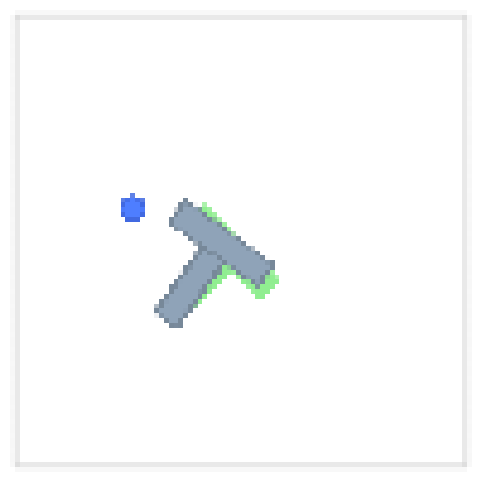

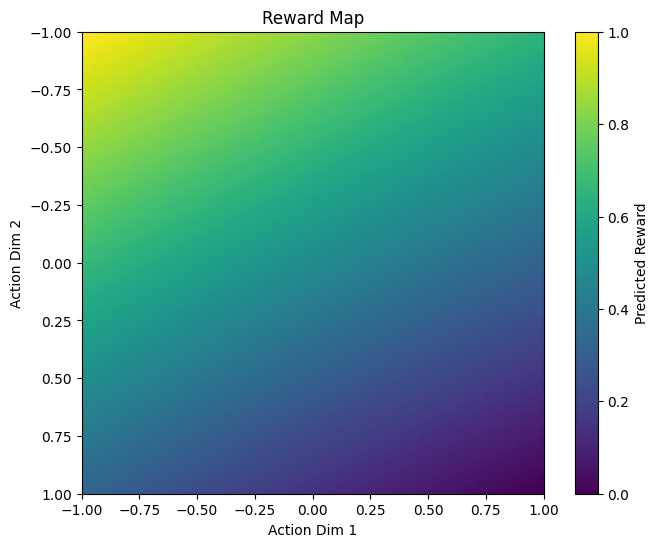

In [ ]:
def generate_reward_map(policy, obs, state, resolution=100):
    """Generate a reward landscape by scanning over possible actions.
    Args:
        policy: The trained CVAE policy
        obs: Image observation tensor of shape (1,3,96,96) 
        state: State tensor of shape (1,2)
        resolution: Number of points to sample in each action dimension
        
    Returns:
        actions: (resolution*resolution, 14) tensor of sampled actions
        rewards: (resolution*resolution,) tensor of predicted rewards
    """
    # Encode state and observation
    with torch.no_grad():
        zs = policy.state_encoder(obs, state)
        
        # Create action grid from (-1,-1) to (1,1)
        x = torch.linspace(-1, 1, resolution)
        y = torch.linspace(1, -1, resolution)  # Reversed y range
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        
        # Create full action tensor with zeros
        actions = torch.zeros((resolution*resolution, 14), device=obs.device)
        # Fill first two dimensions with grid values
        for i in range(1):
            actions[:, 2*i] = xx.flatten()
            actions[:, 2*i+1] = yy.flatten()

        
        # Encode each action
        za_list = []
        rewards = []

        # Process in batches to avoid memory issues
        batch_size = 100
        z = torch.randn(1,64).repeat(batch_size,1).cuda()
        for i in range(0, len(actions), batch_size):
            action_batch = actions[i:i+batch_size]
            
            # Encode action
            za = policy.action_encoder(action_batch)
            
            # # Get latent from encoder
            # z_mu, z_logvar = policy.fusing_encoder(
            #     zs.repeat(len(action_batch),1), 
            #     za
            # )

            # z = policy.reparameterize(z_mu,z_logvar)
            
            
            # Decode reward
            reward = policy.reward_decoder(
                zs.repeat(len(action_batch),1),
                za, 
                z
            )
            rewards.append(reward)
            
        rewards = torch.cat(rewards, dim=0)
        
        rewards = rewards.squeeze(-1).cpu().numpy()

        # Normalize rewards to [0,1] range
        rewards = (rewards - rewards.min()) / (rewards.max() - rewards.min())

        action = actions.cpu().numpy()

        # Reshape rewards for plotting
        reward_grid = rewards.reshape(100,100)


        
        # Plot and save observation image
        dir = "./output/img"
        plt.figure(figsize=(8,6))
        obs_img = obs.squeeze().permute(1,2,0).cpu().numpy()
        plt.imshow(obs_img)
        plt.axis('off')
        plt.savefig(f'{dir}/observation.png')
        plt.show()
        
        # Plot and save reward map
        plt.figure(figsize=(8,6))
        plt.imshow(reward_grid, extent=[-1,1,1,-1], origin='lower')
        plt.colorbar(label='Predicted Reward')
        plt.xlabel('Action Dim 1')
        plt.ylabel('Action Dim 2') 
        plt.title('Reward Map')
        plt.savefig(f'{dir}/reward_map.png')
        plt.show()

        return action, rewards

# Example usage:
obs = batch['observation.image'][0].cuda()
state = batch['observation.state'][0].cuda()/512 * 2 - 1
action, rewards = generate_reward_map(policy, obs, state)


In [94]:
# config_dict = {
#         "horizon": 7,
#         "action_dim": 2,
#         "state_dim": 512*3*3 + 2,
#         "batch_size": 16,
#         "latent_dim_state": 50,
#         "latent_dim_action": 2,  # Same as action_dim
#         "posterior_dim": 64,
#         "beta": 1.0,
#         "training_steps": 3000,
#         "learning_rate": 3e-4,
#         "max_iterations": 50,
#         "step_size": 1e-4,
#         "damping": 1e-3,
#         "min_std": 1e-4,
#         "discount": 0.9,
#         "log_freq": 1,
#         "eval_freq": 40,
#         "output_directory": "./output",
#         "device": "cuda:0",
#         "gradient_accumulation_steps": 4,  # Added gradient accumulation config
#         "eval_split": 0.05
#     }

# config = Config(config_dict)
# policy_ = CVAEWithTrajectoryOptimization(config)

In [97]:
# checkpoint = torch.load("./output/best_model_/model.pt")

/tmp/ipykernel_2867674/804462426.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./output/best_model_/model.pt")


In [100]:
# policy_.state_encoder.load_state_dict(checkpoint['state_encoder'])
# policy_.action_encoder.load_state_dict(checkpoint['action_encoder'])
# policy_.fusing_encoder.load_state_dict(checkpoint['fusing_encoder'])
# policy_.dynamics_function.load_state_dict(checkpoint['dynamics_function'])
# policy_.action_decoder.load_state_dict(checkpoint['action_decoder'])
# policy_.reward_decoder.load_state_dict(checkpoint['reward_decoder'])

<All keys matched successfully>

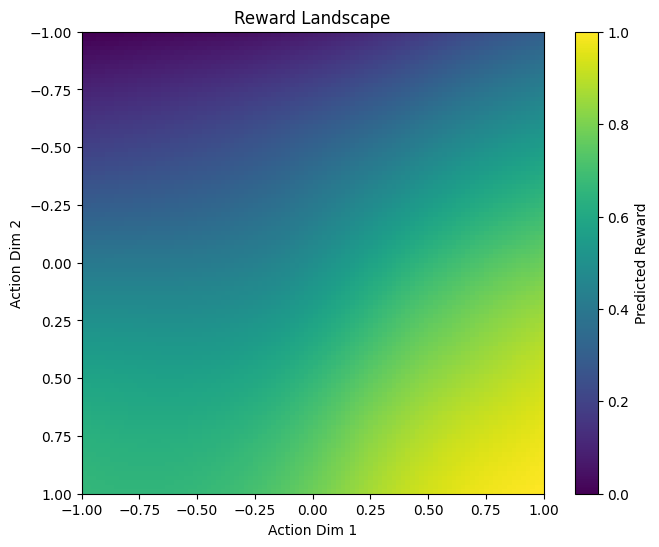

In [101]:
# action, rewards = generate_reward_map(policy_, obs, state)


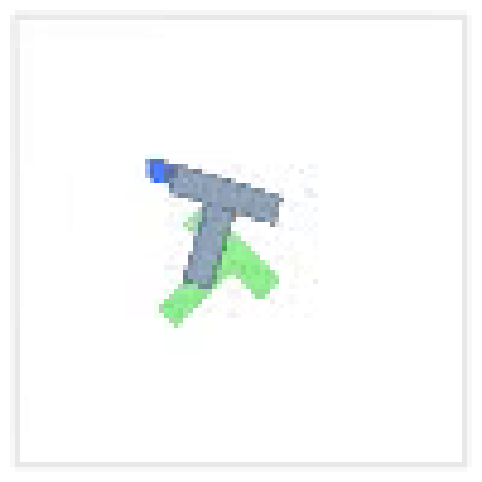

In [78]:
# plt.figure(figsize=(8,6))
# plt.imshow(obs.squeeze().permute(1,2,0).cpu().numpy())
# plt.axis('off')
# plt.show()